In [2]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import drizzlepac
import grizli
import glob
from grizli import utils
import importlib
from grizli.prep import process_direct_grism_visit
from hsaquery import query, overlaps
from grizli.pipeline import auto_script
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import os
from grizli.pipeline import photoz
from astropy.table import Table
import eazy

In [3]:
field           = 'GS1'
ref_filter      = 'F105W'
HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_SCRIPTS = '/Users/rsimons/Desktop/git/clear_local/example_notebooks'
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'
PATH_TO_RAW     = glob.glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob.glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500 # really only necessary for GDN
            self.radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            
            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodsn_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/old_radeccats/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'


            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')




def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in thethreedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [4]:
os.chdir(PATH_TO_PREP)
files = glob.glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [5]:
def grizli_model(visits, field = 'GN2', ref_filter_1 = 'F105W', ref_grism_1 = 'G102', ref_filter_2 = 'F140W', ref_grism_2 = 'G141', load_only = True, mag_lim = 25, include_G141 = True):

    all_grism_files = []
    all_direct_files = []
    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])

    for v, visit in enumerate(visits):
        product = product_names[v]
        basename = basenames[v]
        filt1 = filter_names[v]        
        #filter_name = visit['product'].split('-')[-1]
        field_in_contest = visit['product'].split('-')[0].upper()
        #if field_in_contest.upper() != 'GOODSS':
        #    print (field_in_contest.upper())
            #if field_in_contest == field or field_in_contest in overlapping_fields[field]:
        if (ref_filter_1.lower() in filt1) or (ref_filter_2.lower() in filt1):
            #Find grism files with a direct image
            all_direct_files.extend(visit['files'])
            grism_index_1 = np.where((basenames == basename) & (filter_names == ref_grism_1.lower()))[0]

            if len(grism_index_1) > 0:
                all_grism_files.extend(visits[grism_index_1[0]]['files'])
                print(filter_names[grism_index_1[0]], visits[grism_index_1[0]]['product'])
            if include_G141:
                #Include G141 observatinos
                grism_index_2= np.where((basenames == basename) & (filter_names == ref_grism_2.lower()))[0]

                if len(grism_index_2) > 0:
                    all_grism_files.extend(visits[grism_index_2[0]]['files'])
                    print(filter_names[grism_index_2[0]], visits[grism_index_2[0]]['product'])

    print (all_direct_files, all_grism_files)

    p = Pointing(field=field, ref_filter=ref_filter_1)
    if load_only:
        print('Loading contamination models...')

    grp = GroupFLT(
        grism_files=all_grism_files, 
        direct_files=[], 
        ref_file = p.ref_image,
        seg_file = p.seg_map,
        catalog  = p.catalog,
        pad=p.pad,
        cpu_count=8)

    if not load_only:
        print('Computing contamination models...')
        grp.compute_full_model(mag_limit=mag_lim)
        print('Refining List..')
        grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)
        print('Saving contamination models')
        grp.save_full_data()
    return grp


mag_lim = 21

grp = grizli_model(visits, field = field, ref_filter_1 = 'F105W', ref_grism_1 = 'G102', ref_filter_2 = 'F140W', ref_grism_2 = 'G141',
                   load_only = True, mag_lim = mag_lim)


g141 goodss-01-bhj-01-177.0-g141
g102 gs1-cxt-09-227.0-g102
g102 gs1-cxt-10-227.0-g102
g102 gs1-cxt-07-249.0-g102
g102 gs1-cxt-08-249.0-g102
g102 gs1-cxt-11-269.0-g102
g102 gs1-cxt-12-269.0-g102
['ibhj01ioq_flt.fits', 'ibhj01ivq_flt.fits', 'ibhj01j2q_flt.fits', 'ibhj01j9q_flt.fits', 'icxt09ezq_flt.fits', 'icxt09f4q_flt.fits', 'icxt10daq_flt.fits', 'icxt10dhq_flt.fits', 'icxt07dwq_flt.fits', 'icxt07e1q_flt.fits', 'icxt08e6q_flt.fits', 'icxt08ebq_flt.fits', 'icxt11qhq_flt.fits', 'icxt11qmq_flt.fits', 'icxt12quq_flt.fits', 'icxt12qzq_flt.fits'] ['ibhj01iqq_flt.fits', 'ibhj01ixq_flt.fits', 'ibhj01j4q_flt.fits', 'ibhj01jbq_flt.fits', 'icxt09f0q_flt.fits', 'icxt09f2q_flt.fits', 'icxt09f5q_flt.fits', 'icxt09f7q_flt.fits', 'icxt10dbq_flt.fits', 'icxt10deq_flt.fits', 'icxt10diq_flt.fits', 'icxt10dkq_flt.fits', 'icxt07dxq_flt.fits', 'icxt07dzq_flt.fits', 'icxt07e2q_flt.fits', 'icxt07e4q_flt.fits', 'icxt08e7q_flt.fits', 'icxt08e9q_flt.fits', 'icxt08ecq_flt.fits', 'icxt08eeq_flt.fits', 'icxt11qiq_

In [5]:
p = Pointing(field = field, ref_filter = ref_filter)
eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', 
             path_is_env=False)
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Load individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=p.translate_file, 
                        zeropoint_file=None, params=p.params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez, grizli_templates=templ0, zgrid=ez.zgrid)







File, /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.tempfilt, not found.
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850L

In [15]:
def grizli_fit(grp, id_fit, field = '', ref_filter = 'F105W', use_pz_prior = True, use_phot = True, scale_phot = True, templ0 = None, templ1 = None, ez = None, ep = None, pline = None):
    beams = grp.get_beams(id_fit, size=80)
    if beams != []:
        print("beams: ", beams)
        mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
        mb.write_master_fits()

        # Fit polynomial model for initial continuum subtraction
        wave = np.linspace(2000,2.5e4,100)
        poly_templates = grizli.utils.polynomial_templates(
            wave=wave, 
            order=7,
            line=False)

        pfit = mb.template_at_z(
            z=0, 
            templates=poly_templates, 
            fit_background=True, 
            fitter='lstsq', 
            fwhm=1400, 
            get_uncertainties=2)


        if pfit != None:
        # Drizzle grisms / PAs
            hdu, fig = mb.drizzle_grisms_and_PAs(
                size=32, 
                fcontam=0.2, 
                flambda=False, 
                scale=1, 
                pixfrac=0.5, 
                kernel='point', 
                make_figure=True, 
                usewcs=False, 
                zfit=pfit,
                diff=True)
            # Save drizzled ("stacked") 2D trace as PNG and FITS
            fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
            hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



            if use_pz_prior:
                #use redshift prior from z_phot
                prior = np.zeros((2, len(p.tempfilt['zgrid'])))
                prior[0] = p.tempfilt['zgrid']
                prior[1] = p.pz['chi2fit'][:,id]
            else:
                prior = None 
            order = 0



            tab = utils.GTable()
            tab['ra'] = [mb.ra]
            tab['dec'] = [mb.dec]

            tab['id'] = id_fit
            phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])

            out = grizli.fitting.run_all(
                id_fit, 
                t0=templ0, 
                t1=templ1, 
                fwhm=1200, 
                zr=[0.0, 3.5], 
                dz=[0.004, 0.0005], 
                fitter='nnls',
                group_name=field,
                fit_stacks=True, 
                prior=None, 
                fcontam=0.,
                pline=pline, 
                mask_sn_limit=7, 
                fit_only_beams=False,
                fit_beams=True, 
                root=field,
                fit_trace_shift=False, 
                phot=phot, 
                verbose=True, 
                scale_photometry=order, 
                show_beams=True)
            mb, st, fit, tfit, line_hdu = out
            fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

            fit_hdu.info()
            # same as the fit table above, redshift fit to the stacked spectra
            fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


            # zoom in around the initial best-guess with the individual "beam" spectra
            fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

            templ = Table(fit_hdu['TEMPL'].data)
            print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

            # Helper script for plotting them, not generated automatically
            fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
            fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
            plt.close('all')


beams:  [<grizli.model.BeamCutout object at 0x1df0d597b8>, <grizli.model.BeamCutout object at 0x1df0d59898>, <grizli.model.BeamCutout object at 0x1df0e15cf8>, <grizli.model.BeamCutout object at 0x1df0e2ae10>, <grizli.model.BeamCutout object at 0x1df0e41c50>, <grizli.model.BeamCutout object at 0x1df4b88f98>, <grizli.model.BeamCutout object at 0x1df4ba1dd8>, <grizli.model.BeamCutout object at 0x1df4bafe80>, <grizli.model.BeamCutout object at 0x1df0532cc0>, <grizli.model.BeamCutout object at 0x1df053fc50>, <grizli.model.BeamCutout object at 0x1df055deb8>, <grizli.model.BeamCutout object at 0x1df0d28b38>, <grizli.model.BeamCutout object at 0x1df0d36908>, <grizli.model.BeamCutout object at 0x1df0d44f98>, <grizli.model.BeamCutout object at 0x1df0cbfdd8>, <grizli.model.BeamCutout object at 0x1df0cabe80>, <grizli.model.BeamCutout object at 0x1df0cc9cc0>, <grizli.model.BeamCutout object at 0x1df4d6dc50>, <grizli.model.BeamCutout object at 0x1df4d44eb8>, <grizli.model.BeamCutout object at 0x1df4

  0.7718    5293.0 (0.1924) 144/377
  0.7789    5282.7 (0.1924) 145/377
  0.7860    5271.5 (0.1924) 146/377
  0.7932    5271.5 (0.1924) 147/377
  0.8004    5272.3 (0.1924) 148/377
  0.8076    5246.8 (0.1924) 149/377
  0.8148    5206.8 (0.1924) 150/377
  0.8221    5171.6 (0.1924) 151/377
  0.8294    5137.7 (0.1924) 152/377
  0.8368    5098.8 (0.1924) 153/377
  0.8441    5058.0 (0.8441) 154/377
  0.8515    5017.3 (0.8515) 155/377
  0.8589    4977.0 (0.8589) 156/377
  0.8664    4960.6 (0.8664) 157/377
  0.8739    4944.1 (0.8739) 158/377
  0.8814    4922.7 (0.8814) 159/377
  0.8889    4901.7 (0.8889) 160/377
  0.8965    4876.8 (0.8965) 161/377
  0.9041    4848.8 (0.9041) 162/377
  0.9117    4812.9 (0.9117) 163/377
  0.9194    4758.8 (0.9194) 164/377
  0.9271    4707.3 (0.9271) 165/377
  0.9348    4671.2 (0.9348) 166/377
  0.9425    4615.0 (0.9425) 167/377
  0.9503    4516.2 (0.9503) 168/377
  0.9581    4370.8 (0.9581) 169/377
  0.9660    4188.6 (0.9660) 170/377
  0.9739    4207.9 (0.9660) 

  2.8190   16410.3 (0.9660) 336/377
  2.8344   16443.1 (0.9660) 337/377
  2.8497   16481.2 (0.9660) 338/377
  2.8651   16548.5 (0.9660) 339/377
  2.8806   16637.6 (0.9660) 340/377
  2.8962   16719.1 (0.9660) 341/377
  2.9118   16830.5 (0.9660) 342/377
  2.9275   16940.0 (0.9660) 343/377
  2.9432   17022.6 (0.9660) 344/377
  2.9590   17058.9 (0.9660) 345/377
  2.9749   17082.8 (0.9660) 346/377
  2.9908   17121.6 (0.9660) 347/377
  3.0068   17148.9 (0.9660) 348/377
  3.0229   17175.5 (0.9660) 349/377
  3.0390   17149.1 (0.9660) 350/377
  3.0552   17092.6 (0.9660) 351/377
  3.0715   17068.3 (0.9660) 352/377
  3.0878   17004.4 (0.9660) 353/377
  3.1042   16891.0 (0.9660) 354/377
  3.1206   16778.4 (0.9660) 355/377
  3.1371   16653.1 (0.9660) 356/377
  3.1537   16512.0 (0.9660) 357/377
  3.1704   16366.9 (0.9660) 358/377
  3.1871   16191.6 (0.9660) 359/377
  3.2038   16054.2 (0.9660) 360/377
  3.2207   15952.5 (0.9660) 361/377
  3.2376   15886.6 (0.9660) 362/377
  3.2546   15842.7 (0.9660) 

GS1_44999.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_44999.stack.fits
  G102 G141
User templates! N=16 

  0.0000   13260.9 (0.0000) 1/377
  0.0040   13258.3 (0.0040) 2/377
  0.0080   13255.2 (0.0080) 3/377
  0.0121    7504.9 (0.0121) 4/377
  0.0161    7481.2 (0.0161) 5/

  1.0138    6719.1 (1.0138) 176/377
  1.0218    6690.9 (1.0218) 177/377
  1.0299    6659.3 (1.0299) 178/377
  1.0381    6632.6 (1.0381) 179/377
  1.0462    6622.7 (1.0462) 180/377
  1.0544    6626.5 (1.0462) 181/377
  1.0627    6635.4 (1.0462) 182/377
  1.0709    6652.7 (1.0462) 183/377
  1.0792    6671.3 (1.0462) 184/377
  1.0876    6682.3 (1.0462) 185/377
  1.0959    6689.0 (1.0462) 186/377
  1.1043    6694.9 (1.0462) 187/377
  1.1128    6697.1 (1.0462) 188/377
  1.1212    6696.6 (1.0462) 189/377
  1.1297    6690.8 (1.0462) 190/377
  1.1383    6687.8 (1.0462) 191/377
  1.1468    6685.2 (1.0462) 192/377
  1.1555    6678.3 (1.0462) 193/377
  1.1641    6675.3 (1.0462) 194/377
  1.1728    6674.0 (1.0462) 195/377
  1.1815    6668.9 (1.0462) 196/377
  1.1902    6664.2 (1.0462) 197/377
  1.1990    6657.4 (1.0462) 198/377
  1.2078    6647.9 (1.0462) 199/377
  1.2167    6643.6 (1.0462) 200/377
  1.2255    6645.0 (1.0462) 201/377
  1.2345    6639.4 (1.0462) 202/377
  1.2434    6639.4 (1.0462) 

  3.2888   14241.8 (1.2887) 365/377
  3.3060   14305.3 (1.2887) 366/377
  3.3232   14383.5 (1.2887) 367/377
  3.3405   14465.6 (1.2887) 368/377
  3.3579   14540.0 (1.2887) 369/377
  3.3754   14609.2 (1.2887) 370/377
  3.3929   14680.6 (1.2887) 371/377
  3.4106   14755.7 (1.2887) 372/377
  3.4282   14827.3 (1.2887) 373/377
  3.4460   14882.0 (1.2887) 374/377
  3.4638   14923.4 (1.2887) 375/377
  3.4817   14975.4 (1.2887) 376/377
  3.4997   15041.2 (1.2887) 377/377
First iteration: z_best=1.2887

- 1.2770    6594.1 (1.2770) 1/33
- 1.2775    6593.6 (1.2775) 2/33
- 1.2780    6593.1 (1.2780) 3/33
- 1.2785    6592.4 (1.2785) 4/33
- 1.2790    6591.7 (1.2790) 5/33
- 1.2795    6591.2 (1.2795) 6/33
- 1.2800    6590.7 (1.2800) 7/33
- 1.2805    6590.2 (1.2805) 8/33
- 1.2810    6589.8 (1.2810) 9/33
- 1.2815    6589.3 (1.2815) 10/33
- 1.2820    6588.8 (1.2820) 11/33
- 1.2825    6588.5 (1.2825) 12/33
- 1.2830    6588.3 (1.2830) 13/33
- 1.2835    6588.0 (1.2835) 14/33
- 1.2840    6587.6 (1.2840) 15/33

GS1_45424.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_45424.stack.fits
  G102 G141
User templates! N=16 

  0.0000   20163.6 (0.0000) 1/377
  0.0040   20170.0 (0.0000) 2/377
  0.0080   20168.6 (0.0000) 3/377
  0.0121   12230.6 (0.0121) 4/377
  0.0161   12236.6 (0.0121) 5/

  0.9739   12065.8 (0.7229) 171/377
  0.9818   12087.6 (0.7229) 172/377
  0.9897   12108.7 (0.7229) 173/377
  0.9977   12122.7 (0.7229) 174/377
  1.0057   12116.5 (0.7229) 175/377
  1.0138   12129.5 (0.7229) 176/377
  1.0218   12168.7 (0.7229) 177/377
  1.0299   12176.2 (0.7229) 178/377
  1.0381   12169.6 (0.7229) 179/377
  1.0462   12167.0 (0.7229) 180/377
  1.0544   12173.4 (0.7229) 181/377
  1.0627   12186.3 (0.7229) 182/377
  1.0709   12195.9 (0.7229) 183/377
  1.0792   12203.5 (0.7229) 184/377
  1.0876   12222.4 (0.7229) 185/377
  1.0959   12251.6 (0.7229) 186/377
  1.1043   12305.1 (0.7229) 187/377
  1.1128   12366.6 (0.7229) 188/377
  1.1212   12427.1 (0.7229) 189/377
  1.1297   12502.4 (0.7229) 190/377
  1.1383   12579.6 (0.7229) 191/377
  1.1468   12643.3 (0.7229) 192/377
  1.1555   12705.1 (0.7229) 193/377
  1.1641   12753.5 (0.7229) 194/377
  1.1728   12778.2 (0.7229) 195/377
  1.1815   12800.4 (0.7229) 196/377
  1.1902   12820.3 (0.7229) 197/377
  1.1990   12827.4 (0.7229) 

  3.2376   28899.3 (0.7229) 362/377
  3.2546   28706.3 (0.7229) 363/377
  3.2716   28463.7 (0.7229) 364/377
  3.2888   28240.2 (0.7229) 365/377
  3.3060   28065.9 (0.7229) 366/377
  3.3232   27904.8 (0.7229) 367/377
  3.3405   27727.0 (0.7229) 368/377
  3.3579   27484.7 (0.7229) 369/377
  3.3754   27230.6 (0.7229) 370/377
  3.3929   26972.2 (0.7229) 371/377
  3.4106   26748.3 (0.7229) 372/377
  3.4282   26613.0 (0.7229) 373/377
  3.4460   26535.0 (0.7229) 374/377
  3.4638   26475.3 (0.7229) 375/377
  3.4817   26413.7 (0.7229) 376/377
  3.4997   26348.1 (0.7229) 377/377
First iteration: z_best=0.7229

- 0.7178    9728.9 (0.7178) 1/33
- 0.7183    9700.8 (0.7183) 2/33
- 0.7188    9674.7 (0.7188) 3/33
- 0.7193    9650.2 (0.7193) 4/33
- 0.7198    9627.0 (0.7198) 5/33
- 0.7203    9605.5 (0.7203) 6/33
- 0.7208    9585.8 (0.7208) 7/33
- 0.7213    9567.8 (0.7213) 8/33
- 0.7218    9551.7 (0.7218) 9/33
- 0.7223    9537.4 (0.7223) 10/33
- 0.7228    9524.4 (0.7228) 11/33
- 0.7233    9513.4 (0.7233)

  0.1140    1667.5 (0.0121) 28/377
  0.1185    1667.3 (0.0121) 29/377
  0.1230    1666.3 (0.0121) 30/377
  0.1275    1664.5 (0.0121) 31/377
  0.1320    1660.0 (0.0121) 32/377
  0.1366    1652.1 (0.0121) 33/377
  0.1411    1647.0 (0.0121) 34/377
  0.1457    1653.5 (0.0121) 35/377
  0.1503    1658.7 (0.0121) 36/377
  0.1549    1659.7 (0.0121) 37/377
  0.1595    1659.3 (0.0121) 38/377
  0.1642    1659.7 (0.0121) 39/377
  0.1688    1657.5 (0.0121) 40/377
  0.1735    1653.2 (0.0121) 41/377
  0.1782    1646.9 (0.0121) 42/377
  0.1829    1636.2 (0.0121) 43/377
  0.1877    1625.0 (0.0121) 44/377
  0.1924    1623.1 (0.0121) 45/377
  0.1972    1632.0 (0.0121) 46/377
  0.2020    1643.7 (0.0121) 47/377
  0.2068    1651.3 (0.0121) 48/377
  0.2117    1654.3 (0.0121) 49/377
  0.2165    1653.8 (0.0121) 50/377
  0.2214    1650.7 (0.0121) 51/377
  0.2263    1646.1 (0.0121) 52/377
  0.2312    1640.9 (0.0121) 53/377
  0.2361    1637.1 (0.0121) 54/377
  0.2411    1631.7 (0.0121) 55/377
  0.2461    1623.5 (

  1.3917    2726.2 (0.4564) 219/377
  1.4013    2736.2 (0.4564) 220/377
  1.4109    2743.7 (0.4564) 221/377
  1.4206    2752.1 (0.4564) 222/377
  1.4303    2764.2 (0.4564) 223/377
  1.4400    2776.9 (0.4564) 224/377
  1.4498    2786.7 (0.4564) 225/377
  1.4596    2794.6 (0.4564) 226/377
  1.4695    2809.8 (0.4564) 227/377
  1.4794    2829.3 (0.4564) 228/377
  1.4893    2839.5 (0.4564) 229/377
  1.4993    2837.2 (0.4564) 230/377
  1.5093    2837.5 (0.4564) 231/377
  1.5193    2849.8 (0.4564) 232/377
  1.5294    2867.8 (0.4564) 233/377
  1.5396    2879.8 (0.4564) 234/377
  1.5498    2891.4 (0.4564) 235/377
  1.5600    2921.3 (0.4564) 236/377
  1.5702    2960.4 (0.4564) 237/377
  1.5805    2985.5 (0.4564) 238/377
  1.5909    2990.3 (0.4564) 239/377
  1.6013    2995.7 (0.4564) 240/377
  1.6117    3010.5 (0.4564) 241/377
  1.6222    3027.1 (0.4564) 242/377
  1.6327    3039.6 (0.4564) 243/377
  1.6432    3050.2 (0.4564) 244/377
  1.6538    3053.8 (0.4564) 245/377
  1.6645    3050.6 (0.4564) 

- 0.4626    1119.6 (0.4541) 32/33
- 0.4631    1120.0 (0.4541) 33/33
User templates! N=16 

  0.4252    4231.3 (0.4252) 1/41
  0.4266    4229.0 (0.4266) 2/41
  0.4280    4226.9 (0.4280) 3/41
  0.4295    4225.2 (0.4295) 4/41
  0.4309    4224.3 (0.4309) 5/41
  0.4323    4223.6 (0.4323) 6/41
  0.4338    4222.8 (0.4338) 7/41
  0.4352    4222.3 (0.4352) 8/41
  0.4366    4222.0 (0.4366) 9/41
  0.4381    4221.2 (0.4381) 10/41
  0.4395    4220.2 (0.4395) 11/41
  0.4410    4219.5 (0.4410) 12/41
  0.4424    4218.8 (0.4424) 13/41
  0.4438    4218.0 (0.4438) 14/41
  0.4453    4217.4 (0.4453) 15/41
  0.4467    4216.8 (0.4467) 16/41
  0.4482    4216.1 (0.4482) 17/41
  0.4496    4215.4 (0.4496) 18/41
  0.4511    4215.0 (0.4511) 19/41
  0.4525    4214.6 (0.4525) 20/41
  0.4540    4214.3 (0.4540) 21/41
  0.4554    4214.4 (0.4540) 22/41
  0.4569    4214.6 (0.4540) 23/41
  0.4583    4214.6 (0.4540) 24/41
  0.4598    4214.8 (0.4540) 25/41
  0.4613    4215.5 (0.4540) 26/41
  0.4627    4216.6 (0.4540) 27/41


  0.1972    9961.6 (0.0876) 46/377
  0.2020    9951.4 (0.0876) 47/377
  0.2068    9909.7 (0.0876) 48/377
  0.2117    9826.0 (0.0876) 49/377
  0.2165    9716.8 (0.0876) 50/377
  0.2214    9638.3 (0.2214) 51/377
  0.2263    9584.4 (0.2263) 52/377
  0.2312    9524.1 (0.2312) 53/377
  0.2361    9434.2 (0.2361) 54/377
  0.2411    9341.0 (0.2411) 55/377
  0.2461    9306.5 (0.2461) 56/377
  0.2511    9254.3 (0.2511) 57/377
  0.2561    9252.5 (0.2561) 58/377
  0.2611    9279.1 (0.2561) 59/377
  0.2662    9312.5 (0.2561) 60/377
  0.2712    9420.2 (0.2561) 61/377
  0.2763    9547.1 (0.2561) 62/377
  0.2815    9619.5 (0.2561) 63/377
  0.2866    9740.5 (0.2561) 64/377
  0.2918    9877.1 (0.2561) 65/377
  0.2969   10017.0 (0.2561) 66/377
  0.3021   10112.1 (0.2561) 67/377
  0.3073   10161.2 (0.2561) 68/377
  0.3126   10203.6 (0.2561) 69/377
  0.3178   10234.5 (0.2561) 70/377
  0.3231   10266.5 (0.2561) 71/377
  0.3284   10304.1 (0.2561) 72/377
  0.3338   10335.9 (0.2561) 73/377
  0.3391   10363.9 (

  1.5396   11073.2 (0.9818) 234/377
  1.5498   11163.4 (0.9818) 235/377
  1.5600   11303.2 (0.9818) 236/377
  1.5702   11400.9 (0.9818) 237/377
  1.5805   11451.6 (0.9818) 238/377
  1.5909   11507.0 (0.9818) 239/377
  1.6013   11462.1 (0.9818) 240/377
  1.6117   11504.8 (0.9818) 241/377
  1.6222   11681.3 (0.9818) 242/377
  1.6327   11627.0 (0.9818) 243/377
  1.6432   11697.0 (0.9818) 244/377
  1.6538   11784.3 (0.9818) 245/377
  1.6645   11816.0 (0.9818) 246/377
  1.6751   12423.5 (0.9818) 247/377
  1.6859   12680.6 (0.9818) 248/377
  1.6966   12823.6 (0.9818) 249/377
  1.7074   12938.1 (0.9818) 250/377
  1.7183   13015.0 (0.9818) 251/377
  1.7292   13076.4 (0.9818) 252/377
  1.7401   13167.6 (0.9818) 253/377
  1.7511   13175.5 (0.9818) 254/377
  1.7621   13212.9 (0.9818) 255/377
  1.7732   13318.8 (0.9818) 256/377
  1.7843   13392.0 (0.9818) 257/377
  1.7955   13452.8 (0.9818) 258/377
  1.8067   13532.7 (0.9818) 259/377
  1.8179   13588.1 (0.9818) 260/377
  1.8292   13698.8 (0.9818) 

  0.9648   30583.8 (0.9648) 12/41
  0.9668   30506.5 (0.9668) 13/41
  0.9688   30416.5 (0.9688) 14/41
  0.9707   30291.9 (0.9707) 15/41
  0.9727   30096.9 (0.9727) 16/41
  0.9747   29806.1 (0.9747) 17/41
  0.9767   29411.5 (0.9767) 18/41
  0.9786   28943.7 (0.9786) 19/41
  0.9806   28515.1 (0.9806) 20/41
  0.9826   28299.4 (0.9826) 21/41
  0.9846   28419.6 (0.9826) 22/41
  0.9866   28770.3 (0.9826) 23/41
  0.9886   29193.0 (0.9826) 24/41
  0.9905   29588.2 (0.9826) 25/41
  0.9925   29897.7 (0.9826) 26/41
  0.9945   30125.7 (0.9826) 27/41
  0.9965   30291.0 (0.9826) 28/41
  0.9985   30412.8 (0.9826) 29/41
  1.0005   30504.3 (0.9826) 30/41
  1.0025   30582.3 (0.9826) 31/41
  1.0045   30651.2 (0.9826) 32/41
  1.0065   30706.5 (0.9826) 33/41
  1.0085   30769.2 (0.9826) 34/41
  1.0105   30820.6 (0.9826) 35/41
  1.0126   30861.8 (0.9826) 36/41
  1.0146   30905.5 (0.9826) 37/41
  1.0166   30948.0 (0.9826) 38/41
  1.0186   30968.6 (0.9826) 39/41
  1.0206   30987.0 (0.9826) 40/41
  1.0226   310

  0.1735   11208.4 (0.0121) 41/377
  0.1782   11246.2 (0.0121) 42/377
  0.1829   11297.9 (0.0121) 43/377
  0.1877   11371.4 (0.0121) 44/377
  0.1924   11436.3 (0.0121) 45/377
  0.1972   11490.0 (0.0121) 46/377
  0.2020   11532.7 (0.0121) 47/377
  0.2068   11561.4 (0.0121) 48/377
  0.2117   11571.7 (0.0121) 49/377
  0.2165   11561.5 (0.0121) 50/377
  0.2214   11520.3 (0.0121) 51/377
  0.2263   11453.4 (0.0121) 52/377
  0.2312   11413.2 (0.0121) 53/377
  0.2361   11398.3 (0.0121) 54/377
  0.2411   11392.3 (0.0121) 55/377
  0.2461   11389.6 (0.0121) 56/377
  0.2511   11396.2 (0.0121) 57/377
  0.2561   11391.2 (0.0121) 58/377
  0.2611   11406.4 (0.0121) 59/377
  0.2662   11437.1 (0.0121) 60/377
  0.2712   11439.1 (0.0121) 61/377
  0.2763   11415.8 (0.0121) 62/377
  0.2815   11376.4 (0.0121) 63/377
  0.2866   11342.4 (0.0121) 64/377
  0.2918   11313.6 (0.0121) 65/377
  0.2969   11308.5 (0.0121) 66/377
  0.3021   11336.4 (0.0121) 67/377
  0.3073   11371.2 (0.0121) 68/377
  0.3126   11404.9 (

  1.4893   27709.1 (0.7367) 229/377
  1.4993   28160.7 (0.7367) 230/377
  1.5093   28647.8 (0.7367) 231/377
  1.5193   29206.5 (0.7367) 232/377
  1.5294   29936.2 (0.7367) 233/377
  1.5396   30663.0 (0.7367) 234/377
  1.5498   31437.0 (0.7367) 235/377
  1.5600   32372.8 (0.7367) 236/377
  1.5702   33213.9 (0.7367) 237/377
  1.5805   33918.9 (0.7367) 238/377
  1.5909   34599.7 (0.7367) 239/377
  1.6013   35214.9 (0.7367) 240/377
  1.6117   35850.3 (0.7367) 241/377
  1.6222   36530.5 (0.7367) 242/377
  1.6327   37044.3 (0.7367) 243/377
  1.6432   37405.0 (0.7367) 244/377
  1.6538   37717.1 (0.7367) 245/377
  1.6645   38041.3 (0.7367) 246/377
  1.6751   38482.3 (0.7367) 247/377
  1.6859   38942.3 (0.7367) 248/377
  1.6966   39238.8 (0.7367) 249/377
  1.7074   39584.4 (0.7367) 250/377
  1.7183   40215.0 (0.7367) 251/377
  1.7292   40730.1 (0.7367) 252/377
  1.7401   41083.6 (0.7367) 253/377
  1.7511   41381.6 (0.7367) 254/377
  1.7621   41534.1 (0.7367) 255/377
  1.7732   41822.1 (0.7367) 

  0.7083   74004.3 (0.6998) 6/41
  0.7100   74009.8 (0.6998) 7/41
  0.7118   74001.6 (0.6998) 8/41
  0.7135   73970.2 (0.6998) 9/41
  0.7152   73936.9 (0.6998) 10/41
  0.7169   73876.6 (0.7169) 11/41
  0.7186   73810.5 (0.7186) 12/41
  0.7203   73739.2 (0.7203) 13/41
  0.7221   73659.0 (0.7221) 14/41
  0.7238   73576.2 (0.7238) 15/41
  0.7255   73497.3 (0.7255) 16/41
  0.7272   73417.9 (0.7272) 17/41
  0.7290   73350.5 (0.7290) 18/41
  0.7307   73290.7 (0.7307) 19/41
  0.7324   73253.7 (0.7324) 20/41
  0.7342   73227.9 (0.7342) 21/41
  0.7359   73231.9 (0.7342) 22/41
  0.7376   73254.9 (0.7342) 23/41
  0.7394   73299.5 (0.7342) 24/41
  0.7411   73355.4 (0.7342) 25/41
  0.7428   73423.0 (0.7342) 26/41
  0.7446   73485.9 (0.7342) 27/41
  0.7463   73550.6 (0.7342) 28/41
  0.7481   73599.1 (0.7342) 29/41
  0.7498   73647.8 (0.7342) 30/41
  0.7516   73691.0 (0.7342) 31/41
  0.7533   73720.4 (0.7342) 32/41
  0.7551   73731.8 (0.7342) 33/41
  0.7568   73743.6 (0.7342) 34/41
  0.7586   73745.9

  0.2312   33237.4 (0.1549) 53/377
  0.2361   33267.1 (0.1549) 54/377
  0.2411   33299.4 (0.1549) 55/377
  0.2461   33327.0 (0.1549) 56/377
  0.2511   33349.6 (0.1549) 57/377
  0.2561   33372.0 (0.1549) 58/377
  0.2611   33392.1 (0.1549) 59/377
  0.2662   33415.5 (0.1549) 60/377
  0.2712   33437.8 (0.1549) 61/377
  0.2763   33465.1 (0.1549) 62/377
  0.2815   33490.3 (0.1549) 63/377
  0.2866   33522.6 (0.1549) 64/377
  0.2918   33557.2 (0.1549) 65/377
  0.2969   33588.0 (0.1549) 66/377
  0.3021   33614.3 (0.1549) 67/377
  0.3073   33641.6 (0.1549) 68/377
  0.3126   33665.7 (0.1549) 69/377
  0.3178   33686.0 (0.1549) 70/377
  0.3231   33695.8 (0.1549) 71/377
  0.3284   33694.5 (0.1549) 72/377
  0.3338   33689.5 (0.1549) 73/377
  0.3391   33685.2 (0.1549) 74/377
  0.3445   33682.8 (0.1549) 75/377
  0.3499   33687.6 (0.1549) 76/377
  0.3553   33698.5 (0.1549) 77/377
  0.3607   33710.2 (0.1549) 78/377
  0.3662   33720.9 (0.1549) 79/377
  0.3716   33735.9 (0.1549) 80/377
  0.3771   33749.9 (

  1.6222   31032.4 (1.1990) 242/377
  1.6327   31092.6 (1.1990) 243/377
  1.6432   31185.2 (1.1990) 244/377
  1.6538   31326.4 (1.1990) 245/377
  1.6645   31560.4 (1.1990) 246/377
  1.6751   31752.9 (1.1990) 247/377
  1.6859   31862.0 (1.1990) 248/377
  1.6966   32015.0 (1.1990) 249/377
  1.7074   32167.8 (1.1990) 250/377
  1.7183   32247.1 (1.1990) 251/377
  1.7292   32398.0 (1.1990) 252/377
  1.7401   32528.8 (1.1990) 253/377
  1.7511   32602.1 (1.1990) 254/377
  1.7621   32669.0 (1.1990) 255/377
  1.7732   32691.4 (1.1990) 256/377
  1.7843   32697.0 (1.1990) 257/377
  1.7955   32808.6 (1.1990) 258/377
  1.8067   33159.4 (1.1990) 259/377
  1.8179   33474.3 (1.1990) 260/377
  1.8292   33742.4 (1.1990) 261/377
  1.8406   33824.9 (1.1990) 262/377
  1.8519   33790.4 (1.1990) 263/377
  1.8634   33582.0 (1.1990) 264/377
  1.8748   33706.6 (1.1990) 265/377
  1.8864   33811.4 (1.1990) 266/377
  1.8979   33969.5 (1.1990) 267/377
  1.9096   34113.5 (1.1990) 268/377
  1.9212   34300.9 (1.1990) 

  1.1944 2916438.4 (1.1944) 20/41
  1.1966 2916436.8 (1.1966) 21/41
  1.1988 2916445.4 (1.1966) 22/41
  1.2010 2916474.6 (1.1966) 23/41
  1.2032 2916505.5 (1.1966) 24/41
  1.2054 2916536.6 (1.1966) 25/41
  1.2076 2916562.8 (1.1966) 26/41
  1.2098 2916524.3 (1.1966) 27/41
  1.2120 2916479.4 (1.1966) 28/41
  1.2142 2916439.2 (1.1966) 29/41
  1.2164 2916398.1 (1.2164) 30/41
  1.2187 2916365.1 (1.2187) 31/41
  1.2209 2916333.8 (1.2209) 32/41
  1.2231 2916298.2 (1.2231) 33/41
  1.2253 2916263.2 (1.2253) 34/41
  1.2275 2916222.8 (1.2275) 35/41
  1.2298 2916174.8 (1.2298) 36/41
  1.2320 2916129.9 (1.2320) 37/41
  1.2342 2916081.6 (1.2342) 38/41
  1.2365 2916033.4 (1.2365) 39/41
  1.2387 2915985.1 (1.2387) 40/41
  1.2410 2915930.1 (1.2410) 41/41
First iteration: z_best=1.2410

Drizzle line -> Hb   (20.62 1.14)
Drizzle line -> OIII-4363 (48.39 1.45)
Drizzle line -> Hg   (56.29 1.50)
Drizzle line -> Hd   (27.25 1.67)
Filename: GS1_45915.full.fits
No.    Name      Ver    Type      Cards   Dimensi

ValueError: need at least one array to concatenate

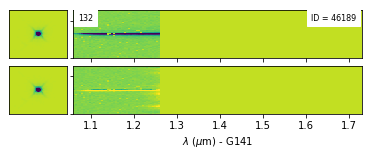

In [16]:
good = np.where(np.array(grp.catalog['MAG_AUTO']) < 22)[0]
for g in good:
    id_fit = np.array(grp.catalog['NUMBER'])[g]
    mag_fit = grp.catalog['MAG_AUTO'][g]
    grizli_fit(grp, id_fit = id_fit, field = field,
               use_pz_prior = False, use_phot = True, scale_phot = True,
               templ0 = templ0, templ1 = templ1, ez = ez, ep = ep, pline = pline,)
        


        

'''
grizli_fit(grp, id_fit = id_fit, field = field,
           use_pz_prior = False, use_phot = True, scale_phot = True,
           templ0 = templ0, templ1 = templ1, ez = ez, ep = ep, pline = pline,)
'''

beams:  [<grizli.model.BeamCutout object at 0x1e0b0b2ba8>, <grizli.model.BeamCutout object at 0x1e0b0b24e0>, <grizli.model.BeamCutout object at 0x1e2326abe0>, <grizli.model.BeamCutout object at 0x1e04d2cc50>, <grizli.model.BeamCutout object at 0x1e01cabda0>, <grizli.model.BeamCutout object at 0x1e0236fcf8>, <grizli.model.BeamCutout object at 0x1df5909048>, <grizli.model.BeamCutout object at 0x1e0236e7b8>, <grizli.model.BeamCutout object at 0x1e31478ba8>, <grizli.model.BeamCutout object at 0x1df5bb2fd0>, <grizli.model.BeamCutout object at 0x1df5bc50b8>, <grizli.model.BeamCutout object at 0x1e090db9b0>, <grizli.model.BeamCutout object at 0x1df4efecf8>, <grizli.model.BeamCutout object at 0x1cc3f99ef0>, <grizli.model.BeamCutout object at 0x1e2ece2240>, <grizli.model.BeamCutout object at 0x1df05db7f0>, <grizli.model.BeamCutout object at 0x1dfc5804e0>, <grizli.model.BeamCutout object at 0x1dede53710>, <grizli.model.BeamCutout object at 0x1e00b825f8>, <grizli.model.BeamCutout object at 0x1df0

  0.7647    3566.6 (0.1457) 143/377
  0.7718    3561.9 (0.1457) 144/377
  0.7789    3556.9 (0.1457) 145/377
  0.7860    3555.2 (0.1457) 146/377
  0.7932    3554.2 (0.1457) 147/377
  0.8004    3550.5 (0.1457) 148/377
  0.8076    3544.7 (0.1457) 149/377
  0.8148    3539.6 (0.1457) 150/377
  0.8221    3534.8 (0.1457) 151/377
  0.8294    3533.5 (0.1457) 152/377
  0.8368    3534.1 (0.1457) 153/377
  0.8441    3532.4 (0.1457) 154/377
  0.8515    3528.9 (0.1457) 155/377
  0.8589    3524.6 (0.1457) 156/377
  0.8664    3521.0 (0.1457) 157/377
  0.8739    3517.7 (0.1457) 158/377
  0.8814    3513.6 (0.1457) 159/377
  0.8889    3508.7 (0.1457) 160/377
  0.8965    3504.4 (0.1457) 161/377
  0.9041    3499.2 (0.1457) 162/377
  0.9117    3492.5 (0.1457) 163/377
  0.9194    3484.7 (0.1457) 164/377
  0.9271    3474.9 (0.1457) 165/377
  0.9348    3464.8 (0.1457) 166/377
  0.9425    3453.3 (0.1457) 167/377
  0.9503    3437.3 (0.1457) 168/377
  0.9581    3418.2 (0.1457) 169/377
  0.9660    3399.6 (0.1457) 

  2.7434    3985.6 (1.2796) 331/377
  2.7584    4005.0 (1.2796) 332/377
  2.7735    4019.6 (1.2796) 333/377
  2.7886    4021.6 (1.2796) 334/377
  2.8038    4016.6 (1.2796) 335/377
  2.8190    4013.2 (1.2796) 336/377
  2.8344    4022.0 (1.2796) 337/377
  2.8497    4038.3 (1.2796) 338/377
  2.8651    4040.6 (1.2796) 339/377
  2.8806    4039.8 (1.2796) 340/377
  2.8962    4049.7 (1.2796) 341/377
  2.9118    4064.6 (1.2796) 342/377
  2.9275    4080.3 (1.2796) 343/377
  2.9432    4097.0 (1.2796) 344/377
  2.9590    4112.3 (1.2796) 345/377
  2.9749    4135.9 (1.2796) 346/377
  2.9908    4138.1 (1.2796) 347/377
  3.0068    4030.2 (1.2796) 348/377
  3.0229    3969.5 (1.2796) 349/377
  3.0390    4128.1 (1.2796) 350/377
  3.0552    4233.9 (1.2796) 351/377
  3.0715    4262.1 (1.2796) 352/377
  3.0878    4274.3 (1.2796) 353/377
  3.1042    4275.6 (1.2796) 354/377
  3.1206    4280.4 (1.2796) 355/377
  3.1371    4308.8 (1.2796) 356/377
  3.1537    4333.4 (1.2796) 357/377
  3.1704    4351.2 (1.2796) 

GS1_43812.beams.fits
1 icxt09f0q_flt.fits G102
2 icxt09f2q_flt.fits G102
3 icxt09f5q_flt.fits G102
4 icxt09f7q_flt.fits G102
5 icxt10dbq_flt.fits G102
6 icxt10deq_flt.fits G102
7 icxt10diq_flt.fits G102
8 icxt10dkq_flt.fits G102
Load file GS1_43812.stack.fits
  G102
User templates! N=16 

  0.0000    9723.0 (0.0000) 1/377
  0.0040    9720.8 (0.0040) 2/377
  0.0080    9718.9 (0.0080) 3/377
  0.0121    4890.0 (0.0121) 4/377
  0.0161    4891.0 (0.0121) 5/377
  0.0202    4894.0 (0.0121) 6/377
  0.0243    4898.4 (0.0121) 7/377
  0.0284    4900.8 (0.0121) 8/377
  0.0325    4902.6 (0.0121) 9/377
  0.0367    4905.3 (0.0121) 10/377
  0.0408    4907.5 (0.0121) 11/377
  0.0450    4909.9 (0.0121) 12/377
  0.0492    4912.2 (0.0121) 13/377
  0.0534    4914.1 (0.0121) 14/377
  0.0576    4916.1 (0.0121) 15/377
  0.0618    4918.4 (0.0121) 16/377
  0.0661    4920.1 (0.0121) 17/377
  0.0704    4921.7 (0.0121) 18/377
  0.0747    4923.0 (0.0121) 19/377
  0.0790    4923.9 (0.0121) 20/377
  0.0833    4925.5 

  1.1468    4395.9 (1.1297) 192/377
  1.1555    4427.4 (1.1297) 193/377
  1.1641    4480.9 (1.1297) 194/377
  1.1728    4522.9 (1.1297) 195/377
  1.1815    4551.1 (1.1297) 196/377
  1.1902    4570.6 (1.1297) 197/377
  1.1990    4591.9 (1.1297) 198/377
  1.2078    4612.2 (1.1297) 199/377
  1.2167    4632.0 (1.1297) 200/377
  1.2255    4643.1 (1.1297) 201/377
  1.2345    4647.0 (1.1297) 202/377
  1.2434    4646.9 (1.1297) 203/377
  1.2524    4646.9 (1.1297) 204/377
  1.2614    4643.2 (1.1297) 205/377
  1.2705    4638.3 (1.1297) 206/377
  1.2796    4637.5 (1.1297) 207/377
  1.2887    4638.0 (1.1297) 208/377
  1.2979    4637.8 (1.1297) 209/377
  1.3071    4639.1 (1.1297) 210/377
  1.3164    4641.6 (1.1297) 211/377
  1.3257    4644.8 (1.1297) 212/377
  1.3350    4648.0 (1.1297) 213/377
  1.3443    4647.8 (1.1297) 214/377
  1.3537    4649.7 (1.1297) 215/377
  1.3632    4657.7 (1.1297) 216/377
  1.3726    4666.6 (1.1297) 217/377
  1.3821    4674.6 (1.1297) 218/377
  1.3917    4677.5 (1.1297) 

- 1.1277    4376.9 (1.1277) 10/33
- 1.1282    4376.2 (1.1282) 11/33
- 1.1287    4375.9 (1.1287) 12/33
- 1.1292    4375.7 (1.1292) 13/33
- 1.1297    4375.8 (1.1292) 14/33
- 1.1302    4376.1 (1.1292) 15/33
- 1.1307    4376.5 (1.1292) 16/33
- 1.1312    4377.1 (1.1292) 17/33
- 1.1317    4377.9 (1.1292) 18/33
- 1.1322    4378.9 (1.1292) 19/33
- 1.1327    4379.9 (1.1292) 20/33
- 1.1332    4381.1 (1.1292) 21/33
- 1.1337    4382.2 (1.1292) 22/33
- 1.1342    4383.4 (1.1292) 23/33
- 1.1347    4384.6 (1.1292) 24/33
- 1.1352    4385.6 (1.1292) 25/33
- 1.1357    4386.6 (1.1292) 26/33
- 1.1362    4387.5 (1.1292) 27/33
- 1.1367    4388.4 (1.1292) 28/33
- 1.1372    4389.2 (1.1292) 29/33
- 1.1377    4390.0 (1.1292) 30/33
- 1.1382    4390.6 (1.1292) 31/33
- 1.1387    4391.1 (1.1292) 32/33
- 1.1392    4391.5 (1.1292) 33/33
User templates! N=16 

  1.0867   28855.8 (1.0867) 1/41
  1.0887   28847.1 (1.0887) 2/41
  1.0908   28838.1 (1.0908) 3/41
  1.0929   28830.0 (1.0929) 4/41
  1.0950   28821.8 (1.0950) 5

  0.2662    3120.6 (0.2662) 60/377
  0.2712    3113.4 (0.2712) 61/377
  0.2763    3106.3 (0.2763) 62/377
  0.2815    3099.4 (0.2815) 63/377
  0.2866    3092.7 (0.2866) 64/377
  0.2918    3085.9 (0.2918) 65/377
  0.2969    3079.3 (0.2969) 66/377
  0.3021    3072.9 (0.3021) 67/377
  0.3073    3067.3 (0.3073) 68/377
  0.3126    3062.6 (0.3126) 69/377
  0.3178    3058.9 (0.3178) 70/377
  0.3231    3055.9 (0.3231) 71/377
  0.3284    3053.2 (0.3284) 72/377
  0.3338    3051.1 (0.3338) 73/377
  0.3391    3049.4 (0.3391) 74/377
  0.3445    3047.6 (0.3445) 75/377
  0.3499    3045.5 (0.3499) 76/377
  0.3553    3043.4 (0.3553) 77/377
  0.3607    3040.9 (0.3607) 78/377
  0.3662    3038.1 (0.3662) 79/377
  0.3716    3034.7 (0.3716) 80/377
  0.3771    3030.7 (0.3771) 81/377
  0.3826    3026.3 (0.3826) 82/377
  0.3882    3021.5 (0.3882) 83/377
  0.3938    3016.2 (0.3938) 84/377
  0.3993    3010.8 (0.3993) 85/377
  0.4049    3003.8 (0.4049) 86/377
  0.4106    2997.0 (0.4106) 87/377
  0.4162    2990.5 (

  1.7955    2471.0 (1.6117) 258/377
  1.8067    2468.7 (1.6117) 259/377
  1.8179    2463.1 (1.6117) 260/377
  1.8292    2462.1 (1.6117) 261/377
  1.8406    2461.9 (1.6117) 262/377
  1.8519    2458.9 (1.6117) 263/377
  1.8634    2466.5 (1.6117) 264/377
  1.8748    2471.2 (1.6117) 265/377
  1.8864    2459.3 (1.6117) 266/377
  1.8979    2429.6 (1.8979) 267/377
  1.9096    2430.2 (1.8979) 268/377
  1.9212    2446.9 (1.8979) 269/377
  1.9329    2452.8 (1.8979) 270/377
  1.9447    2458.0 (1.8979) 271/377
  1.9565    2472.2 (1.8979) 272/377
  1.9683    2479.6 (1.8979) 273/377
  1.9802    2480.0 (1.8979) 274/377
  1.9922    2480.3 (1.8979) 275/377
  2.0042    2479.9 (1.8979) 276/377
  2.0162    2481.1 (1.8979) 277/377
  2.0283    2481.6 (1.8979) 278/377
  2.0404    2481.1 (1.8979) 279/377
  2.0526    2480.8 (1.8979) 280/377
  2.0649    2481.0 (1.8979) 281/377
  2.0771    2479.4 (1.8979) 282/377
  2.0895    2476.0 (1.8979) 283/377
  2.1019    2474.9 (1.8979) 284/377
  2.1143    2475.1 (1.8979) 

  1.9525   14898.7 (1.9027) 38/41
  1.9555   14901.8 (1.9027) 39/41
  1.9584   14905.0 (1.9027) 40/41
  1.9614   14907.9 (1.9027) 41/41
First iteration: z_best=1.9027

- 1.9003   14862.7 (1.9003) 1/21
- 1.9005   14862.6 (1.9005) 2/21
- 1.9007   14862.4 (1.9007) 3/21
- 1.9009   14862.3 (1.9009) 4/21
- 1.9011   14862.2 (1.9011) 5/21
- 1.9013   14862.2 (1.9013) 6/21
- 1.9015   14862.1 (1.9015) 7/21
- 1.9017   14862.0 (1.9017) 8/21
- 1.9019   14862.0 (1.9019) 9/21
- 1.9021   14862.0 (1.9021) 10/21
- 1.9023   14862.0 (1.9023) 11/21
- 1.9025   14862.0 (1.9023) 12/21
- 1.9027   14862.0 (1.9023) 13/21
- 1.9029   14862.0 (1.9023) 14/21
- 1.9031   14862.1 (1.9023) 15/21
- 1.9033   14862.1 (1.9023) 16/21
- 1.9035   14862.2 (1.9023) 17/21
- 1.9037   14862.3 (1.9023) 18/21
- 1.9039   14862.4 (1.9023) 19/21
- 1.9041   14862.5 (1.9023) 20/21
- 1.9043   14862.7 (1.9023) 21/21
Drizzle line -> OII  (6.74 0.90)
Filename: GS1_43826.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  

  0.5589    1736.8 (0.1366) 112/377
  0.5652    1710.0 (0.1366) 113/377
  0.5715    1669.3 (0.1366) 114/377
  0.5778    1728.3 (0.1366) 115/377
  0.5841    1742.6 (0.1366) 116/377
  0.5904    1738.7 (0.1366) 117/377
  0.5968    1731.0 (0.1366) 118/377
  0.6032    1717.3 (0.1366) 119/377
  0.6096    1703.9 (0.1366) 120/377
  0.6161    1662.1 (0.1366) 121/377
  0.6226    1654.5 (0.1366) 122/377
  0.6291    1705.8 (0.1366) 123/377
  0.6356    1720.1 (0.1366) 124/377
  0.6421    1714.3 (0.1366) 125/377
  0.6487    1705.5 (0.1366) 126/377
  0.6553    1696.9 (0.1366) 127/377
  0.6620    1685.2 (0.1366) 128/377
  0.6686    1674.2 (0.1366) 129/377
  0.6753    1663.4 (0.1366) 130/377
  0.6820    1654.4 (0.1366) 131/377
  0.6888    1651.7 (0.1366) 132/377
  0.6955    1650.2 (0.1366) 133/377
  0.7023    1644.0 (0.1366) 134/377
  0.7092    1636.7 (0.1366) 135/377
  0.7160    1633.5 (0.1366) 136/377
  0.7229    1624.8 (0.1366) 137/377
  0.7298    1617.6 (0.1366) 138/377
  0.7367    1611.7 (0.1366) 

  2.3069    2160.4 (1.1212) 300/377
  2.3201    2167.6 (1.1212) 301/377
  2.3334    2175.1 (1.1212) 302/377
  2.3468    2182.3 (1.1212) 303/377
  2.3602    2189.0 (1.1212) 304/377
  2.3737    2198.0 (1.1212) 305/377
  2.3872    2209.3 (1.1212) 306/377
  2.4008    2219.5 (1.1212) 307/377
  2.4144    2228.3 (1.1212) 308/377
  2.4281    2237.5 (1.1212) 309/377
  2.4418    2249.8 (1.1212) 310/377
  2.4556    2263.9 (1.1212) 311/377
  2.4695    2279.1 (1.1212) 312/377
  2.4834    2295.6 (1.1212) 313/377
  2.4973    2312.5 (1.1212) 314/377
  2.5113    2328.1 (1.1212) 315/377
  2.5254    2337.6 (1.1212) 316/377
  2.5396    2343.8 (1.1212) 317/377
  2.5537    2351.4 (1.1212) 318/377
  2.5680    2359.9 (1.1212) 319/377
  2.5823    2368.4 (1.1212) 320/377
  2.5966    2377.5 (1.1212) 321/377
  2.6111    2388.8 (1.1212) 322/377
  2.6255    2401.2 (1.1212) 323/377
  2.6401    2411.0 (1.1212) 324/377
  2.6546    2420.7 (1.1212) 325/377
  2.6693    2434.5 (1.1212) 326/377
  2.6840    2450.8 (1.1212) 

GS1_43904.full.fits has lines [OIII Hb OII]
beams:  [<grizli.model.BeamCutout object at 0x1cbfcdfd30>, <grizli.model.BeamCutout object at 0x1cbfcdfa20>, <grizli.model.BeamCutout object at 0x1e0a756c50>, <grizli.model.BeamCutout object at 0x1e0a72eeb8>, <grizli.model.BeamCutout object at 0x1df50caef0>, <grizli.model.BeamCutout object at 0x1dffff0d30>, <grizli.model.BeamCutout object at 0x1dfffe5c18>, <grizli.model.BeamCutout object at 0x1dfdeeaf28>, <grizli.model.BeamCutout object at 0x1dfbb58f98>, <grizli.model.BeamCutout object at 0x1dfbb7c978>, <grizli.model.BeamCutout object at 0x1df5249d30>, <grizli.model.BeamCutout object at 0x1df5a63e48>, <grizli.model.BeamCutout object at 0x1df5a6a4e0>, <grizli.model.BeamCutout object at 0x1df5bcbd30>, <grizli.model.BeamCutout object at 0x1df0d3ac18>, <grizli.model.BeamCutout object at 0x1df0d29f28>, <grizli.model.BeamCutout object at 0x1df9b80f98>, <grizli.model.BeamCutout object at 0x1dfb382978>, <grizli.model.BeamCutout object at 0x1dfb35cd30

  0.7437    4637.4 (0.0161) 140/377
  0.7507    4626.8 (0.0161) 141/377
  0.7577    4613.1 (0.0161) 142/377
  0.7647    4602.3 (0.0161) 143/377
  0.7718    4594.8 (0.0161) 144/377
  0.7789    4588.4 (0.0161) 145/377
  0.7860    4582.7 (0.0161) 146/377
  0.7932    4576.5 (0.0161) 147/377
  0.8004    4568.2 (0.0161) 148/377
  0.8076    4555.2 (0.0161) 149/377
  0.8148    4538.1 (0.0161) 150/377
  0.8221    4520.5 (0.0161) 151/377
  0.8294    4509.5 (0.0161) 152/377
  0.8368    4506.9 (0.0161) 153/377
  0.8441    4502.7 (0.0161) 154/377
  0.8515    4491.2 (0.0161) 155/377
  0.8589    4478.2 (0.0161) 156/377
  0.8664    4468.8 (0.0161) 157/377
  0.8739    4458.0 (0.8739) 158/377
  0.8814    4444.5 (0.8814) 159/377
  0.8889    4432.2 (0.8889) 160/377
  0.8965    4423.5 (0.8965) 161/377
  0.9041    4416.6 (0.9041) 162/377
  0.9117    4406.2 (0.9117) 163/377
  0.9194    4391.9 (0.9194) 164/377
  0.9271    4373.4 (0.9271) 165/377
  0.9348    4354.0 (0.9348) 166/377
  0.9425    4334.8 (0.9425) 

  2.7584    7487.5 (1.0381) 332/377
  2.7735    7513.9 (1.0381) 333/377
  2.7886    7532.8 (1.0381) 334/377
  2.8038    7545.5 (1.0381) 335/377
  2.8190    7559.3 (1.0381) 336/377
  2.8344    7579.2 (1.0381) 337/377
  2.8497    7604.8 (1.0381) 338/377
  2.8651    7625.2 (1.0381) 339/377
  2.8806    7644.1 (1.0381) 340/377
  2.8962    7668.6 (1.0381) 341/377
  2.9118    7693.6 (1.0381) 342/377
  2.9275    7711.5 (1.0381) 343/377
  2.9432    7723.6 (1.0381) 344/377
  2.9590    7734.7 (1.0381) 345/377
  2.9749    7753.5 (1.0381) 346/377
  2.9908    7776.3 (1.0381) 347/377
  3.0068    7795.0 (1.0381) 348/377
  3.0229    7812.3 (1.0381) 349/377
  3.0390    7833.4 (1.0381) 350/377
  3.0552    7848.8 (1.0381) 351/377
  3.0715    7857.9 (1.0381) 352/377
  3.0878    7867.9 (1.0381) 353/377
  3.1042    7879.8 (1.0381) 354/377
  3.1206    7891.6 (1.0381) 355/377
  3.1371    7905.6 (1.0381) 356/377
  3.1537    7920.1 (1.0381) 357/377
  3.1704    7926.3 (1.0381) 358/377
  3.1871    7924.4 (1.0381) 

GS1_44116.beams.fits
1 icxt09f0q_flt.fits G102
2 icxt09f2q_flt.fits G102
3 icxt09f5q_flt.fits G102
4 icxt09f7q_flt.fits G102
5 icxt10dbq_flt.fits G102
6 icxt10deq_flt.fits G102
7 icxt10diq_flt.fits G102
8 icxt10dkq_flt.fits G102
Load file GS1_44116.stack.fits
  G102
User templates! N=16 

  0.0000    6073.0 (0.0000) 1/377
  0.0040    6073.1 (0.0000) 2/377
  0.0080    6073.0 (0.0080) 3/377
  0.0121    2650.9 (0.0121) 4/377
  0.0161    2646.1 (0.0161) 5/377
  0.0202    2641.2 (0.0202) 6/377
  0.0243    2636.4 (0.0243) 7/377
  0.0284    2630.8 (0.0284) 8/377
  0.0325    2625.6 (0.0325) 9/377
  0.0367    2620.5 (0.0367) 10/377
  0.0408    2615.4 (0.0408) 11/377
  0.0450    2611.2 (0.0450) 12/377
  0.0492    2605.8 (0.0492) 13/377
  0.0534    2598.7 (0.0534) 14/377
  0.0576    2590.6 (0.0576) 15/377
  0.0618    2583.1 (0.0618) 16/377
  0.0661    2576.5 (0.0661) 17/377
  0.0704    2569.9 (0.0704) 18/377
  0.0747    2563.7 (0.0747) 19/377
  0.0790    2559.3 (0.0790) 20/377
  0.0833    2556.1 

  1.1128    2507.0 (0.6820) 188/377
  1.1212    2505.3 (0.6820) 189/377
  1.1297    2505.4 (0.6820) 190/377
  1.1383    2505.0 (0.6820) 191/377
  1.1468    2508.4 (0.6820) 192/377
  1.1555    2509.5 (0.6820) 193/377
  1.1641    2509.4 (0.6820) 194/377
  1.1728    2509.8 (0.6820) 195/377
  1.1815    2511.1 (0.6820) 196/377
  1.1902    2514.8 (0.6820) 197/377
  1.1990    2518.5 (0.6820) 198/377
  1.2078    2518.2 (0.6820) 199/377
  1.2167    2517.4 (0.6820) 200/377
  1.2255    2518.1 (0.6820) 201/377
  1.2345    2514.5 (0.6820) 202/377
  1.2434    2515.8 (0.6820) 203/377
  1.2524    2519.6 (0.6820) 204/377
  1.2614    2523.0 (0.6820) 205/377
  1.2705    2528.0 (0.6820) 206/377
  1.2796    2532.5 (0.6820) 207/377
  1.2887    2537.2 (0.6820) 208/377
  1.2979    2544.6 (0.6820) 209/377
  1.3071    2548.0 (0.6820) 210/377
  1.3164    2547.6 (0.6820) 211/377
  1.3257    2551.4 (0.6820) 212/377
  1.3350    2555.0 (0.6820) 213/377
  1.3443    2564.6 (0.6820) 214/377
  1.3537    2578.9 (0.6820) 

- 0.6753    2358.1 (0.6753) 1/33
- 0.6758    2357.9 (0.6758) 2/33
- 0.6763    2357.8 (0.6763) 3/33
- 0.6768    2357.8 (0.6768) 4/33
- 0.6773    2357.7 (0.6773) 5/33
- 0.6778    2357.6 (0.6778) 6/33
- 0.6783    2357.6 (0.6783) 7/33
- 0.6788    2357.6 (0.6788) 8/33
- 0.6793    2357.5 (0.6793) 9/33
- 0.6798    2357.4 (0.6798) 10/33
- 0.6803    2357.3 (0.6803) 11/33
- 0.6808    2357.2 (0.6808) 12/33
- 0.6813    2357.1 (0.6813) 13/33
- 0.6818    2357.0 (0.6818) 14/33
- 0.6823    2357.0 (0.6823) 15/33
- 0.6828    2357.0 (0.6823) 16/33
- 0.6833    2357.0 (0.6823) 17/33
- 0.6838    2357.0 (0.6823) 18/33
- 0.6843    2357.0 (0.6823) 19/33
- 0.6848    2357.0 (0.6823) 20/33
- 0.6853    2357.0 (0.6823) 21/33
- 0.6858    2357.0 (0.6823) 22/33
- 0.6863    2357.1 (0.6823) 23/33
- 0.6868    2357.2 (0.6823) 24/33
- 0.6873    2357.2 (0.6823) 25/33
- 0.6878    2357.3 (0.6823) 26/33
- 0.6883    2357.4 (0.6823) 27/33
- 0.6888    2357.5 (0.6823) 28/33
- 0.6893    2357.6 (0.6823) 29/33
- 0.6898    2357.7 (0.6

  0.0661    2176.6 (0.0121) 17/377
  0.0704    2176.2 (0.0121) 18/377
  0.0747    2174.1 (0.0121) 19/377
  0.0790    2171.3 (0.0121) 20/377
  0.0833    2172.5 (0.0121) 21/377
  0.0876    2176.3 (0.0121) 22/377
  0.0920    2172.1 (0.0121) 23/377
  0.0964    2168.2 (0.0121) 24/377
  0.1008    2167.3 (0.0121) 25/377
  0.1052    2166.2 (0.0121) 26/377
  0.1096    2165.6 (0.0121) 27/377
  0.1140    2165.1 (0.0121) 28/377
  0.1185    2164.6 (0.0121) 29/377
  0.1230    2165.1 (0.0121) 30/377
  0.1275    2166.0 (0.0121) 31/377
  0.1320    2166.3 (0.0121) 32/377
  0.1366    2165.5 (0.0121) 33/377
  0.1411    2165.7 (0.0121) 34/377
  0.1457    2171.8 (0.0121) 35/377
  0.1503    2189.9 (0.0121) 36/377
  0.1549    2200.1 (0.0121) 37/377
  0.1595    2204.6 (0.0121) 38/377
  0.1642    2206.1 (0.0121) 39/377
  0.1688    2207.3 (0.0121) 40/377
  0.1735    2208.5 (0.0121) 41/377
  0.1782    2207.3 (0.0121) 42/377
  0.1829    2201.4 (0.0121) 43/377
  0.1877    2193.7 (0.0121) 44/377
  0.1924    2192.3 (

  1.2979    1982.1 (0.9739) 209/377
  1.3071    1980.6 (0.9739) 210/377
  1.3164    1981.3 (0.9739) 211/377
  1.3257    1990.6 (0.9739) 212/377
  1.3350    2010.7 (0.9739) 213/377
  1.3443    2034.2 (0.9739) 214/377
  1.3537    2053.5 (0.9739) 215/377
  1.3632    2067.9 (0.9739) 216/377
  1.3726    2077.0 (0.9739) 217/377
  1.3821    2086.7 (0.9739) 218/377
  1.3917    2099.3 (0.9739) 219/377
  1.4013    2104.0 (0.9739) 220/377
  1.4109    2105.9 (0.9739) 221/377
  1.4206    2111.7 (0.9739) 222/377
  1.4303    2123.0 (0.9739) 223/377
  1.4400    2133.5 (0.9739) 224/377
  1.4498    2144.2 (0.9739) 225/377
  1.4596    2160.0 (0.9739) 226/377
  1.4695    2190.7 (0.9739) 227/377
  1.4794    2215.8 (0.9739) 228/377
  1.4893    2226.0 (0.9739) 229/377
  1.4993    2229.4 (0.9739) 230/377
  1.5093    2231.1 (0.9739) 231/377
  1.5193    2234.0 (0.9739) 232/377
  1.5294    2240.5 (0.9739) 233/377
  1.5396    2245.9 (0.9739) 234/377
  1.5498    2258.3 (0.9739) 235/377
  1.5600    2276.9 (0.9739) 

- 0.9760    1796.5 (0.9720) 22/33
- 0.9765    1797.6 (0.9720) 23/33
- 0.9770    1798.6 (0.9720) 24/33
- 0.9775    1799.7 (0.9720) 25/33
- 0.9780    1801.0 (0.9720) 26/33
- 0.9785    1802.4 (0.9720) 27/33
- 0.9790    1803.8 (0.9720) 28/33
- 0.9795    1805.2 (0.9720) 29/33
- 0.9800    1806.8 (0.9720) 30/33
- 0.9805    1808.4 (0.9720) 31/33
- 0.9810    1810.0 (0.9720) 32/33
- 0.9815    1811.5 (0.9720) 33/33
User templates! N=16 

  0.9327   38311.1 (0.9327) 1/41
  0.9347   38309.1 (0.9347) 2/41
  0.9366   38306.5 (0.9366) 3/41
  0.9386   38297.4 (0.9386) 4/41
  0.9405   38293.3 (0.9405) 5/41
  0.9424   38289.0 (0.9424) 6/41
  0.9444   38284.7 (0.9444) 7/41
  0.9463   38280.5 (0.9463) 8/41
  0.9483   38275.8 (0.9483) 9/41
  0.9502   38270.5 (0.9502) 10/41
  0.9522   38264.8 (0.9522) 11/41
  0.9541   38258.7 (0.9541) 12/41
  0.9561   38252.6 (0.9561) 13/41
  0.9580   38247.4 (0.9580) 14/41
  0.9600   38242.8 (0.9600) 15/41
  0.9620   38239.6 (0.9620) 16/41
  0.9639   38236.8 (0.9639) 17/41


  0.1230    2479.9 (0.1230) 30/377
  0.1275    2479.0 (0.1275) 31/377
  0.1320    2477.9 (0.1320) 32/377
  0.1366    2477.0 (0.1366) 33/377
  0.1411    2476.7 (0.1411) 34/377
  0.1457    2476.5 (0.1457) 35/377
  0.1503    2475.8 (0.1503) 36/377
  0.1549    2474.9 (0.1549) 37/377
  0.1595    2474.9 (0.1595) 38/377
  0.1642    2475.4 (0.1595) 39/377
  0.1688    2475.4 (0.1595) 40/377
  0.1735    2474.6 (0.1735) 41/377
  0.1782    2473.9 (0.1782) 42/377
  0.1829    2474.2 (0.1782) 43/377
  0.1877    2475.2 (0.1782) 44/377
  0.1924    2477.1 (0.1782) 45/377
  0.1972    2479.1 (0.1782) 46/377
  0.2020    2480.2 (0.1782) 47/377
  0.2068    2481.1 (0.1782) 48/377
  0.2117    2482.0 (0.1782) 49/377
  0.2165    2482.8 (0.1782) 50/377
  0.2214    2484.1 (0.1782) 51/377
  0.2263    2486.3 (0.1782) 52/377
  0.2312    2488.7 (0.1782) 53/377
  0.2361    2490.6 (0.1782) 54/377
  0.2411    2491.8 (0.1782) 55/377
  0.2461    2492.7 (0.1782) 56/377
  0.2511    2494.1 (0.1782) 57/377
  0.2561    2496.2 (

  1.4109    2295.9 (1.4109) 221/377
  1.4206    2297.7 (1.4109) 222/377
  1.4303    2329.0 (1.4109) 223/377
  1.4400    2344.2 (1.4109) 224/377
  1.4498    2347.3 (1.4109) 225/377
  1.4596    2352.1 (1.4109) 226/377
  1.4695    2357.6 (1.4109) 227/377
  1.4794    2363.1 (1.4109) 228/377
  1.4893    2366.6 (1.4109) 229/377
  1.4993    2364.0 (1.4109) 230/377
  1.5093    2360.7 (1.4109) 231/377
  1.5193    2359.0 (1.4109) 232/377
  1.5294    2355.2 (1.4109) 233/377
  1.5396    2353.0 (1.4109) 234/377
  1.5498    2351.3 (1.4109) 235/377
  1.5600    2353.7 (1.4109) 236/377
  1.5702    2359.1 (1.4109) 237/377
  1.5805    2365.8 (1.4109) 238/377
  1.5909    2371.0 (1.4109) 239/377
  1.6013    2372.6 (1.4109) 240/377
  1.6117    2372.8 (1.4109) 241/377
  1.6222    2376.7 (1.4109) 242/377
  1.6327    2377.9 (1.4109) 243/377
  1.6432    2379.4 (1.4109) 244/377
  1.6538    2380.6 (1.4109) 245/377
  1.6645    2376.5 (1.4109) 246/377
  1.6751    2373.0 (1.4109) 247/377
  1.6859    2379.1 (1.4109) 

User templates! N=16 

  1.3671   27967.0 (1.3671) 1/41
  1.3695   27969.0 (1.3671) 2/41
  1.3719   27970.6 (1.3671) 3/41
  1.3743   27971.5 (1.3671) 4/41
  1.3766   27971.7 (1.3671) 5/41
  1.3790   27971.7 (1.3671) 6/41
  1.3814   27971.1 (1.3671) 7/41
  1.3838   27970.3 (1.3671) 8/41
  1.3862   27969.8 (1.3671) 9/41
  1.3886   27968.4 (1.3671) 10/41
  1.3909   27967.1 (1.3671) 11/41
  1.3933   27965.3 (1.3933) 12/41
  1.3957   27961.8 (1.3957) 13/41
  1.3981   27956.4 (1.3981) 14/41
  1.4005   27948.4 (1.4005) 15/41
  1.4029   27937.8 (1.4029) 16/41
  1.4053   27925.3 (1.4053) 17/41
  1.4077   27912.7 (1.4077) 18/41
  1.4101   27902.3 (1.4101) 19/41
  1.4126   27895.5 (1.4126) 20/41
  1.4150   27893.7 (1.4150) 21/41
  1.4174   27896.5 (1.4150) 22/41
  1.4198   27902.7 (1.4150) 23/41
  1.4222   27910.9 (1.4150) 24/41
  1.4246   27920.3 (1.4150) 25/41
  1.4271   27929.9 (1.4150) 26/41
  1.4295   27938.0 (1.4150) 27/41
  1.4319   27945.2 (1.4150) 28/41
  1.4344   27950.7 (1.4150) 29/41


  0.1411    3991.7 (0.1411) 34/377
  0.1457    3975.8 (0.1457) 35/377
  0.1503    3962.1 (0.1503) 36/377
  0.1549    3951.5 (0.1549) 37/377
  0.1595    3941.5 (0.1595) 38/377
  0.1642    3931.2 (0.1642) 39/377
  0.1688    3924.9 (0.1688) 40/377
  0.1735    3923.2 (0.1735) 41/377
  0.1782    3921.5 (0.1782) 42/377
  0.1829    3920.6 (0.1829) 43/377
  0.1877    3921.3 (0.1829) 44/377
  0.1924    3922.7 (0.1829) 45/377
  0.1972    3924.8 (0.1829) 46/377
  0.2020    3927.6 (0.1829) 47/377
  0.2068    3932.5 (0.1829) 48/377
  0.2117    3936.5 (0.1829) 49/377
  0.2165    3938.7 (0.1829) 50/377
  0.2214    3939.9 (0.1829) 51/377
  0.2263    3941.2 (0.1829) 52/377
  0.2312    3941.6 (0.1829) 53/377
  0.2361    3941.7 (0.1829) 54/377
  0.2411    3942.3 (0.1829) 55/377
  0.2461    3941.0 (0.1829) 56/377
  0.2511    3941.6 (0.1829) 57/377
  0.2561    3943.8 (0.1829) 58/377
  0.2611    3946.5 (0.1829) 59/377
  0.2662    3951.8 (0.1829) 60/377
  0.2712    3958.9 (0.1829) 61/377
  0.2763    3966.2 (

  1.4400    3590.3 (1.2796) 224/377
  1.4498    3605.8 (1.2796) 225/377
  1.4596    3608.2 (1.2796) 226/377
  1.4695    3625.3 (1.2796) 227/377
  1.4794    3647.9 (1.2796) 228/377
  1.4893    3658.2 (1.2796) 229/377
  1.4993    3668.3 (1.2796) 230/377
  1.5093    3682.4 (1.2796) 231/377
  1.5193    3697.1 (1.2796) 232/377
  1.5294    3727.0 (1.2796) 233/377
  1.5396    3770.8 (1.2796) 234/377
  1.5498    3795.9 (1.2796) 235/377
  1.5600    3836.6 (1.2796) 236/377
  1.5702    3890.0 (1.2796) 237/377
  1.5805    3919.4 (1.2796) 238/377
  1.5909    3948.4 (1.2796) 239/377
  1.6013    3960.2 (1.2796) 240/377
  1.6117    3973.3 (1.2796) 241/377
  1.6222    4014.3 (1.2796) 242/377
  1.6327    4022.3 (1.2796) 243/377
  1.6432    4054.0 (1.2796) 244/377
  1.6538    4107.1 (1.2796) 245/377
  1.6645    4179.5 (1.2796) 246/377
  1.6751    4198.3 (1.2796) 247/377
  1.6859    4218.2 (1.2796) 248/377
  1.6966    4232.5 (1.2796) 249/377
  1.7074    4264.3 (1.2796) 250/377
  1.7183    4286.1 (1.2796) 

  1.2388   58775.4 (1.2388) 1/41
  1.2410   58774.8 (1.2410) 2/41
  1.2433   58775.7 (1.2410) 3/41
  1.2455   58774.8 (1.2455) 4/41
  1.2478   58772.9 (1.2478) 5/41
  1.2500   58771.3 (1.2500) 6/41
  1.2523   58766.5 (1.2523) 7/41
  1.2545   58765.0 (1.2545) 8/41
  1.2568   58760.4 (1.2568) 9/41
  1.2590   58756.7 (1.2590) 10/41
  1.2613   58756.9 (1.2590) 11/41
  1.2636   58756.9 (1.2590) 12/41
  1.2658   58756.9 (1.2590) 13/41
  1.2681   58757.7 (1.2590) 14/41
  1.2704   58755.7 (1.2704) 15/41
  1.2726   58753.9 (1.2726) 16/41
  1.2749   58749.1 (1.2749) 17/41
  1.2772   58745.2 (1.2772) 18/41
  1.2795   58739.5 (1.2795) 19/41
  1.2817   58736.1 (1.2817) 20/41
  1.2840   58735.6 (1.2840) 21/41
  1.2863   58736.6 (1.2840) 22/41
  1.2886   58739.8 (1.2840) 23/41
  1.2909   58743.3 (1.2840) 24/41
  1.2932   58744.5 (1.2840) 25/41
  1.2955   58748.7 (1.2840) 26/41
  1.2978   58753.2 (1.2840) 27/41
  1.3001   58755.1 (1.2840) 28/41
  1.3024   58757.8 (1.2840) 29/41
  1.3047   58762.5 (1.2

  0.1688    2771.3 (0.1688) 40/377
  0.1735    2770.3 (0.1735) 41/377
  0.1782    2770.4 (0.1735) 42/377
  0.1829    2770.9 (0.1735) 43/377
  0.1877    2770.7 (0.1735) 44/377
  0.1924    2772.9 (0.1735) 45/377
  0.1972    2777.4 (0.1735) 46/377
  0.2020    2779.9 (0.1735) 47/377
  0.2068    2781.8 (0.1735) 48/377
  0.2117    2783.9 (0.1735) 49/377
  0.2165    2784.8 (0.1735) 50/377
  0.2214    2785.1 (0.1735) 51/377
  0.2263    2786.5 (0.1735) 52/377
  0.2312    2787.7 (0.1735) 53/377
  0.2361    2788.3 (0.1735) 54/377
  0.2411    2791.0 (0.1735) 55/377
  0.2461    2794.7 (0.1735) 56/377
  0.2511    2796.3 (0.1735) 57/377
  0.2561    2797.2 (0.1735) 58/377
  0.2611    2797.7 (0.1735) 59/377
  0.2662    2799.9 (0.1735) 60/377
  0.2712    2805.3 (0.1735) 61/377
  0.2763    2808.5 (0.1735) 62/377
  0.2815    2808.8 (0.1735) 63/377
  0.2866    2808.7 (0.1735) 64/377
  0.2918    2809.0 (0.1735) 65/377
  0.2969    2808.9 (0.1735) 66/377
  0.3021    2810.1 (0.1735) 67/377
  0.3073    2812.2 (

  1.4893    2705.0 (1.1468) 229/377
  1.4993    2698.4 (1.1468) 230/377
  1.5093    2712.2 (1.1468) 231/377
  1.5193    2725.8 (1.1468) 232/377
  1.5294    2731.4 (1.1468) 233/377
  1.5396    2739.6 (1.1468) 234/377
  1.5498    2737.8 (1.1468) 235/377
  1.5600    2729.3 (1.1468) 236/377
  1.5702    2730.1 (1.1468) 237/377
  1.5805    2738.2 (1.1468) 238/377
  1.5909    2746.5 (1.1468) 239/377
  1.6013    2752.9 (1.1468) 240/377
  1.6117    2749.4 (1.1468) 241/377
  1.6222    2751.4 (1.1468) 242/377
  1.6327    2750.6 (1.1468) 243/377
  1.6432    2742.0 (1.1468) 244/377
  1.6538    2743.0 (1.1468) 245/377
  1.6645    2754.4 (1.1468) 246/377
  1.6751    2762.1 (1.1468) 247/377
  1.6859    2769.4 (1.1468) 248/377
  1.6966    2767.7 (1.1468) 249/377
  1.7074    2763.2 (1.1468) 250/377
  1.7183    2775.4 (1.1468) 251/377
  1.7292    2777.7 (1.1468) 252/377
  1.7401    2780.1 (1.1468) 253/377
  1.7511    2783.0 (1.1468) 254/377
  1.7621    2785.9 (1.1468) 255/377
  1.7732    2791.3 (1.1468) 

  1.1184   41079.0 (1.1079) 6/41
  1.1205   41078.5 (1.1079) 7/41
  1.1227   41077.4 (1.1227) 8/41
  1.1248   41075.4 (1.1248) 9/41
  1.1269   41072.4 (1.1269) 10/41
  1.1290   41069.1 (1.1290) 11/41
  1.1312   41066.4 (1.1312) 12/41
  1.1333   41064.1 (1.1333) 13/41
  1.1354   41062.6 (1.1354) 14/41
  1.1376   41060.9 (1.1376) 15/41
  1.1397   41058.2 (1.1397) 16/41
  1.1418   41054.4 (1.1418) 17/41
  1.1440   41049.3 (1.1440) 18/41
  1.1461   41044.0 (1.1461) 19/41
  1.1483   41039.4 (1.1483) 20/41
  1.1504   41037.5 (1.1504) 21/41
  1.1526   41039.6 (1.1504) 22/41
  1.1547   41045.2 (1.1504) 23/41
  1.1569   41052.4 (1.1504) 24/41
  1.1591   41059.0 (1.1504) 25/41
  1.1612   41063.8 (1.1504) 26/41
  1.1634   41067.4 (1.1504) 27/41
  1.1655   41070.7 (1.1504) 28/41
  1.1677   41073.2 (1.1504) 29/41
  1.1699   41075.4 (1.1504) 30/41
  1.1720   41077.4 (1.1504) 31/41
  1.1742   41079.2 (1.1504) 32/41
  1.1764   41080.4 (1.1504) 33/41
  1.1786   41081.9 (1.1504) 34/41
  1.1807   41083.2

  0.2214    2481.2 (0.2214) 51/377
  0.2263    2478.1 (0.2263) 52/377
  0.2312    2475.7 (0.2312) 53/377
  0.2361    2472.6 (0.2361) 54/377
  0.2411    2468.8 (0.2411) 55/377
  0.2461    2465.9 (0.2461) 56/377
  0.2511    2463.1 (0.2511) 57/377
  0.2561    2460.7 (0.2561) 58/377
  0.2611    2458.4 (0.2611) 59/377
  0.2662    2455.4 (0.2662) 60/377
  0.2712    2452.5 (0.2712) 61/377
  0.2763    2449.3 (0.2763) 62/377
  0.2815    2447.4 (0.2815) 63/377
  0.2866    2443.9 (0.2866) 64/377
  0.2918    2440.6 (0.2918) 65/377
  0.2969    2438.1 (0.2969) 66/377
  0.3021    2435.1 (0.3021) 67/377
  0.3073    2432.4 (0.3073) 68/377
  0.3126    2429.6 (0.3126) 69/377
  0.3178    2426.1 (0.3178) 70/377
  0.3231    2422.6 (0.3231) 71/377
  0.3284    2418.8 (0.3284) 72/377
  0.3338    2414.9 (0.3338) 73/377
  0.3391    2410.5 (0.3391) 74/377
  0.3445    2400.6 (0.3445) 75/377
  0.3499    2395.9 (0.3499) 76/377
  0.3553    2396.3 (0.3499) 77/377
  0.3607    2397.5 (0.3499) 78/377
  0.3662    2394.9 (

  1.6538    2056.6 (1.3821) 245/377
  1.6645    2055.2 (1.3821) 246/377
  1.6751    2056.0 (1.3821) 247/377
  1.6859    2058.1 (1.3821) 248/377
  1.6966    2060.2 (1.3821) 249/377
  1.7074    2061.1 (1.3821) 250/377
  1.7183    2058.7 (1.3821) 251/377
  1.7292    2054.5 (1.3821) 252/377
  1.7401    2052.8 (1.3821) 253/377
  1.7511    2051.8 (1.3821) 254/377
  1.7621    2051.6 (1.3821) 255/377
  1.7732    2049.0 (1.3821) 256/377
  1.7843    2045.8 (1.3821) 257/377
  1.7955    2045.3 (1.3821) 258/377
  1.8067    2043.7 (1.3821) 259/377
  1.8179    2042.7 (1.3821) 260/377
  1.8292    2040.8 (1.3821) 261/377
  1.8406    2038.3 (1.3821) 262/377
  1.8519    2040.7 (1.3821) 263/377
  1.8634    2042.2 (1.3821) 264/377
  1.8748    2035.8 (1.3821) 265/377
  1.8864    2035.1 (1.3821) 266/377
  1.8979    2034.0 (1.3821) 267/377
  1.9096    2033.6 (1.3821) 268/377
  1.9212    2035.8 (1.3821) 269/377
  1.9329    2034.1 (1.3821) 270/377
  1.9447    2034.2 (1.3821) 271/377
  1.9565    2037.6 (1.3821) 

  1.3854   30518.0 (1.3854) 23/41
  1.3878   30519.1 (1.3854) 24/41
  1.3902   30520.7 (1.3854) 25/41
  1.3925   30521.9 (1.3854) 26/41
  1.3949   30522.0 (1.3854) 27/41
  1.3973   30521.4 (1.3854) 28/41
  1.3997   30521.9 (1.3854) 29/41
  1.4021   30522.7 (1.3854) 30/41
  1.4045   30524.4 (1.3854) 31/41
  1.4069   30525.8 (1.3854) 32/41
  1.4094   30527.2 (1.3854) 33/41
  1.4118   30528.1 (1.3854) 34/41
  1.4142   30529.4 (1.3854) 35/41
  1.4166   30531.3 (1.3854) 36/41
  1.4190   30533.5 (1.3854) 37/41
  1.4214   30535.0 (1.3854) 38/41
  1.4239   30535.8 (1.3854) 39/41
  1.4263   30537.0 (1.3854) 40/41
  1.4287   30538.1 (1.3854) 41/41
First iteration: z_best=1.3854

- 1.3835   30518.8 (1.3835) 1/21
- 1.3837   30518.6 (1.3837) 2/21
- 1.3839   30518.5 (1.3839) 3/21
- 1.3841   30518.3 (1.3841) 4/21
- 1.3843   30518.2 (1.3843) 5/21
- 1.3845   30518.1 (1.3845) 6/21
- 1.3847   30518.1 (1.3847) 7/21
- 1.3849   30518.0 (1.3849) 8/21
- 1.3851   30518.0 (1.3851) 9/21
- 1.3853   30518.0 (1.385

  0.2361   79438.8 (0.2312) 54/377
  0.2411   79546.4 (0.2312) 55/377
  0.2461   79569.5 (0.2312) 56/377
  0.2511   79538.8 (0.2312) 57/377
  0.2561   79479.9 (0.2312) 58/377
  0.2611   79450.0 (0.2312) 59/377
  0.2662   79540.3 (0.2312) 60/377
  0.2712   79661.9 (0.2312) 61/377
  0.2763   79743.4 (0.2312) 62/377
  0.2815   79875.6 (0.2312) 63/377
  0.2866   79993.8 (0.2312) 64/377
  0.2918   80099.9 (0.2312) 65/377
  0.2969   80179.2 (0.2312) 66/377
  0.3021   80171.8 (0.2312) 67/377
  0.3073   80183.0 (0.2312) 68/377
  0.3126   80251.6 (0.2312) 69/377
  0.3178   80361.0 (0.2312) 70/377
  0.3231   80454.2 (0.2312) 71/377
  0.3284   80489.8 (0.2312) 72/377
  0.3338   80522.5 (0.2312) 73/377
  0.3391   80535.8 (0.2312) 74/377
  0.3445   80526.7 (0.2312) 75/377
  0.3499   80551.2 (0.2312) 76/377
  0.3553   80613.1 (0.2312) 77/377
  0.3607   80669.3 (0.2312) 78/377
  0.3662   80728.7 (0.2312) 79/377
  0.3716   80752.7 (0.2312) 80/377
  0.3771   80752.2 (0.2312) 81/377
  0.3826   80765.7 (

  1.6751   81782.0 (1.1555) 247/377
  1.6859   81797.3 (1.1555) 248/377
  1.6966   81813.3 (1.1555) 249/377
  1.7074   81824.1 (1.1555) 250/377
  1.7183   81818.1 (1.1555) 251/377
  1.7292   81815.2 (1.1555) 252/377
  1.7401   81811.0 (1.1555) 253/377
  1.7511   81807.0 (1.1555) 254/377
  1.7621   81804.3 (1.1555) 255/377
  1.7732   81801.0 (1.1555) 256/377
  1.7843   81791.2 (1.1555) 257/377
  1.7955   81779.8 (1.1555) 258/377
  1.8067   81766.9 (1.1555) 259/377
  1.8179   81754.0 (1.1555) 260/377
  1.8292   81744.5 (1.1555) 261/377
  1.8406   81740.7 (1.1555) 262/377
  1.8519   81742.3 (1.1555) 263/377
  1.8634   81748.3 (1.1555) 264/377
  1.8748   81754.5 (1.1555) 265/377
  1.8864   81760.4 (1.1555) 266/377
  1.8979   81769.6 (1.1555) 267/377
  1.9096   81781.2 (1.1555) 268/377
  1.9212   81798.8 (1.1555) 269/377
  1.9329   81816.9 (1.1555) 270/377
  1.9447   81837.8 (1.1555) 271/377
  1.9565   81862.5 (1.1555) 272/377
  1.9683   81866.3 (1.1555) 273/377
  1.9802   81821.4 (1.1555) 

  1.1650  154120.5 (1.1650) 25/41
  1.1671  154119.5 (1.1671) 26/41
  1.1693  154118.2 (1.1693) 27/41
  1.1715  154116.7 (1.1715) 28/41
  1.1736  154115.2 (1.1736) 29/41
  1.1758  154113.9 (1.1758) 30/41
  1.1780  154112.5 (1.1780) 31/41
  1.1802  154110.9 (1.1802) 32/41
  1.1823  154108.8 (1.1823) 33/41
  1.1845  154106.5 (1.1845) 34/41
  1.1867  154104.2 (1.1867) 35/41
  1.1889  154101.5 (1.1889) 36/41
  1.1911  154097.9 (1.1911) 37/41
  1.1933  154093.9 (1.1933) 38/41
  1.1955  154090.5 (1.1955) 39/41
  1.1977  154088.3 (1.1977) 40/41
  1.1999  154087.4 (1.1999) 41/41
First iteration: z_best=1.1999

Drizzle line -> OIII (28.06 4.22)
Drizzle line -> OII  (30.96 17.42)
Filename: GS1_44857.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   41R x 6C   [D, D, 28D, 784D, D, D]   
  3  TEMPL       

  0.4681    6536.5 (0.0121) 97/377
  0.4740    6567.7 (0.0121) 98/377
  0.4799    6515.1 (0.0121) 99/377
  0.4859    6295.0 (0.0121) 100/377
  0.4918    6068.3 (0.0121) 101/377
  0.4978    5891.3 (0.0121) 102/377
  0.5038    5712.5 (0.5038) 103/377
  0.5098    6413.3 (0.5038) 104/377
  0.5159    6536.8 (0.5038) 105/377
  0.5220    6530.5 (0.5038) 106/377
  0.5281    6510.6 (0.5038) 107/377
  0.5342    6490.8 (0.5038) 108/377
  0.5403    6469.7 (0.5038) 109/377
  0.5465    6452.3 (0.5038) 110/377
  0.5527    6440.5 (0.5038) 111/377
  0.5589    6426.4 (0.5038) 112/377
  0.5652    6404.6 (0.5038) 113/377
  0.5715    6378.2 (0.5038) 114/377
  0.5778    6354.7 (0.5038) 115/377
  0.5841    6331.8 (0.5038) 116/377
  0.5904    6302.3 (0.5038) 117/377
  0.5968    6276.6 (0.5038) 118/377
  0.6032    6253.7 (0.5038) 119/377
  0.6096    6238.7 (0.5038) 120/377
  0.6161    6226.0 (0.5038) 121/377
  0.6226    6214.8 (0.5038) 122/377
  0.6291    6190.5 (0.5038) 123/377
  0.6356    6161.1 (0.5038) 124

  2.1519    6989.3 (0.9739) 288/377
  2.1645    7001.5 (0.9739) 289/377
  2.1772    6997.9 (0.9739) 290/377
  2.1899    7008.5 (0.9739) 291/377
  2.2027    7043.9 (0.9739) 292/377
  2.2156    7096.1 (0.9739) 293/377
  2.2284    7143.8 (0.9739) 294/377
  2.2414    7175.6 (0.9739) 295/377
  2.2544    7195.3 (0.9739) 296/377
  2.2674    7198.3 (0.9739) 297/377
  2.2805    7192.2 (0.9739) 298/377
  2.2937    7193.1 (0.9739) 299/377
  2.3069    7199.7 (0.9739) 300/377
  2.3201    7207.4 (0.9739) 301/377
  2.3334    7214.5 (0.9739) 302/377
  2.3468    7220.4 (0.9739) 303/377
  2.3602    7242.3 (0.9739) 304/377
  2.3737    7283.0 (0.9739) 305/377
  2.3872    7314.7 (0.9739) 306/377
  2.4008    7336.9 (0.9739) 307/377
  2.4144    7335.5 (0.9739) 308/377
  2.4281    7263.6 (0.9739) 309/377
  2.4418    7080.2 (0.9739) 310/377
  2.4556    6809.8 (0.9739) 311/377
  2.4695    6854.7 (0.9739) 312/377
  2.4834    7211.9 (0.9739) 313/377
  2.4973    7431.8 (0.9739) 314/377
  2.5113    7526.2 (0.9739) 

GS1_44957.full.fits has lines [SII Ha OIII Hb Hg]
beams:  [<grizli.model.BeamCutout object at 0x1cc27f9240>, <grizli.model.BeamCutout object at 0x1cc27f9a90>, <grizli.model.BeamCutout object at 0x1cc398fc88>, <grizli.model.BeamCutout object at 0x1cc399dfd0>, <grizli.model.BeamCutout object at 0x1df3614e10>, <grizli.model.BeamCutout object at 0x1df363fc50>, <grizli.model.BeamCutout object at 0x1cc390c9b0>, <grizli.model.BeamCutout object at 0x1cc3915ba8>, <grizli.model.BeamCutout object at 0x1df3b84e80>, <grizli.model.BeamCutout object at 0x1df3ba0fd0>, <grizli.model.BeamCutout object at 0x1df3bb4d68>, <grizli.model.BeamCutout object at 0x1deef32cf8>, <grizli.model.BeamCutout object at 0x1deef28f60>, <grizli.model.BeamCutout object at 0x1dfc8cbc50>, <grizli.model.BeamCutout object at 0x1dfc8fd9b0>, <grizli.model.BeamCutout object at 0x1e01736b70>, <grizli.model.BeamCutout object at 0x1e01729e80>, <grizli.model.BeamCutout object at 0x1e01750fd0>, <grizli.model.BeamCutout object at 0x1df9

  0.7507    4710.8 (0.1185) 141/377
  0.7577    4709.5 (0.1185) 142/377
  0.7647    4704.3 (0.1185) 143/377
  0.7718    4696.8 (0.1185) 144/377
  0.7789    4682.2 (0.1185) 145/377
  0.7860    4669.4 (0.7860) 146/377
  0.7932    4653.1 (0.7932) 147/377
  0.8004    4636.6 (0.8004) 148/377
  0.8076    4616.2 (0.8076) 149/377
  0.8148    4586.0 (0.8148) 150/377
  0.8221    4561.2 (0.8221) 151/377
  0.8294    4547.2 (0.8294) 152/377
  0.8368    4546.3 (0.8368) 153/377
  0.8441    4544.2 (0.8441) 154/377
  0.8515    4535.0 (0.8515) 155/377
  0.8589    4533.4 (0.8589) 156/377
  0.8664    4532.8 (0.8664) 157/377
  0.8739    4520.3 (0.8739) 158/377
  0.8814    4505.0 (0.8814) 159/377
  0.8889    4498.4 (0.8889) 160/377
  0.8965    4504.3 (0.8889) 161/377
  0.9041    4511.7 (0.8889) 162/377
  0.9117    4504.8 (0.8889) 163/377
  0.9194    4486.1 (0.9194) 164/377
  0.9271    4472.8 (0.9271) 165/377
  0.9348    4456.3 (0.9348) 166/377
  0.9425    4432.0 (0.9425) 167/377
  0.9503    4410.9 (0.9503) 

  2.7136    7973.5 (1.0876) 329/377
  2.7285    8070.1 (1.0876) 330/377
  2.7434    8123.0 (1.0876) 331/377
  2.7584    8178.8 (1.0876) 332/377
  2.7735    8251.0 (1.0876) 333/377
  2.7886    8310.6 (1.0876) 334/377
  2.8038    8340.1 (1.0876) 335/377
  2.8190    8343.7 (1.0876) 336/377
  2.8344    8338.8 (1.0876) 337/377
  2.8497    8366.8 (1.0876) 338/377
  2.8651    8411.8 (1.0876) 339/377
  2.8806    8446.6 (1.0876) 340/377
  2.8962    8467.4 (1.0876) 341/377
  2.9118    8483.8 (1.0876) 342/377
  2.9275    8521.4 (1.0876) 343/377
  2.9432    8565.5 (1.0876) 344/377
  2.9590    8587.0 (1.0876) 345/377
  2.9749    8602.0 (1.0876) 346/377
  2.9908    8618.6 (1.0876) 347/377
  3.0068    8628.2 (1.0876) 348/377
  3.0229    8611.5 (1.0876) 349/377
  3.0390    8591.9 (1.0876) 350/377
  3.0552    8690.6 (1.0876) 351/377
  3.0715    8795.2 (1.0876) 352/377
  3.0878    8831.5 (1.0876) 353/377
  3.1042    8830.9 (1.0876) 354/377
  3.1206    8827.4 (1.0876) 355/377
  3.1371    8833.4 (1.0876) 

GS1_45069.full.fits has lines [SII Ha OIII Hb OII]
beams:  [<grizli.model.BeamCutout object at 0x1e0513dcc0>, <grizli.model.BeamCutout object at 0x1e0513d4a8>, <grizli.model.BeamCutout object at 0x1df3fd2e48>, <grizli.model.BeamCutout object at 0x1dfd1aac88>, <grizli.model.BeamCutout object at 0x1dfd194198>, <grizli.model.BeamCutout object at 0x1cc453ae10>, <grizli.model.BeamCutout object at 0x1cc4560c50>, <grizli.model.BeamCutout object at 0x1df92f0cf8>, <grizli.model.BeamCutout object at 0x1df92ffba8>, <grizli.model.BeamCutout object at 0x1df92eeef0>, <grizli.model.BeamCutout object at 0x1e0e2a9fd0>, <grizli.model.BeamCutout object at 0x1e0e2c1940>, <grizli.model.BeamCutout object at 0x1cc3c3ecf8>, <grizli.model.BeamCutout object at 0x1cc3c3be10>, <grizli.model.BeamCutout object at 0x1cc3730c50>, <grizli.model.BeamCutout object at 0x1cc3735cf8>, <grizli.model.BeamCutout object at 0x1cc3759ba8>, <grizli.model.BeamCutout object at 0x1cc3d7bef0>, <grizli.model.BeamCutout object at 0x1cc

  0.6487   21281.8 (0.4391) 126/377
  0.6553   21279.8 (0.4391) 127/377
  0.6620   21276.9 (0.4391) 128/377
  0.6686   21274.8 (0.4391) 129/377
  0.6753   21275.0 (0.4391) 130/377
  0.6820   21275.7 (0.4391) 131/377
  0.6888   21275.0 (0.4391) 132/377
  0.6955   21272.9 (0.4391) 133/377
  0.7023   21269.5 (0.4391) 134/377
  0.7092   21267.0 (0.4391) 135/377
  0.7160   21265.2 (0.4391) 136/377
  0.7229   21262.9 (0.4391) 137/377
  0.7298   21261.0 (0.4391) 138/377
  0.7367   21260.0 (0.4391) 139/377
  0.7437   21261.0 (0.4391) 140/377
  0.7507   21263.8 (0.4391) 141/377
  0.7577   21267.0 (0.4391) 142/377
  0.7647   21270.5 (0.4391) 143/377
  0.7718   21273.4 (0.4391) 144/377
  0.7789   21276.5 (0.4391) 145/377
  0.7860   21279.9 (0.4391) 146/377
  0.7932   21283.7 (0.4391) 147/377
  0.8004   21288.2 (0.4391) 148/377
  0.8076   21301.4 (0.4391) 149/377
  0.8148   21310.8 (0.4391) 150/377
  0.8221   21309.4 (0.4391) 151/377
  0.8294   21304.0 (0.4391) 152/377
  0.8368   21303.0 (0.4391) 

  2.5113   21280.4 (0.4391) 315/377
  2.5254   21288.4 (0.4391) 316/377
  2.5396   21293.1 (0.4391) 317/377
  2.5537   21292.7 (0.4391) 318/377
  2.5680   21292.5 (0.4391) 319/377
  2.5823   21299.6 (0.4391) 320/377
  2.5966   21309.7 (0.4391) 321/377
  2.6111   21316.9 (0.4391) 322/377
  2.6255   21326.0 (0.4391) 323/377
  2.6401   21338.9 (0.4391) 324/377
  2.6546   21349.9 (0.4391) 325/377
  2.6693   21359.7 (0.4391) 326/377
  2.6840   21375.4 (0.4391) 327/377
  2.6988   21395.3 (0.4391) 328/377
  2.7136   21404.5 (0.4391) 329/377
  2.7285   21406.7 (0.4391) 330/377
  2.7434   21406.3 (0.4391) 331/377
  2.7584   21413.1 (0.4391) 332/377
  2.7735   21432.1 (0.4391) 333/377
  2.7886   21454.0 (0.4391) 334/377
  2.8038   21475.4 (0.4391) 335/377
  2.8190   21491.2 (0.4391) 336/377
  2.8344   21497.6 (0.4391) 337/377
  2.8497   21497.4 (0.4391) 338/377
  2.8651   21500.8 (0.4391) 339/377
  2.8806   21514.1 (0.4391) 340/377
  2.8962   21533.0 (0.4391) 341/377
  2.9118   21550.3 (0.4391) 

GS1_45148.full.fits has lines [SIII SII Ha]
beams:  [<grizli.model.BeamCutout object at 0x1e032f1438>, <grizli.model.BeamCutout object at 0x1e032f1cc0>, <grizli.model.BeamCutout object at 0x1e0354de48>, <grizli.model.BeamCutout object at 0x1e03576c88>, <grizli.model.BeamCutout object at 0x1cc38f0fd0>, <grizli.model.BeamCutout object at 0x1df9e02e10>, <grizli.model.BeamCutout object at 0x1df9de7c50>, <grizli.model.BeamCutout object at 0x1df9e12cf8>, <grizli.model.BeamCutout object at 0x1e02c9ba58>, <grizli.model.BeamCutout object at 0x1e03335ef0>, <grizli.model.BeamCutout object at 0x1e03359fd0>, <grizli.model.BeamCutout object at 0x1e03158780>, <grizli.model.BeamCutout object at 0x1e03180400>, <grizli.model.BeamCutout object at 0x1e0317ee10>, <grizli.model.BeamCutout object at 0x1cc5a6ec50>, <grizli.model.BeamCutout object at 0x1cc5a61160>, <grizli.model.BeamCutout object at 0x1def11dba8>, <grizli.model.BeamCutout object at 0x1def143ef0>, <grizli.model.BeamCutout object at 0x1e0cb93a90

  0.7647    2960.2 (0.0661) 143/377
  0.7718    2959.9 (0.0661) 144/377
  0.7789    2959.1 (0.0661) 145/377
  0.7860    2959.5 (0.0661) 146/377
  0.7932    2958.1 (0.0661) 147/377
  0.8004    2955.7 (0.0661) 148/377
  0.8076    2953.8 (0.0661) 149/377
  0.8148    2949.6 (0.0661) 150/377
  0.8221    2944.3 (0.0661) 151/377
  0.8294    2941.7 (0.0661) 152/377
  0.8368    2942.3 (0.0661) 153/377
  0.8441    2941.6 (0.0661) 154/377
  0.8515    2941.0 (0.0661) 155/377
  0.8589    2942.0 (0.0661) 156/377
  0.8664    2940.4 (0.0661) 157/377
  0.8739    2934.9 (0.0661) 158/377
  0.8814    2926.2 (0.0661) 159/377
  0.8889    2918.9 (0.0661) 160/377
  0.8965    2916.6 (0.0661) 161/377
  0.9041    2916.1 (0.0661) 162/377
  0.9117    2912.2 (0.0661) 163/377
  0.9194    2903.0 (0.0661) 164/377
  0.9271    2862.7 (0.0661) 165/377
  0.9348    2853.0 (0.0661) 166/377
  0.9425    2867.1 (0.0661) 167/377
  0.9503    2861.0 (0.0661) 168/377
  0.9581    2842.9 (0.0661) 169/377
  0.9660    2812.2 (0.9660) 

  2.7886    3404.8 (1.5909) 334/377
  2.8038    3412.0 (1.5909) 335/377
  2.8190    3417.8 (1.5909) 336/377
  2.8344    3416.8 (1.5909) 337/377
  2.8497    3417.8 (1.5909) 338/377
  2.8651    3430.7 (1.5909) 339/377
  2.8806    3449.7 (1.5909) 340/377
  2.8962    3470.4 (1.5909) 341/377
  2.9118    3487.2 (1.5909) 342/377
  2.9275    3499.5 (1.5909) 343/377
  2.9432    3508.6 (1.5909) 344/377
  2.9590    3514.8 (1.5909) 345/377
  2.9749    3521.8 (1.5909) 346/377
  2.9908    3537.6 (1.5909) 347/377
  3.0068    3560.1 (1.5909) 348/377
  3.0229    3580.2 (1.5909) 349/377
  3.0390    3589.3 (1.5909) 350/377
  3.0552    3591.0 (1.5909) 351/377
  3.0715    3611.7 (1.5909) 352/377
  3.0878    3639.3 (1.5909) 353/377
  3.1042    3659.3 (1.5909) 354/377
  3.1206    3677.5 (1.5909) 355/377
  3.1371    3690.9 (1.5909) 356/377
  3.1537    3701.9 (1.5909) 357/377
  3.1704    3717.4 (1.5909) 358/377
  3.1871    3731.6 (1.5909) 359/377
  3.2038    3742.9 (1.5909) 360/377
  3.2207    3756.5 (1.5909) 

GS1_45242.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_45242.stack.fits
  G102 G141
User templates! N=16 

  0.0000    7180.2 (0.0000) 1/377
  0.0040    7181.4 (0.0000) 2/377
  0.0080    7182.9 (0.0000) 3/377
  0.0121    2206.2 (0.0121) 4/377
  0.0161    2219.1 (0.0121) 5/

  1.0057    2741.8 (0.4276) 175/377
  1.0138    2760.7 (0.4276) 176/377
  1.0218    2795.5 (0.4276) 177/377
  1.0299    2816.0 (0.4276) 178/377
  1.0381    2823.5 (0.4276) 179/377
  1.0462    2825.9 (0.4276) 180/377
  1.0544    2827.5 (0.4276) 181/377
  1.0627    2824.2 (0.4276) 182/377
  1.0709    2822.8 (0.4276) 183/377
  1.0792    2827.7 (0.4276) 184/377
  1.0876    2836.3 (0.4276) 185/377
  1.0959    2844.6 (0.4276) 186/377
  1.1043    2855.4 (0.4276) 187/377
  1.1128    2871.8 (0.4276) 188/377
  1.1212    2884.3 (0.4276) 189/377
  1.1297    2893.6 (0.4276) 190/377
  1.1383    2900.6 (0.4276) 191/377
  1.1468    2907.7 (0.4276) 192/377
  1.1555    2920.3 (0.4276) 193/377
  1.1641    2926.4 (0.4276) 194/377
  1.1728    2921.7 (0.4276) 195/377
  1.1815    2919.3 (0.4276) 196/377
  1.1902    2929.1 (0.4276) 197/377
  1.1990    2935.2 (0.4276) 198/377
  1.2078    2932.4 (0.4276) 199/377
  1.2167    2935.6 (0.4276) 200/377
  1.2255    2944.4 (0.4276) 201/377
  1.2345    2956.6 (0.4276) 

  3.3060    2849.9 (0.4276) 366/377
  3.3232    2850.7 (0.4276) 367/377
  3.3405    2847.7 (0.4276) 368/377
  3.3579    2841.7 (0.4276) 369/377
  3.3754    2836.3 (0.4276) 370/377
  3.3929    2837.2 (0.4276) 371/377
  3.4106    2838.4 (0.4276) 372/377
  3.4282    2827.8 (0.4276) 373/377
  3.4460    2810.2 (0.4276) 374/377
  3.4638    2797.9 (0.4276) 375/377
  3.4817    2790.1 (0.4276) 376/377
  3.4997    2789.4 (0.4276) 377/377
First iteration: z_best=0.4276

- 0.4181    1942.8 (0.4181) 1/33
- 0.4186    1942.2 (0.4186) 2/33
- 0.4191    1941.4 (0.4191) 3/33
- 0.4196    1940.5 (0.4196) 4/33
- 0.4201    1939.5 (0.4201) 5/33
- 0.4206    1938.4 (0.4206) 6/33
- 0.4211    1937.2 (0.4211) 7/33
- 0.4216    1935.8 (0.4216) 8/33
- 0.4221    1934.3 (0.4221) 9/33
- 0.4226    1932.7 (0.4226) 10/33
- 0.4231    1931.2 (0.4231) 11/33
- 0.4236    1929.8 (0.4236) 12/33
- 0.4241    1928.7 (0.4241) 13/33
- 0.4246    1927.6 (0.4246) 14/33
- 0.4251    1926.7 (0.4251) 15/33
- 0.4256    1926.1 (0.4256) 16/33
-

  0.0202    2726.0 (0.0121) 6/377
  0.0243    2730.5 (0.0121) 7/377
  0.0284    2733.2 (0.0121) 8/377
  0.0325    2735.8 (0.0121) 9/377
  0.0367    2740.3 (0.0121) 10/377
  0.0408    2745.7 (0.0121) 11/377
  0.0450    2752.0 (0.0121) 12/377
  0.0492    2759.1 (0.0121) 13/377
  0.0534    2765.4 (0.0121) 14/377
  0.0576    2769.8 (0.0121) 15/377
  0.0618    2773.8 (0.0121) 16/377
  0.0661    2776.9 (0.0121) 17/377
  0.0704    2781.1 (0.0121) 18/377
  0.0747    2785.8 (0.0121) 19/377
  0.0790    2789.7 (0.0121) 20/377
  0.0833    2794.1 (0.0121) 21/377
  0.0876    2796.5 (0.0121) 22/377
  0.0920    2797.7 (0.0121) 23/377
  0.0964    2799.6 (0.0121) 24/377
  0.1008    2802.4 (0.0121) 25/377
  0.1052    2805.6 (0.0121) 26/377
  0.1096    2809.8 (0.0121) 27/377
  0.1140    2815.6 (0.0121) 28/377
  0.1185    2821.1 (0.0121) 29/377
  0.1230    2825.7 (0.0121) 30/377
  0.1275    2829.7 (0.0121) 31/377
  0.1320    2833.4 (0.0121) 32/377
  0.1366    2836.4 (0.0121) 33/377
  0.1411    2841.1 (0.01

  1.2167    2609.3 (1.0381) 200/377
  1.2255    2609.0 (1.0381) 201/377
  1.2345    2607.7 (1.0381) 202/377
  1.2434    2617.1 (1.0381) 203/377
  1.2524    2624.6 (1.0381) 204/377
  1.2614    2631.9 (1.0381) 205/377
  1.2705    2635.9 (1.0381) 206/377
  1.2796    2647.2 (1.0381) 207/377
  1.2887    2661.6 (1.0381) 208/377
  1.2979    2671.3 (1.0381) 209/377
  1.3071    2675.8 (1.0381) 210/377
  1.3164    2671.7 (1.0381) 211/377
  1.3257    2677.4 (1.0381) 212/377
  1.3350    2707.8 (1.0381) 213/377
  1.3443    2745.8 (1.0381) 214/377
  1.3537    2766.8 (1.0381) 215/377
  1.3632    2787.7 (1.0381) 216/377
  1.3726    2808.7 (1.0381) 217/377
  1.3821    2824.1 (1.0381) 218/377
  1.3917    2831.5 (1.0381) 219/377
  1.4013    2830.2 (1.0381) 220/377
  1.4109    2830.7 (1.0381) 221/377
  1.4206    2835.0 (1.0381) 222/377
  1.4303    2847.3 (1.0381) 223/377
  1.4400    2848.9 (1.0381) 224/377
  1.4498    2852.1 (1.0381) 225/377
  1.4596    2879.1 (1.0381) 226/377
  1.4695    2918.2 (1.0381) 

- 1.0354    2478.1 (1.0354) 14/33
- 1.0359    2477.9 (1.0359) 15/33
- 1.0364    2477.7 (1.0364) 16/33
- 1.0369    2477.7 (1.0369) 17/33
- 1.0374    2477.8 (1.0369) 18/33
- 1.0379    2478.0 (1.0369) 19/33
- 1.0384    2478.3 (1.0369) 20/33
- 1.0389    2478.7 (1.0369) 21/33
- 1.0394    2479.2 (1.0369) 22/33
- 1.0399    2479.6 (1.0369) 23/33
- 1.0404    2480.0 (1.0369) 24/33
- 1.0409    2480.5 (1.0369) 25/33
- 1.0414    2481.1 (1.0369) 26/33
- 1.0419    2481.7 (1.0369) 27/33
- 1.0424    2482.4 (1.0369) 28/33
- 1.0429    2483.0 (1.0369) 29/33
- 1.0434    2483.6 (1.0369) 30/33
- 1.0439    2484.1 (1.0369) 31/33
- 1.0444    2484.7 (1.0369) 32/33
- 1.0449    2485.3 (1.0369) 33/33
User templates! N=16 

  0.9960   41454.0 (0.9960) 1/41
  0.9980   41453.6 (0.9980) 2/41
  1.0000   41453.3 (1.0000) 3/41
  1.0020   41452.8 (1.0020) 4/41
  1.0040   41451.4 (1.0040) 5/41
  1.0060   41449.7 (1.0060) 6/41
  1.0080   41447.9 (1.0080) 7/41
  1.0100   41445.2 (1.0100) 8/41
  1.0120   41441.9 (1.0120) 9/41


  0.0121    5092.5 (0.0121) 4/377
  0.0161    5114.8 (0.0121) 5/377
  0.0202    5132.3 (0.0121) 6/377
  0.0243    5142.3 (0.0121) 7/377
  0.0284    5147.3 (0.0121) 8/377
  0.0325    5150.9 (0.0121) 9/377
  0.0367    5154.7 (0.0121) 10/377
  0.0408    5158.9 (0.0121) 11/377
  0.0450    5163.3 (0.0121) 12/377
  0.0492    5167.0 (0.0121) 13/377
  0.0534    5165.6 (0.0121) 14/377
  0.0576    5156.1 (0.0121) 15/377
  0.0618    5144.2 (0.0121) 16/377
  0.0661    5150.1 (0.0121) 17/377
  0.0704    5143.2 (0.0121) 18/377
  0.0747    5127.4 (0.0121) 19/377
  0.0790    5123.0 (0.0121) 20/377
  0.0833    5131.6 (0.0121) 21/377
  0.0876    5153.9 (0.0121) 22/377
  0.0920    5175.3 (0.0121) 23/377
  0.0964    5188.8 (0.0121) 24/377
  0.1008    5194.4 (0.0121) 25/377
  0.1052    5195.8 (0.0121) 26/377
  0.1096    5197.2 (0.0121) 27/377
  0.1140    5197.7 (0.0121) 28/377
  0.1185    5196.7 (0.0121) 29/377
  0.1230    5194.3 (0.0121) 30/377
  0.1275    5190.9 (0.0121) 31/377
  0.1320    5186.1 (0.0121

  1.1902    5489.3 (0.5968) 197/377
  1.1990    5553.8 (0.5968) 198/377
  1.2078    5599.7 (0.5968) 199/377
  1.2167    5634.6 (0.5968) 200/377
  1.2255    5661.6 (0.5968) 201/377
  1.2345    5677.8 (0.5968) 202/377
  1.2434    5685.8 (0.5968) 203/377
  1.2524    5689.9 (0.5968) 204/377
  1.2614    5698.6 (0.5968) 205/377
  1.2705    5708.7 (0.5968) 206/377
  1.2796    5717.7 (0.5968) 207/377
  1.2887    5729.1 (0.5968) 208/377
  1.2979    5739.8 (0.5968) 209/377
  1.3071    5746.9 (0.5968) 210/377
  1.3164    5751.6 (0.5968) 211/377
  1.3257    5755.4 (0.5968) 212/377
  1.3350    5762.4 (0.5968) 213/377
  1.3443    5776.4 (0.5968) 214/377
  1.3537    5792.0 (0.5968) 215/377
  1.3632    5803.6 (0.5968) 216/377
  1.3726    5812.3 (0.5968) 217/377
  1.3821    5817.7 (0.5968) 218/377
  1.3917    5821.3 (0.5968) 219/377
  1.4013    5822.4 (0.5968) 220/377
  1.4109    5823.7 (0.5968) 221/377
  1.4206    5824.9 (0.5968) 222/377
  1.4303    5825.7 (0.5968) 223/377
  1.4400    5824.7 (0.5968) 

- 0.5947    4662.3 (0.5947) 7/33
- 0.5952    4661.6 (0.5952) 8/33
- 0.5957    4661.0 (0.5957) 9/33
- 0.5962    4660.3 (0.5962) 10/33
- 0.5967    4659.8 (0.5967) 11/33
- 0.5972    4659.4 (0.5972) 12/33
- 0.5977    4659.0 (0.5977) 13/33
- 0.5982    4658.7 (0.5982) 14/33
- 0.5987    4658.5 (0.5987) 15/33
- 0.5992    4658.2 (0.5992) 16/33
- 0.5997    4658.1 (0.5997) 17/33
- 0.6002    4658.1 (0.5997) 18/33
- 0.6007    4658.3 (0.5997) 19/33
- 0.6012    4658.6 (0.5997) 20/33
- 0.6017    4658.9 (0.5997) 21/33
- 0.6022    4659.4 (0.5997) 22/33
- 0.6027    4659.8 (0.5997) 23/33
- 0.6032    4660.3 (0.5997) 24/33
- 0.6037    4660.9 (0.5997) 25/33
- 0.6042    4661.6 (0.5997) 26/33
- 0.6047    4662.3 (0.5997) 27/33
- 0.6052    4663.0 (0.5997) 28/33
- 0.6057    4663.9 (0.5997) 29/33
- 0.6062    4664.8 (0.5997) 30/33
- 0.6067    4665.7 (0.5997) 31/33
- 0.6072    4666.7 (0.5997) 32/33
- 0.6077    4667.7 (0.5997) 33/33
User templates! N=16 

  0.5678   39774.9 (0.5678) 1/41
  0.5694   39776.1 (0.5678) 2

  0.1595    1558.6 (0.1595) 38/377
  0.1642    1557.4 (0.1642) 39/377
  0.1688    1557.0 (0.1688) 40/377
  0.1735    1556.3 (0.1735) 41/377
  0.1782    1556.3 (0.1782) 42/377
  0.1829    1559.7 (0.1782) 43/377
  0.1877    1565.8 (0.1782) 44/377
  0.1924    1572.2 (0.1782) 45/377
  0.1972    1577.3 (0.1782) 46/377
  0.2020    1579.0 (0.1782) 47/377
  0.2068    1578.4 (0.1782) 48/377
  0.2117    1576.9 (0.1782) 49/377
  0.2165    1576.1 (0.1782) 50/377
  0.2214    1576.8 (0.1782) 51/377
  0.2263    1577.4 (0.1782) 52/377
  0.2312    1578.1 (0.1782) 53/377
  0.2361    1578.9 (0.1782) 54/377
  0.2411    1579.2 (0.1782) 55/377
  0.2461    1579.1 (0.1782) 56/377
  0.2511    1578.8 (0.1782) 57/377
  0.2561    1579.3 (0.1782) 58/377
  0.2611    1580.8 (0.1782) 59/377
  0.2662    1582.5 (0.1782) 60/377
  0.2712    1584.6 (0.1782) 61/377
  0.2763    1584.9 (0.1782) 62/377
  0.2815    1582.9 (0.1782) 63/377
  0.2866    1579.8 (0.1782) 64/377
  0.2918    1577.5 (0.1782) 65/377
  0.2969    1579.2 (

  1.5193    1494.0 (1.2078) 232/377
  1.5294    1503.5 (1.2078) 233/377
  1.5396    1504.7 (1.2078) 234/377
  1.5498    1508.2 (1.2078) 235/377
  1.5600    1518.5 (1.2078) 236/377
  1.5702    1527.4 (1.2078) 237/377
  1.5805    1531.6 (1.2078) 238/377
  1.5909    1536.0 (1.2078) 239/377
  1.6013    1542.2 (1.2078) 240/377
  1.6117    1546.8 (1.2078) 241/377
  1.6222    1545.8 (1.2078) 242/377
  1.6327    1544.3 (1.2078) 243/377
  1.6432    1541.9 (1.2078) 244/377
  1.6538    1543.0 (1.2078) 245/377
  1.6645    1551.1 (1.2078) 246/377
  1.6751    1566.1 (1.2078) 247/377
  1.6859    1579.1 (1.2078) 248/377
  1.6966    1582.6 (1.2078) 249/377
  1.7074    1582.6 (1.2078) 250/377
  1.7183    1591.4 (1.2078) 251/377
  1.7292    1602.5 (1.2078) 252/377
  1.7401    1608.6 (1.2078) 253/377
  1.7511    1611.6 (1.2078) 254/377
  1.7621    1612.6 (1.2078) 255/377
  1.7732    1615.3 (1.2078) 256/377
  1.7843    1617.6 (1.2078) 257/377
  1.7955    1616.5 (1.2078) 258/377
  1.8067    1618.8 (1.2078) 

- 1.2094    1363.5 (1.2089) 51/66
- 1.2099    1363.5 (1.2089) 52/66
- 1.2104    1363.6 (1.2089) 53/66
- 1.2109    1363.6 (1.2089) 54/66
- 1.2114    1363.6 (1.2089) 55/66
- 1.2119    1363.6 (1.2089) 56/66
- 1.2124    1363.6 (1.2089) 57/66
- 1.2129    1363.6 (1.2089) 58/66
- 1.2134    1363.7 (1.2089) 59/66
- 1.2139    1363.7 (1.2089) 60/66
- 1.2144    1363.8 (1.2089) 61/66
- 1.2149    1363.9 (1.2089) 62/66
- 1.2154    1364.0 (1.2089) 63/66
- 1.2159    1364.1 (1.2089) 64/66
- 1.2164    1364.2 (1.2089) 65/66
- 1.2169    1364.2 (1.2089) 66/66
User templates! N=16 

  1.1648   31573.2 (1.1648) 1/41
  1.1669   31572.4 (1.1669) 2/41
  1.1691   31572.0 (1.1691) 3/41
  1.1713   31570.7 (1.1713) 4/41
  1.1734   31569.8 (1.1734) 5/41
  1.1756   31568.9 (1.1756) 6/41
  1.1778   31568.5 (1.1778) 7/41
  1.1800   31568.2 (1.1800) 8/41
  1.1821   31567.8 (1.1821) 9/41
  1.1843   31568.1 (1.1821) 10/41
  1.1865   31568.2 (1.1821) 11/41
  1.1887   31567.7 (1.1887) 12/41
  1.1909   31567.7 (1.1909) 13/41


  0.0325    4358.3 (0.0121) 9/377
  0.0367    4365.1 (0.0121) 10/377
  0.0408    4371.2 (0.0121) 11/377
  0.0450    4377.2 (0.0121) 12/377
  0.0492    4382.5 (0.0121) 13/377
  0.0534    4385.9 (0.0121) 14/377
  0.0576    4386.9 (0.0121) 15/377
  0.0618    4383.8 (0.0121) 16/377
  0.0661    4381.6 (0.0121) 17/377
  0.0704    4387.3 (0.0121) 18/377
  0.0747    4393.2 (0.0121) 19/377
  0.0790    4395.1 (0.0121) 20/377
  0.0833    4396.7 (0.0121) 21/377
  0.0876    4398.3 (0.0121) 22/377
  0.0920    4400.3 (0.0121) 23/377
  0.0964    4402.0 (0.0121) 24/377
  0.1008    4403.5 (0.0121) 25/377
  0.1052    4406.0 (0.0121) 26/377
  0.1096    4411.2 (0.0121) 27/377
  0.1140    4416.5 (0.0121) 28/377
  0.1185    4420.8 (0.0121) 29/377
  0.1230    4425.2 (0.0121) 30/377
  0.1275    4430.3 (0.0121) 31/377
  0.1320    4434.8 (0.0121) 32/377
  0.1366    4438.5 (0.0121) 33/377
  0.1411    4442.2 (0.0121) 34/377
  0.1457    4448.0 (0.0121) 35/377
  0.1503    4443.2 (0.0121) 36/377
  0.1549    4433.5 (0

  1.1990    4224.7 (1.0299) 198/377
  1.2078    4229.9 (1.0299) 199/377
  1.2167    4231.3 (1.0299) 200/377
  1.2255    4235.6 (1.0299) 201/377
  1.2345    4240.9 (1.0299) 202/377
  1.2434    4241.7 (1.0299) 203/377
  1.2524    4237.5 (1.0299) 204/377
  1.2614    4242.3 (1.0299) 205/377
  1.2705    4259.1 (1.0299) 206/377
  1.2796    4275.7 (1.0299) 207/377
  1.2887    4284.5 (1.0299) 208/377
  1.2979    4289.8 (1.0299) 209/377
  1.3071    4292.4 (1.0299) 210/377
  1.3164    4299.1 (1.0299) 211/377
  1.3257    4308.8 (1.0299) 212/377
  1.3350    4320.4 (1.0299) 213/377
  1.3443    4337.2 (1.0299) 214/377
  1.3537    4359.6 (1.0299) 215/377
  1.3632    4372.7 (1.0299) 216/377
  1.3726    4381.9 (1.0299) 217/377
  1.3821    4392.9 (1.0299) 218/377
  1.3917    4405.3 (1.0299) 219/377
  1.4013    4416.2 (1.0299) 220/377
  1.4109    4419.2 (1.0299) 221/377
  1.4206    4422.2 (1.0299) 222/377
  1.4303    4440.5 (1.0299) 223/377
  1.4400    4457.4 (1.0299) 224/377
  1.4498    4471.6 (1.0299) 

- 1.0308    4050.6 (1.0308) 12/33
- 1.0313    4049.5 (1.0313) 13/33
- 1.0318    4048.7 (1.0318) 14/33
- 1.0323    4048.1 (1.0323) 15/33
- 1.0328    4047.7 (1.0328) 16/33
- 1.0333    4047.6 (1.0333) 17/33
- 1.0338    4047.7 (1.0333) 18/33
- 1.0343    4048.1 (1.0333) 19/33
- 1.0348    4048.6 (1.0333) 20/33
- 1.0353    4049.3 (1.0333) 21/33
- 1.0358    4050.3 (1.0333) 22/33
- 1.0363    4051.4 (1.0333) 23/33
- 1.0368    4052.6 (1.0333) 24/33
- 1.0373    4054.1 (1.0333) 25/33
- 1.0378    4055.8 (1.0333) 26/33
- 1.0383    4057.6 (1.0333) 27/33
- 1.0388    4059.5 (1.0333) 28/33
- 1.0393    4061.6 (1.0333) 29/33
- 1.0398    4063.8 (1.0333) 30/33
- 1.0403    4066.1 (1.0333) 31/33
- 1.0408    4068.4 (1.0333) 32/33
- 1.0413    4070.8 (1.0333) 33/33
User templates! N=16 

  0.9926   53414.8 (0.9926) 1/41
  0.9946   53413.0 (0.9946) 2/41
  0.9966   53411.5 (0.9966) 3/41
  0.9986   53410.1 (0.9986) 4/41
  1.0006   53409.0 (1.0006) 5/41
  1.0026   53407.0 (1.0026) 6/41
  1.0046   53405.5 (1.0046) 7/4

  0.0492    5152.8 (0.0202) 13/377
  0.0534    5150.9 (0.0202) 14/377
  0.0576    5145.5 (0.0576) 15/377
  0.0618    5140.4 (0.0618) 16/377
  0.0661    5145.4 (0.0618) 17/377
  0.0704    5152.2 (0.0618) 18/377
  0.0747    5156.1 (0.0618) 19/377
  0.0790    5157.9 (0.0618) 20/377
  0.0833    5158.3 (0.0618) 21/377
  0.0876    5156.7 (0.0618) 22/377
  0.0920    5152.8 (0.0618) 23/377
  0.0964    5148.9 (0.0618) 24/377
  0.1008    5146.1 (0.0618) 25/377
  0.1052    5144.7 (0.0618) 26/377
  0.1096    5144.5 (0.0618) 27/377
  0.1140    5143.7 (0.0618) 28/377
  0.1185    5141.9 (0.0618) 29/377
  0.1230    5139.8 (0.1230) 30/377
  0.1275    5137.5 (0.1275) 31/377
  0.1320    5135.0 (0.1320) 32/377
  0.1366    5133.2 (0.1366) 33/377
  0.1411    5132.4 (0.1411) 34/377
  0.1457    5132.0 (0.1457) 35/377
  0.1503    5131.0 (0.1503) 36/377
  0.1549    5128.7 (0.1549) 37/377
  0.1595    5125.9 (0.1595) 38/377
  0.1642    5123.4 (0.1642) 39/377
  0.1688    5121.1 (0.1688) 40/377
  0.1735    5119.1 (

  1.2345    5991.8 (0.1972) 202/377
  1.2434    5988.7 (0.1972) 203/377
  1.2524    5986.5 (0.1972) 204/377
  1.2614    5983.0 (0.1972) 205/377
  1.2705    5981.2 (0.1972) 206/377
  1.2796    5985.0 (0.1972) 207/377
  1.2887    5987.1 (0.1972) 208/377
  1.2979    5991.0 (0.1972) 209/377
  1.3071    5997.7 (0.1972) 210/377
  1.3164    6004.0 (0.1972) 211/377
  1.3257    6005.1 (0.1972) 212/377
  1.3350    6000.9 (0.1972) 213/377
  1.3443    5997.7 (0.1972) 214/377
  1.3537    5999.6 (0.1972) 215/377
  1.3632    6002.3 (0.1972) 216/377
  1.3726    6004.4 (0.1972) 217/377
  1.3821    6007.6 (0.1972) 218/377
  1.3917    6011.1 (0.1972) 219/377
  1.4013    6013.5 (0.1972) 220/377
  1.4109    6015.0 (0.1972) 221/377
  1.4206    6018.2 (0.1972) 222/377
  1.4303    6023.3 (0.1972) 223/377
  1.4400    6025.7 (0.1972) 224/377
  1.4498    6025.0 (0.1972) 225/377
  1.4596    6026.1 (0.1972) 226/377
  1.4695    6030.2 (0.1972) 227/377
  1.4794    6032.7 (0.1972) 228/377
  1.4893    6034.5 (0.1972) 

- 0.1961    5109.3 (0.1961) 12/33
- 0.1966    5109.2 (0.1966) 13/33
- 0.1971    5109.2 (0.1971) 14/33
- 0.1976    5109.1 (0.1976) 15/33
- 0.1981    5109.1 (0.1981) 16/33
- 0.1986    5109.1 (0.1986) 17/33
- 0.1991    5109.1 (0.1991) 18/33
- 0.1996    5109.1 (0.1991) 19/33
- 0.2001    5109.1 (0.1991) 20/33
- 0.2006    5109.2 (0.1991) 21/33
- 0.2011    5109.3 (0.1991) 22/33
- 0.2016    5109.4 (0.1991) 23/33
- 0.2021    5109.6 (0.1991) 24/33
- 0.2026    5109.7 (0.1991) 25/33
- 0.2031    5109.9 (0.1991) 26/33
- 0.2036    5110.1 (0.1991) 27/33
- 0.2041    5110.4 (0.1991) 28/33
- 0.2046    5110.6 (0.1991) 29/33
- 0.2051    5110.8 (0.1991) 30/33
- 0.2056    5111.1 (0.1991) 31/33
- 0.2061    5111.3 (0.1991) 32/33
- 0.2066    5111.6 (0.1991) 33/33
User templates! N=16 

  0.1749   90599.7 (0.1749) 1/41
  0.1761   90599.1 (0.1761) 2/41
  0.1773   90598.5 (0.1773) 3/41
  0.1785   90597.9 (0.1785) 4/41
  0.1796   90597.3 (0.1796) 5/41
  0.1808   90596.7 (0.1808) 6/41
  0.1820   90596.2 (0.1820) 7/4

  0.0492   16192.5 (0.0121) 13/377
  0.0534   16195.0 (0.0121) 14/377
  0.0576   16198.8 (0.0121) 15/377
  0.0618   16204.7 (0.0121) 16/377
  0.0661   16209.0 (0.0121) 17/377
  0.0704   16206.8 (0.0121) 18/377
  0.0747   16204.9 (0.0121) 19/377
  0.0790   16204.8 (0.0121) 20/377
  0.0833   16203.8 (0.0121) 21/377
  0.0876   16200.5 (0.0121) 22/377
  0.0920   16195.0 (0.0121) 23/377
  0.0964   16190.4 (0.0121) 24/377
  0.1008   16187.8 (0.0121) 25/377
  0.1052   16185.2 (0.0121) 26/377
  0.1096   16182.5 (0.0121) 27/377
  0.1140   16178.6 (0.0121) 28/377
  0.1185   16172.2 (0.0121) 29/377
  0.1230   16165.4 (0.0121) 30/377
  0.1275   16158.2 (0.1275) 31/377
  0.1320   16149.1 (0.1320) 32/377
  0.1366   16139.4 (0.1366) 33/377
  0.1411   16131.6 (0.1411) 34/377
  0.1457   16126.0 (0.1457) 35/377
  0.1503   16123.1 (0.1503) 36/377
  0.1549   16118.3 (0.1549) 37/377
  0.1595   16112.5 (0.1595) 38/377
  0.1642   16108.2 (0.1642) 39/377
  0.1688   16102.4 (0.1688) 40/377
  0.1735   16095.2 (

  1.2796   16874.0 (0.2662) 207/377
  1.2887   17001.3 (0.2662) 208/377
  1.2979   17061.2 (0.2662) 209/377
  1.3071   17060.0 (0.2662) 210/377
  1.3164   17036.6 (0.2662) 211/377
  1.3257   17035.6 (0.2662) 212/377
  1.3350   17042.7 (0.2662) 213/377
  1.3443   17072.2 (0.2662) 214/377
  1.3537   17101.1 (0.2662) 215/377
  1.3632   17114.4 (0.2662) 216/377
  1.3726   17122.2 (0.2662) 217/377
  1.3821   17134.4 (0.2662) 218/377
  1.3917   17150.6 (0.2662) 219/377
  1.4013   17170.0 (0.2662) 220/377
  1.4109   17188.6 (0.2662) 221/377
  1.4206   17195.1 (0.2662) 222/377
  1.4303   17194.0 (0.2662) 223/377
  1.4400   17187.0 (0.2662) 224/377
  1.4498   17179.2 (0.2662) 225/377
  1.4596   17178.2 (0.2662) 226/377
  1.4695   17185.3 (0.2662) 227/377
  1.4794   17197.3 (0.2662) 228/377
  1.4893   17206.0 (0.2662) 229/377
  1.4993   17209.4 (0.2662) 230/377
  1.5093   17197.5 (0.2662) 231/377
  1.5193   17202.1 (0.2662) 232/377
  1.5294   17215.4 (0.2662) 233/377
  1.5396   17218.2 (0.2662) 

- 0.2691   14130.4 (0.2661) 23/33
- 0.2696   14149.5 (0.2661) 24/33
- 0.2701   14171.4 (0.2661) 25/33
- 0.2706   14195.6 (0.2661) 26/33
- 0.2711   14221.7 (0.2661) 27/33
- 0.2716   14249.5 (0.2661) 28/33
- 0.2721   14279.7 (0.2661) 29/33
- 0.2726   14312.7 (0.2661) 30/33
- 0.2731   14348.7 (0.2661) 31/33
- 0.2736   14387.5 (0.2661) 32/33
- 0.2741   14429.0 (0.2661) 33/33
User templates! N=16 

  0.2407   26407.3 (0.2407) 1/41
  0.2419   26406.1 (0.2419) 2/41
  0.2432   26404.8 (0.2432) 3/41
  0.2444   26403.4 (0.2444) 4/41
  0.2457   26401.9 (0.2457) 5/41
  0.2469   26400.6 (0.2469) 6/41
  0.2482   26399.3 (0.2482) 7/41
  0.2494   26398.0 (0.2494) 8/41
  0.2507   26396.7 (0.2507) 9/41
  0.2519   26395.5 (0.2519) 10/41
  0.2532   26394.5 (0.2532) 11/41
  0.2544   26393.6 (0.2544) 12/41
  0.2557   26392.6 (0.2557) 13/41
  0.2569   26391.8 (0.2569) 14/41
  0.2582   26391.0 (0.2582) 15/41
  0.2595   26390.3 (0.2595) 16/41
  0.2607   26389.6 (0.2607) 17/41
  0.2620   26388.9 (0.2620) 18/41


  0.3126    4489.8 (0.0161) 69/377
  0.3178    4492.1 (0.0161) 70/377
  0.3231    4495.0 (0.0161) 71/377
  0.3284    4498.2 (0.0161) 72/377
  0.3338    4501.1 (0.0161) 73/377
  0.3391    4503.7 (0.0161) 74/377
  0.3445    4505.7 (0.0161) 75/377
  0.3499    4507.2 (0.0161) 76/377
  0.3553    4508.6 (0.0161) 77/377
  0.3607    4510.9 (0.0161) 78/377
  0.3662    4513.0 (0.0161) 79/377
  0.3716    4514.0 (0.0161) 80/377
  0.3771    4516.4 (0.0161) 81/377
  0.3826    4520.4 (0.0161) 82/377
  0.3882    4524.1 (0.0161) 83/377
  0.3938    4526.2 (0.0161) 84/377
  0.3993    4526.9 (0.0161) 85/377
  0.4049    4529.1 (0.0161) 86/377
  0.4106    4536.5 (0.0161) 87/377
  0.4162    4544.9 (0.0161) 88/377
  0.4219    4549.3 (0.0161) 89/377
  0.4276    4550.9 (0.0161) 90/377
  0.4333    4553.0 (0.0161) 91/377
  0.4391    4553.6 (0.0161) 92/377
  0.4448    4555.9 (0.0161) 93/377
  0.4506    4565.7 (0.0161) 94/377
  0.4564    4574.7 (0.0161) 95/377
  0.4623    4578.1 (0.0161) 96/377
  0.4681    4580.4 (

  1.8067    5249.0 (0.0161) 259/377
  1.8179    5239.7 (0.0161) 260/377
  1.8292    5235.6 (0.0161) 261/377
  1.8406    5232.8 (0.0161) 262/377
  1.8519    5230.9 (0.0161) 263/377
  1.8634    5228.3 (0.0161) 264/377
  1.8748    5223.6 (0.0161) 265/377
  1.8864    5217.8 (0.0161) 266/377
  1.8979    5210.3 (0.0161) 267/377
  1.9096    5201.5 (0.0161) 268/377
  1.9212    5192.3 (0.0161) 269/377
  1.9329    5181.6 (0.0161) 270/377
  1.9447    5171.6 (0.0161) 271/377
  1.9565    5164.5 (0.0161) 272/377
  1.9683    5157.5 (0.0161) 273/377
  1.9802    5149.0 (0.0161) 274/377
  1.9922    5138.7 (0.0161) 275/377
  2.0042    5126.6 (0.0161) 276/377
  2.0162    5115.4 (0.0161) 277/377
  2.0283    5105.4 (0.0161) 278/377
  2.0404    5096.0 (0.0161) 279/377
  2.0526    5086.8 (0.0161) 280/377
  2.0649    5076.2 (0.0161) 281/377
  2.0771    5064.0 (0.0161) 282/377
  2.0895    5050.9 (0.0161) 283/377
  2.1019    5037.7 (0.0161) 284/377
  2.1143    5025.2 (0.0161) 285/377
  2.1268    5012.7 (0.0161) 

  -0.0013   53816.8 (-0.0033) 5/41
  -0.0003   53818.4 (-0.0033) 6/41
  0.0007   53820.2 (-0.0033) 7/41
  0.0017   53822.1 (-0.0033) 8/41
  0.0027   53823.8 (-0.0033) 9/41
  0.0037   53824.8 (-0.0033) 10/41
  0.0047   53825.1 (-0.0033) 11/41
  0.0057   53824.8 (-0.0033) 12/41
  0.0067   53824.1 (-0.0033) 13/41
  0.0077   53822.8 (-0.0033) 14/41
  0.0087   53821.3 (-0.0033) 15/41
  0.0097   53819.7 (-0.0033) 16/41
  0.0108   50856.8 (0.0108) 17/41
  0.0118   50856.1 (0.0118) 18/41
  0.0128   50855.6 (0.0128) 19/41
  0.0138   50855.3 (0.0138) 20/41
  0.0148   50855.2 (0.0148) 21/41
  0.0158   50855.4 (0.0148) 22/41
  0.0168   50855.7 (0.0148) 23/41
  0.0179   50856.1 (0.0148) 24/41
  0.0189   50856.7 (0.0148) 25/41
  0.0199   50857.2 (0.0148) 26/41
  0.0209   50857.8 (0.0148) 27/41
  0.0219   50858.5 (0.0148) 28/41
  0.0230   50859.1 (0.0148) 29/41
  0.0240   50859.7 (0.0148) 30/41
  0.0250   50860.2 (0.0148) 31/41
  0.0260   50860.7 (0.0148) 32/41
  0.0271   50861.0 (0.0148) 33/41
  0.0

  0.1735    7320.3 (0.1735) 41/377
  0.1782    7319.0 (0.1782) 42/377
  0.1829    7318.6 (0.1829) 43/377
  0.1877    7317.1 (0.1877) 44/377
  0.1924    7315.5 (0.1924) 45/377
  0.1972    7313.7 (0.1972) 46/377
  0.2020    7311.1 (0.2020) 47/377
  0.2068    7310.2 (0.2068) 48/377
  0.2117    7309.5 (0.2117) 49/377
  0.2165    7308.7 (0.2165) 50/377
  0.2214    7308.7 (0.2214) 51/377
  0.2263    7307.8 (0.2263) 52/377
  0.2312    7305.6 (0.2312) 53/377
  0.2361    7302.8 (0.2361) 54/377
  0.2411    7301.7 (0.2411) 55/377
  0.2461    7303.3 (0.2411) 56/377
  0.2511    7304.9 (0.2411) 57/377
  0.2561    7305.5 (0.2411) 58/377
  0.2611    7305.6 (0.2411) 59/377
  0.2662    7305.1 (0.2411) 60/377
  0.2712    7304.4 (0.2411) 61/377
  0.2763    7304.0 (0.2411) 62/377
  0.2815    7303.5 (0.2411) 63/377
  0.2866    7303.1 (0.2411) 64/377
  0.2918    7302.4 (0.2411) 65/377
  0.2969    7301.4 (0.2969) 66/377
  0.3021    7300.6 (0.3021) 67/377
  0.3073    7300.5 (0.3073) 68/377
  0.3126    7300.4 (

  1.4893    7329.6 (0.4859) 229/377
  1.4993    7329.6 (0.4859) 230/377
  1.5093    7330.5 (0.4859) 231/377
  1.5193    7331.9 (0.4859) 232/377
  1.5294    7330.9 (0.4859) 233/377
  1.5396    7326.7 (0.4859) 234/377
  1.5498    7323.5 (0.4859) 235/377
  1.5600    7324.1 (0.4859) 236/377
  1.5702    7328.3 (0.4859) 237/377
  1.5805    7330.3 (0.4859) 238/377
  1.5909    7329.5 (0.4859) 239/377
  1.6013    7328.7 (0.4859) 240/377
  1.6117    7328.5 (0.4859) 241/377
  1.6222    7326.9 (0.4859) 242/377
  1.6327    7324.4 (0.4859) 243/377
  1.6432    7321.9 (0.4859) 244/377
  1.6538    7321.7 (0.4859) 245/377
  1.6645    7321.9 (0.4859) 246/377
  1.6751    7319.0 (0.4859) 247/377
  1.6859    7315.8 (0.4859) 248/377
  1.6966    7312.9 (0.4859) 249/377
  1.7074    7308.7 (0.4859) 250/377
  1.7183    7307.6 (0.4859) 251/377
  1.7292    7309.6 (0.4859) 252/377
  1.7401    7311.5 (0.4859) 253/377
  1.7511    7311.8 (0.4859) 254/377
  1.7621    7308.7 (0.4859) 255/377
  1.7732    7304.2 (0.4859) 

- 2.6285    7218.1 (2.6285) 46/66
- 2.6290    7218.1 (2.6290) 47/66
- 2.6295    7218.1 (2.6295) 48/66
- 2.6300    7218.1 (2.6300) 49/66
- 2.6305    7218.1 (2.6305) 50/66
- 2.6310    7218.1 (2.6310) 51/66
- 2.6315    7218.1 (2.6315) 52/66
- 2.6320    7218.1 (2.6320) 53/66
- 2.6325    7218.1 (2.6325) 54/66
- 2.6330    7218.1 (2.6330) 55/66
- 2.6335    7218.1 (2.6335) 56/66
- 2.6340    7218.1 (2.6335) 57/66
- 2.6345    7218.1 (2.6335) 58/66
- 2.6350    7218.1 (2.6335) 59/66
- 2.6355    7218.1 (2.6335) 60/66
- 2.6360    7218.1 (2.6335) 61/66
- 2.6365    7218.1 (2.6335) 62/66
- 2.6370    7218.2 (2.6335) 63/66
- 2.6375    7218.2 (2.6335) 64/66
- 2.6380    7218.2 (2.6335) 65/66
- 2.6385    7218.2 (2.6335) 66/66
User templates! N=16 

  2.5607  222402.8 (2.5607) 1/41
  2.5643  222398.9 (2.5643) 2/41
  2.5679  222393.7 (2.5679) 3/41
  2.5714  222387.6 (2.5714) 4/41
  2.5750  222381.0 (2.5750) 5/41
  2.5786  222375.5 (2.5786) 6/41
  2.5822  222372.1 (2.5822) 7/41
  2.5857  222371.6 (2.5857) 8/41

  0.0492    3392.7 (0.0121) 13/377
  0.0534    3386.5 (0.0121) 14/377
  0.0576    3366.2 (0.0576) 15/377
  0.0618    3346.8 (0.0618) 16/377
  0.0661    3353.0 (0.0618) 17/377
  0.0704    3361.0 (0.0618) 18/377
  0.0747    3359.9 (0.0618) 19/377
  0.0790    3354.9 (0.0618) 20/377
  0.0833    3358.7 (0.0618) 21/377
  0.0876    3370.7 (0.0618) 22/377
  0.0920    3389.2 (0.0618) 23/377
  0.0964    3398.0 (0.0618) 24/377
  0.1008    3400.3 (0.0618) 25/377
  0.1052    3399.1 (0.0618) 26/377
  0.1096    3397.2 (0.0618) 27/377
  0.1140    3397.9 (0.0618) 28/377
  0.1185    3399.0 (0.0618) 29/377
  0.1230    3398.5 (0.0618) 30/377
  0.1275    3397.1 (0.0618) 31/377
  0.1320    3394.9 (0.0618) 32/377
  0.1366    3393.4 (0.0618) 33/377
  0.1411    3390.6 (0.0618) 34/377
  0.1457    3387.3 (0.0618) 35/377
  0.1503    3389.7 (0.0618) 36/377
  0.1549    3393.7 (0.0618) 37/377
  0.1595    3395.4 (0.0618) 38/377
  0.1642    3393.7 (0.0618) 39/377
  0.1688    3390.6 (0.0618) 40/377
  0.1735    3388.0 (

  1.2345    3888.1 (0.5403) 202/377
  1.2434    3892.4 (0.5403) 203/377
  1.2524    3895.0 (0.5403) 204/377
  1.2614    3896.1 (0.5403) 205/377
  1.2705    3895.6 (0.5403) 206/377
  1.2796    3903.3 (0.5403) 207/377
  1.2887    3918.5 (0.5403) 208/377
  1.2979    3930.9 (0.5403) 209/377
  1.3071    3941.6 (0.5403) 210/377
  1.3164    3955.5 (0.5403) 211/377
  1.3257    3961.7 (0.5403) 212/377
  1.3350    3956.5 (0.5403) 213/377
  1.3443    3958.8 (0.5403) 214/377
  1.3537    3968.1 (0.5403) 215/377
  1.3632    3982.4 (0.5403) 216/377
  1.3726    3994.8 (0.5403) 217/377
  1.3821    4007.8 (0.5403) 218/377
  1.3917    4016.6 (0.5403) 219/377
  1.4013    4020.6 (0.5403) 220/377
  1.4109    4025.1 (0.5403) 221/377
  1.4206    4028.8 (0.5403) 222/377
  1.4303    4032.0 (0.5403) 223/377
  1.4400    4032.1 (0.5403) 224/377
  1.4498    4038.3 (0.5403) 225/377
  1.4596    4047.6 (0.5403) 226/377
  1.4695    4049.6 (0.5403) 227/377
  1.4794    4055.1 (0.5403) 228/377
  1.4893    4059.7 (0.5403) 

- 0.5361    3249.5 (0.5361) 12/33
- 0.5366    3249.0 (0.5366) 13/33
- 0.5371    3248.5 (0.5371) 14/33
- 0.5376    3248.3 (0.5376) 15/33
- 0.5381    3248.3 (0.5381) 16/33
- 0.5386    3248.5 (0.5381) 17/33
- 0.5391    3248.9 (0.5381) 18/33
- 0.5396    3249.5 (0.5381) 19/33
- 0.5401    3250.1 (0.5381) 20/33
- 0.5406    3250.9 (0.5381) 21/33
- 0.5411    3251.8 (0.5381) 22/33
- 0.5416    3252.7 (0.5381) 23/33
- 0.5421    3253.7 (0.5381) 24/33
- 0.5426    3254.7 (0.5381) 25/33
- 0.5431    3255.6 (0.5381) 26/33
- 0.5436    3256.4 (0.5381) 27/33
- 0.5441    3257.2 (0.5381) 28/33
- 0.5446    3258.0 (0.5381) 29/33
- 0.5451    3258.8 (0.5381) 30/33
- 0.5456    3259.5 (0.5381) 31/33
- 0.5461    3260.2 (0.5381) 32/33
- 0.5466    3260.7 (0.5381) 33/33
User templates! N=16 

  0.5072   69241.3 (0.5072) 1/41
  0.5087   69241.6 (0.5072) 2/41
  0.5102   69241.3 (0.5072) 3/41
  0.5117   69241.2 (0.5117) 4/41
  0.5132   69240.9 (0.5132) 5/41
  0.5147   69240.2 (0.5147) 6/41
  0.5163   69239.8 (0.5163) 7/4

  0.0576    3697.3 (0.0121) 15/377
  0.0618    3700.8 (0.0121) 16/377
  0.0661    3728.0 (0.0121) 17/377
  0.0704    3742.6 (0.0121) 18/377
  0.0747    3743.0 (0.0121) 19/377
  0.0790    3742.7 (0.0121) 20/377
  0.0833    3745.1 (0.0121) 21/377
  0.0876    3743.8 (0.0121) 22/377
  0.0920    3743.5 (0.0121) 23/377
  0.0964    3743.2 (0.0121) 24/377
  0.1008    3743.1 (0.0121) 25/377
  0.1052    3742.6 (0.0121) 26/377
  0.1096    3741.2 (0.0121) 27/377
  0.1140    3737.8 (0.0121) 28/377
  0.1185    3732.6 (0.0121) 29/377
  0.1230    3727.4 (0.0121) 30/377
  0.1275    3718.6 (0.0121) 31/377
  0.1320    3706.3 (0.0121) 32/377
  0.1366    3693.8 (0.0121) 33/377
  0.1411    3683.9 (0.0121) 34/377
  0.1457    3676.7 (0.0121) 35/377
  0.1503    3670.5 (0.0121) 36/377
  0.1549    3663.3 (0.0121) 37/377
  0.1595    3653.6 (0.0121) 38/377
  0.1642    3644.1 (0.0121) 39/377
  0.1688    3637.6 (0.0121) 40/377
  0.1735    3631.8 (0.0121) 41/377
  0.1782    3625.1 (0.1782) 42/377
  0.1829    3619.3 (

  1.3071    4463.0 (0.4276) 210/377
  1.3164    4464.4 (0.4276) 211/377
  1.3257    4471.2 (0.4276) 212/377
  1.3350    4489.1 (0.4276) 213/377
  1.3443    4507.9 (0.4276) 214/377
  1.3537    4514.9 (0.4276) 215/377
  1.3632    4521.6 (0.4276) 216/377
  1.3726    4533.8 (0.4276) 217/377
  1.3821    4544.3 (0.4276) 218/377
  1.3917    4554.0 (0.4276) 219/377
  1.4013    4563.7 (0.4276) 220/377
  1.4109    4569.9 (0.4276) 221/377
  1.4206    4583.6 (0.4276) 222/377
  1.4303    4604.3 (0.4276) 223/377
  1.4400    4622.9 (0.4276) 224/377
  1.4498    4648.0 (0.4276) 225/377
  1.4596    4681.2 (0.4276) 226/377
  1.4695    4708.5 (0.4276) 227/377
  1.4794    4709.6 (0.4276) 228/377
  1.4893    4678.6 (0.4276) 229/377
  1.4993    4576.0 (0.4276) 230/377
  1.5093    4380.3 (0.4276) 231/377
  1.5193    4510.2 (0.4276) 232/377
  1.5294    4737.3 (0.4276) 233/377
  1.5396    4813.1 (0.4276) 234/377
  1.5498    4843.1 (0.4276) 235/377
  1.5600    4852.9 (0.4276) 236/377
  1.5702    4841.3 (0.4276) 

- 0.4299    3049.2 (0.4269) 23/33
- 0.4304    3071.8 (0.4269) 24/33
- 0.4309    3094.6 (0.4269) 25/33
- 0.4314    3117.4 (0.4269) 26/33
- 0.4319    3140.4 (0.4269) 27/33
- 0.4324    3162.5 (0.4269) 28/33
- 0.4329    3183.7 (0.4269) 29/33
- 0.4334    3203.6 (0.4269) 30/33
- 0.4339    3221.9 (0.4269) 31/33
- 0.4344    3238.2 (0.4269) 32/33
- 0.4349    3253.2 (0.4269) 33/33
User templates! N=16 

  0.3983   36565.4 (0.3983) 1/41
  0.3997   36571.1 (0.3983) 2/41
  0.4011   36576.0 (0.3983) 3/41
  0.4025   36579.7 (0.3983) 4/41
  0.4039   36582.1 (0.3983) 5/41
  0.4054   36583.4 (0.3983) 6/41
  0.4068   36584.2 (0.3983) 7/41
  0.4082   36583.9 (0.3983) 8/41
  0.4096   36581.9 (0.3983) 9/41
  0.4110   36576.9 (0.3983) 10/41
  0.4124   36567.0 (0.3983) 11/41
  0.4138   36548.9 (0.4138) 12/41
  0.4152   36519.7 (0.4152) 13/41
  0.4166   36475.7 (0.4166) 14/41
  0.4181   36413.9 (0.4181) 15/41
  0.4195   36334.3 (0.4195) 16/41
  0.4209   36238.6 (0.4209) 17/41
  0.4223   36137.3 (0.4223) 18/41


  0.0790   11072.0 (0.0121) 20/377
  0.0833   11077.8 (0.0121) 21/377
  0.0876   11083.0 (0.0121) 22/377
  0.0920   11087.1 (0.0121) 23/377
  0.0964   11090.6 (0.0121) 24/377
  0.1008   11093.8 (0.0121) 25/377
  0.1052   11096.5 (0.0121) 26/377
  0.1096   11099.1 (0.0121) 27/377
  0.1140   11101.0 (0.0121) 28/377
  0.1185   11102.1 (0.0121) 29/377
  0.1230   11102.8 (0.0121) 30/377
  0.1275   11102.9 (0.0121) 31/377
  0.1320   11102.6 (0.0121) 32/377
  0.1366   11102.6 (0.0121) 33/377
  0.1411   11103.1 (0.0121) 34/377
  0.1457   11103.7 (0.0121) 35/377
  0.1503   11104.2 (0.0121) 36/377
  0.1549   11104.9 (0.0121) 37/377
  0.1595   11106.0 (0.0121) 38/377
  0.1642   11107.6 (0.0121) 39/377
  0.1688   11109.3 (0.0121) 40/377
  0.1735   11111.4 (0.0121) 41/377
  0.1782   11113.9 (0.0121) 42/377
  0.1829   11116.4 (0.0121) 43/377
  0.1877   11118.7 (0.0121) 44/377
  0.1924   11121.2 (0.0121) 45/377
  0.1972   11123.4 (0.0121) 46/377
  0.2020   11123.8 (0.0121) 47/377
  0.2068   11124.2 (

  1.2979   10815.2 (0.8814) 209/377
  1.3071   10818.7 (0.8814) 210/377
  1.3164   10821.4 (0.8814) 211/377
  1.3257   10821.6 (0.8814) 212/377
  1.3350   10822.5 (0.8814) 213/377
  1.3443   10828.5 (0.8814) 214/377
  1.3537   10838.1 (0.8814) 215/377
  1.3632   10850.8 (0.8814) 216/377
  1.3726   10857.6 (0.8814) 217/377
  1.3821   10859.1 (0.8814) 218/377
  1.3917   10856.7 (0.8814) 219/377
  1.4013   10846.1 (0.8814) 220/377
  1.4109   10818.3 (0.8814) 221/377
  1.4206   10785.9 (0.8814) 222/377
  1.4303   10755.9 (0.8814) 223/377
  1.4400   10683.1 (0.8814) 224/377
  1.4498   10548.4 (0.8814) 225/377
  1.4596   10401.0 (0.8814) 226/377
  1.4695   10268.2 (0.8814) 227/377
  1.4794   10059.7 (0.8814) 228/377
  1.4893    9635.2 (0.8814) 229/377
  1.4993    9031.3 (0.8814) 230/377
  1.5093    8445.8 (0.8814) 231/377
  1.5193    8026.0 (0.8814) 232/377
  1.5294    8152.7 (0.8814) 233/377
  1.5396    8937.6 (0.8814) 234/377
  1.5498    9752.0 (0.8814) 235/377
  1.5600   10365.0 (0.8814) 

- 0.8880    7443.5 (0.8840) 25/33
- 0.8885    7472.9 (0.8840) 26/33
- 0.8890    7505.7 (0.8840) 27/33
- 0.8895    7541.8 (0.8840) 28/33
- 0.8900    7580.8 (0.8840) 29/33
- 0.8905    7622.3 (0.8840) 30/33
- 0.8910    7665.9 (0.8840) 31/33
- 0.8915    7711.7 (0.8840) 32/33
- 0.8920    7759.8 (0.8840) 33/33
User templates! N=16 

  0.8464   49695.9 (0.8464) 1/41
  0.8482   49696.0 (0.8464) 2/41
  0.8501   49696.1 (0.8464) 3/41
  0.8519   49696.1 (0.8464) 4/41
  0.8538   49696.1 (0.8464) 5/41
  0.8556   49696.1 (0.8464) 6/41
  0.8575   49696.0 (0.8464) 7/41
  0.8594   49696.2 (0.8464) 8/41
  0.8612   49696.2 (0.8464) 9/41
  0.8631   49696.3 (0.8464) 10/41
  0.8650   49696.5 (0.8464) 11/41
  0.8668   49696.7 (0.8464) 12/41
  0.8687   49696.9 (0.8464) 13/41
  0.8706   49697.2 (0.8464) 14/41
  0.8724   49697.6 (0.8464) 15/41
  0.8743   49697.8 (0.8464) 16/41
  0.8762   49698.1 (0.8464) 17/41
  0.8781   49698.1 (0.8464) 18/41
  0.8799   49698.1 (0.8464) 19/41
  0.8818   49698.2 (0.8464) 20/41


  0.0576   12375.8 (0.0284) 15/377
  0.0618   12375.0 (0.0284) 16/377
  0.0661   12372.7 (0.0284) 17/377
  0.0704   12368.8 (0.0704) 18/377
  0.0747   12363.6 (0.0747) 19/377
  0.0790   12357.6 (0.0790) 20/377
  0.0833   12351.4 (0.0833) 21/377
  0.0876   12345.0 (0.0876) 22/377
  0.0920   12336.1 (0.0920) 23/377
  0.0964   12325.0 (0.0964) 24/377
  0.1008   12313.4 (0.1008) 25/377
  0.1052   12300.7 (0.1052) 26/377
  0.1096   12286.6 (0.1096) 27/377
  0.1140   12271.7 (0.1140) 28/377
  0.1185   12256.5 (0.1185) 29/377
  0.1230   12240.6 (0.1230) 30/377
  0.1275   12224.6 (0.1275) 31/377
  0.1320   12207.9 (0.1320) 32/377
  0.1366   12191.4 (0.1366) 33/377
  0.1411   12175.6 (0.1411) 34/377
  0.1457   12159.1 (0.1457) 35/377
  0.1503   12142.2 (0.1503) 36/377
  0.1549   12125.3 (0.1549) 37/377
  0.1595   12108.1 (0.1595) 38/377
  0.1642   12091.6 (0.1642) 39/377
  0.1688   12075.8 (0.1688) 40/377
  0.1735   12061.0 (0.1735) 41/377
  0.1782   12046.6 (0.1782) 42/377
  0.1829   12032.7 (

  1.3071   11689.9 (0.9425) 210/377
  1.3164   11684.0 (0.9425) 211/377
  1.3257   11651.5 (0.9425) 212/377
  1.3350   11598.8 (0.9425) 213/377
  1.3443   11512.8 (0.9425) 214/377
  1.3537   11370.2 (0.9425) 215/377
  1.3632   11216.7 (0.9425) 216/377
  1.3726   11105.0 (0.9425) 217/377
  1.3821   11026.9 (0.9425) 218/377
  1.3917   10896.8 (0.9425) 219/377
  1.4013   10782.6 (0.9425) 220/377
  1.4109   10712.3 (0.9425) 221/377
  1.4206   10679.2 (0.9425) 222/377
  1.4303   10698.0 (0.9425) 223/377
  1.4400   10786.6 (0.9425) 224/377
  1.4498   10840.2 (0.9425) 225/377
  1.4596   10752.1 (0.9425) 226/377
  1.4695   10545.1 (0.9425) 227/377
  1.4794   10299.2 (0.9425) 228/377
  1.4893   10086.9 (0.9425) 229/377
  1.4993    9915.9 (0.9425) 230/377
  1.5093    9685.1 (0.9425) 231/377
  1.5193    9462.7 (1.5193) 232/377
  1.5294    9282.3 (1.5294) 233/377
  1.5396    9186.2 (1.5396) 234/377
  1.5498    9127.8 (1.5498) 235/377
  1.5600    9065.9 (1.5600) 236/377
  1.5702    9042.0 (1.5702) 

- 1.5691    9045.8 (1.5691) 21/33
- 1.5696    9043.5 (1.5696) 22/33
- 1.5701    9042.2 (1.5701) 23/33
- 1.5706    9042.5 (1.5701) 24/33
- 1.5711    9045.2 (1.5701) 25/33
- 1.5716    9050.2 (1.5701) 26/33
- 1.5721    9056.7 (1.5701) 27/33
- 1.5726    9064.1 (1.5701) 28/33
- 1.5731    9072.3 (1.5701) 29/33
- 1.5736    9080.6 (1.5701) 30/33
- 1.5741    9088.0 (1.5701) 31/33
- 1.5746    9094.3 (1.5701) 32/33
- 1.5751    9099.7 (1.5701) 33/33
User templates! N=16 

  1.5188   53689.9 (1.5188) 1/41
  1.5214   53518.1 (1.5214) 2/41
  1.5239   53417.9 (1.5239) 3/41
  1.5264   53359.7 (1.5264) 4/41
  1.5289   53245.2 (1.5289) 5/41
  1.5315   53127.2 (1.5315) 6/41
  1.5340   53079.6 (1.5340) 7/41
  1.5365   53032.5 (1.5365) 8/41
  1.5391   52913.1 (1.5391) 9/41
  1.5416   52821.7 (1.5416) 10/41
  1.5441   52811.4 (1.5441) 11/41
  1.5467   52776.6 (1.5467) 12/41
  1.5492   52683.3 (1.5492) 13/41
  1.5518   52662.9 (1.5518) 14/41
  1.5543   52706.3 (1.5518) 15/41
  1.5569   52690.3 (1.5518) 16/41


  0.1457  280057.6 (0.0000) 35/377
  0.1503  280048.8 (0.0000) 36/377
  0.1549  280037.2 (0.0000) 37/377
  0.1595  280026.7 (0.0000) 38/377
  0.1642  280017.8 (0.0000) 39/377
  0.1688  280018.2 (0.0000) 40/377
  0.1735  280021.2 (0.0000) 41/377
  0.1782  280024.5 (0.0000) 42/377
  0.1829  280029.9 (0.0000) 43/377
  0.1877  280038.9 (0.0000) 44/377
  0.1924  280051.1 (0.0000) 45/377
  0.1972  280066.2 (0.0000) 46/377
  0.2020  280082.3 (0.0000) 47/377
  0.2068  280097.1 (0.0000) 48/377
  0.2117  280111.3 (0.0000) 49/377
  0.2165  280134.4 (0.0000) 50/377
  0.2214  280033.2 (0.0000) 51/377
  0.2263  279842.0 (0.0000) 52/377
  0.2312  279544.4 (0.0000) 53/377
  0.2361  279072.7 (0.0000) 54/377
  0.2411  278307.0 (0.0000) 55/377
  0.2461  277575.1 (0.0000) 56/377
  0.2511  276714.8 (0.0000) 57/377
  0.2561  275100.3 (0.0000) 58/377
  0.2611  272614.8 (0.2611) 59/377
  0.2662  269612.6 (0.2662) 60/377
  0.2712  267114.0 (0.2712) 61/377
  0.2763  265587.5 (0.2763) 62/377
  0.2815  264848.2 (

  1.4695  269946.4 (0.7507) 227/377
  1.4794  270719.8 (0.7507) 228/377
  1.4893  271462.3 (0.7507) 229/377
  1.4993  272065.4 (0.7507) 230/377
  1.5093  272625.1 (0.7507) 231/377
  1.5193  273555.8 (0.7507) 232/377
  1.5294  274550.6 (0.7507) 233/377
  1.5396  275246.7 (0.7507) 234/377
  1.5498  275960.3 (0.7507) 235/377
  1.5600  276814.7 (0.7507) 236/377
  1.5702  277326.2 (0.7507) 237/377
  1.5805  277737.9 (0.7507) 238/377
  1.5909  278137.2 (0.7507) 239/377
  1.6013  278327.1 (0.7507) 240/377
  1.6117  278690.4 (0.7507) 241/377
  1.6222  279304.0 (0.7507) 242/377
  1.6327  279638.6 (0.7507) 243/377
  1.6432  279986.3 (0.7507) 244/377
  1.6538  280421.1 (0.7507) 245/377
  1.6645  280856.4 (0.7507) 246/377
  1.6751  281224.4 (0.7507) 247/377
  1.6859  281641.0 (0.7507) 248/377
  1.6966  281958.9 (0.7507) 249/377
  1.7074  282230.7 (0.7507) 250/377
  1.7183  282508.7 (0.7507) 251/377
  1.7292  282764.5 (0.7507) 252/377
  1.7401  283150.8 (0.7507) 253/377
  1.7511  283488.6 (0.7507) 

  0.7218 2561684.9 (0.7218) 4/41
  0.7236 2561592.0 (0.7236) 5/41
  0.7253 2561497.4 (0.7253) 6/41
  0.7270 2561420.6 (0.7270) 7/41
  0.7287 2561373.7 (0.7287) 8/41
  0.7305 2561350.3 (0.7305) 9/41
  0.7322 2561353.1 (0.7305) 10/41
  0.7339 2561388.9 (0.7305) 11/41
  0.7357 2561440.0 (0.7305) 12/41
  0.7374 2561514.2 (0.7305) 13/41
  0.7391 2561592.0 (0.7305) 14/41
  0.7409 2561680.3 (0.7305) 15/41
  0.7426 2561773.2 (0.7305) 16/41
  0.7444 2561880.1 (0.7305) 17/41
  0.7461 2561970.5 (0.7305) 18/41
  0.7479 2562035.9 (0.7305) 19/41
  0.7496 2562081.2 (0.7305) 20/41
  0.7514 2562093.3 (0.7305) 21/41
  0.7531 2562068.5 (0.7305) 22/41
  0.7549 2562020.9 (0.7305) 23/41
  0.7566 2561961.5 (0.7305) 24/41
  0.7584 2561900.5 (0.7305) 25/41
  0.7601 2561845.2 (0.7305) 26/41
  0.7619 2561798.6 (0.7305) 27/41
  0.7637 2561770.6 (0.7305) 28/41
  0.7654 2561746.2 (0.7305) 29/41
  0.7672 2561727.6 (0.7305) 30/41
  0.7690 2561715.8 (0.7305) 31/41
  0.7707 2561706.8 (0.7305) 32/41
  0.7725 2561687.7 (

  0.0833   11275.2 (0.0121) 21/377
  0.0876   11276.5 (0.0121) 22/377
  0.0920   11278.0 (0.0121) 23/377
  0.0964   11277.7 (0.0121) 24/377
  0.1008   11276.4 (0.0121) 25/377
  0.1052   11276.4 (0.0121) 26/377
  0.1096   11276.7 (0.0121) 27/377
  0.1140   11276.7 (0.0121) 28/377
  0.1185   11278.4 (0.0121) 29/377
  0.1230   11279.9 (0.0121) 30/377
  0.1275   11281.6 (0.0121) 31/377
  0.1320   11283.5 (0.0121) 32/377
  0.1366   11281.9 (0.0121) 33/377
  0.1411   11279.1 (0.0121) 34/377
  0.1457   11279.4 (0.0121) 35/377
  0.1503   11277.7 (0.0121) 36/377
  0.1549   11273.1 (0.0121) 37/377
  0.1595   11274.2 (0.0121) 38/377
  0.1642   11276.4 (0.0121) 39/377
  0.1688   11277.2 (0.0121) 40/377
  0.1735   11276.8 (0.0121) 41/377
  0.1782   11274.5 (0.0121) 42/377
  0.1829   11268.3 (0.0121) 43/377
  0.1877   11259.7 (0.0121) 44/377
  0.1924   11252.2 (0.0121) 45/377
  0.1972   11242.1 (0.0121) 46/377
  0.2020   11227.8 (0.0121) 47/377
  0.2068   11189.0 (0.0121) 48/377
  0.2117   11108.1 (

  1.3350   10611.7 (0.6686) 213/377
  1.3443   10665.3 (0.6686) 214/377
  1.3537   10789.3 (0.6686) 215/377
  1.3632   10952.8 (0.6686) 216/377
  1.3726   11060.1 (0.6686) 217/377
  1.3821   11135.3 (0.6686) 218/377
  1.3917   11212.2 (0.6686) 219/377
  1.4013   11268.0 (0.6686) 220/377
  1.4109   11369.5 (0.6686) 221/377
  1.4206   11481.4 (0.6686) 222/377
  1.4303   11565.0 (0.6686) 223/377
  1.4400   11649.0 (0.6686) 224/377
  1.4498   11694.7 (0.6686) 225/377
  1.4596   11706.0 (0.6686) 226/377
  1.4695   11709.5 (0.6686) 227/377
  1.4794   11698.2 (0.6686) 228/377
  1.4893   11673.7 (0.6686) 229/377
  1.4993   11655.0 (0.6686) 230/377
  1.5093   11653.8 (0.6686) 231/377
  1.5193   11667.5 (0.6686) 232/377
  1.5294   11684.7 (0.6686) 233/377
  1.5396   11684.8 (0.6686) 234/377
  1.5498   11678.7 (0.6686) 235/377
  1.5600   11671.4 (0.6686) 236/377
  1.5702   11653.3 (0.6686) 237/377
  1.5805   11624.7 (0.6686) 238/377
  1.5909   11607.0 (0.6686) 239/377
  1.6013   11601.3 (0.6686) 

- 0.6708    9652.3 (0.6683) 25/33
- 0.6713    9658.8 (0.6683) 26/33
- 0.6718    9666.2 (0.6683) 27/33
- 0.6723    9674.4 (0.6683) 28/33
- 0.6728    9683.3 (0.6683) 29/33
- 0.6733    9692.4 (0.6683) 30/33
- 0.6738    9701.6 (0.6683) 31/33
- 0.6743    9710.6 (0.6683) 32/33
- 0.6748    9719.6 (0.6683) 33/33
User templates! N=16 

  0.6351   28466.1 (0.6351) 1/41
  0.6368   28465.5 (0.6368) 2/41
  0.6384   28466.2 (0.6368) 3/41
  0.6401   28468.3 (0.6368) 4/41
  0.6417   28470.3 (0.6368) 5/41
  0.6433   28472.3 (0.6368) 6/41
  0.6450   28473.3 (0.6368) 7/41
  0.6466   28473.3 (0.6368) 8/41
  0.6483   28471.2 (0.6368) 9/41
  0.6499   28468.9 (0.6368) 10/41
  0.6516   28466.1 (0.6368) 11/41
  0.6532   28462.3 (0.6532) 12/41
  0.6549   28459.7 (0.6549) 13/41
  0.6565   28457.3 (0.6565) 14/41
  0.6582   28455.2 (0.6582) 15/41
  0.6599   28453.4 (0.6599) 16/41
  0.6615   28451.5 (0.6615) 17/41
  0.6632   28449.4 (0.6632) 18/41
  0.6648   28447.1 (0.6648) 19/41
  0.6665   28443.7 (0.6665) 20/41


  0.1642    4630.3 (0.0576) 39/377
  0.1688    4641.0 (0.0576) 40/377
  0.1735    4652.6 (0.0576) 41/377
  0.1782    4663.5 (0.0576) 42/377
  0.1829    4673.6 (0.0576) 43/377
  0.1877    4683.4 (0.0576) 44/377
  0.1924    4693.8 (0.0576) 45/377
  0.1972    4705.0 (0.0576) 46/377
  0.2020    4716.4 (0.0576) 47/377
  0.2068    4725.7 (0.0576) 48/377
  0.2117    4733.7 (0.0576) 49/377
  0.2165    4741.8 (0.0576) 50/377
  0.2214    4749.2 (0.0576) 51/377
  0.2263    4754.0 (0.0576) 52/377
  0.2312    4756.5 (0.0576) 53/377
  0.2361    4758.6 (0.0576) 54/377
  0.2411    4762.1 (0.0576) 55/377
  0.2461    4767.5 (0.0576) 56/377
  0.2511    4774.3 (0.0576) 57/377
  0.2561    4781.6 (0.0576) 58/377
  0.2611    4790.8 (0.0576) 59/377
  0.2662    4801.0 (0.0576) 60/377
  0.2712    4810.8 (0.0576) 61/377
  0.2763    4820.3 (0.0576) 62/377
  0.2815    4831.4 (0.0576) 63/377
  0.2866    4843.2 (0.0576) 64/377
  0.2918    4856.3 (0.0576) 65/377
  0.2969    4867.9 (0.0576) 66/377
  0.3021    4876.3 (

  1.4695    6967.3 (0.0576) 227/377
  1.4794    6968.5 (0.0576) 228/377
  1.4893    6973.3 (0.0576) 229/377
  1.4993    6984.3 (0.0576) 230/377
  1.5093    7005.1 (0.0576) 231/377
  1.5193    7027.6 (0.0576) 232/377
  1.5294    7038.3 (0.0576) 233/377
  1.5396    7046.7 (0.0576) 234/377
  1.5498    7068.7 (0.0576) 235/377
  1.5600    7101.6 (0.0576) 236/377
  1.5702    7134.8 (0.0576) 237/377
  1.5805    7168.3 (0.0576) 238/377
  1.5909    7191.0 (0.0576) 239/377
  1.6013    7203.3 (0.0576) 240/377
  1.6117    7210.1 (0.0576) 241/377
  1.6222    7210.7 (0.0576) 242/377
  1.6327    7212.4 (0.0576) 243/377
  1.6432    7215.7 (0.0576) 244/377
  1.6538    7219.3 (0.0576) 245/377
  1.6645    7223.9 (0.0576) 246/377
  1.6751    7230.9 (0.0576) 247/377
  1.6859    7238.7 (0.0576) 248/377
  1.6966    7240.3 (0.0576) 249/377
  1.7074    7243.7 (0.0576) 250/377
  1.7183    7257.5 (0.0576) 251/377
  1.7292    7274.9 (0.0576) 252/377
  1.7401    7287.4 (0.0576) 253/377
  1.7511    7291.9 (0.0576) 

- 0.0968    4550.3 (0.0588) 46/66
- 0.0973    4550.1 (0.0588) 47/66
- 0.0978    4550.0 (0.0588) 48/66
- 0.0983    4550.0 (0.0588) 49/66
- 0.0988    4549.9 (0.0588) 50/66
- 0.0993    4549.9 (0.0588) 51/66
- 0.0998    4550.0 (0.0588) 52/66
- 0.1003    4550.1 (0.0588) 53/66
- 0.1008    4550.2 (0.0588) 54/66
- 0.1013    4550.4 (0.0588) 55/66
- 0.1018    4550.7 (0.0588) 56/66
- 0.1023    4550.9 (0.0588) 57/66
- 0.1028    4551.3 (0.0588) 58/66
- 0.1033    4551.6 (0.0588) 59/66
- 0.1038    4552.0 (0.0588) 60/66
- 0.1043    4552.5 (0.0588) 61/66
- 0.1048    4553.0 (0.0588) 62/66
- 0.1053    4553.5 (0.0588) 63/66
- 0.1058    4554.0 (0.0588) 64/66
- 0.1063    4554.6 (0.0588) 65/66
- 0.1068    4555.1 (0.0588) 66/66
User templates! N=16 

  0.0376   72140.4 (0.0376) 1/41
  0.0387   72138.7 (0.0387) 2/41
  0.0397   72137.1 (0.0397) 3/41
  0.0408   72135.5 (0.0408) 4/41
  0.0418   72134.2 (0.0418) 5/41
  0.0428   72133.1 (0.0428) 6/41
  0.0439   72132.3 (0.0439) 7/41
  0.0449   72131.6 (0.0449) 8/41

  0.1829    2834.1 (0.1829) 43/377
  0.1877    2821.7 (0.1877) 44/377
  0.1924    2813.1 (0.1924) 45/377
  0.1972    2810.2 (0.1972) 46/377
  0.2020    2809.1 (0.2020) 47/377
  0.2068    2807.3 (0.2068) 48/377
  0.2117    2802.7 (0.2117) 49/377
  0.2165    2794.3 (0.2165) 50/377
  0.2214    2783.1 (0.2214) 51/377
  0.2263    2770.4 (0.2263) 52/377
  0.2312    2760.7 (0.2312) 53/377
  0.2361    2755.1 (0.2361) 54/377
  0.2411    2751.9 (0.2411) 55/377
  0.2461    2746.0 (0.2461) 56/377
  0.2511    2737.9 (0.2511) 57/377
  0.2561    2730.5 (0.2561) 58/377
  0.2611    2724.0 (0.2611) 59/377
  0.2662    2717.9 (0.2662) 60/377
  0.2712    2708.3 (0.2712) 61/377
  0.2763    2697.9 (0.2763) 62/377
  0.2815    2690.4 (0.2815) 63/377
  0.2866    2684.2 (0.2866) 64/377
  0.2918    2676.6 (0.2918) 65/377
  0.2969    2667.4 (0.2969) 66/377
  0.3021    2662.5 (0.3021) 67/377
  0.3073    2659.6 (0.3073) 68/377
  0.3126    2654.3 (0.3126) 69/377
  0.3178    2645.4 (0.3178) 70/377
  0.3231    2634.1 (

  1.5193    4591.2 (0.4276) 232/377
  1.5294    4656.6 (0.4276) 233/377
  1.5396    4696.0 (0.4276) 234/377
  1.5498    4706.1 (0.4276) 235/377
  1.5600    4715.1 (0.4276) 236/377
  1.5702    4743.4 (0.4276) 237/377
  1.5805    4785.3 (0.4276) 238/377
  1.5909    4822.9 (0.4276) 239/377
  1.6013    4851.5 (0.4276) 240/377
  1.6117    4862.8 (0.4276) 241/377
  1.6222    4871.2 (0.4276) 242/377
  1.6327    4877.6 (0.4276) 243/377
  1.6432    4865.6 (0.4276) 244/377
  1.6538    4862.8 (0.4276) 245/377
  1.6645    4871.1 (0.4276) 246/377
  1.6751    4878.5 (0.4276) 247/377
  1.6859    4877.4 (0.4276) 248/377
  1.6966    4875.6 (0.4276) 249/377
  1.7074    4870.0 (0.4276) 250/377
  1.7183    4890.4 (0.4276) 251/377
  1.7292    4904.0 (0.4276) 252/377
  1.7401    4887.3 (0.4276) 253/377
  1.7511    4866.5 (0.4276) 254/377
  1.7621    4864.4 (0.4276) 255/377
  1.7732    4854.2 (0.4276) 256/377
  1.7843    4846.3 (0.4276) 257/377
  1.7955    4854.0 (0.4276) 258/377
  1.8067    4862.3 (0.4276) 

  0.4092   43942.2 (0.4092) 10/41
  0.4106   43940.3 (0.4106) 11/41
  0.4120   43937.4 (0.4120) 12/41
  0.4134   43933.6 (0.4134) 13/41
  0.4148   43928.5 (0.4148) 14/41
  0.4162   43922.4 (0.4162) 15/41
  0.4176   43916.0 (0.4176) 16/41
  0.4190   43909.1 (0.4190) 17/41
  0.4205   43902.8 (0.4205) 18/41
  0.4219   43897.5 (0.4219) 19/41
  0.4233   43894.2 (0.4233) 20/41
  0.4247   43893.0 (0.4247) 21/41
  0.4262   43894.3 (0.4247) 22/41
  0.4276   43898.4 (0.4247) 23/41
  0.4290   43905.4 (0.4247) 24/41
  0.4304   43915.0 (0.4247) 25/41
  0.4319   43925.0 (0.4247) 26/41
  0.4333   43935.1 (0.4247) 27/41
  0.4347   43943.3 (0.4247) 28/41
  0.4362   43949.9 (0.4247) 29/41
  0.4376   43954.6 (0.4247) 30/41
  0.4391   43958.2 (0.4247) 31/41
  0.4405   43961.0 (0.4247) 32/41
  0.4419   43963.5 (0.4247) 33/41
  0.4434   43965.8 (0.4247) 34/41
  0.4448   43968.0 (0.4247) 35/41
  0.4463   43969.8 (0.4247) 36/41
  0.4477   43972.3 (0.4247) 37/41
  0.4492   43974.3 (0.4247) 38/41
  0.4506   439

  0.2361    2124.0 (0.2361) 54/377
  0.2411    2119.7 (0.2411) 55/377
  0.2461    2116.1 (0.2461) 56/377
  0.2511    2112.5 (0.2511) 57/377
  0.2561    2109.1 (0.2561) 58/377
  0.2611    2105.0 (0.2611) 59/377
  0.2662    2101.7 (0.2662) 60/377
  0.2712    2099.5 (0.2712) 61/377
  0.2763    2098.6 (0.2763) 62/377
  0.2815    2096.6 (0.2815) 63/377
  0.2866    2093.5 (0.2866) 64/377
  0.2918    2091.1 (0.2918) 65/377
  0.2969    2090.3 (0.2969) 66/377
  0.3021    2090.2 (0.3021) 67/377
  0.3073    2087.0 (0.3073) 68/377
  0.3126    2083.6 (0.3126) 69/377
  0.3178    2083.2 (0.3178) 70/377
  0.3231    2082.6 (0.3231) 71/377
  0.3284    2080.8 (0.3284) 72/377
  0.3338    2076.9 (0.3338) 73/377
  0.3391    2071.9 (0.3391) 74/377
  0.3445    2060.1 (0.3445) 75/377
  0.3499    2046.4 (0.3499) 76/377
  0.3553    2046.7 (0.3499) 77/377
  0.3607    2053.8 (0.3499) 78/377
  0.3662    2052.9 (0.3499) 79/377
  0.3716    2050.6 (0.3499) 80/377
  0.3771    2048.8 (0.3499) 81/377
  0.3826    2046.1 (

  1.6538    1739.8 (1.3821) 245/377
  1.6645    1757.4 (1.3821) 246/377
  1.6751    1778.3 (1.3821) 247/377
  1.6859    1793.9 (1.3821) 248/377
  1.6966    1802.4 (1.3821) 249/377
  1.7074    1809.7 (1.3821) 250/377
  1.7183    1815.7 (1.3821) 251/377
  1.7292    1832.9 (1.3821) 252/377
  1.7401    1849.5 (1.3821) 253/377
  1.7511    1852.3 (1.3821) 254/377
  1.7621    1845.0 (1.3821) 255/377
  1.7732    1845.6 (1.3821) 256/377
  1.7843    1869.1 (1.3821) 257/377
  1.7955    1890.4 (1.3821) 258/377
  1.8067    1897.4 (1.3821) 259/377
  1.8179    1907.4 (1.3821) 260/377
  1.8292    1928.9 (1.3821) 261/377
  1.8406    1954.7 (1.3821) 262/377
  1.8519    1974.3 (1.3821) 263/377
  1.8634    1972.5 (1.3821) 264/377
  1.8748    1984.3 (1.3821) 265/377
  1.8864    1992.2 (1.3821) 266/377
  1.8979    1992.8 (1.3821) 267/377
  1.9096    1995.7 (1.3821) 268/377
  1.9212    2022.4 (1.3821) 269/377
  1.9329    2043.2 (1.3821) 270/377
  1.9447    2064.9 (1.3821) 271/377
  1.9565    2090.7 (1.3821) 

  1.3847   22790.3 (1.3823) 23/41
  1.3871   22795.1 (1.3823) 24/41
  1.3894   22799.8 (1.3823) 25/41
  1.3918   22804.9 (1.3823) 26/41
  1.3942   22811.0 (1.3823) 27/41
  1.3966   22814.4 (1.3823) 28/41
  1.3990   22816.2 (1.3823) 29/41
  1.4014   22819.2 (1.3823) 30/41
  1.4038   22821.0 (1.3823) 31/41
  1.4062   22820.6 (1.3823) 32/41
  1.4086   22822.9 (1.3823) 33/41
  1.4110   22822.7 (1.3823) 34/41
  1.4135   22824.4 (1.3823) 35/41
  1.4159   22825.2 (1.3823) 36/41
  1.4183   22825.9 (1.3823) 37/41
  1.4207   22826.1 (1.3823) 38/41
  1.4231   22827.4 (1.3823) 39/41
  1.4256   22827.2 (1.3823) 40/41
  1.4280   22826.5 (1.3823) 41/41
First iteration: z_best=1.3823

- 1.3812   22791.0 (1.3812) 1/21
- 1.3814   22790.7 (1.3814) 2/21
- 1.3816   22790.5 (1.3816) 3/21
- 1.3818   22790.3 (1.3818) 4/21
- 1.3820   22790.1 (1.3820) 5/21
- 1.3822   22789.9 (1.3822) 6/21
- 1.3824   22789.8 (1.3824) 7/21
- 1.3826   22789.7 (1.3826) 8/21
- 1.3828   22789.6 (1.3828) 9/21
- 1.3830   22789.6 (1.383

  0.2611    2836.1 (0.0618) 59/377
  0.2662    2836.7 (0.0618) 60/377
  0.2712    2837.4 (0.0618) 61/377
  0.2763    2836.5 (0.0618) 62/377
  0.2815    2834.4 (0.0618) 63/377
  0.2866    2832.3 (0.0618) 64/377
  0.2918    2830.9 (0.0618) 65/377
  0.2969    2829.9 (0.0618) 66/377
  0.3021    2829.0 (0.0618) 67/377
  0.3073    2828.8 (0.0618) 68/377
  0.3126    2829.2 (0.0618) 69/377
  0.3178    2829.2 (0.0618) 70/377
  0.3231    2829.0 (0.0618) 71/377
  0.3284    2828.7 (0.0618) 72/377
  0.3338    2828.0 (0.0618) 73/377
  0.3391    2827.2 (0.0618) 74/377
  0.3445    2826.2 (0.0618) 75/377
  0.3499    2825.0 (0.0618) 76/377
  0.3553    2823.8 (0.0618) 77/377
  0.3607    2823.0 (0.0618) 78/377
  0.3662    2822.1 (0.0618) 79/377
  0.3716    2821.3 (0.0618) 80/377
  0.3771    2820.8 (0.0618) 81/377
  0.3826    2820.0 (0.0618) 82/377
  0.3882    2820.0 (0.0618) 83/377
  0.3938    2820.9 (0.0618) 84/377
  0.3993    2822.0 (0.0618) 85/377
  0.4049    2823.1 (0.0618) 86/377
  0.4106    2824.7 (

  1.6966    3784.9 (0.0618) 249/377
  1.7074    3792.0 (0.0618) 250/377
  1.7183    3802.2 (0.0618) 251/377
  1.7292    3809.2 (0.0618) 252/377
  1.7401    3819.0 (0.0618) 253/377
  1.7511    3823.6 (0.0618) 254/377
  1.7621    3817.9 (0.0618) 255/377
  1.7732    3811.4 (0.0618) 256/377
  1.7843    3811.2 (0.0618) 257/377
  1.7955    3815.2 (0.0618) 258/377
  1.8067    3812.5 (0.0618) 259/377
  1.8179    3803.3 (0.0618) 260/377
  1.8292    3804.1 (0.0618) 261/377
  1.8406    3815.3 (0.0618) 262/377
  1.8519    3817.3 (0.0618) 263/377
  1.8634    3810.0 (0.0618) 264/377
  1.8748    3801.8 (0.0618) 265/377
  1.8864    3795.5 (0.0618) 266/377
  1.8979    3791.8 (0.0618) 267/377
  1.9096    3784.0 (0.0618) 268/377
  1.9212    3775.6 (0.0618) 269/377
  1.9329    3774.9 (0.0618) 270/377
  1.9447    3769.9 (0.0618) 271/377
  1.9565    3764.1 (0.0618) 272/377
  1.9683    3759.1 (0.0618) 273/377
  1.9802    3757.1 (0.0618) 274/377
  1.9922    3752.5 (0.0618) 275/377
  2.0042    3743.8 (0.0618) 

  0.0709   43418.2 (0.0634) 28/41
  0.0719   43419.2 (0.0634) 29/41
  0.0730   43419.9 (0.0634) 30/41
  0.0741   43420.5 (0.0634) 31/41
  0.0752   43420.8 (0.0634) 32/41
  0.0762   43421.0 (0.0634) 33/41
  0.0773   43421.1 (0.0634) 34/41
  0.0784   43421.3 (0.0634) 35/41
  0.0795   43421.6 (0.0634) 36/41
  0.0805   43422.1 (0.0634) 37/41
  0.0816   43422.7 (0.0634) 38/41
  0.0827   43423.6 (0.0634) 39/41
  0.0838   43424.8 (0.0634) 40/41
  0.0849   43426.3 (0.0634) 41/41
First iteration: z_best=0.0634

- 0.0615   43409.0 (0.0615) 1/21
- 0.0617   43408.5 (0.0617) 2/21
- 0.0619   43408.1 (0.0619) 3/21
- 0.0621   43407.7 (0.0621) 4/21
- 0.0623   43407.3 (0.0623) 5/21
- 0.0625   43407.0 (0.0625) 6/21
- 0.0627   43406.8 (0.0627) 7/21
- 0.0629   43406.7 (0.0629) 8/21
- 0.0631   43406.5 (0.0631) 9/21
- 0.0633   43406.5 (0.0633) 10/21
- 0.0635   43406.5 (0.0635) 11/21
- 0.0637   43406.5 (0.0635) 12/21
- 0.0639   43406.6 (0.0635) 13/21
- 0.0641   43406.7 (0.0635) 14/21
- 0.0643   43406.9 (0.063

  0.4276    4546.5 (0.4276) 90/377
  0.4333    4545.0 (0.4333) 91/377
  0.4391    4531.5 (0.4391) 92/377
  0.4448    4479.2 (0.4448) 93/377
  0.4506    4380.0 (0.4506) 94/377
  0.4564    4292.2 (0.4564) 95/377
  0.4623    4305.5 (0.4564) 96/377
  0.4681    4392.6 (0.4564) 97/377
  0.4740    4473.5 (0.4564) 98/377
  0.4799    4528.5 (0.4564) 99/377
  0.4859    4556.6 (0.4564) 100/377
  0.4918    4575.7 (0.4564) 101/377
  0.4978    4598.4 (0.4564) 102/377
  0.5038    4625.4 (0.4564) 103/377
  0.5098    4645.9 (0.4564) 104/377
  0.5159    4658.7 (0.4564) 105/377
  0.5220    4668.4 (0.4564) 106/377
  0.5281    4675.9 (0.4564) 107/377
  0.5342    4680.8 (0.4564) 108/377
  0.5403    4685.3 (0.4564) 109/377
  0.5465    4690.9 (0.4564) 110/377
  0.5527    4698.1 (0.4564) 111/377
  0.5589    4707.3 (0.4564) 112/377
  0.5652    4716.7 (0.4564) 113/377
  0.5715    4723.8 (0.4564) 114/377
  0.5778    4728.3 (0.4564) 115/377
  0.5841    4733.2 (0.4564) 116/377
  0.5904    4739.5 (0.4564) 117/377
  

  2.0404    7503.3 (0.4564) 279/377
  2.0526    7491.3 (0.4564) 280/377
  2.0649    7472.5 (0.4564) 281/377
  2.0771    7451.8 (0.4564) 282/377
  2.0895    7433.1 (0.4564) 283/377
  2.1019    7418.1 (0.4564) 284/377
  2.1143    7404.6 (0.4564) 285/377
  2.1268    7384.1 (0.4564) 286/377
  2.1393    7365.0 (0.4564) 287/377
  2.1519    7350.9 (0.4564) 288/377
  2.1645    7340.0 (0.4564) 289/377
  2.1772    7328.8 (0.4564) 290/377
  2.1899    7319.2 (0.4564) 291/377
  2.2027    7309.0 (0.4564) 292/377
  2.2156    7301.3 (0.4564) 293/377
  2.2284    7296.6 (0.4564) 294/377
  2.2414    7291.7 (0.4564) 295/377
  2.2544    7286.4 (0.4564) 296/377
  2.2674    7287.1 (0.4564) 297/377
  2.2805    7294.9 (0.4564) 298/377
  2.2937    7306.6 (0.4564) 299/377
  2.3069    7316.2 (0.4564) 300/377
  2.3201    7318.5 (0.4564) 301/377
  2.3334    7317.8 (0.4564) 302/377
  2.3468    7319.4 (0.4564) 303/377
  2.3602    7323.8 (0.4564) 304/377
  2.3737    7326.8 (0.4564) 305/377
  2.3872    7326.4 (0.4564) 

- 0.4598   53283.1 (0.4586) 17/21
- 0.4600   53284.1 (0.4586) 18/21
- 0.4602   53285.2 (0.4586) 19/21
- 0.4604   53286.5 (0.4586) 20/21
- 0.4606   53288.0 (0.4586) 21/21
Drizzle line -> SIII (5.23 1.55)
Drizzle line -> SII  (4.79 0.75)
Drizzle line -> Ha   (14.45 0.81)
Filename: GS1_46457.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8390R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        SIII ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   SIII ImageHDU        24   (80, 80)   float32   
  9  CONTAM      SIII ImageHDU     

  0.5038    2201.0 (0.0121) 103/377
  0.5098    2198.9 (0.0121) 104/377
  0.5159    2195.5 (0.0121) 105/377
  0.5220    2191.7 (0.0121) 106/377
  0.5281    2188.4 (0.0121) 107/377
  0.5342    2181.6 (0.0121) 108/377
  0.5403    2174.6 (0.0121) 109/377
  0.5465    2170.1 (0.0121) 110/377
  0.5527    2171.9 (0.0121) 111/377
  0.5589    2171.8 (0.0121) 112/377
  0.5652    2167.2 (0.0121) 113/377
  0.5715    2162.5 (0.0121) 114/377
  0.5778    2139.3 (0.0121) 115/377
  0.5841    2119.2 (0.0121) 116/377
  0.5904    2128.4 (0.0121) 117/377
  0.5968    2127.8 (0.0121) 118/377
  0.6032    2123.3 (0.0121) 119/377
  0.6096    2106.6 (0.0121) 120/377
  0.6161    2068.8 (0.0121) 121/377
  0.6226    2036.8 (0.0121) 122/377
  0.6291    1918.2 (0.6291) 123/377
  0.6356    2035.5 (0.6291) 124/377
  0.6421    2087.6 (0.6291) 125/377
  0.6487    2077.6 (0.6291) 126/377
  0.6553    2062.6 (0.6291) 127/377
  0.6620    2045.2 (0.6291) 128/377
  0.6686    2031.0 (0.6291) 129/377
  0.6753    2020.3 (0.6291) 

  2.2414    2181.6 (1.1383) 295/377
  2.2544    2175.9 (1.1383) 296/377
  2.2674    2170.6 (1.1383) 297/377
  2.2805    2168.1 (1.1383) 298/377
  2.2937    2165.5 (1.1383) 299/377
  2.3069    2163.0 (1.1383) 300/377
  2.3201    2166.4 (1.1383) 301/377
  2.3334    2176.7 (1.1383) 302/377
  2.3468    2184.3 (1.1383) 303/377
  2.3602    2188.6 (1.1383) 304/377
  2.3737    2195.7 (1.1383) 305/377
  2.3872    2204.8 (1.1383) 306/377
  2.4008    2210.6 (1.1383) 307/377
  2.4144    2213.4 (1.1383) 308/377
  2.4281    2214.7 (1.1383) 309/377
  2.4418    2221.6 (1.1383) 310/377
  2.4556    2239.7 (1.1383) 311/377
  2.4695    2255.1 (1.1383) 312/377
  2.4834    2265.7 (1.1383) 313/377
  2.4973    2278.9 (1.1383) 314/377
  2.5113    2293.9 (1.1383) 315/377
  2.5254    2308.8 (1.1383) 316/377
  2.5396    2323.5 (1.1383) 317/377
  2.5537    2334.6 (1.1383) 318/377
  2.5680    2347.2 (1.1383) 319/377
  2.5823    2365.0 (1.1383) 320/377
  2.5966    2378.7 (1.1383) 321/377
  2.6111    2386.8 (1.1383) 

GS1_46464.full.fits has lines [SII Ha OIII Hb OII]
beams:  [<grizli.model.BeamCutout object at 0x1e1704cc50>, <grizli.model.BeamCutout object at 0x1e1704cc88>, <grizli.model.BeamCutout object at 0x1e4d470eb8>, <grizli.model.BeamCutout object at 0x1e4d480ef0>, <grizli.model.BeamCutout object at 0x1e4d49bd30>, <grizli.model.BeamCutout object at 0x1e1cd69c18>, <grizli.model.BeamCutout object at 0x1e1cd7ddd8>, <grizli.model.BeamCutout object at 0x1e1cd70f98>, <grizli.model.BeamCutout object at 0x1e06058da0>, <grizli.model.BeamCutout object at 0x1e0603ad30>, <grizli.model.BeamCutout object at 0x1e1546df98>, <grizli.model.BeamCutout object at 0x1e1547dba8>, <grizli.model.BeamCutout object at 0x1e206ad9e8>, <grizli.model.BeamCutout object at 0x1e206c3c18>, <grizli.model.BeamCutout object at 0x1e206e8dd8>, <grizli.model.BeamCutout object at 0x1e1199ff98>, <grizli.model.BeamCutout object at 0x1e1198cda0>, <grizli.model.BeamCutout object at 0x1e119b1d30>, <grizli.model.BeamCutout object at 0x1df

  0.7367    4549.6 (0.4564) 139/377
  0.7437    4569.9 (0.4564) 140/377
  0.7507    4587.0 (0.4564) 141/377
  0.7577    4609.2 (0.4564) 142/377
  0.7647    4632.3 (0.4564) 143/377
  0.7718    4650.0 (0.4564) 144/377
  0.7789    4667.5 (0.4564) 145/377
  0.7860    4689.8 (0.4564) 146/377
  0.7932    4716.7 (0.4564) 147/377
  0.8004    4746.9 (0.4564) 148/377
  0.8076    4776.1 (0.4564) 149/377
  0.8148    4804.7 (0.4564) 150/377
  0.8221    4828.0 (0.4564) 151/377
  0.8294    4847.1 (0.4564) 152/377
  0.8368    4863.2 (0.4564) 153/377
  0.8441    4883.1 (0.4564) 154/377
  0.8515    4902.4 (0.4564) 155/377
  0.8589    4915.5 (0.4564) 156/377
  0.8664    4921.8 (0.4564) 157/377
  0.8739    4932.0 (0.4564) 158/377
  0.8814    4950.9 (0.4564) 159/377
  0.8889    4969.5 (0.4564) 160/377
  0.8965    4962.7 (0.4564) 161/377
  0.9041    4840.7 (0.4564) 162/377
  0.9117    4702.9 (0.4564) 163/377
  0.9194    4847.9 (0.4564) 164/377
  0.9271    4975.8 (0.4564) 165/377
  0.9348    5037.4 (0.4564) 

  2.6988    6533.8 (0.4564) 328/377
  2.7136    6526.6 (0.4564) 329/377
  2.7285    6529.3 (0.4564) 330/377
  2.7434    6541.2 (0.4564) 331/377
  2.7584    6557.0 (0.4564) 332/377
  2.7735    6578.5 (0.4564) 333/377
  2.7886    6601.4 (0.4564) 334/377
  2.8038    6619.2 (0.4564) 335/377
  2.8190    6624.8 (0.4564) 336/377
  2.8344    6621.8 (0.4564) 337/377
  2.8497    6617.2 (0.4564) 338/377
  2.8651    6620.0 (0.4564) 339/377
  2.8806    6631.8 (0.4564) 340/377
  2.8962    6645.6 (0.4564) 341/377
  2.9118    6664.7 (0.4564) 342/377
  2.9275    6690.0 (0.4564) 343/377
  2.9432    6710.5 (0.4564) 344/377
  2.9590    6718.8 (0.4564) 345/377
  2.9749    6717.4 (0.4564) 346/377
  2.9908    6708.1 (0.4564) 347/377
  3.0068    6694.4 (0.4564) 348/377
  3.0229    6678.5 (0.4564) 349/377
  3.0390    6660.4 (0.4564) 350/377
  3.0552    6638.4 (0.4564) 351/377
  3.0715    6616.7 (0.4564) 352/377
  3.0878    6598.9 (0.4564) 353/377
  3.1042    6582.6 (0.4564) 354/377
  3.1206    6560.7 (0.4564) 

GS1_46621.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt11qiq_flt.fits G102
6 icxt11qkq_flt.fits G102
7 icxt11qnq_flt.fits G102
8 icxt11qpq_flt.fits G102
9 icxt12qvq_flt.fits G102
10 icxt12qxq_flt.fits G102
11 icxt12r0q_flt.fits G102
12 icxt12r2q_flt.fits G102
Load file GS1_46621.stack.fits
  G102 G141
User templates! N=16 

  0.0000    8189.7 (0.0000) 1/377
  0.0040    8189.7 (0.0000) 2/377
  0.0080    8189.8 (0.0000) 3/377
  0.0121    6466.8 (0.0121) 4/377
  0.0161    6469.2 (0.0121) 5/377
  0.0202    6471.1 (0.0121) 6/377
  0.0243    6473.0 (0.0121) 7/377
  0.0284    6474.0 (0.0121) 8/377
  0.0325    6474.4 (0.0121) 9/377
  0.0367    6475.0 (0.0121) 10/377
  0.0408    6476.0 (0.0121) 11/377
  0.0450    6477.5 (0.0121) 12/377
  0.0492    6478.1 (0.0121) 13/377
  0.0534    6475.9 (0.0121) 14/377
  0.0576    6465.0 (0.0576) 15/377
  0.0618    6440.1 (0.0618) 16/377
  0.0661    6428.5 (0.0661) 17/377
  0.0704    

  1.0544    6744.6 (0.2712) 181/377
  1.0627    6747.6 (0.2712) 182/377
  1.0709    6750.6 (0.2712) 183/377
  1.0792    6753.5 (0.2712) 184/377
  1.0876    6756.5 (0.2712) 185/377
  1.0959    6759.4 (0.2712) 186/377
  1.1043    6762.0 (0.2712) 187/377
  1.1128    6764.2 (0.2712) 188/377
  1.1212    6766.8 (0.2712) 189/377
  1.1297    6769.0 (0.2712) 190/377
  1.1383    6770.4 (0.2712) 191/377
  1.1468    6772.1 (0.2712) 192/377
  1.1555    6773.3 (0.2712) 193/377
  1.1641    6773.0 (0.2712) 194/377
  1.1728    6771.6 (0.2712) 195/377
  1.1815    6768.0 (0.2712) 196/377
  1.1902    6763.5 (0.2712) 197/377
  1.1990    6765.1 (0.2712) 198/377
  1.2078    6766.2 (0.2712) 199/377
  1.2167    6764.7 (0.2712) 200/377
  1.2255    6765.6 (0.2712) 201/377
  1.2345    6766.1 (0.2712) 202/377
  1.2434    6766.5 (0.2712) 203/377
  1.2524    6775.7 (0.2712) 204/377
  1.2614    6788.3 (0.2712) 205/377
  1.2705    6796.3 (0.2712) 206/377
  1.2796    6799.1 (0.2712) 207/377
  1.2887    6801.8 (0.2712) 

  3.3579    6686.3 (0.2712) 369/377
  3.3754    6680.3 (0.2712) 370/377
  3.3929    6674.3 (0.2712) 371/377
  3.4106    6666.2 (0.2712) 372/377
  3.4282    6655.7 (0.2712) 373/377
  3.4460    6643.4 (0.2712) 374/377
  3.4638    6630.1 (0.2712) 375/377
  3.4817    6620.7 (0.2712) 376/377
  3.4997    6617.0 (0.2712) 377/377
First iteration: z_best=0.2712

- 0.0593    6455.5 (0.0593) 1/99
- 0.0598    6452.3 (0.0598) 2/99
- 0.0603    6449.1 (0.0603) 3/99
- 0.0608    6446.0 (0.0608) 4/99
- 0.0613    6443.1 (0.0613) 5/99
- 0.0618    6440.3 (0.0618) 6/99
- 0.0623    6437.7 (0.0623) 7/99
- 0.0628    6435.5 (0.0628) 8/99
- 0.0633    6433.6 (0.0633) 9/99
- 0.0638    6432.0 (0.0638) 10/99
- 0.0643    6430.8 (0.0643) 11/99
- 0.0648    6429.8 (0.0648) 12/99
- 0.0653    6429.1 (0.0653) 13/99
- 0.0658    6428.7 (0.0658) 14/99
- 0.0663    6428.4 (0.0663) 15/99
- 0.0668    6428.4 (0.0668) 16/99
- 0.0673    6428.5 (0.0668) 17/99
- 0.0678    6428.8 (0.0668) 18/99
- 0.0683    6429.2 (0.0668) 19/99
- 0.068

GS1_46621.full.fits has lines [SII Ha]
beams:  [<grizli.model.BeamCutout object at 0x1e13a57b70>, <grizli.model.BeamCutout object at 0x1e13a57b38>, <grizli.model.BeamCutout object at 0x1e236fec50>, <grizli.model.BeamCutout object at 0x1e237139b0>, <grizli.model.BeamCutout object at 0x1e2534c7f0>, <grizli.model.BeamCutout object at 0x1e25361fd0>, <grizli.model.BeamCutout object at 0x1e25375a20>, <grizli.model.BeamCutout object at 0x1e2bdbca20>, <grizli.model.BeamCutout object at 0x1e2bdd2860>, <grizli.model.BeamCutout object at 0x1e2bde3e10>, <grizli.model.BeamCutout object at 0x1e2c92cc50>, <grizli.model.BeamCutout object at 0x1e2c93ddd8>, <grizli.model.BeamCutout object at 0x1e2c953c18>, <grizli.model.BeamCutout object at 0x1e2c968fd0>, <grizli.model.BeamCutout object at 0x1e2e019a20>, <grizli.model.BeamCutout object at 0x1e2e02ba20>, <grizli.model.BeamCutout object at 0x1e2e040860>, <grizli.model.BeamCutout object at 0x1e305d1e10>, <grizli.model.BeamCutout object at 0x1e305e6c50>, <g

  0.7932    4275.3 (0.0121) 147/377
  0.8004    4291.9 (0.0121) 148/377
  0.8076    4304.4 (0.0121) 149/377
  0.8148    4314.5 (0.0121) 150/377
  0.8221    4325.3 (0.0121) 151/377
  0.8294    4340.7 (0.0121) 152/377
  0.8368    4357.8 (0.0121) 153/377
  0.8441    4366.3 (0.0121) 154/377
  0.8515    4364.2 (0.0121) 155/377
  0.8589    4362.4 (0.0121) 156/377
  0.8664    4367.4 (0.0121) 157/377
  0.8739    4377.0 (0.0121) 158/377
  0.8814    4386.2 (0.0121) 159/377
  0.8889    4393.8 (0.0121) 160/377
  0.8965    4397.9 (0.0121) 161/377
  0.9041    4400.0 (0.0121) 162/377
  0.9117    4406.6 (0.0121) 163/377
  0.9194    4418.8 (0.0121) 164/377
  0.9271    4429.0 (0.0121) 165/377
  0.9348    4437.8 (0.0121) 166/377
  0.9425    4450.2 (0.0121) 167/377
  0.9503    4462.7 (0.0121) 168/377
  0.9581    4477.5 (0.0121) 169/377
  0.9660    4500.1 (0.0121) 170/377
  0.9739    4450.4 (0.0121) 171/377
  0.9818    4442.0 (0.0121) 172/377
  0.9897    4413.1 (0.0121) 173/377
  0.9977    4413.9 (0.0121) 

  2.9275    4642.7 (0.0121) 343/377
  2.9432    4644.2 (0.0121) 344/377
  2.9590    4648.6 (0.0121) 345/377
  2.9749    4655.5 (0.0121) 346/377
  2.9908    4662.8 (0.0121) 347/377
  3.0068    4671.2 (0.0121) 348/377
  3.0229    4678.9 (0.0121) 349/377
  3.0390    4681.5 (0.0121) 350/377
  3.0552    4678.4 (0.0121) 351/377
  3.0715    4681.3 (0.0121) 352/377
  3.0878    4692.9 (0.0121) 353/377
  3.1042    4710.3 (0.0121) 354/377
  3.1206    4734.3 (0.0121) 355/377
  3.1371    4767.7 (0.0121) 356/377
  3.1537    4803.4 (0.0121) 357/377
  3.1704    4833.5 (0.0121) 358/377
  3.1871    4854.0 (0.0121) 359/377
  3.2038    4865.5 (0.0121) 360/377
  3.2207    4869.5 (0.0121) 361/377
  3.2376    4872.3 (0.0121) 362/377
  3.2546    4879.6 (0.0121) 363/377
  3.2716    4891.2 (0.0121) 364/377
  3.2888    4910.3 (0.0121) 365/377
  3.3060    4935.9 (0.0121) 366/377
  3.3232    4966.6 (0.0121) 367/377
  3.3405    4997.3 (0.0121) 368/377
  3.3579    5021.3 (0.0121) 369/377
  3.3754    5035.9 (0.0121) 

11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102

Has bad PA!  Final list: {'G141': [132.0], 'G102': [225.0, 205.0]}
OrderedDict([('G141', OrderedDict([(132.0, {'chi2': 4166.9171141984925, 'DoF': 4599, 'chinu_ratio': 1.0, 'chi_nu': 0.9060485136330708}), ('min_chinu', 0.9060485136330708)])), ('G102', OrderedDict([(225.0, {'chi2': 10889.013708712413, 'DoF': 11011, 'chinu_ratio': 1.0399413629064134, 'chi_nu': 0.988921415739934}), (205.0, {'chi2': 8484.283043202413, 'DoF': 8922, 'chinu_ratio': 1.0, 'chi_nu': 0.950939592378661}), (182.0, {'chi2': 15013.332438798

  0.9581    3376.2 (0.7092) 169/377
  0.9660    3367.1 (0.7092) 170/377
  0.9739    3358.1 (0.7092) 171/377
  0.9818    3349.6 (0.7092) 172/377
  0.9897    3341.9 (0.7092) 173/377
  0.9977    3332.6 (0.7092) 174/377
  1.0057    3323.3 (0.7092) 175/377
  1.0138    3312.4 (0.7092) 176/377
  1.0218    3304.6 (0.7092) 177/377
  1.0299    3300.9 (0.7092) 178/377
  1.0381    3295.7 (0.7092) 179/377
  1.0462    3290.2 (0.7092) 180/377
  1.0544    3283.9 (0.7092) 181/377
  1.0627    3273.1 (0.7092) 182/377
  1.0709    3260.8 (0.7092) 183/377
  1.0792    3257.0 (0.7092) 184/377
  1.0876    3251.1 (0.7092) 185/377
  1.0959    3242.5 (0.7092) 186/377
  1.1043    3242.6 (0.7092) 187/377
  1.1128    3241.8 (0.7092) 188/377
  1.1212    3234.5 (0.7092) 189/377
  1.1297    3227.4 (0.7092) 190/377
  1.1383    3214.8 (0.7092) 191/377
  1.1468    3200.7 (0.7092) 192/377
  1.1555    3191.7 (1.1555) 193/377
  1.1641    3182.3 (1.1641) 194/377
  1.1728    3169.0 (1.1728) 195/377
  1.1815    3153.7 (1.1815) 

  3.1871    4583.8 (1.2434) 359/377
  3.2038    4606.7 (1.2434) 360/377
  3.2207    4629.9 (1.2434) 361/377
  3.2376    4643.1 (1.2434) 362/377
  3.2546    4655.8 (1.2434) 363/377
  3.2716    4676.8 (1.2434) 364/377
  3.2888    4696.7 (1.2434) 365/377
  3.3060    4718.3 (1.2434) 366/377
  3.3232    4741.4 (1.2434) 367/377
  3.3405    4767.6 (1.2434) 368/377
  3.3579    4797.9 (1.2434) 369/377
  3.3754    4822.8 (1.2434) 370/377
  3.3929    4842.4 (1.2434) 371/377
  3.4106    4858.8 (1.2434) 372/377
  3.4282    4877.1 (1.2434) 373/377
  3.4460    4896.4 (1.2434) 374/377
  3.4638    4921.3 (1.2434) 375/377
  3.4817    4948.9 (1.2434) 376/377
  3.4997    4972.8 (1.2434) 377/377
First iteration: z_best=1.2434

- 1.2361    2840.2 (1.2361) 1/33
- 1.2366    2824.4 (1.2366) 2/33
- 1.2371    2807.7 (1.2371) 3/33
- 1.2376    2790.3 (1.2376) 4/33
- 1.2381    2772.4 (1.2381) 5/33
- 1.2386    2754.1 (1.2386) 6/33
- 1.2391    2735.7 (1.2391) 7/33
- 1.2396    2717.3 (1.2396) 8/33
- 1.2401    2699.3 (

GS1_47035.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102

Has bad PA!  Final list: {'G141': [132.0], 'G102': [225.0, 205.0]}
OrderedDict([('G141', OrderedDict([(132.0, {'chi2': 15011.91338171804, 'DoF': 14344, 'chinu_ratio': 1.0, 'chi_nu': 1.0465639557806776}), ('min_chinu', 1.04656395578

  0.8814   80602.9 (0.5281) 159/377
  0.8889   80604.6 (0.5281) 160/377
  0.8965   80608.6 (0.5281) 161/377
  0.9041   80612.6 (0.5281) 162/377
  0.9117   80615.2 (0.5281) 163/377
  0.9194   80617.2 (0.5281) 164/377
  0.9271   80618.7 (0.5281) 165/377
  0.9348   80621.9 (0.5281) 166/377
  0.9425   80627.6 (0.5281) 167/377
  0.9503   80631.1 (0.5281) 168/377
  0.9581   80633.7 (0.5281) 169/377
  0.9660   80636.0 (0.5281) 170/377
  0.9739   80603.4 (0.5281) 171/377
  0.9818   80599.8 (0.5281) 172/377
  0.9897   80598.1 (0.5281) 173/377
  0.9977   80597.7 (0.5281) 174/377
  1.0057   80596.6 (0.5281) 175/377
  1.0138   80600.0 (0.5281) 176/377
  1.0218   80610.6 (0.5281) 177/377
  1.0299   80631.0 (0.5281) 178/377
  1.0381   80644.7 (0.5281) 179/377
  1.0462   80652.1 (0.5281) 180/377
  1.0544   80654.7 (0.5281) 181/377
  1.0627   80654.4 (0.5281) 182/377
  1.0709   80651.2 (0.5281) 183/377
  1.0792   80646.9 (0.5281) 184/377
  1.0876   80644.5 (0.5281) 185/377
  1.0959   80644.4 (0.5281) 

  3.0068   80440.7 (2.3737) 348/377
  3.0229   80443.2 (2.3737) 349/377
  3.0390   80447.7 (2.3737) 350/377
  3.0552   80455.8 (2.3737) 351/377
  3.0715   80463.3 (2.3737) 352/377
  3.0878   80470.6 (2.3737) 353/377
  3.1042   80477.7 (2.3737) 354/377
  3.1206   80484.7 (2.3737) 355/377
  3.1371   80491.8 (2.3737) 356/377
  3.1537   80498.2 (2.3737) 357/377
  3.1704   80505.4 (2.3737) 358/377
  3.1871   80512.8 (2.3737) 359/377
  3.2038   80520.0 (2.3737) 360/377
  3.2207   80527.1 (2.3737) 361/377
  3.2376   80533.3 (2.3737) 362/377
  3.2546   80538.9 (2.3737) 363/377
  3.2716   80544.7 (2.3737) 364/377
  3.2888   80550.0 (2.3737) 365/377
  3.3060   80552.8 (2.3737) 366/377
  3.3232   80554.5 (2.3737) 367/377
  3.3405   80552.5 (2.3737) 368/377
  3.3579   80548.0 (2.3737) 369/377
  3.3754   80550.3 (2.3737) 370/377
  3.3929   80554.9 (2.3737) 371/377
  3.4106   80558.3 (2.3737) 372/377
  3.4282   80563.4 (2.3737) 373/377
  3.4460   80566.5 (2.3737) 374/377
  3.4638   80570.0 (2.3737) 

GS1_47035.full.fits has lines [OIII Hb OII]
beams:  [<grizli.model.BeamCutout object at 0x1e206e41d0>, <grizli.model.BeamCutout object at 0x1e206e4f60>, <grizli.model.BeamCutout object at 0x1e1868ddd8>, <grizli.model.BeamCutout object at 0x1e117edc18>, <grizli.model.BeamCutout object at 0x1e2730cf60>, <grizli.model.BeamCutout object at 0x1e2b17dda0>, <grizli.model.BeamCutout object at 0x1dfb15abe0>, <grizli.model.BeamCutout object at 0x1e28004c88>, <grizli.model.BeamCutout object at 0x1e119a3fd0>, <grizli.model.BeamCutout object at 0x1e17279eb8>, <grizli.model.BeamCutout object at 0x1e208a3eb8>, <grizli.model.BeamCutout object at 0x1e138968d0>, <grizli.model.BeamCutout object at 0x1e3b0a7c88>, <grizli.model.BeamCutout object at 0x1e2370eda0>, <grizli.model.BeamCutout object at 0x1e3678dbe0>, <grizli.model.BeamCutout object at 0x1e2fdacc88>, <grizli.model.BeamCutout object at 0x1e36ef7fd0>, <grizli.model.BeamCutout object at 0x1e1368ceb8>, <grizli.model.BeamCutout object at 0x1e351bfeb8

  0.7718    2817.7 (0.5652) 144/377
  0.7789    2818.9 (0.5652) 145/377
  0.7860    2820.3 (0.5652) 146/377
  0.7932    2821.7 (0.5652) 147/377
  0.8004    2822.4 (0.5652) 148/377
  0.8076    2821.2 (0.5652) 149/377
  0.8148    2818.9 (0.5652) 150/377
  0.8221    2816.9 (0.5652) 151/377
  0.8294    2815.3 (0.5652) 152/377
  0.8368    2814.4 (0.5652) 153/377
  0.8441    2812.7 (0.5652) 154/377
  0.8515    2809.6 (0.8515) 155/377
  0.8589    2805.2 (0.8589) 156/377
  0.8664    2800.3 (0.8664) 157/377
  0.8739    2797.1 (0.8739) 158/377
  0.8814    2793.6 (0.8814) 159/377
  0.8889    2791.4 (0.8889) 160/377
  0.8965    2790.9 (0.8965) 161/377
  0.9041    2789.3 (0.9041) 162/377
  0.9117    2788.0 (0.9117) 163/377
  0.9194    2786.8 (0.9194) 164/377
  0.9271    2784.7 (0.9271) 165/377
  0.9348    2781.1 (0.9348) 166/377
  0.9425    2778.3 (0.9425) 167/377
  0.9503    2777.4 (0.9503) 168/377
  0.9581    2775.9 (0.9581) 169/377
  0.9660    2773.9 (0.9660) 170/377
  0.9739    2771.4 (0.9739) 

  2.7886    3249.4 (1.0544) 334/377
  2.8038    3256.8 (1.0544) 335/377
  2.8190    3266.4 (1.0544) 336/377
  2.8344    3279.1 (1.0544) 337/377
  2.8497    3291.5 (1.0544) 338/377
  2.8651    3302.1 (1.0544) 339/377
  2.8806    3311.2 (1.0544) 340/377
  2.8962    3317.8 (1.0544) 341/377
  2.9118    3325.3 (1.0544) 342/377
  2.9275    3333.2 (1.0544) 343/377
  2.9432    3341.6 (1.0544) 344/377
  2.9590    3353.1 (1.0544) 345/377
  2.9749    3366.2 (1.0544) 346/377
  2.9908    3378.8 (1.0544) 347/377
  3.0068    3390.0 (1.0544) 348/377
  3.0229    3399.4 (1.0544) 349/377
  3.0390    3405.9 (1.0544) 350/377
  3.0552    3409.5 (1.0544) 351/377
  3.0715    3412.4 (1.0544) 352/377
  3.0878    3413.4 (1.0544) 353/377
  3.1042    3412.5 (1.0544) 354/377
  3.1206    3413.0 (1.0544) 355/377
  3.1371    3418.0 (1.0544) 356/377
  3.1537    3426.4 (1.0544) 357/377
  3.1704    3434.6 (1.0544) 358/377
  3.1871    3442.0 (1.0544) 359/377
  3.2038    3447.9 (1.0544) 360/377
  3.2207    3454.2 (1.0544) 

- 1.0731   49197.4 (1.0542) 42/42
Drizzle line -> SII  (0.15 0.95)
Drizzle line -> OIII (2.99 0.67)
Drizzle line -> Hb   (1.01 0.61)
Filename: GS1_47091.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   443R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   83R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8390R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        SII ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   SII ImageHDU        24   (80, 80)   float32   
  9  CONTAM      SII ImageHDU        24   (80, 80)   float32   
 10  LINEWHT     SII ImageHDU        24   (80, 80)   float32   
 11  LINE        OIII ImageHDU        24   (80

  0.5403   10415.1 (0.0121) 109/377
  0.5465   10418.1 (0.0121) 110/377
  0.5527   10422.0 (0.0121) 111/377
  0.5589   10423.7 (0.0121) 112/377
  0.5652   10425.6 (0.0121) 113/377
  0.5715   10433.0 (0.0121) 114/377
  0.5778   10440.8 (0.0121) 115/377
  0.5841   10446.1 (0.0121) 116/377
  0.5904   10449.7 (0.0121) 117/377
  0.5968   10454.9 (0.0121) 118/377
  0.6032   10462.6 (0.0121) 119/377
  0.6096   10470.4 (0.0121) 120/377
  0.6161   10475.4 (0.0121) 121/377
  0.6226   10481.6 (0.0121) 122/377
  0.6291   10489.3 (0.0121) 123/377
  0.6356   10496.7 (0.0121) 124/377
  0.6421   10506.5 (0.0121) 125/377
  0.6487   10512.3 (0.0121) 126/377
  0.6553   10518.4 (0.0121) 127/377
  0.6620   10524.9 (0.0121) 128/377
  0.6686   10532.1 (0.0121) 129/377
  0.6753   10540.5 (0.0121) 130/377
  0.6820   10551.6 (0.0121) 131/377
  0.6888   10564.6 (0.0121) 132/377
  0.6955   10579.7 (0.0121) 133/377
  0.7023   10594.3 (0.0121) 134/377
  0.7092   10604.9 (0.0121) 135/377
  0.7160   10614.5 (0.0121) 

  2.2674   10936.9 (0.0121) 297/377
  2.2805   10947.3 (0.0121) 298/377
  2.2937   10952.4 (0.0121) 299/377
  2.3069   10952.1 (0.0121) 300/377
  2.3201   10948.6 (0.0121) 301/377
  2.3334   10944.2 (0.0121) 302/377
  2.3468   10943.6 (0.0121) 303/377
  2.3602   10946.1 (0.0121) 304/377
  2.3737   10943.4 (0.0121) 305/377
  2.3872   10932.7 (0.0121) 306/377
  2.4008   10921.7 (0.0121) 307/377
  2.4144   10916.4 (0.0121) 308/377
  2.4281   10914.1 (0.0121) 309/377
  2.4418   10912.4 (0.0121) 310/377
  2.4556   10907.1 (0.0121) 311/377
  2.4695   10896.1 (0.0121) 312/377
  2.4834   10881.9 (0.0121) 313/377
  2.4973   10874.5 (0.0121) 314/377
  2.5113   10875.6 (0.0121) 315/377
  2.5254   10876.6 (0.0121) 316/377
  2.5396   10872.4 (0.0121) 317/377
  2.5537   10861.3 (0.0121) 318/377
  2.5680   10843.0 (0.0121) 319/377
  2.5823   10818.7 (0.0121) 320/377
  2.5966   10795.2 (0.0121) 321/377
  2.6111   10774.1 (0.0121) 322/377
  2.6255   10763.4 (0.0121) 323/377
  2.6401   10754.8 (0.0121) 

GS1_47184.full.fits has lines []
beams:  [<grizli.model.BeamCutout object at 0x1e0c964ba8>, <grizli.model.BeamCutout object at 0x1e0c964ef0>, <grizli.model.BeamCutout object at 0x1e0c7dff60>, <grizli.model.BeamCutout object at 0x1e0c7f7fd0>, <grizli.model.BeamCutout object at 0x1e18650dd8>, <grizli.model.BeamCutout object at 0x1e1864dc18>, <grizli.model.BeamCutout object at 0x1e10123f60>, <grizli.model.BeamCutout object at 0x1e3023aa20>, <grizli.model.BeamCutout object at 0x1e0dfcde48>, <grizli.model.BeamCutout object at 0x1e0b735278>, <grizli.model.BeamCutout object at 0x1e0cbd8c18>, <grizli.model.BeamCutout object at 0x1dfc852d30>, <grizli.model.BeamCutout object at 0x1e2b193a58>, <grizli.model.BeamCutout object at 0x1e2b283c18>, <grizli.model.BeamCutout object at 0x1e29878748>, <grizli.model.BeamCutout object at 0x1e1198aa20>, <grizli.model.BeamCutout object at 0x1e12ae4e48>, <grizli.model.BeamCutout object at 0x1e17481898>, <grizli.model.BeamCutout object at 0x1e20880c18>, <grizli.

  0.7437    4351.7 (0.6955) 140/377
  0.7507    4352.8 (0.6955) 141/377
  0.7577    4351.3 (0.6955) 142/377
  0.7647    4347.5 (0.6955) 143/377
  0.7718    4342.7 (0.6955) 144/377
  0.7789    4340.5 (0.6955) 145/377
  0.7860    4340.4 (0.6955) 146/377
  0.7932    4340.8 (0.6955) 147/377
  0.8004    4339.4 (0.6955) 148/377
  0.8076    4337.1 (0.6955) 149/377
  0.8148    4335.5 (0.6955) 150/377
  0.8221    4335.2 (0.6955) 151/377
  0.8294    4335.5 (0.6955) 152/377
  0.8368    4335.6 (0.6955) 153/377
  0.8441    4334.7 (0.6955) 154/377
  0.8515    4332.0 (0.6955) 155/377
  0.8589    4327.7 (0.6955) 156/377
  0.8664    4323.9 (0.6955) 157/377
  0.8739    4319.8 (0.8739) 158/377
  0.8814    4314.0 (0.8814) 159/377
  0.8889    4306.4 (0.8889) 160/377
  0.8965    4300.3 (0.8965) 161/377
  0.9041    4294.3 (0.9041) 162/377
  0.9117    4284.8 (0.9117) 163/377
  0.9194    4274.2 (0.9194) 164/377
  0.9271    4265.2 (0.9271) 165/377
  0.9348    4256.5 (0.9348) 166/377
  0.9425    4251.4 (0.9425) 

  2.7285    4871.1 (1.6222) 330/377
  2.7434    4890.5 (1.6222) 331/377
  2.7584    4907.8 (1.6222) 332/377
  2.7735    4926.4 (1.6222) 333/377
  2.7886    4941.6 (1.6222) 334/377
  2.8038    4948.9 (1.6222) 335/377
  2.8190    4957.7 (1.6222) 336/377
  2.8344    4969.4 (1.6222) 337/377
  2.8497    4981.9 (1.6222) 338/377
  2.8651    4993.6 (1.6222) 339/377
  2.8806    5005.5 (1.6222) 340/377
  2.8962    5020.4 (1.6222) 341/377
  2.9118    5035.8 (1.6222) 342/377
  2.9275    5046.0 (1.6222) 343/377
  2.9432    5054.6 (1.6222) 344/377
  2.9590    5067.9 (1.6222) 345/377
  2.9749    5082.8 (1.6222) 346/377
  2.9908    5099.6 (1.6222) 347/377
  3.0068    5116.8 (1.6222) 348/377
  3.0229    5134.6 (1.6222) 349/377
  3.0390    5152.6 (1.6222) 350/377
  3.0552    5167.2 (1.6222) 351/377
  3.0715    5186.3 (1.6222) 352/377
  3.0878    5203.5 (1.6222) 353/377
  3.1042    5211.4 (1.6222) 354/377
  3.1206    5211.9 (1.6222) 355/377
  3.1371    5214.4 (1.6222) 356/377
  3.1537    5216.1 (1.6222) 

- 1.5890   64071.1 (1.5890) 5/42
- 1.5892   64071.1 (1.5892) 6/42
- 1.5894   64071.0 (1.5894) 7/42
- 1.5896   64071.0 (1.5896) 8/42
- 1.5898   64071.0 (1.5898) 9/42
- 1.5900   64071.0 (1.5900) 10/42
- 1.5902   64071.0 (1.5900) 11/42
- 1.5904   64071.0 (1.5900) 12/42
- 1.5906   64071.1 (1.5900) 13/42
- 1.5908   64071.1 (1.5900) 14/42
- 1.5910   64071.1 (1.5900) 15/42
- 1.5912   64071.1 (1.5900) 16/42
- 1.5914   64071.1 (1.5900) 17/42
- 1.5916   64071.1 (1.5900) 18/42
- 1.5918   64071.1 (1.5900) 19/42
- 1.5920   64071.1 (1.5900) 20/42
- 1.5922   64071.1 (1.5900) 21/42
- 1.6152   64067.4 (1.6152) 22/42
- 1.6154   64067.3 (1.6154) 23/42
- 1.6156   64067.3 (1.6156) 24/42
- 1.6158   64067.3 (1.6158) 25/42
- 1.6160   64067.3 (1.6160) 26/42
- 1.6162   64067.3 (1.6162) 27/42
- 1.6164   64067.3 (1.6164) 28/42
- 1.6166   64067.3 (1.6166) 29/42
- 1.6168   64067.3 (1.6168) 30/42
- 1.6170   64067.3 (1.6170) 31/42
- 1.6172   64067.3 (1.6172) 32/42
- 1.6174   64067.2 (1.6174) 33/42
- 1.6176   64067.2 

  0.3178    4397.0 (0.0121) 70/377
  0.3231    4405.6 (0.0121) 71/377
  0.3284    4413.8 (0.0121) 72/377
  0.3338    4418.9 (0.0121) 73/377
  0.3391    4425.5 (0.0121) 74/377
  0.3445    4436.6 (0.0121) 75/377
  0.3499    4445.3 (0.0121) 76/377
  0.3553    4453.2 (0.0121) 77/377
  0.3607    4461.7 (0.0121) 78/377
  0.3662    4469.5 (0.0121) 79/377
  0.3716    4472.3 (0.0121) 80/377
  0.3771    4405.3 (0.0121) 81/377
  0.3826    4389.4 (0.0121) 82/377
  0.3882    4500.0 (0.0121) 83/377
  0.3938    4523.4 (0.0121) 84/377
  0.3993    4534.1 (0.0121) 85/377
  0.4049    4547.7 (0.0121) 86/377
  0.4106    4561.1 (0.0121) 87/377
  0.4162    4573.9 (0.0121) 88/377
  0.4219    4588.9 (0.0121) 89/377
  0.4276    4593.9 (0.0121) 90/377
  0.4333    4584.3 (0.0121) 91/377
  0.4391    4615.8 (0.0121) 92/377
  0.4448    4639.7 (0.0121) 93/377
  0.4506    4650.5 (0.0121) 94/377
  0.4564    4654.8 (0.0121) 95/377
  0.4623    4653.2 (0.0121) 96/377
  0.4681    4649.8 (0.0121) 97/377
  0.4740    4659.3 (

  1.8179    4248.4 (1.4303) 260/377
  1.8292    4197.2 (1.4303) 261/377
  1.8406    4249.0 (1.4303) 262/377
  1.8519    4273.2 (1.4303) 263/377
  1.8634    4279.9 (1.4303) 264/377
  1.8748    4284.4 (1.4303) 265/377
  1.8864    4287.8 (1.4303) 266/377
  1.8979    4282.0 (1.4303) 267/377
  1.9096    4280.1 (1.4303) 268/377
  1.9212    4285.0 (1.4303) 269/377
  1.9329    4277.6 (1.4303) 270/377
  1.9447    4274.5 (1.4303) 271/377
  1.9565    4282.3 (1.4303) 272/377
  1.9683    4285.7 (1.4303) 273/377
  1.9802    4272.7 (1.4303) 274/377
  1.9922    4256.7 (1.4303) 275/377
  2.0042    4259.1 (1.4303) 276/377
  2.0162    4275.8 (1.4303) 277/377
  2.0283    4298.7 (1.4303) 278/377
  2.0404    4312.5 (1.4303) 279/377
  2.0526    4325.7 (1.4303) 280/377
  2.0649    4355.6 (1.4303) 281/377
  2.0771    4380.8 (1.4303) 282/377
  2.0895    4381.6 (1.4303) 283/377
  2.1019    4379.7 (1.4303) 284/377
  2.1143    4386.5 (1.4303) 285/377
  2.1268    4402.3 (1.4303) 286/377
  2.1393    4403.9 (1.4303) 

  1.4710   28182.3 (1.4269) 39/41
  1.4735   28191.5 (1.4269) 40/41
  1.4760   28197.1 (1.4269) 41/41
First iteration: z_best=1.4269

- 1.4258   25250.6 (1.4258) 1/21
- 1.4260   25228.9 (1.4260) 2/21
- 1.4262   25209.4 (1.4262) 3/21
- 1.4264   25192.0 (1.4264) 4/21
- 1.4266   25176.8 (1.4266) 5/21
- 1.4268   25163.8 (1.4268) 6/21
- 1.4270   25153.2 (1.4270) 7/21
- 1.4272   25145.0 (1.4272) 8/21
- 1.4274   25139.1 (1.4274) 9/21
- 1.4276   25135.6 (1.4276) 10/21
- 1.4278   25134.5 (1.4278) 11/21
- 1.4280   25135.8 (1.4278) 12/21
- 1.4282   25139.3 (1.4278) 13/21
- 1.4284   25145.0 (1.4278) 14/21
- 1.4286   25153.0 (1.4278) 15/21
- 1.4288   25163.1 (1.4278) 16/21
- 1.4290   25175.4 (1.4278) 17/21
- 1.4292   25189.8 (1.4278) 18/21
- 1.4294   25206.2 (1.4278) 19/21
- 1.4296   25224.7 (1.4278) 20/21
- 1.4298   25245.0 (1.4278) 21/21
Drizzle line -> SII  (1.42 0.50)
Drizzle line -> Ha   (21.30 0.51)
Drizzle line -> OIII (46.91 0.88)
Drizzle line -> Hb   (6.33 0.79)
Drizzle line -> Hg   (3.65 

  0.2068    6515.4 (0.1008) 48/377
  0.2117    6541.2 (0.1008) 49/377
  0.2165    6565.3 (0.1008) 50/377
  0.2214    6583.9 (0.1008) 51/377
  0.2263    6596.5 (0.1008) 52/377
  0.2312    6606.9 (0.1008) 53/377
  0.2361    6618.8 (0.1008) 54/377
  0.2411    6631.7 (0.1008) 55/377
  0.2461    6643.8 (0.1008) 56/377
  0.2511    6655.0 (0.1008) 57/377
  0.2561    6666.0 (0.1008) 58/377
  0.2611    6679.2 (0.1008) 59/377
  0.2662    6694.7 (0.1008) 60/377
  0.2712    6708.1 (0.1008) 61/377
  0.2763    6719.0 (0.1008) 62/377
  0.2815    6727.6 (0.1008) 63/377
  0.2866    6735.6 (0.1008) 64/377
  0.2918    6744.1 (0.1008) 65/377
  0.2969    6751.6 (0.1008) 66/377
  0.3021    6756.2 (0.1008) 67/377
  0.3073    6761.6 (0.1008) 68/377
  0.3126    6767.8 (0.1008) 69/377
  0.3178    6772.4 (0.1008) 70/377
  0.3231    6775.3 (0.1008) 71/377
  0.3284    6776.4 (0.1008) 72/377
  0.3338    6777.9 (0.1008) 73/377
  0.3391    6780.9 (0.1008) 74/377
  0.3445    6783.0 (0.1008) 75/377
  0.3499    6784.0 (

  1.5600    6292.8 (1.2434) 236/377
  1.5702    6295.8 (1.2434) 237/377
  1.5805    6299.6 (1.2434) 238/377
  1.5909    6305.1 (1.2434) 239/377
  1.6013    6305.2 (1.2434) 240/377
  1.6117    6304.7 (1.2434) 241/377
  1.6222    6300.9 (1.2434) 242/377
  1.6327    6300.8 (1.2434) 243/377
  1.6432    6308.4 (1.2434) 244/377
  1.6538    6325.1 (1.2434) 245/377
  1.6645    6344.1 (1.2434) 246/377
  1.6751    6355.1 (1.2434) 247/377
  1.6859    6368.8 (1.2434) 248/377
  1.6966    6383.3 (1.2434) 249/377
  1.7074    6411.4 (1.2434) 250/377
  1.7183    6443.8 (1.2434) 251/377
  1.7292    6478.3 (1.2434) 252/377
  1.7401    6499.5 (1.2434) 253/377
  1.7511    6509.1 (1.2434) 254/377
  1.7621    6511.6 (1.2434) 255/377
  1.7732    6509.1 (1.2434) 256/377
  1.7843    6514.4 (1.2434) 257/377
  1.7955    6544.0 (1.2434) 258/377
  1.8067    6583.9 (1.2434) 259/377
  1.8179    6625.3 (1.2434) 260/377
  1.8292    6653.1 (1.2434) 261/377
  1.8406    6657.7 (1.2434) 262/377
  1.8519    6660.4 (1.2434) 

  1.2290   80447.9 (1.2290) 14/41
  1.2312   80430.1 (1.2312) 15/41
  1.2335   80409.4 (1.2335) 16/41
  1.2357   80386.3 (1.2357) 17/41
  1.2379   80362.9 (1.2379) 18/41
  1.2402   80340.5 (1.2402) 19/41
  1.2424   80324.2 (1.2424) 20/41
  1.2447   80315.2 (1.2447) 21/41
  1.2469   80315.3 (1.2447) 22/41
  1.2492   80323.9 (1.2447) 23/41
  1.2514   80338.5 (1.2447) 24/41
  1.2537   80356.8 (1.2447) 25/41
  1.2559   80376.3 (1.2447) 26/41
  1.2582   80395.0 (1.2447) 27/41
  1.2604   80413.2 (1.2447) 28/41
  1.2627   80429.5 (1.2447) 29/41
  1.2650   80445.8 (1.2447) 30/41
  1.2672   80459.8 (1.2447) 31/41
  1.2695   80472.9 (1.2447) 32/41
  1.2718   80484.9 (1.2447) 33/41
  1.2740   80494.9 (1.2447) 34/41
  1.2763   80503.5 (1.2447) 35/41
  1.2786   80509.7 (1.2447) 36/41
  1.2809   80515.2 (1.2447) 37/41
  1.2832   80518.6 (1.2447) 38/41
  1.2854   80521.5 (1.2447) 39/41
  1.2877   80524.2 (1.2447) 40/41
  1.2900   80526.1 (1.2447) 41/41
First iteration: z_best=1.2447

- 1.2438   80317

  0.1457   41140.4 (0.1457) 35/377
  0.1503   41132.9 (0.1503) 36/377
  0.1549   41127.8 (0.1549) 37/377
  0.1595   41125.6 (0.1595) 38/377
  0.1642   41123.5 (0.1642) 39/377
  0.1688   41120.6 (0.1688) 40/377
  0.1735   41117.7 (0.1735) 41/377
  0.1782   41118.3 (0.1735) 42/377
  0.1829   41124.3 (0.1735) 43/377
  0.1877   41131.3 (0.1735) 44/377
  0.1924   41137.4 (0.1735) 45/377
  0.1972   41143.1 (0.1735) 46/377
  0.2020   41146.3 (0.1735) 47/377
  0.2068   41147.1 (0.1735) 48/377
  0.2117   41147.7 (0.1735) 49/377
  0.2165   41148.3 (0.1735) 50/377
  0.2214   41149.7 (0.1735) 51/377
  0.2263   41152.0 (0.1735) 52/377
  0.2312   41154.7 (0.1735) 53/377
  0.2361   41157.6 (0.1735) 54/377
  0.2411   41161.1 (0.1735) 55/377
  0.2461   41165.3 (0.1735) 56/377
  0.2511   41169.9 (0.1735) 57/377
  0.2561   41174.8 (0.1735) 58/377
  0.2611   41179.8 (0.1735) 59/377
  0.2662   41184.7 (0.1735) 60/377
  0.2712   41188.7 (0.1735) 61/377
  0.2763   41192.0 (0.1735) 62/377
  0.2815   41195.4 (

  1.4498   40579.3 (1.2614) 225/377
  1.4596   40554.0 (1.2614) 226/377
  1.4695   40530.3 (1.2614) 227/377
  1.4794   40506.4 (1.2614) 228/377
  1.4893   40482.5 (1.2614) 229/377
  1.4993   40459.3 (1.2614) 230/377
  1.5093   40412.3 (1.2614) 231/377
  1.5193   40375.0 (1.2614) 232/377
  1.5294   40337.1 (1.2614) 233/377
  1.5396   40298.9 (1.2614) 234/377
  1.5498   40261.6 (1.2614) 235/377
  1.5600   40225.6 (1.2614) 236/377
  1.5702   40187.2 (1.2614) 237/377
  1.5805   40156.4 (1.2614) 238/377
  1.5909   40137.3 (1.2614) 239/377
  1.6013   40133.2 (1.2614) 240/377
  1.6117   40129.4 (1.2614) 241/377
  1.6222   40117.3 (1.2614) 242/377
  1.6327   40094.5 (1.2614) 243/377
  1.6432   40075.1 (1.2614) 244/377
  1.6538   40067.6 (1.2614) 245/377
  1.6645   40081.7 (1.2614) 246/377
  1.6751   40093.5 (1.2614) 247/377
  1.6859   40115.1 (1.2614) 248/377
  1.6966   40144.9 (1.2614) 249/377
  1.7074   40166.2 (1.2614) 250/377
  1.7183   40169.8 (1.2614) 251/377
  1.7292   40181.9 (1.2614) 

  1.2181   42939.5 (1.2181) 2/41
  1.2203   42938.3 (1.2203) 3/41
  1.2225   42937.0 (1.2225) 4/41
  1.2248   42935.6 (1.2248) 5/41
  1.2270   42934.4 (1.2270) 6/41
  1.2292   42932.8 (1.2292) 7/41
  1.2314   42931.5 (1.2314) 8/41
  1.2337   42930.0 (1.2337) 9/41
  1.2359   42928.7 (1.2359) 10/41
  1.2382   42927.2 (1.2382) 11/41
  1.2404   42925.8 (1.2404) 12/41
  1.2426   42924.5 (1.2426) 13/41
  1.2449   42923.2 (1.2449) 14/41
  1.2471   42922.3 (1.2471) 15/41
  1.2494   42921.4 (1.2494) 16/41
  1.2516   42920.7 (1.2516) 17/41
  1.2539   42920.1 (1.2539) 18/41
  1.2561   42919.5 (1.2561) 19/41
  1.2584   42918.9 (1.2584) 20/41
  1.2606   42918.0 (1.2606) 21/41
  1.2629   42917.5 (1.2629) 22/41
  1.2652   42916.9 (1.2652) 23/41
  1.2674   42916.6 (1.2674) 24/41
  1.2697   42916.4 (1.2697) 25/41
  1.2720   42916.0 (1.2720) 26/41
  1.2743   42915.5 (1.2743) 27/41
  1.2765   42914.9 (1.2765) 28/41
  1.2788   42913.9 (1.2788) 29/41
  1.2811   42913.1 (1.2811) 30/41
  1.2834   42912.1 (1.

  0.2815    6230.5 (0.0661) 63/377
  0.2866    6255.8 (0.0661) 64/377
  0.2918    6279.8 (0.0661) 65/377
  0.2969    6296.9 (0.0661) 66/377
  0.3021    6305.0 (0.0661) 67/377
  0.3073    6310.2 (0.0661) 68/377
  0.3126    6310.7 (0.0661) 69/377
  0.3178    6302.4 (0.0661) 70/377
  0.3231    6303.6 (0.0661) 71/377
  0.3284    6317.1 (0.0661) 72/377
  0.3338    6320.6 (0.0661) 73/377
  0.3391    6319.1 (0.0661) 74/377
  0.3445    6318.3 (0.0661) 75/377
  0.3499    6317.1 (0.0661) 76/377
  0.3553    6314.5 (0.0661) 77/377
  0.3607    6314.0 (0.0661) 78/377
  0.3662    6315.0 (0.0661) 79/377
  0.3716    6316.8 (0.0661) 80/377
  0.3771    6332.1 (0.0661) 81/377
  0.3826    6353.4 (0.0661) 82/377
  0.3882    6369.2 (0.0661) 83/377
  0.3938    6378.0 (0.0661) 84/377
  0.3993    6384.4 (0.0661) 85/377
  0.4049    6391.7 (0.0661) 86/377
  0.4106    6393.9 (0.0661) 87/377
  0.4162    6388.6 (0.0661) 88/377
  0.4219    6382.5 (0.0661) 89/377
  0.4276    6380.8 (0.0661) 90/377
  0.4333    6384.3 (

  1.7292    6080.9 (1.2345) 252/377
  1.7401    6061.9 (1.2345) 253/377
  1.7511    6011.2 (1.2345) 254/377
  1.7621    5958.9 (1.2345) 255/377
  1.7732    5960.9 (1.2345) 256/377
  1.7843    6011.8 (1.2345) 257/377
  1.7955    6070.8 (1.2345) 258/377
  1.8067    6136.0 (1.2345) 259/377
  1.8179    6182.6 (1.2345) 260/377
  1.8292    6205.4 (1.2345) 261/377
  1.8406    6201.9 (1.2345) 262/377
  1.8519    6169.1 (1.2345) 263/377
  1.8634    6132.9 (1.2345) 264/377
  1.8748    6154.9 (1.2345) 265/377
  1.8864    6205.3 (1.2345) 266/377
  1.8979    6226.7 (1.2345) 267/377
  1.9096    6253.5 (1.2345) 268/377
  1.9212    6286.7 (1.2345) 269/377
  1.9329    6314.4 (1.2345) 270/377
  1.9447    6348.9 (1.2345) 271/377
  1.9565    6320.3 (1.2345) 272/377
  1.9683    6160.1 (1.2345) 273/377
  1.9802    6148.3 (1.2345) 274/377
  1.9922    6206.4 (1.2345) 275/377
  2.0042    6231.2 (1.2345) 276/377
  2.0162    6447.3 (1.2345) 277/377
  2.0283    6759.6 (1.2345) 278/377
  2.0404    6903.8 (1.2345) 

  1.2610   49212.5 (1.2385) 31/41
  1.2633   49275.3 (1.2385) 32/41
  1.2656   49328.3 (1.2385) 33/41
  1.2678   49372.1 (1.2385) 34/41
  1.2701   49410.7 (1.2385) 35/41
  1.2724   49441.0 (1.2385) 36/41
  1.2746   49464.3 (1.2385) 37/41
  1.2769   49482.2 (1.2385) 38/41
  1.2792   49496.1 (1.2385) 39/41
  1.2815   49506.6 (1.2385) 40/41
  1.2838   49512.4 (1.2385) 41/41
First iteration: z_best=1.2385

- 1.2361   48326.7 (1.2361) 1/21
- 1.2363   48325.5 (1.2363) 2/21
- 1.2365   48324.3 (1.2365) 3/21
- 1.2367   48323.1 (1.2367) 4/21
- 1.2369   48322.1 (1.2369) 5/21
- 1.2371   48321.1 (1.2371) 6/21
- 1.2373   48320.3 (1.2373) 7/21
- 1.2375   48319.6 (1.2375) 8/21
- 1.2377   48319.0 (1.2377) 9/21
- 1.2379   48318.6 (1.2379) 10/21
- 1.2381   48318.3 (1.2381) 11/21
- 1.2383   48318.2 (1.2383) 12/21
- 1.2385   48318.3 (1.2383) 13/21
- 1.2387   48318.6 (1.2383) 14/21
- 1.2389   48319.1 (1.2383) 15/21
- 1.2391   48319.8 (1.2383) 16/21
- 1.2393   48320.7 (1.2383) 17/21
- 1.2395   48321.8 (1.238

  0.2461    3311.3 (0.1829) 56/377
  0.2511    3313.5 (0.1829) 57/377
  0.2561    3314.9 (0.1829) 58/377
  0.2611    3317.8 (0.1829) 59/377
  0.2662    3322.3 (0.1829) 60/377
  0.2712    3325.4 (0.1829) 61/377
  0.2763    3327.5 (0.1829) 62/377
  0.2815    3329.9 (0.1829) 63/377
  0.2866    3332.6 (0.1829) 64/377
  0.2918    3336.5 (0.1829) 65/377
  0.2969    3341.0 (0.1829) 66/377
  0.3021    3344.0 (0.1829) 67/377
  0.3073    3347.8 (0.1829) 68/377
  0.3126    3352.7 (0.1829) 69/377
  0.3178    3357.0 (0.1829) 70/377
  0.3231    3360.8 (0.1829) 71/377
  0.3284    3365.4 (0.1829) 72/377
  0.3338    3369.1 (0.1829) 73/377
  0.3391    3374.3 (0.1829) 74/377
  0.3445    3381.7 (0.1829) 75/377
  0.3499    3388.3 (0.1829) 76/377
  0.3553    3392.6 (0.1829) 77/377
  0.3607    3397.5 (0.1829) 78/377
  0.3662    3405.4 (0.1829) 79/377
  0.3716    3415.6 (0.1829) 80/377
  0.3771    3427.1 (0.1829) 81/377
  0.3826    3438.0 (0.1829) 82/377
  0.3882    3448.9 (0.1829) 83/377
  0.3938    3458.8 (

  1.6538    5198.4 (0.1829) 245/377
  1.6645    5209.5 (0.1829) 246/377
  1.6751    5220.5 (0.1829) 247/377
  1.6859    5221.8 (0.1829) 248/377
  1.6966    5229.3 (0.1829) 249/377
  1.7074    5231.5 (0.1829) 250/377
  1.7183    5227.9 (0.1829) 251/377
  1.7292    5228.0 (0.1829) 252/377
  1.7401    5229.0 (0.1829) 253/377
  1.7511    5227.4 (0.1829) 254/377
  1.7621    5221.8 (0.1829) 255/377
  1.7732    5211.6 (0.1829) 256/377
  1.7843    5214.3 (0.1829) 257/377
  1.7955    5221.8 (0.1829) 258/377
  1.8067    5217.9 (0.1829) 259/377
  1.8179    5212.8 (0.1829) 260/377
  1.8292    5212.2 (0.1829) 261/377
  1.8406    5209.8 (0.1829) 262/377
  1.8519    5201.4 (0.1829) 263/377
  1.8634    5191.9 (0.1829) 264/377
  1.8748    5188.7 (0.1829) 265/377
  1.8864    5189.6 (0.1829) 266/377
  1.8979    5181.9 (0.1829) 267/377
  1.9096    5170.4 (0.1829) 268/377
  1.9212    5161.8 (0.1829) 269/377
  1.9329    5153.4 (0.1829) 270/377
  1.9447    5143.7 (0.1829) 271/377
  1.9565    5137.9 (0.1829) 

  0.1832   59212.5 (0.1820) 23/41
  0.1844   59212.8 (0.1820) 24/41
  0.1856   59213.4 (0.1820) 25/41
  0.1868   59214.1 (0.1820) 26/41
  0.1880   59214.9 (0.1820) 27/41
  0.1892   59215.8 (0.1820) 28/41
  0.1904   59216.6 (0.1820) 29/41
  0.1915   59217.5 (0.1820) 30/41
  0.1927   59218.4 (0.1820) 31/41
  0.1939   59219.2 (0.1820) 32/41
  0.1951   59220.1 (0.1820) 33/41
  0.1963   59220.9 (0.1820) 34/41
  0.1975   59221.7 (0.1820) 35/41
  0.1987   59222.7 (0.1820) 36/41
  0.1999   59223.5 (0.1820) 37/41
  0.2011   59224.1 (0.1820) 38/41
  0.2023   59224.6 (0.1820) 39/41
  0.2035   59224.9 (0.1820) 40/41
  0.2047   59225.2 (0.1820) 41/41
First iteration: z_best=0.1820

- 0.1800   59212.7 (0.1800) 1/21
- 0.1802   59212.7 (0.1802) 2/21
- 0.1804   59212.6 (0.1804) 3/21
- 0.1806   59212.6 (0.1806) 4/21
- 0.1808   59212.5 (0.1808) 5/21
- 0.1810   59212.5 (0.1810) 6/21
- 0.1812   59212.4 (0.1812) 7/21
- 0.1814   59212.4 (0.1814) 8/21
- 0.1816   59212.4 (0.1816) 9/21
- 0.1818   59212.4 (0.181

  0.5465    1128.6 (0.2969) 110/377
  0.5527    1134.7 (0.2969) 111/377
  0.5589    1140.5 (0.2969) 112/377
  0.5652    1145.7 (0.2969) 113/377
  0.5715    1151.5 (0.2969) 114/377
  0.5778    1157.6 (0.2969) 115/377
  0.5841    1163.9 (0.2969) 116/377
  0.5904    1171.7 (0.2969) 117/377
  0.5968    1181.7 (0.2969) 118/377
  0.6032    1191.9 (0.2969) 119/377
  0.6096    1199.8 (0.2969) 120/377
  0.6161    1206.4 (0.2969) 121/377
  0.6226    1213.6 (0.2969) 122/377
  0.6291    1221.9 (0.2969) 123/377
  0.6356    1230.7 (0.2969) 124/377
  0.6421    1238.6 (0.2969) 125/377
  0.6487    1246.1 (0.2969) 126/377
  0.6553    1254.1 (0.2969) 127/377
  0.6620    1261.3 (0.2969) 128/377
  0.6686    1267.9 (0.2969) 129/377
  0.6753    1275.9 (0.2969) 130/377
  0.6820    1285.9 (0.2969) 131/377
  0.6888    1298.3 (0.2969) 132/377
  0.6955    1311.1 (0.2969) 133/377
  0.7023    1322.5 (0.2969) 134/377
  0.7092    1332.0 (0.2969) 135/377
  0.7160    1340.5 (0.2969) 136/377
  0.7229    1348.4 (0.2969) 

  2.5537    1355.7 (0.2969) 318/377
  2.5680    1346.1 (0.2969) 319/377
  2.5823    1336.3 (0.2969) 320/377
  2.5966    1325.4 (0.2969) 321/377
  2.6111    1314.5 (0.2969) 322/377
  2.6255    1306.1 (0.2969) 323/377
  2.6401    1297.7 (0.2969) 324/377
  2.6546    1291.2 (0.2969) 325/377
  2.6693    1286.6 (0.2969) 326/377
  2.6840    1282.4 (0.2969) 327/377
  2.6988    1277.4 (0.2969) 328/377
  2.7136    1271.7 (0.2969) 329/377
  2.7285    1264.8 (0.2969) 330/377
  2.7434    1266.3 (0.2969) 331/377
  2.7584    1280.2 (0.2969) 332/377
  2.7735    1281.6 (0.2969) 333/377
  2.7886    1282.3 (0.2969) 334/377
  2.8038    1283.9 (0.2969) 335/377
  2.8190    1285.2 (0.2969) 336/377
  2.8344    1285.2 (0.2969) 337/377
  2.8497    1283.9 (0.2969) 338/377
  2.8651    1282.3 (0.2969) 339/377
  2.8806    1281.4 (0.2969) 340/377
  2.8962    1281.0 (0.2969) 341/377
  2.9118    1286.8 (0.2969) 342/377
  2.9275    1288.6 (0.2969) 343/377
  2.9432    1291.4 (0.2969) 344/377
  2.9590    1294.6 (0.2969) 

GS1_47464.full.fits has lines []
beams:  [<grizli.model.BeamCutout object at 0x1e30e5ad68>, <grizli.model.BeamCutout object at 0x1e30e5a080>, <grizli.model.BeamCutout object at 0x1e30e4c8d0>, <grizli.model.BeamCutout object at 0x1e24643c88>, <grizli.model.BeamCutout object at 0x1e2465eef0>, <grizli.model.BeamCutout object at 0x1e24666fd0>, <grizli.model.BeamCutout object at 0x1e25bf4d68>, <grizli.model.BeamCutout object at 0x1e25c08cf8>, <grizli.model.BeamCutout object at 0x1e25c26f60>, <grizli.model.BeamCutout object at 0x1e4a501c50>, <grizli.model.BeamCutout object at 0x1e4a5159b0>, <grizli.model.BeamCutout object at 0x1e4a527ba8>, <grizli.model.BeamCutout object at 0x1e2b350e80>, <grizli.model.BeamCutout object at 0x1e2b361fd0>, <grizli.model.BeamCutout object at 0x1e2b375d68>, <grizli.model.BeamCutout object at 0x1e2f742cf8>, <grizli.model.BeamCutout object at 0x1e2f756f60>, <grizli.model.BeamCutout object at 0x1e2f767c50>, <grizli.model.BeamCutout object at 0x1e306829b0>, <grizli.

  0.7367    4636.7 (0.5281) 139/377
  0.7437    4656.3 (0.5281) 140/377
  0.7507    4673.8 (0.5281) 141/377
  0.7577    4685.1 (0.5281) 142/377
  0.7647    4695.9 (0.5281) 143/377
  0.7718    4710.4 (0.5281) 144/377
  0.7789    4728.5 (0.5281) 145/377
  0.7860    4748.4 (0.5281) 146/377
  0.7932    4770.4 (0.5281) 147/377
  0.8004    4793.0 (0.5281) 148/377
  0.8076    4812.9 (0.5281) 149/377
  0.8148    4829.3 (0.5281) 150/377
  0.8221    4846.1 (0.5281) 151/377
  0.8294    4865.0 (0.5281) 152/377
  0.8368    4885.2 (0.5281) 153/377
  0.8441    4901.7 (0.5281) 154/377
  0.8515    4913.1 (0.5281) 155/377
  0.8589    4922.9 (0.5281) 156/377
  0.8664    4931.2 (0.5281) 157/377
  0.8739    4937.5 (0.5281) 158/377
  0.8814    4942.5 (0.5281) 159/377
  0.8889    4947.4 (0.5281) 160/377
  0.8965    4950.4 (0.5281) 161/377
  0.9041    4951.6 (0.5281) 162/377
  0.9117    4953.1 (0.5281) 163/377
  0.9194    4956.6 (0.5281) 164/377
  0.9271    4964.2 (0.5281) 165/377
  0.9348    4973.9 (0.5281) 

  2.6988    6682.0 (0.5281) 328/377
  2.7136    6693.0 (0.5281) 329/377
  2.7285    6703.1 (0.5281) 330/377
  2.7434    6707.2 (0.5281) 331/377
  2.7584    6700.4 (0.5281) 332/377
  2.7735    6698.8 (0.5281) 333/377
  2.7886    6708.7 (0.5281) 334/377
  2.8038    6724.4 (0.5281) 335/377
  2.8190    6744.2 (0.5281) 336/377
  2.8344    6762.2 (0.5281) 337/377
  2.8497    6775.8 (0.5281) 338/377
  2.8651    6786.3 (0.5281) 339/377
  2.8806    6793.7 (0.5281) 340/377
  2.8962    6798.3 (0.5281) 341/377
  2.9118    6805.4 (0.5281) 342/377
  2.9275    6814.7 (0.5281) 343/377
  2.9432    6822.8 (0.5281) 344/377
  2.9590    6828.5 (0.5281) 345/377
  2.9749    6830.9 (0.5281) 346/377
  2.9908    6827.0 (0.5281) 347/377
  3.0068    6819.3 (0.5281) 348/377
  3.0229    6810.0 (0.5281) 349/377
  3.0390    6796.5 (0.5281) 350/377
  3.0552    6777.5 (0.5281) 351/377
  3.0715    6755.3 (0.5281) 352/377
  3.0878    6734.9 (0.5281) 353/377
  3.1042    6720.6 (0.5281) 354/377
  3.1206    6708.7 (0.5281) 

GS1_47556.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_47556.stack.fits
  G102 G141
User templates! N=16 

  0.0000    8698.4 (0.0000) 1/377
  0.0040    8696.5 (0.0040) 2/377
  0.0080    8694.7 (0.0080) 3/377
  0.0121    4187.6 (0.0121) 4/377
  0.0161    4183.0 (0.0161) 5/

  1.0057    4407.7 (0.3716) 175/377
  1.0138    4406.6 (0.3716) 176/377
  1.0218    4407.2 (0.3716) 177/377
  1.0299    4407.4 (0.3716) 178/377
  1.0381    4407.8 (0.3716) 179/377
  1.0462    4410.0 (0.3716) 180/377
  1.0544    4411.9 (0.3716) 181/377
  1.0627    4412.4 (0.3716) 182/377
  1.0709    4411.7 (0.3716) 183/377
  1.0792    4411.0 (0.3716) 184/377
  1.0876    4411.6 (0.3716) 185/377
  1.0959    4413.8 (0.3716) 186/377
  1.1043    4418.1 (0.3716) 187/377
  1.1128    4421.0 (0.3716) 188/377
  1.1212    4424.3 (0.3716) 189/377
  1.1297    4428.8 (0.3716) 190/377
  1.1383    4430.3 (0.3716) 191/377
  1.1468    4428.7 (0.3716) 192/377
  1.1555    4427.4 (0.3716) 193/377
  1.1641    4425.8 (0.3716) 194/377
  1.1728    4425.0 (0.3716) 195/377
  1.1815    4428.8 (0.3716) 196/377
  1.1902    4430.6 (0.3716) 197/377
  1.1990    4430.3 (0.3716) 198/377
  1.2078    4431.6 (0.3716) 199/377
  1.2167    4433.5 (0.3716) 200/377
  1.2255    4436.9 (0.3716) 201/377
  1.2345    4439.6 (0.3716) 

  3.2888    4917.9 (2.3468) 365/377
  3.3060    4948.6 (2.3468) 366/377
  3.3232    4974.8 (2.3468) 367/377
  3.3405    5001.5 (2.3468) 368/377
  3.3579    5026.7 (2.3468) 369/377
  3.3754    5048.2 (2.3468) 370/377
  3.3929    5077.8 (2.3468) 371/377
  3.4106    5101.8 (2.3468) 372/377
  3.4282    5112.1 (2.3468) 373/377
  3.4460    5118.5 (2.3468) 374/377
  3.4638    5129.7 (2.3468) 375/377
  3.4817    5143.2 (2.3468) 376/377
  3.4997    5181.3 (2.3468) 377/377
First iteration: z_best=2.3468

- 2.3386    3736.6 (2.3386) 1/33
- 2.3391    3735.7 (2.3391) 2/33
- 2.3396    3734.8 (2.3396) 3/33
- 2.3401    3734.0 (2.3401) 4/33
- 2.3406    3733.3 (2.3406) 5/33
- 2.3411    3732.5 (2.3411) 6/33
- 2.3416    3731.9 (2.3416) 7/33
- 2.3421    3731.3 (2.3421) 8/33
- 2.3426    3730.8 (2.3426) 9/33
- 2.3431    3730.3 (2.3431) 10/33
- 2.3436    3729.8 (2.3436) 11/33
- 2.3441    3729.5 (2.3441) 12/33
- 2.3446    3729.2 (2.3446) 13/33
- 2.3451    3728.9 (2.3451) 14/33
- 2.3456    3728.8 (2.3456) 15/33

  0.0534    3308.0 (0.0121) 14/377
  0.0576    3310.0 (0.0121) 15/377
  0.0618    3312.3 (0.0121) 16/377
  0.0661    3309.7 (0.0121) 17/377
  0.0704    3309.0 (0.0121) 18/377
  0.0747    3311.0 (0.0121) 19/377
  0.0790    3315.0 (0.0121) 20/377
  0.0833    3320.2 (0.0121) 21/377
  0.0876    3323.7 (0.0121) 22/377
  0.0920    3318.1 (0.0121) 23/377
  0.0964    3312.9 (0.0121) 24/377
  0.1008    3311.9 (0.0121) 25/377
  0.1052    3311.8 (0.0121) 26/377
  0.1096    3311.5 (0.0121) 27/377
  0.1140    3311.2 (0.0121) 28/377
  0.1185    3310.4 (0.0121) 29/377
  0.1230    3310.0 (0.0121) 30/377
  0.1275    3310.8 (0.0121) 31/377
  0.1320    3309.2 (0.0121) 32/377
  0.1366    3302.7 (0.0121) 33/377
  0.1411    3290.4 (0.0121) 34/377
  0.1457    3285.6 (0.0121) 35/377
  0.1503    3302.0 (0.0121) 36/377
  0.1549    3313.7 (0.0121) 37/377
  0.1595    3318.0 (0.0121) 38/377
  0.1642    3321.6 (0.0121) 39/377
  0.1688    3324.1 (0.0121) 40/377
  0.1735    3324.8 (0.0121) 41/377
  0.1782    3322.1 (

  1.2796    3271.9 (0.8814) 207/377
  1.2887    3268.6 (0.8814) 208/377
  1.2979    3269.9 (0.8814) 209/377
  1.3071    3277.3 (0.8814) 210/377
  1.3164    3298.6 (0.8814) 211/377
  1.3257    3324.3 (0.8814) 212/377
  1.3350    3360.3 (0.8814) 213/377
  1.3443    3405.5 (0.8814) 214/377
  1.3537    3437.5 (0.8814) 215/377
  1.3632    3446.8 (0.8814) 216/377
  1.3726    3453.4 (0.8814) 217/377
  1.3821    3467.1 (0.8814) 218/377
  1.3917    3490.7 (0.8814) 219/377
  1.4013    3511.2 (0.8814) 220/377
  1.4109    3517.1 (0.8814) 221/377
  1.4206    3524.2 (0.8814) 222/377
  1.4303    3542.0 (0.8814) 223/377
  1.4400    3558.0 (0.8814) 224/377
  1.4498    3573.5 (0.8814) 225/377
  1.4596    3586.7 (0.8814) 226/377
  1.4695    3602.3 (0.8814) 227/377
  1.4794    3630.1 (0.8814) 228/377
  1.4893    3651.7 (0.8814) 229/377
  1.4993    3658.0 (0.8814) 230/377
  1.5093    3681.0 (0.8814) 231/377
  1.5193    3720.5 (0.8814) 232/377
  1.5294    3768.2 (0.8814) 233/377
  1.5396    3805.0 (0.8814) 

- 0.8817    2925.5 (0.8797) 21/33
- 0.8822    2926.2 (0.8797) 22/33
- 0.8827    2927.1 (0.8797) 23/33
- 0.8832    2928.2 (0.8797) 24/33
- 0.8837    2929.4 (0.8797) 25/33
- 0.8842    2930.7 (0.8797) 26/33
- 0.8847    2932.0 (0.8797) 27/33
- 0.8852    2933.4 (0.8797) 28/33
- 0.8857    2935.1 (0.8797) 29/33
- 0.8862    2936.9 (0.8797) 30/33
- 0.8867    2938.8 (0.8797) 31/33
- 0.8872    2940.8 (0.8797) 32/33
- 0.8877    2943.0 (0.8797) 33/33
User templates! N=16 

  0.8423   35020.8 (0.8423) 1/41
  0.8441   35015.8 (0.8441) 2/41
  0.8460   35010.3 (0.8460) 3/41
  0.8478   35003.9 (0.8478) 4/41
  0.8497   34997.8 (0.8497) 5/41
  0.8515   34991.5 (0.8515) 6/41
  0.8534   34985.2 (0.8534) 7/41
  0.8552   34979.1 (0.8552) 8/41
  0.8571   34973.5 (0.8571) 9/41
  0.8589   34967.6 (0.8589) 10/41
  0.8608   34961.2 (0.8608) 11/41
  0.8626   34955.6 (0.8626) 12/41
  0.8645   34949.9 (0.8645) 13/41
  0.8664   34943.2 (0.8664) 14/41
  0.8682   34935.6 (0.8682) 15/41
  0.8701   34928.0 (0.8701) 16/41


  0.0833   20120.8 (0.0121) 21/377
  0.0876   20126.1 (0.0121) 22/377
  0.0920   20127.7 (0.0121) 23/377
  0.0964   20124.8 (0.0121) 24/377
  0.1008   20124.3 (0.0121) 25/377
  0.1052   20127.3 (0.0121) 26/377
  0.1096   20131.4 (0.0121) 27/377
  0.1140   20134.6 (0.0121) 28/377
  0.1185   20137.7 (0.0121) 29/377
  0.1230   20141.2 (0.0121) 30/377
  0.1275   20145.9 (0.0121) 31/377
  0.1320   20151.2 (0.0121) 32/377
  0.1366   20153.3 (0.0121) 33/377
  0.1411   20149.6 (0.0121) 34/377
  0.1457   20146.9 (0.0121) 35/377
  0.1503   20156.4 (0.0121) 36/377
  0.1549   20170.6 (0.0121) 37/377
  0.1595   20174.9 (0.0121) 38/377
  0.1642   20174.4 (0.0121) 39/377
  0.1688   20171.8 (0.0121) 40/377
  0.1735   20169.4 (0.0121) 41/377
  0.1782   20166.9 (0.0121) 42/377
  0.1829   20161.3 (0.0121) 43/377
  0.1877   20161.3 (0.0121) 44/377
  0.1924   20176.7 (0.0121) 45/377
  0.1972   20201.3 (0.0121) 46/377
  0.2020   20231.6 (0.0121) 47/377
  0.2068   20255.2 (0.0121) 48/377
  0.2117   20270.2 (

  1.3164   19955.6 (0.9739) 211/377
  1.3257   19972.9 (0.9739) 212/377
  1.3350   20011.9 (0.9739) 213/377
  1.3443   20055.8 (0.9739) 214/377
  1.3537   20085.4 (0.9739) 215/377
  1.3632   20103.3 (0.9739) 216/377
  1.3726   20126.3 (0.9739) 217/377
  1.3821   20153.2 (0.9739) 218/377
  1.3917   20163.5 (0.9739) 219/377
  1.4013   20171.5 (0.9739) 220/377
  1.4109   20198.2 (0.9739) 221/377
  1.4206   20235.1 (0.9739) 222/377
  1.4303   20269.2 (0.9739) 223/377
  1.4400   20298.0 (0.9739) 224/377
  1.4498   20315.7 (0.9739) 225/377
  1.4596   20333.4 (0.9739) 226/377
  1.4695   20351.1 (0.9739) 227/377
  1.4794   20373.4 (0.9739) 228/377
  1.4893   20410.2 (0.9739) 229/377
  1.4993   20444.0 (0.9739) 230/377
  1.5093   20478.1 (0.9739) 231/377
  1.5193   20519.8 (0.9739) 232/377
  1.5294   20544.9 (0.9739) 233/377
  1.5396   20559.6 (0.9739) 234/377
  1.5498   20576.2 (0.9739) 235/377
  1.5600   20582.4 (0.9739) 236/377
  1.5702   20583.3 (0.9739) 237/377
  1.5805   20601.8 (0.9739) 

- 0.9766   19527.3 (0.9721) 22/33
- 0.9771   19528.0 (0.9721) 23/33
- 0.9776   19528.7 (0.9721) 24/33
- 0.9781   19529.4 (0.9721) 25/33
- 0.9786   19530.1 (0.9721) 26/33
- 0.9791   19531.0 (0.9721) 27/33
- 0.9796   19531.9 (0.9721) 28/33
- 0.9801   19532.9 (0.9721) 29/33
- 0.9806   19533.9 (0.9721) 30/33
- 0.9811   19534.7 (0.9721) 31/33
- 0.9816   19535.5 (0.9721) 32/33
- 0.9821   19536.2 (0.9721) 33/33
User templates! N=16 

  0.9329   44330.5 (0.9329) 1/41
  0.9348   44326.8 (0.9348) 2/41
  0.9367   44323.5 (0.9367) 3/41
  0.9387   44320.6 (0.9387) 4/41
  0.9406   44318.3 (0.9406) 5/41
  0.9426   44315.8 (0.9426) 6/41
  0.9445   44313.2 (0.9445) 7/41
  0.9464   44310.0 (0.9464) 8/41
  0.9484   44305.9 (0.9484) 9/41
  0.9503   44302.0 (0.9503) 10/41
  0.9523   44297.1 (0.9523) 11/41
  0.9542   44291.7 (0.9542) 12/41
  0.9562   44286.4 (0.9562) 13/41
  0.9582   44281.1 (0.9582) 14/41
  0.9601   44275.3 (0.9601) 15/41
  0.9621   44269.7 (0.9621) 16/41
  0.9640   44264.1 (0.9640) 17/41


  0.0790    2926.9 (0.0790) 20/377
  0.0833    2913.1 (0.0833) 21/377
  0.0876    2899.7 (0.0876) 22/377
  0.0920    2887.6 (0.0920) 23/377
  0.0964    2877.3 (0.0964) 24/377
  0.1008    2868.7 (0.1008) 25/377
  0.1052    2863.3 (0.1052) 26/377
  0.1096    2858.8 (0.1096) 27/377
  0.1140    2855.3 (0.1140) 28/377
  0.1185    2852.4 (0.1185) 29/377
  0.1230    2847.9 (0.1230) 30/377
  0.1275    2842.0 (0.1275) 31/377
  0.1320    2836.9 (0.1320) 32/377
  0.1366    2832.5 (0.1366) 33/377
  0.1411    2829.1 (0.1411) 34/377
  0.1457    2825.2 (0.1457) 35/377
  0.1503    2821.3 (0.1503) 36/377
  0.1549    2817.4 (0.1549) 37/377
  0.1595    2815.0 (0.1595) 38/377
  0.1642    2812.2 (0.1642) 39/377
  0.1688    2810.1 (0.1688) 40/377
  0.1735    2808.1 (0.1735) 41/377
  0.1782    2807.3 (0.1782) 42/377
  0.1829    2808.3 (0.1782) 43/377
  0.1877    2811.9 (0.1782) 44/377
  0.1924    2817.8 (0.1782) 45/377
  0.1972    2822.3 (0.1782) 46/377
  0.2020    2822.6 (0.1782) 47/377
  0.2068    2820.0 (

  1.2979    2508.0 (1.1212) 209/377
  1.3071    2522.5 (1.1212) 210/377
  1.3164    2533.1 (1.1212) 211/377
  1.3257    2544.2 (1.1212) 212/377
  1.3350    2556.6 (1.1212) 213/377
  1.3443    2566.5 (1.1212) 214/377
  1.3537    2573.3 (1.1212) 215/377
  1.3632    2583.3 (1.1212) 216/377
  1.3726    2575.8 (1.1212) 217/377
  1.3821    2574.9 (1.1212) 218/377
  1.3917    2600.8 (1.1212) 219/377
  1.4013    2623.0 (1.1212) 220/377
  1.4109    2650.0 (1.1212) 221/377
  1.4206    2664.8 (1.1212) 222/377
  1.4303    2676.3 (1.1212) 223/377
  1.4400    2697.0 (1.1212) 224/377
  1.4498    2715.8 (1.1212) 225/377
  1.4596    2718.6 (1.1212) 226/377
  1.4695    2728.1 (1.1212) 227/377
  1.4794    2740.9 (1.1212) 228/377
  1.4893    2738.2 (1.1212) 229/377
  1.4993    2749.6 (1.1212) 230/377
  1.5093    2759.3 (1.1212) 231/377
  1.5193    2769.5 (1.1212) 232/377
  1.5294    2804.8 (1.1212) 233/377
  1.5396    2827.5 (1.1212) 234/377
  1.5498    2831.4 (1.1212) 235/377
  1.5600    2845.3 (1.1212) 

- 1.1214    2412.0 (1.1174) 24/33
- 1.1219    2412.5 (1.1174) 25/33
- 1.1224    2413.1 (1.1174) 26/33
- 1.1229    2413.6 (1.1174) 27/33
- 1.1234    2414.0 (1.1174) 28/33
- 1.1239    2414.5 (1.1174) 29/33
- 1.1244    2415.1 (1.1174) 30/33
- 1.1249    2415.7 (1.1174) 31/33
- 1.1254    2416.5 (1.1174) 32/33
- 1.1259    2417.5 (1.1174) 33/33
User templates! N=16 

  1.0748   44238.2 (1.0748) 1/41
  1.0769   44234.9 (1.0769) 2/41
  1.0790   44232.5 (1.0790) 3/41
  1.0810   44231.8 (1.0810) 4/41
  1.0831   44230.1 (1.0831) 5/41
  1.0852   44228.3 (1.0852) 6/41
  1.0873   44226.3 (1.0873) 7/41
  1.0894   44223.6 (1.0894) 8/41
  1.0915   44220.3 (1.0915) 9/41
  1.0936   44219.0 (1.0936) 10/41
  1.0957   44216.5 (1.0957) 11/41
  1.0978   44214.9 (1.0978) 12/41
  1.0998   44213.7 (1.0998) 13/41
  1.1020   44211.6 (1.1020) 14/41
  1.1041   44210.4 (1.1041) 15/41
  1.1062   44209.3 (1.1062) 16/41
  1.1083   44209.0 (1.1083) 17/41
  1.1104   44208.3 (1.1104) 18/41
  1.1125   44207.3 (1.1125) 19/41


  0.3073    2977.5 (0.0618) 68/377
  0.3126    2974.2 (0.0618) 69/377
  0.3178    2970.5 (0.0618) 70/377
  0.3231    2966.8 (0.0618) 71/377
  0.3284    2961.3 (0.0618) 72/377
  0.3338    2954.6 (0.0618) 73/377
  0.3391    2949.4 (0.0618) 74/377
  0.3445    2943.3 (0.0618) 75/377
  0.3499    2934.2 (0.0618) 76/377
  0.3553    2927.6 (0.0618) 77/377
  0.3607    2923.4 (0.0618) 78/377
  0.3662    2917.6 (0.0618) 79/377
  0.3716    2916.4 (0.0618) 80/377
  0.3771    2919.7 (0.0618) 81/377
  0.3826    2919.5 (0.0618) 82/377
  0.3882    2916.5 (0.0618) 83/377
  0.3938    2912.1 (0.0618) 84/377
  0.3993    2905.3 (0.0618) 85/377
  0.4049    2897.9 (0.4049) 86/377
  0.4106    2894.0 (0.4106) 87/377
  0.4162    2893.2 (0.4162) 88/377
  0.4219    2889.7 (0.4219) 89/377
  0.4276    2885.8 (0.4276) 90/377
  0.4333    2881.9 (0.4333) 91/377
  0.4391    2878.0 (0.4391) 92/377
  0.4448    2874.5 (0.4448) 93/377
  0.4506    2870.7 (0.4506) 94/377
  0.4564    2865.5 (0.4564) 95/377
  0.4623    2856.5 (

  1.7621    3689.0 (0.5403) 255/377
  1.7732    3690.7 (0.5403) 256/377
  1.7843    3698.5 (0.5403) 257/377
  1.7955    3708.4 (0.5403) 258/377
  1.8067    3714.0 (0.5403) 259/377
  1.8179    3717.7 (0.5403) 260/377
  1.8292    3718.5 (0.5403) 261/377
  1.8406    3719.7 (0.5403) 262/377
  1.8519    3722.4 (0.5403) 263/377
  1.8634    3726.9 (0.5403) 264/377
  1.8748    3731.3 (0.5403) 265/377
  1.8864    3737.3 (0.5403) 266/377
  1.8979    3742.1 (0.5403) 267/377
  1.9096    3744.2 (0.5403) 268/377
  1.9212    3745.6 (0.5403) 269/377
  1.9329    3745.0 (0.5403) 270/377
  1.9447    3746.7 (0.5403) 271/377
  1.9565    3748.0 (0.5403) 272/377
  1.9683    3745.8 (0.5403) 273/377
  1.9802    3735.3 (0.5403) 274/377
  1.9922    3722.9 (0.5403) 275/377
  2.0042    3715.7 (0.5403) 276/377
  2.0162    3723.1 (0.5403) 277/377
  2.0283    3729.8 (0.5403) 278/377
  2.0404    3733.1 (0.5403) 279/377
  2.0526    3737.6 (0.5403) 280/377
  2.0649    3739.0 (0.5403) 281/377
  2.0771    3730.1 (0.5403) 

User templates! N=16 

  0.5093   16508.0 (0.5093) 1/41
  0.5108   16506.5 (0.5108) 2/41
  0.5124   16505.5 (0.5124) 3/41
  0.5139   16505.1 (0.5139) 4/41
  0.5154   16505.3 (0.5139) 5/41
  0.5169   16505.9 (0.5139) 6/41
  0.5184   16506.1 (0.5139) 7/41
  0.5199   16506.7 (0.5139) 8/41
  0.5215   16507.1 (0.5139) 9/41
  0.5230   16507.1 (0.5139) 10/41
  0.5245   16506.6 (0.5139) 11/41
  0.5260   16505.7 (0.5139) 12/41
  0.5276   16504.5 (0.5276) 13/41
  0.5291   16503.2 (0.5291) 14/41
  0.5306   16501.5 (0.5306) 15/41
  0.5321   16499.8 (0.5321) 16/41
  0.5337   16498.8 (0.5337) 17/41
  0.5352   16497.9 (0.5352) 18/41
  0.5367   16497.8 (0.5367) 19/41
  0.5383   16497.7 (0.5383) 20/41
  0.5398   16497.6 (0.5398) 21/41
  0.5414   16497.4 (0.5414) 22/41
  0.5429   16497.4 (0.5414) 23/41
  0.5444   16497.8 (0.5414) 24/41
  0.5460   16498.1 (0.5414) 25/41
  0.5475   16498.2 (0.5414) 26/41
  0.5491   16498.3 (0.5414) 27/41
  0.5506   16498.7 (0.5414) 28/41
  0.5522   16499.2 (0.5414) 29/41


  0.1411    4168.3 (0.1411) 34/377
  0.1457    4163.3 (0.1457) 35/377
  0.1503    4158.4 (0.1503) 36/377
  0.1549    4153.7 (0.1549) 37/377
  0.1595    4149.5 (0.1595) 38/377
  0.1642    4145.4 (0.1642) 39/377
  0.1688    4141.3 (0.1688) 40/377
  0.1735    4138.0 (0.1735) 41/377
  0.1782    4135.7 (0.1782) 42/377
  0.1829    4134.8 (0.1829) 43/377
  0.1877    4134.5 (0.1877) 44/377
  0.1924    4133.4 (0.1924) 45/377
  0.1972    4131.2 (0.1972) 46/377
  0.2020    4128.7 (0.2020) 47/377
  0.2068    4125.8 (0.2068) 48/377
  0.2117    4121.8 (0.2117) 49/377
  0.2165    4115.9 (0.2165) 50/377
  0.2214    4109.6 (0.2214) 51/377
  0.2263    4104.2 (0.2263) 52/377
  0.2312    4099.7 (0.2312) 53/377
  0.2361    4095.3 (0.2361) 54/377
  0.2411    4090.6 (0.2411) 55/377
  0.2461    4085.5 (0.2461) 56/377
  0.2511    4079.8 (0.2511) 57/377
  0.2561    4073.5 (0.2561) 58/377
  0.2611    4067.1 (0.2611) 59/377
  0.2662    4060.7 (0.2662) 60/377
  0.2712    4054.5 (0.2712) 61/377
  0.2763    4049.1 (

  1.4498    3718.2 (0.9348) 225/377
  1.4596    3721.8 (0.9348) 226/377
  1.4695    3727.0 (0.9348) 227/377
  1.4794    3730.3 (0.9348) 228/377
  1.4893    3729.5 (0.9348) 229/377
  1.4993    3729.3 (0.9348) 230/377
  1.5093    3732.6 (0.9348) 231/377
  1.5193    3735.0 (0.9348) 232/377
  1.5294    3732.2 (0.9348) 233/377
  1.5396    3723.1 (0.9348) 234/377
  1.5498    3713.4 (0.9348) 235/377
  1.5600    3701.7 (0.9348) 236/377
  1.5702    3677.6 (0.9348) 237/377
  1.5805    3642.5 (0.9348) 238/377
  1.5909    3630.7 (1.5909) 239/377
  1.6013    3669.7 (1.5909) 240/377
  1.6117    3721.9 (1.5909) 241/377
  1.6222    3758.3 (1.5909) 242/377
  1.6327    3778.4 (1.5909) 243/377
  1.6432    3782.7 (1.5909) 244/377
  1.6538    3789.1 (1.5909) 245/377
  1.6645    3804.1 (1.5909) 246/377
  1.6751    3807.3 (1.5909) 247/377
  1.6859    3810.0 (1.5909) 248/377
  1.6966    3812.8 (1.5909) 249/377
  1.7074    3814.3 (1.5909) 250/377
  1.7183    3815.4 (1.5909) 251/377
  1.7292    3818.7 (1.5909) 

- 1.5836    3634.1 (0.9322) 41/66
- 1.5841    3633.0 (0.9322) 42/66
- 1.5846    3632.1 (0.9322) 43/66
- 1.5851    3631.2 (1.5851) 44/66
- 1.5856    3630.5 (1.5856) 45/66
- 1.5861    3629.9 (1.5861) 46/66
- 1.5866    3629.4 (1.5866) 47/66
- 1.5871    3629.1 (1.5871) 48/66
- 1.5876    3628.9 (1.5876) 49/66
- 1.5881    3628.8 (1.5881) 50/66
- 1.5886    3628.8 (1.5881) 51/66
- 1.5891    3629.0 (1.5881) 52/66
- 1.5896    3629.3 (1.5881) 53/66
- 1.5901    3629.7 (1.5881) 54/66
- 1.5906    3630.3 (1.5881) 55/66
- 1.5911    3631.0 (1.5881) 56/66
- 1.5916    3631.9 (1.5881) 57/66
- 1.5921    3632.9 (1.5881) 58/66
- 1.5926    3634.0 (1.5881) 59/66
- 1.5931    3635.2 (1.5881) 60/66
- 1.5936    3636.6 (1.5881) 61/66
- 1.5941    3638.1 (1.5881) 62/66
- 1.5946    3639.8 (1.5881) 63/66
- 1.5951    3641.5 (1.5881) 64/66
- 1.5956    3643.3 (1.5881) 65/66
- 1.5961    3645.3 (1.5881) 66/66
User templates! N=16 

  1.5365   62002.2 (1.5365) 1/41
  1.5390   62000.0 (1.5390) 2/41
  1.5415   61998.0 (1.5415)

  0.2611    3155.9 (0.1457) 59/377
  0.2662    3159.1 (0.1457) 60/377
  0.2712    3159.0 (0.1457) 61/377
  0.2763    3153.4 (0.1457) 62/377
  0.2815    3151.5 (0.1457) 63/377
  0.2866    3156.0 (0.1457) 64/377
  0.2918    3159.8 (0.1457) 65/377
  0.2969    3161.4 (0.1457) 66/377
  0.3021    3161.0 (0.1457) 67/377
  0.3073    3162.0 (0.1457) 68/377
  0.3126    3163.6 (0.1457) 69/377
  0.3178    3166.0 (0.1457) 70/377
  0.3231    3167.6 (0.1457) 71/377
  0.3284    3166.2 (0.1457) 72/377
  0.3338    3164.9 (0.1457) 73/377
  0.3391    3165.3 (0.1457) 74/377
  0.3445    3164.8 (0.1457) 75/377
  0.3499    3171.8 (0.1457) 76/377
  0.3553    3178.3 (0.1457) 77/377
  0.3607    3176.4 (0.1457) 78/377
  0.3662    3171.6 (0.1457) 79/377
  0.3716    3169.3 (0.1457) 80/377
  0.3771    3166.3 (0.1457) 81/377
  0.3826    3165.1 (0.1457) 82/377
  0.3882    3170.5 (0.1457) 83/377
  0.3938    3175.4 (0.1457) 84/377
  0.3993    3176.1 (0.1457) 85/377
  0.4049    3171.4 (0.1457) 86/377
  0.4106    3158.6 (

  1.6859    3241.0 (0.8814) 248/377
  1.6966    3240.6 (0.8814) 249/377
  1.7074    3239.3 (0.8814) 250/377
  1.7183    3232.8 (0.8814) 251/377
  1.7292    3228.9 (0.8814) 252/377
  1.7401    3230.2 (0.8814) 253/377
  1.7511    3234.4 (0.8814) 254/377
  1.7621    3237.3 (0.8814) 255/377
  1.7732    3236.3 (0.8814) 256/377
  1.7843    3241.2 (0.8814) 257/377
  1.7955    3251.0 (0.8814) 258/377
  1.8067    3258.3 (0.8814) 259/377
  1.8179    3262.7 (0.8814) 260/377
  1.8292    3267.1 (0.8814) 261/377
  1.8406    3272.0 (0.8814) 262/377
  1.8519    3279.5 (0.8814) 263/377
  1.8634    3279.7 (0.8814) 264/377
  1.8748    3272.5 (0.8814) 265/377
  1.8864    3274.9 (0.8814) 266/377
  1.8979    3284.5 (0.8814) 267/377
  1.9096    3290.4 (0.8814) 268/377
  1.9212    3294.3 (0.8814) 269/377
  1.9329    3297.0 (0.8814) 270/377
  1.9447    3303.5 (0.8814) 271/377
  1.9565    3316.7 (0.8814) 272/377
  1.9683    3325.8 (0.8814) 273/377
  1.9802    3331.2 (0.8814) 274/377
  1.9922    3352.1 (0.8814) 

  0.8911   16045.1 (0.8817) 27/41
  0.8930   16052.9 (0.8817) 28/41
  0.8949   16059.4 (0.8817) 29/41
  0.8968   16064.6 (0.8817) 30/41
  0.8987   16068.4 (0.8817) 31/41
  0.9006   16070.9 (0.8817) 32/41
  0.9025   16073.0 (0.8817) 33/41
  0.9044   16074.3 (0.8817) 34/41
  0.9063   16075.4 (0.8817) 35/41
  0.9082   16076.1 (0.8817) 36/41
  0.9101   16076.6 (0.8817) 37/41
  0.9120   16076.8 (0.8817) 38/41
  0.9139   16076.8 (0.8817) 39/41
  0.9159   16076.4 (0.8817) 40/41
  0.9178   16075.9 (0.8817) 41/41
First iteration: z_best=0.8817

- 0.8788   16009.2 (0.8788) 1/21
- 0.8790   16008.8 (0.8790) 2/21
- 0.8792   16008.5 (0.8792) 3/21
- 0.8794   16008.2 (0.8794) 4/21
- 0.8796   16008.0 (0.8796) 5/21
- 0.8798   16007.8 (0.8798) 6/21
- 0.8800   16007.7 (0.8800) 7/21
- 0.8802   16007.5 (0.8802) 8/21
- 0.8804   16007.4 (0.8804) 9/21
- 0.8806   16007.3 (0.8806) 10/21
- 0.8808   16007.3 (0.8808) 11/21
- 0.8810   16007.3 (0.8808) 12/21
- 0.8812   16007.4 (0.8808) 13/21
- 0.8814   16007.5 (0.880

  0.6955    4181.8 (0.4740) 133/377
  0.7023    4181.9 (0.4740) 134/377
  0.7092    4182.1 (0.4740) 135/377
  0.7160    4182.1 (0.4740) 136/377
  0.7229    4181.8 (0.4740) 137/377
  0.7298    4181.3 (0.4740) 138/377
  0.7367    4181.4 (0.4740) 139/377
  0.7437    4182.1 (0.4740) 140/377
  0.7507    4183.0 (0.4740) 141/377
  0.7577    4184.1 (0.4740) 142/377
  0.7647    4185.8 (0.4740) 143/377
  0.7718    4188.4 (0.4740) 144/377
  0.7789    4191.7 (0.4740) 145/377
  0.7860    4195.7 (0.4740) 146/377
  0.7932    4200.0 (0.4740) 147/377
  0.8004    4204.4 (0.4740) 148/377
  0.8076    4208.3 (0.4740) 149/377
  0.8148    4211.5 (0.4740) 150/377
  0.8221    4214.4 (0.4740) 151/377
  0.8294    4217.6 (0.4740) 152/377
  0.8368    4221.7 (0.4740) 153/377
  0.8441    4225.6 (0.4740) 154/377
  0.8515    4228.9 (0.4740) 155/377
  0.8589    4231.7 (0.4740) 156/377
  0.8664    4234.3 (0.4740) 157/377
  0.8739    4236.4 (0.4740) 158/377
  0.8814    4238.1 (0.4740) 159/377
  0.8889    4240.0 (0.4740) 

  2.7434    4190.4 (0.4740) 331/377
  2.7584    4250.7 (0.4740) 332/377
  2.7735    4299.3 (0.4740) 333/377
  2.7886    4330.2 (0.4740) 334/377
  2.8038    4355.1 (0.4740) 335/377
  2.8190    4390.0 (0.4740) 336/377
  2.8344    4421.7 (0.4740) 337/377
  2.8497    4453.7 (0.4740) 338/377
  2.8651    4503.7 (0.4740) 339/377
  2.8806    4565.1 (0.4740) 340/377
  2.8962    4611.3 (0.4740) 341/377
  2.9118    4640.8 (0.4740) 342/377
  2.9275    4662.7 (0.4740) 343/377
  2.9432    4687.1 (0.4740) 344/377
  2.9590    4708.7 (0.4740) 345/377
  2.9749    4721.8 (0.4740) 346/377
  2.9908    4733.7 (0.4740) 347/377
  3.0068    4751.9 (0.4740) 348/377
  3.0229    4770.8 (0.4740) 349/377
  3.0390    4781.4 (0.4740) 350/377
  3.0552    4785.2 (0.4740) 351/377
  3.0715    4788.8 (0.4740) 352/377
  3.0878    4791.6 (0.4740) 353/377
  3.1042    4792.0 (0.4740) 354/377
  3.1206    4793.1 (0.4740) 355/377
  3.1371    4794.4 (0.4740) 356/377
  3.1537    4795.8 (0.4740) 357/377
  3.1704    4796.9 (0.4740) 

GS1_47749.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102

Has bad PA!  Final list: {'G141': [132.0], 'G102': [225.0, 182.0]}
OrderedDict([('G141', OrderedDict([(132.0, {'chi2': 4996.744751087777, 'DoF': 4253, 'chinu_ratio': 1.0, 'chi_nu': 1.1748753235569662}), ('min_chinu', 1.174875323556

  0.8664    3950.5 (0.8589) 157/377
  0.8739    3948.8 (0.8739) 158/377
  0.8814    3942.3 (0.8814) 159/377
  0.8889    3937.1 (0.8889) 160/377
  0.8965    3934.0 (0.8965) 161/377
  0.9041    3934.5 (0.8965) 162/377
  0.9117    3934.1 (0.8965) 163/377
  0.9194    3931.7 (0.9194) 164/377
  0.9271    3930.5 (0.9271) 165/377
  0.9348    3925.5 (0.9348) 166/377
  0.9425    3911.6 (0.9425) 167/377
  0.9503    3895.3 (0.9503) 168/377
  0.9581    3855.8 (0.9581) 169/377
  0.9660    3795.0 (0.9660) 170/377
  0.9739    3771.6 (0.9739) 171/377
  0.9818    3835.2 (0.9739) 172/377
  0.9897    3869.4 (0.9739) 173/377
  0.9977    3891.2 (0.9739) 174/377
  1.0057    3913.5 (0.9739) 175/377
  1.0138    3943.0 (0.9739) 176/377
  1.0218    3980.0 (0.9739) 177/377
  1.0299    3982.7 (0.9739) 178/377
  1.0381    3975.4 (0.9739) 179/377
  1.0462    3949.6 (0.9739) 180/377
  1.0544    3921.8 (0.9739) 181/377
  1.0627    3908.1 (0.9739) 182/377
  1.0709    3907.5 (0.9739) 183/377
  1.0792    3909.2 (0.9739) 

  2.9908    6961.7 (0.9739) 347/377
  3.0068    6973.6 (0.9739) 348/377
  3.0229    6983.9 (0.9739) 349/377
  3.0390    6988.2 (0.9739) 350/377
  3.0552    6991.5 (0.9739) 351/377
  3.0715    6995.2 (0.9739) 352/377
  3.0878    6995.4 (0.9739) 353/377
  3.1042    6995.5 (0.9739) 354/377
  3.1206    6993.7 (0.9739) 355/377
  3.1371    6997.1 (0.9739) 356/377
  3.1537    7012.5 (0.9739) 357/377
  3.1704    7032.3 (0.9739) 358/377
  3.1871    7044.1 (0.9739) 359/377
  3.2038    7047.5 (0.9739) 360/377
  3.2207    7049.1 (0.9739) 361/377
  3.2376    7050.7 (0.9739) 362/377
  3.2546    7050.4 (0.9739) 363/377
  3.2716    7044.7 (0.9739) 364/377
  3.2888    7040.4 (0.9739) 365/377
  3.3060    7051.6 (0.9739) 366/377
  3.3232    7073.9 (0.9739) 367/377
  3.3405    7098.8 (0.9739) 368/377
  3.3579    7117.4 (0.9739) 369/377
  3.3754    7126.9 (0.9739) 370/377
  3.3929    7127.3 (0.9739) 371/377
  3.4106    7122.2 (0.9739) 372/377
  3.4282    7118.9 (0.9739) 373/377
  3.4460    7112.6 (0.9739) 

GS1_47818.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_47818.stack.fits
  G102 G141
User templates! N=16 

  0.0000    9365.8 (0.0000) 1/377
  0.0040    9367.7 (0.0000) 2/377
  0.0080    9368.8 (0.0000) 3/377
  0.0121    2905.1 (0.0121) 4/377
  0.0161    2901.8 (0.0161) 5/

  1.0299    3293.7 (0.1230) 178/377
  1.0381    3294.9 (0.1230) 179/377
  1.0462    3295.8 (0.1230) 180/377
  1.0544    3295.1 (0.1230) 181/377
  1.0627    3292.1 (0.1230) 182/377
  1.0709    3290.7 (0.1230) 183/377
  1.0792    3293.6 (0.1230) 184/377
  1.0876    3296.9 (0.1230) 185/377
  1.0959    3305.7 (0.1230) 186/377
  1.1043    3321.8 (0.1230) 187/377
  1.1128    3333.0 (0.1230) 188/377
  1.1212    3332.3 (0.1230) 189/377
  1.1297    3332.4 (0.1230) 190/377
  1.1383    3335.7 (0.1230) 191/377
  1.1468    3335.6 (0.1230) 192/377
  1.1555    3344.4 (0.1230) 193/377
  1.1641    3342.5 (0.1230) 194/377
  1.1728    3335.7 (0.1230) 195/377
  1.1815    3337.2 (0.1230) 196/377
  1.1902    3319.2 (0.1230) 197/377
  1.1990    3301.9 (0.1230) 198/377
  1.2078    3310.5 (0.1230) 199/377
  1.2167    3313.8 (0.1230) 200/377
  1.2255    3318.7 (0.1230) 201/377
  1.2345    3315.4 (0.1230) 202/377
  1.2434    3312.9 (0.1230) 203/377
  1.2524    3312.9 (0.1230) 204/377
  1.2614    3320.7 (0.1230) 

  3.4106    4221.1 (2.0895) 372/377
  3.4282    4235.0 (2.0895) 373/377
  3.4460    4254.0 (2.0895) 374/377
  3.4638    4276.8 (2.0895) 375/377
  3.4817    4305.9 (2.0895) 376/377
  3.4997    4347.4 (2.0895) 377/377
First iteration: z_best=2.0895

- 2.0786    2796.4 (2.0786) 1/33
- 2.0791    2788.1 (2.0791) 2/33
- 2.0796    2780.1 (2.0796) 3/33
- 2.0801    2772.5 (2.0801) 4/33
- 2.0806    2765.3 (2.0806) 5/33
- 2.0811    2758.7 (2.0811) 6/33
- 2.0816    2752.7 (2.0816) 7/33
- 2.0821    2747.4 (2.0821) 8/33
- 2.0826    2742.9 (2.0826) 9/33
- 2.0831    2739.2 (2.0831) 10/33
- 2.0836    2736.3 (2.0836) 11/33
- 2.0841    2734.3 (2.0841) 12/33
- 2.0846    2733.1 (2.0846) 13/33
- 2.0851    2732.6 (2.0851) 14/33
- 2.0856    2732.9 (2.0851) 15/33
- 2.0861    2733.9 (2.0851) 16/33
- 2.0866    2735.7 (2.0851) 17/33
- 2.0871    2738.1 (2.0851) 18/33
- 2.0876    2741.3 (2.0851) 19/33
- 2.0881    2745.1 (2.0851) 20/33
- 2.0886    2749.5 (2.0851) 21/33
- 2.0891    2754.6 (2.0851) 22/33
- 2.0896    2

27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_47857.stack.fits
  G102 G141
User templates! N=16 

  0.0000    7362.0 (0.0000) 1/377
  0.0040    7361.0 (0.0040) 2/377
  0.0080    7360.1 (0.0080) 3/377
  0.0121    3619.0 (0.0121) 4/377
  0.0161    3620.5 (0.0121) 5/377
  0.0202    3623.2 (0.0121) 6/377
  0.0243    3627.0 (0.0121) 7/377
  0.0284    3629.5 (0.0121) 8/377
  0.0325    3631.5 (0.0121) 9/377
  0.0367    3633.8 (0.0121) 10/377
  0.0408    3635.6 (0.0121) 11/377
  0.0450    3638.0 (0.0121) 12/377
  0.0492    3640.7 (0.0121) 13/377
  0.0534    3642.9 (0.0121) 14/377
  0.0576    3644.2 (0.0121) 15/377
  0.0618    3645.0 (0.0121) 16/377
  0.0661    3645.4 (0.0121) 17/377
  0.0704    3645.8 (0.0121) 18/377
  0.0747    3646.3 (0.0121) 19/377
  0.0790    3646.8 (0.0121) 20/377
  0.0833    3648.0 (0.0121) 21/377
  0.0876    3649.4 (0.0121) 22/377
  0.0920    3648.1 (0.0121) 23/377
  0.0964    3646.9 (0.0121) 24/377
  0.1008    3646.7 (0.0121) 25/377
  0.1052    36

  1.1212    3456.5 (0.9897) 189/377
  1.1297    3457.1 (0.9897) 190/377
  1.1383    3458.8 (0.9897) 191/377
  1.1468    3458.5 (0.9897) 192/377
  1.1555    3457.6 (0.9897) 193/377
  1.1641    3459.6 (0.9897) 194/377
  1.1728    3461.3 (0.9897) 195/377
  1.1815    3462.4 (0.9897) 196/377
  1.1902    3465.5 (0.9897) 197/377
  1.1990    3467.8 (0.9897) 198/377
  1.2078    3465.8 (0.9897) 199/377
  1.2167    3463.1 (0.9897) 200/377
  1.2255    3456.4 (0.9897) 201/377
  1.2345    3453.3 (0.9897) 202/377
  1.2434    3455.2 (0.9897) 203/377
  1.2524    3455.9 (0.9897) 204/377
  1.2614    3461.4 (0.9897) 205/377
  1.2705    3469.7 (0.9897) 206/377
  1.2796    3475.0 (0.9897) 207/377
  1.2887    3478.2 (0.9897) 208/377
  1.2979    3480.6 (0.9897) 209/377
  1.3071    3484.1 (0.9897) 210/377
  1.3164    3490.0 (0.9897) 211/377
  1.3257    3493.8 (0.9897) 212/377
  1.3350    3496.1 (0.9897) 213/377
  1.3443    3494.6 (0.9897) 214/377
  1.3537    3491.1 (0.9897) 215/377
  1.3632    3487.2 (0.9897) 

  3.4817    5062.6 (0.9897) 376/377
  3.4997    5083.2 (0.9897) 377/377
First iteration: z_best=0.9897

- 0.9829    3425.1 (0.9829) 1/33
- 0.9834    3424.9 (0.9834) 2/33
- 0.9839    3424.8 (0.9839) 3/33
- 0.9844    3424.6 (0.9844) 4/33
- 0.9849    3424.5 (0.9849) 5/33
- 0.9854    3424.4 (0.9854) 6/33
- 0.9859    3424.3 (0.9859) 7/33
- 0.9864    3424.2 (0.9864) 8/33
- 0.9869    3424.2 (0.9869) 9/33
- 0.9874    3424.1 (0.9874) 10/33
- 0.9879    3424.1 (0.9879) 11/33
- 0.9884    3424.1 (0.9884) 12/33
- 0.9889    3424.1 (0.9884) 13/33
- 0.9894    3424.2 (0.9884) 14/33
- 0.9899    3424.2 (0.9884) 15/33
- 0.9904    3424.2 (0.9884) 16/33
- 0.9909    3424.2 (0.9884) 17/33
- 0.9914    3424.2 (0.9884) 18/33
- 0.9919    3424.2 (0.9884) 19/33
- 0.9924    3424.2 (0.9884) 20/33
- 0.9929    3424.3 (0.9884) 21/33
- 0.9934    3424.4 (0.9884) 22/33
- 0.9939    3424.5 (0.9884) 23/33
- 0.9944    3424.5 (0.9884) 24/33
- 0.9949    3424.5 (0.9884) 25/33
- 0.9954    3424.5 (0.9884) 26/33
- 0.9959    3424.5 (0

  0.0747    4041.3 (0.0747) 19/377
  0.0790    4041.5 (0.0747) 20/377
  0.0833    4043.8 (0.0747) 21/377
  0.0876    4046.6 (0.0747) 22/377
  0.0920    4045.5 (0.0747) 23/377
  0.0964    4046.3 (0.0747) 24/377
  0.1008    4048.0 (0.0747) 25/377
  0.1052    4050.3 (0.0747) 26/377
  0.1096    4053.7 (0.0747) 27/377
  0.1140    4056.3 (0.0747) 28/377
  0.1185    4058.5 (0.0747) 29/377
  0.1230    4062.0 (0.0747) 30/377
  0.1275    4064.8 (0.0747) 31/377
  0.1320    4069.1 (0.0747) 32/377
  0.1366    4073.8 (0.0747) 33/377
  0.1411    4077.2 (0.0747) 34/377
  0.1457    4079.0 (0.0747) 35/377
  0.1503    4081.4 (0.0747) 36/377
  0.1549    4085.1 (0.0747) 37/377
  0.1595    4087.7 (0.0747) 38/377
  0.1642    4091.0 (0.0747) 39/377
  0.1688    4095.5 (0.0747) 40/377
  0.1735    4096.9 (0.0747) 41/377
  0.1782    4097.5 (0.0747) 42/377
  0.1829    4096.8 (0.0747) 43/377
  0.1877    4096.6 (0.0747) 44/377
  0.1924    4105.0 (0.0747) 45/377
  0.1972    4118.8 (0.0747) 46/377
  0.2020    4131.8 (

  1.2979    3895.7 (1.1128) 209/377
  1.3071    3899.3 (1.1128) 210/377
  1.3164    3905.5 (1.1128) 211/377
  1.3257    3917.2 (1.1128) 212/377
  1.3350    3933.7 (1.1128) 213/377
  1.3443    3962.9 (1.1128) 214/377
  1.3537    3987.1 (1.1128) 215/377
  1.3632    3998.9 (1.1128) 216/377
  1.3726    4013.1 (1.1128) 217/377
  1.3821    4034.7 (1.1128) 218/377
  1.3917    4049.5 (1.1128) 219/377
  1.4013    4063.0 (1.1128) 220/377
  1.4109    4074.8 (1.1128) 221/377
  1.4206    4090.1 (1.1128) 222/377
  1.4303    4111.7 (1.1128) 223/377
  1.4400    4132.1 (1.1128) 224/377
  1.4498    4143.5 (1.1128) 225/377
  1.4596    4153.1 (1.1128) 226/377
  1.4695    4174.3 (1.1128) 227/377
  1.4794    4192.4 (1.1128) 228/377
  1.4893    4215.4 (1.1128) 229/377
  1.4993    4239.5 (1.1128) 230/377
  1.5093    4243.3 (1.1128) 231/377
  1.5193    4242.3 (1.1128) 232/377
  1.5294    4244.1 (1.1128) 233/377
  1.5396    4247.9 (1.1128) 234/377
  1.5498    4259.8 (1.1128) 235/377
  1.5600    4276.3 (1.1128) 

- 1.1187    3598.0 (1.1147) 25/33
- 1.1192    3599.6 (1.1147) 26/33
- 1.1197    3601.3 (1.1147) 27/33
- 1.1202    3603.2 (1.1147) 28/33
- 1.1207    3605.2 (1.1147) 29/33
- 1.1212    3607.2 (1.1147) 30/33
- 1.1217    3609.4 (1.1147) 31/33
- 1.1222    3611.7 (1.1147) 32/33
- 1.1227    3614.3 (1.1147) 33/33
User templates! N=16 

  1.0724   40927.4 (1.0724) 1/41
  1.0745   40926.1 (1.0745) 2/41
  1.0765   40924.6 (1.0765) 3/41
  1.0786   40923.4 (1.0786) 4/41
  1.0807   40920.0 (1.0807) 5/41
  1.0828   40916.1 (1.0828) 6/41
  1.0849   40909.8 (1.0849) 7/41
  1.0870   40901.6 (1.0870) 8/41
  1.0890   40891.8 (1.0890) 9/41
  1.0911   40880.6 (1.0911) 10/41
  1.0932   40867.5 (1.0932) 11/41
  1.0953   40853.6 (1.0953) 12/41
  1.0974   40837.9 (1.0974) 13/41
  1.0995   40821.3 (1.0995) 14/41
  1.1016   40804.3 (1.1016) 15/41
  1.1037   40788.4 (1.1037) 16/41
  1.1058   40772.8 (1.1058) 17/41
  1.1079   40759.2 (1.1079) 18/41
  1.1100   40749.6 (1.1100) 19/41
  1.1122   40742.6 (1.1122) 20/41


  0.2312  177796.2 (0.0000) 53/377
  0.2361  177773.8 (0.0000) 54/377
  0.2411  177738.2 (0.0000) 55/377
  0.2461  177700.1 (0.0000) 56/377
  0.2511  177678.2 (0.0000) 57/377
  0.2561  177668.9 (0.0000) 58/377
  0.2611  177648.4 (0.0000) 59/377
  0.2662  177627.0 (0.0000) 60/377
  0.2712  177606.7 (0.0000) 61/377
  0.2763  177587.1 (0.0000) 62/377
  0.2815  177568.3 (0.0000) 63/377
  0.2866  177549.7 (0.0000) 64/377
  0.2918  177530.5 (0.0000) 65/377
  0.2969  177510.4 (0.0000) 66/377
  0.3021  177488.7 (0.0000) 67/377
  0.3073  177466.2 (0.0000) 68/377
  0.3126  177443.4 (0.0000) 69/377
  0.3178  177421.2 (0.0000) 70/377
  0.3231  177399.5 (0.0000) 71/377
  0.3284  177378.3 (0.0000) 72/377
  0.3338  177356.9 (0.0000) 73/377
  0.3391  177335.2 (0.0000) 74/377
  0.3445  177312.8 (0.0000) 75/377
  0.3499  177289.7 (0.0000) 76/377
  0.3553  177265.2 (0.0000) 77/377
  0.3607  177239.2 (0.0000) 78/377
  0.3662  177212.0 (0.0000) 79/377
  0.3716  177183.4 (0.0000) 80/377
  0.3771  177153.0 (

  1.6222  171875.4 (1.4596) 242/377
  1.6327  175403.2 (1.4596) 243/377
  1.6432  177437.2 (1.4596) 244/377
  1.6538  177469.0 (1.4596) 245/377
  1.6645  177482.0 (1.4596) 246/377
  1.6751  177479.9 (1.4596) 247/377
  1.6859  177495.1 (1.4596) 248/377
  1.6966  177554.1 (1.4596) 249/377
  1.7074  177612.4 (1.4596) 250/377
  1.7183  177649.3 (1.4596) 251/377
  1.7292  177655.8 (1.4596) 252/377
  1.7401  177655.3 (1.4596) 253/377
  1.7511  177659.7 (1.4596) 254/377
  1.7621  177673.5 (1.4596) 255/377
  1.7732  177671.9 (1.4596) 256/377
  1.7843  177661.3 (1.4596) 257/377
  1.7955  177654.6 (1.4596) 258/377
  1.8067  177650.0 (1.4596) 259/377
  1.8179  177641.6 (1.4596) 260/377
  1.8292  177631.1 (1.4596) 261/377
  1.8406  177617.6 (1.4596) 262/377
  1.8519  177602.1 (1.4596) 263/377
  1.8634  177572.0 (1.4596) 264/377
  1.8748  177550.6 (1.4596) 265/377
  1.8864  177532.5 (1.4596) 266/377
  1.8979  177516.9 (1.4596) 267/377
  1.9096  177500.1 (1.4596) 268/377
  1.9212  177479.9 (1.4596) 

  2.2649   76873.3 (2.2649) 20/41
  2.2681   76843.4 (2.2681) 21/41
  2.2714   76801.7 (2.2714) 22/41
  2.2747   76770.0 (2.2747) 23/41
  2.2780   76749.4 (2.2780) 24/41
  2.2812   76739.0 (2.2812) 25/41
  2.2845   76749.2 (2.2812) 26/41
  2.2878   76752.6 (2.2812) 27/41
  2.2911   76742.0 (2.2812) 28/41
  2.2944   76718.4 (2.2944) 29/41
  2.2977   76662.1 (2.2977) 30/41
  2.3010   76590.8 (2.3010) 31/41
  2.3043   76519.6 (2.3043) 32/41
  2.3076   76450.0 (2.3076) 33/41
  2.3109   76408.1 (2.3109) 34/41
  2.3142   76387.0 (2.3142) 35/41
  2.3175   76375.5 (2.3175) 36/41
  2.3209   76383.3 (2.3175) 37/41
  2.3242   76393.6 (2.3175) 38/41
  2.3275   76405.6 (2.3175) 39/41
  2.3308   76427.6 (2.3175) 40/41
  2.3342   76446.4 (2.3175) 41/41
First iteration: z_best=2.3175

- 2.3159   76379.2 (2.3159) 1/21
- 2.3161   76378.5 (2.3161) 2/21
- 2.3163   76377.8 (2.3163) 3/21
- 2.3165   76377.2 (2.3165) 4/21
- 2.3167   76376.7 (2.3167) 5/21
- 2.3169   76376.3 (2.3169) 6/21
- 2.3171   76376.0 (2.

  0.3126    4957.2 (0.0121) 69/377
  0.3178    4959.8 (0.0121) 70/377
  0.3231    4962.3 (0.0121) 71/377
  0.3284    4965.5 (0.0121) 72/377
  0.3338    4968.0 (0.0121) 73/377
  0.3391    4968.6 (0.0121) 74/377
  0.3445    4968.0 (0.0121) 75/377
  0.3499    4969.0 (0.0121) 76/377
  0.3553    4971.5 (0.0121) 77/377
  0.3607    4973.7 (0.0121) 78/377
  0.3662    4975.7 (0.0121) 79/377
  0.3716    4977.0 (0.0121) 80/377
  0.3771    4978.7 (0.0121) 81/377
  0.3826    4978.8 (0.0121) 82/377
  0.3882    4977.9 (0.0121) 83/377
  0.3938    4977.4 (0.0121) 84/377
  0.3993    4977.3 (0.0121) 85/377
  0.4049    4976.8 (0.0121) 86/377
  0.4106    4977.7 (0.0121) 87/377
  0.4162    4980.0 (0.0121) 88/377
  0.4219    4982.2 (0.0121) 89/377
  0.4276    4983.8 (0.0121) 90/377
  0.4333    4981.7 (0.0121) 91/377
  0.4391    4981.0 (0.0121) 92/377
  0.4448    4983.8 (0.0121) 93/377
  0.4506    4984.2 (0.0121) 94/377
  0.4564    4978.9 (0.0121) 95/377
  0.4623    4950.0 (0.0121) 96/377
  0.4681    4897.4 (

  1.7955    4845.5 (0.9425) 258/377
  1.8067    4844.6 (0.9425) 259/377
  1.8179    4848.0 (0.9425) 260/377
  1.8292    4848.3 (0.9425) 261/377
  1.8406    4844.9 (0.9425) 262/377
  1.8519    4841.5 (0.9425) 263/377
  1.8634    4838.5 (0.9425) 264/377
  1.8748    4836.6 (0.9425) 265/377
  1.8864    4834.3 (0.9425) 266/377
  1.8979    4832.1 (0.9425) 267/377
  1.9096    4831.9 (0.9425) 268/377
  1.9212    4832.9 (0.9425) 269/377
  1.9329    4832.5 (0.9425) 270/377
  1.9447    4830.5 (0.9425) 271/377
  1.9565    4828.9 (0.9425) 272/377
  1.9683    4828.0 (0.9425) 273/377
  1.9802    4827.7 (0.9425) 274/377
  1.9922    4828.2 (0.9425) 275/377
  2.0042    4830.1 (0.9425) 276/377
  2.0162    4833.3 (0.9425) 277/377
  2.0283    4837.5 (0.9425) 278/377
  2.0404    4842.1 (0.9425) 279/377
  2.0526    4848.0 (0.9425) 280/377
  2.0649    4854.9 (0.9425) 281/377
  2.0771    4861.9 (0.9425) 282/377
  2.0895    4867.8 (0.9425) 283/377
  2.1019    4867.6 (0.9425) 284/377
  2.1143    4861.9 (0.9425) 

  0.9743   60799.7 (0.9430) 37/41
  0.9763   60806.9 (0.9430) 38/41
  0.9783   60812.3 (0.9430) 39/41
  0.9802   60817.9 (0.9430) 40/41
  0.9822   60824.1 (0.9430) 41/41
First iteration: z_best=0.9430

- 0.9406   60560.0 (0.9406) 1/21
- 0.9408   60556.1 (0.9408) 2/21
- 0.9410   60552.7 (0.9410) 3/21
- 0.9412   60549.6 (0.9412) 4/21
- 0.9414   60547.0 (0.9414) 5/21
- 0.9416   60544.7 (0.9416) 6/21
- 0.9418   60542.9 (0.9418) 7/21
- 0.9420   60541.5 (0.9420) 8/21
- 0.9422   60540.5 (0.9422) 9/21
- 0.9424   60539.9 (0.9424) 10/21
- 0.9426   60539.8 (0.9426) 11/21
- 0.9428   60540.1 (0.9426) 12/21
- 0.9430   60540.9 (0.9426) 13/21
- 0.9432   60542.0 (0.9426) 14/21
- 0.9434   60543.6 (0.9426) 15/21
- 0.9436   60545.5 (0.9426) 16/21
- 0.9438   60547.8 (0.9426) 17/21
- 0.9440   60550.4 (0.9426) 18/21
- 0.9442   60553.4 (0.9426) 19/21
- 0.9444   60556.7 (0.9426) 20/21
- 0.9446   60560.3 (0.9426) 21/21
Drizzle line -> SIII (32064.58 45625.34)
Drizzle line -> Ha   (7.49 1.19)
Drizzle line -> OII

  0.3126    6389.1 (0.0121) 69/377
  0.3178    6385.8 (0.0121) 70/377
  0.3231    6381.1 (0.0121) 71/377
  0.3284    6374.7 (0.0121) 72/377
  0.3338    6366.6 (0.0121) 73/377
  0.3391    6356.4 (0.0121) 74/377
  0.3445    6345.0 (0.0121) 75/377
  0.3499    6334.8 (0.0121) 76/377
  0.3553    6327.1 (0.0121) 77/377
  0.3607    6320.9 (0.0121) 78/377
  0.3662    6313.8 (0.0121) 79/377
  0.3716    6305.4 (0.0121) 80/377
  0.3771    6296.3 (0.0121) 81/377
  0.3826    6286.5 (0.0121) 82/377
  0.3882    6276.9 (0.0121) 83/377
  0.3938    6267.0 (0.0121) 84/377
  0.3993    6257.3 (0.0121) 85/377
  0.4049    6247.8 (0.0121) 86/377
  0.4106    6239.4 (0.0121) 87/377
  0.4162    6232.2 (0.4162) 88/377
  0.4219    6226.0 (0.4219) 89/377
  0.4276    6219.6 (0.4276) 90/377
  0.4333    6213.4 (0.4333) 91/377
  0.4391    6209.7 (0.4391) 92/377
  0.4448    6206.2 (0.4448) 93/377
  0.4506    6201.0 (0.4506) 94/377
  0.4564    6194.8 (0.4564) 95/377
  0.4623    6187.7 (0.4623) 96/377
  0.4681    6181.8 (

  1.7955    6965.1 (0.6032) 258/377
  1.8067    6969.8 (0.6032) 259/377
  1.8179    6976.6 (0.6032) 260/377
  1.8292    6987.8 (0.6032) 261/377
  1.8406    7014.7 (0.6032) 262/377
  1.8519    7044.2 (0.6032) 263/377
  1.8634    7065.3 (0.6032) 264/377
  1.8748    7072.3 (0.6032) 265/377
  1.8864    7076.5 (0.6032) 266/377
  1.8979    7082.0 (0.6032) 267/377
  1.9096    7091.2 (0.6032) 268/377
  1.9212    7099.8 (0.6032) 269/377
  1.9329    7101.6 (0.6032) 270/377
  1.9447    7103.9 (0.6032) 271/377
  1.9565    7105.9 (0.6032) 272/377
  1.9683    7103.1 (0.6032) 273/377
  1.9802    7100.3 (0.6032) 274/377
  1.9922    7097.4 (0.6032) 275/377
  2.0042    7094.1 (0.6032) 276/377
  2.0162    7092.6 (0.6032) 277/377
  2.0283    7093.0 (0.6032) 278/377
  2.0404    7094.3 (0.6032) 279/377
  2.0526    7098.4 (0.6032) 280/377
  2.0649    7103.4 (0.6032) 281/377
  2.0771    7105.9 (0.6032) 282/377
  2.0895    7107.0 (0.6032) 283/377
  2.1019    7105.2 (0.6032) 284/377
  2.1143    7100.5 (0.6032) 

  0.6278   92748.2 (0.6035) 37/41
  0.6294   92750.5 (0.6035) 38/41
  0.6310   92752.4 (0.6035) 39/41
  0.6327   92754.3 (0.6035) 40/41
  0.6343   92756.1 (0.6035) 41/41
First iteration: z_best=0.6035

- 0.6022   92685.1 (0.6022) 1/21
- 0.6024   92685.0 (0.6024) 2/21
- 0.6026   92684.9 (0.6026) 3/21
- 0.6028   92684.9 (0.6028) 4/21
- 0.6030   92684.8 (0.6030) 5/21
- 0.6032   92684.8 (0.6032) 6/21
- 0.6034   92684.7 (0.6034) 7/21
- 0.6036   92684.7 (0.6036) 8/21
- 0.6038   92684.7 (0.6038) 9/21
- 0.6040   92684.7 (0.6040) 10/21
- 0.6042   92684.7 (0.6040) 11/21
- 0.6044   92684.7 (0.6040) 12/21
- 0.6046   92684.7 (0.6040) 13/21
- 0.6048   92684.7 (0.6040) 14/21
- 0.6050   92684.7 (0.6040) 15/21
- 0.6052   92684.8 (0.6040) 16/21
- 0.6054   92684.8 (0.6040) 17/21
- 0.6056   92684.9 (0.6040) 18/21
- 0.6058   92685.0 (0.6040) 19/21
- 0.6060   92685.1 (0.6040) 20/21
- 0.6062   92685.3 (0.6040) 21/21
Drizzle line -> SII  (2.54 0.92)
Drizzle line -> Ha   (8.36 1.06)
Drizzle line -> OI-6302 (5.

  0.3126    4547.6 (0.3021) 69/377
  0.3178    4548.2 (0.3021) 70/377
  0.3231    4547.7 (0.3021) 71/377
  0.3284    4547.6 (0.3021) 72/377
  0.3338    4549.0 (0.3021) 73/377
  0.3391    4551.0 (0.3021) 74/377
  0.3445    4553.1 (0.3021) 75/377
  0.3499    4555.0 (0.3021) 76/377
  0.3553    4555.9 (0.3021) 77/377
  0.3607    4557.9 (0.3021) 78/377
  0.3662    4561.0 (0.3021) 79/377
  0.3716    4564.9 (0.3021) 80/377
  0.3771    4569.5 (0.3021) 81/377
  0.3826    4574.3 (0.3021) 82/377
  0.3882    4579.6 (0.3021) 83/377
  0.3938    4585.1 (0.3021) 84/377
  0.3993    4590.6 (0.3021) 85/377
  0.4049    4596.3 (0.3021) 86/377
  0.4106    4602.8 (0.3021) 87/377
  0.4162    4609.8 (0.3021) 88/377
  0.4219    4617.0 (0.3021) 89/377
  0.4276    4624.6 (0.3021) 90/377
  0.4333    4632.2 (0.3021) 91/377
  0.4391    4639.2 (0.3021) 92/377
  0.4448    4645.0 (0.3021) 93/377
  0.4506    4651.1 (0.3021) 94/377
  0.4564    4657.9 (0.3021) 95/377
  0.4623    4664.1 (0.3021) 96/377
  0.4681    4670.1 (

  1.7955    5328.5 (0.3021) 258/377
  1.8067    5323.6 (0.3021) 259/377
  1.8179    5319.1 (0.3021) 260/377
  1.8292    5317.0 (0.3021) 261/377
  1.8406    5314.1 (0.3021) 262/377
  1.8519    5310.1 (0.3021) 263/377
  1.8634    5306.2 (0.3021) 264/377
  1.8748    5299.6 (0.3021) 265/377
  1.8864    5291.6 (0.3021) 266/377
  1.8979    5281.8 (0.3021) 267/377
  1.9096    5269.5 (0.3021) 268/377
  1.9212    5260.1 (0.3021) 269/377
  1.9329    5253.3 (0.3021) 270/377
  1.9447    5247.5 (0.3021) 271/377
  1.9565    5243.8 (0.3021) 272/377
  1.9683    5239.4 (0.3021) 273/377
  1.9802    5232.8 (0.3021) 274/377
  1.9922    5224.3 (0.3021) 275/377
  2.0042    5214.7 (0.3021) 276/377
  2.0162    5204.7 (0.3021) 277/377
  2.0283    5195.6 (0.3021) 278/377
  2.0404    5187.1 (0.3021) 279/377
  2.0526    5179.7 (0.3021) 280/377
  2.0649    5172.3 (0.3021) 281/377
  2.0771    5164.7 (0.3021) 282/377
  2.0895    5157.4 (0.3021) 283/377
  2.1019    5150.3 (0.3021) 284/377
  2.1143    5142.2 (0.3021) 

  0.3204   55128.5 (0.3008) 37/41
  0.3217   55128.5 (0.3008) 38/41
  0.3231   55128.5 (0.3008) 39/41
  0.3244   55128.7 (0.3008) 40/41
  0.3257   55128.9 (0.3008) 41/41
First iteration: z_best=0.3008

- 0.2792   55125.8 (0.2792) 1/42
- 0.2794   55125.8 (0.2794) 2/42
- 0.2796   55125.8 (0.2796) 3/42
- 0.2798   55125.7 (0.2798) 4/42
- 0.2800   55125.7 (0.2800) 5/42
- 0.2802   55125.7 (0.2802) 6/42
- 0.2804   55125.7 (0.2804) 7/42
- 0.2806   55125.7 (0.2806) 8/42
- 0.2808   55125.7 (0.2808) 9/42
- 0.2810   55125.7 (0.2810) 10/42
- 0.2812   55125.7 (0.2810) 11/42
- 0.2814   55125.7 (0.2810) 12/42
- 0.2816   55125.7 (0.2810) 13/42
- 0.2818   55125.7 (0.2810) 14/42
- 0.2820   55125.7 (0.2810) 15/42
- 0.2822   55125.7 (0.2810) 16/42
- 0.2824   55125.7 (0.2810) 17/42
- 0.2826   55125.7 (0.2810) 18/42
- 0.2828   55125.8 (0.2810) 19/42
- 0.2830   55125.8 (0.2810) 20/42
- 0.2832   55125.8 (0.2810) 21/42
- 0.2982   55122.9 (0.2982) 22/42
- 0.2984   55122.8 (0.2984) 23/42
- 0.2986   55122.8 (0.298

  0.5220    1476.1 (0.0121) 106/377
  0.5281    1476.0 (0.0121) 107/377
  0.5342    1473.7 (0.0121) 108/377
  0.5403    1472.1 (0.0121) 109/377
  0.5465    1472.5 (0.0121) 110/377
  0.5527    1473.5 (0.0121) 111/377
  0.5589    1474.8 (0.0121) 112/377
  0.5652    1475.3 (0.0121) 113/377
  0.5715    1473.7 (0.0121) 114/377
  0.5778    1467.7 (0.0121) 115/377
  0.5841    1458.8 (0.0121) 116/377
  0.5904    1458.0 (0.0121) 117/377
  0.5968    1463.3 (0.0121) 118/377
  0.6032    1466.5 (0.0121) 119/377
  0.6096    1467.2 (0.0121) 120/377
  0.6161    1467.5 (0.0121) 121/377
  0.6226    1467.3 (0.0121) 122/377
  0.6291    1465.6 (0.0121) 123/377
  0.6356    1462.2 (0.0121) 124/377
  0.6421    1458.1 (0.0121) 125/377
  0.6487    1452.7 (0.0121) 126/377
  0.6553    1445.4 (0.0121) 127/377
  0.6620    1437.4 (0.0121) 128/377
  0.6686    1430.7 (0.0121) 129/377
  0.6753    1426.6 (0.0121) 130/377
  0.6820    1424.3 (0.0121) 131/377
  0.6888    1421.7 (0.0121) 132/377
  0.6955    1418.2 (0.0121) 

  2.2544    1354.1 (1.2979) 296/377
  2.2674    1353.2 (1.2979) 297/377
  2.2805    1349.6 (1.2979) 298/377
  2.2937    1356.5 (1.2979) 299/377
  2.3069    1356.0 (1.2979) 300/377
  2.3201    1357.2 (1.2979) 301/377
  2.3334    1356.7 (1.2979) 302/377
  2.3468    1359.7 (1.2979) 303/377
  2.3602    1369.7 (1.2979) 304/377
  2.3737    1378.8 (1.2979) 305/377
  2.3872    1384.6 (1.2979) 306/377
  2.4008    1388.7 (1.2979) 307/377
  2.4144    1393.4 (1.2979) 308/377
  2.4281    1400.4 (1.2979) 309/377
  2.4418    1406.2 (1.2979) 310/377
  2.4556    1409.2 (1.2979) 311/377
  2.4695    1414.8 (1.2979) 312/377
  2.4834    1428.6 (1.2979) 313/377
  2.4973    1442.8 (1.2979) 314/377
  2.5113    1450.7 (1.2979) 315/377
  2.5254    1453.6 (1.2979) 316/377
  2.5396    1456.7 (1.2979) 317/377
  2.5537    1463.5 (1.2979) 318/377
  2.5680    1469.3 (1.2979) 319/377
  2.5823    1471.9 (1.2979) 320/377
  2.5966    1479.1 (1.2979) 321/377
  2.6111    1497.0 (1.2979) 322/377
  2.6255    1513.5 (1.2979) 

GS1_48105.full.fits has lines [SII Ha OIII]
beams:  [<grizli.model.BeamCutout object at 0x1e24cec6d8>, <grizli.model.BeamCutout object at 0x1e24cec898>, <grizli.model.BeamCutout object at 0x1e39eb7eb8>, <grizli.model.BeamCutout object at 0x1e39ed6cf8>, <grizli.model.BeamCutout object at 0x1e62cf3a58>, <grizli.model.BeamCutout object at 0x1e62d0a898>, <grizli.model.BeamCutout object at 0x1e21456c50>, <grizli.model.BeamCutout object at 0x1e21442c88>, <grizli.model.BeamCutout object at 0x1e88bf1b38>, <grizli.model.BeamCutout object at 0x1e88c09c50>, <grizli.model.BeamCutout object at 0x1e6253feb8>, <grizli.model.BeamCutout object at 0x1e625629b0>, <grizli.model.BeamCutout object at 0x1e2cb37e80>, <grizli.model.BeamCutout object at 0x1e2cb52898>, <grizli.model.BeamCutout object at 0x1e2cb223c8>, <grizli.model.BeamCutout object at 0x1e5607ac88>, <grizli.model.BeamCutout object at 0x1e5608bb38>, <grizli.model.BeamCutout object at 0x1e5170fc50>, <grizli.model.BeamCutout object at 0x1e51734eb8

  0.7298    5697.7 (0.2561) 138/377
  0.7367    5711.6 (0.2561) 139/377
  0.7437    5730.3 (0.2561) 140/377
  0.7507    5757.7 (0.2561) 141/377
  0.7577    5784.6 (0.2561) 142/377
  0.7647    5806.3 (0.2561) 143/377
  0.7718    5831.5 (0.2561) 144/377
  0.7789    5859.3 (0.2561) 145/377
  0.7860    5885.6 (0.2561) 146/377
  0.7932    5911.0 (0.2561) 147/377
  0.8004    5935.3 (0.2561) 148/377
  0.8076    5956.3 (0.2561) 149/377
  0.8148    5973.6 (0.2561) 150/377
  0.8221    5991.7 (0.2561) 151/377
  0.8294    6013.2 (0.2561) 152/377
  0.8368    6035.5 (0.2561) 153/377
  0.8441    6055.6 (0.2561) 154/377
  0.8515    6072.4 (0.2561) 155/377
  0.8589    6086.9 (0.2561) 156/377
  0.8664    6100.4 (0.2561) 157/377
  0.8739    6110.7 (0.2561) 158/377
  0.8814    6119.0 (0.2561) 159/377
  0.8889    6127.4 (0.2561) 160/377
  0.8965    6134.4 (0.2561) 161/377
  0.9041    6139.0 (0.2561) 162/377
  0.9117    6143.8 (0.2561) 163/377
  0.9194    6150.9 (0.2561) 164/377
  0.9271    6159.9 (0.2561) 

  2.6840    6473.4 (0.2561) 327/377
  2.6988    6458.8 (0.2561) 328/377
  2.7136    6444.3 (0.2561) 329/377
  2.7285    6430.3 (0.2561) 330/377
  2.7434    6413.5 (0.2561) 331/377
  2.7584    6391.8 (0.2561) 332/377
  2.7735    6374.4 (0.2561) 333/377
  2.7886    6362.6 (0.2561) 334/377
  2.8038    6355.0 (0.2561) 335/377
  2.8190    6350.0 (0.2561) 336/377
  2.8344    6345.9 (0.2561) 337/377
  2.8497    6340.6 (0.2561) 338/377
  2.8651    6335.1 (0.2561) 339/377
  2.8806    6329.3 (0.2561) 340/377
  2.8962    6321.6 (0.2561) 341/377
  2.9118    6311.1 (0.2561) 342/377
  2.9275    6298.3 (0.2561) 343/377
  2.9432    6286.6 (0.2561) 344/377
  2.9590    6277.1 (0.2561) 345/377
  2.9749    6267.3 (0.2561) 346/377
  2.9908    6255.4 (0.2561) 347/377
  3.0068    6242.2 (0.2561) 348/377
  3.0229    6229.3 (0.2561) 349/377
  3.0390    6215.3 (0.2561) 350/377
  3.0552    6197.1 (0.2561) 351/377
  3.0715    6175.9 (0.2561) 352/377
  3.0878    6155.2 (0.2561) 353/377
  3.1042    6137.3 (0.2561) 

GS1_48177.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_48177.stack.fits
  G102 G141
User templates! N=16 

  0.0000   20460.3 (0.0000) 1/377
  0.0040   20455.2 (0.0040) 2/377
  0.0080   20450.1 (0.0080) 3/377
  0.0121   16313.8 (0.0121) 4/377
  0.0161   16315.6 (0.0121) 5/

  1.0299   16109.1 (0.9739) 178/377
  1.0381   16106.5 (0.9739) 179/377
  1.0462   16109.0 (0.9739) 180/377
  1.0544   16115.2 (0.9739) 181/377
  1.0627   16121.7 (0.9739) 182/377
  1.0709   16127.2 (0.9739) 183/377
  1.0792   16127.1 (0.9739) 184/377
  1.0876   16121.3 (0.9739) 185/377
  1.0959   16115.7 (0.9739) 186/377
  1.1043   16116.4 (0.9739) 187/377
  1.1128   16121.0 (0.9739) 188/377
  1.1212   16126.0 (0.9739) 189/377
  1.1297   16130.0 (0.9739) 190/377
  1.1383   16133.6 (0.9739) 191/377
  1.1468   16137.7 (0.9739) 192/377
  1.1555   16141.2 (0.9739) 193/377
  1.1641   16142.5 (0.9739) 194/377
  1.1728   16142.9 (0.9739) 195/377
  1.1815   16141.9 (0.9739) 196/377
  1.1902   16144.2 (0.9739) 197/377
  1.1990   16155.1 (0.9739) 198/377
  1.2078   16163.8 (0.9739) 199/377
  1.2167   16172.7 (0.9739) 200/377
  1.2255   16180.6 (0.9739) 201/377
  1.2345   16184.9 (0.9739) 202/377
  1.2434   16191.5 (0.9739) 203/377
  1.2524   16199.0 (0.9739) 204/377
  1.2614   16197.3 (0.9739) 

  3.3232   17865.2 (0.9739) 367/377
  3.3405   17877.8 (0.9739) 368/377
  3.3579   17887.1 (0.9739) 369/377
  3.3754   17898.9 (0.9739) 370/377
  3.3929   17913.6 (0.9739) 371/377
  3.4106   17925.1 (0.9739) 372/377
  3.4282   17935.3 (0.9739) 373/377
  3.4460   17946.8 (0.9739) 374/377
  3.4638   17962.9 (0.9739) 375/377
  3.4817   17978.7 (0.9739) 376/377
  3.4997   17995.9 (0.9739) 377/377
First iteration: z_best=0.9739

- 0.9680   16061.7 (0.9680) 1/33
- 0.9685   16060.7 (0.9685) 2/33
- 0.9690   16059.8 (0.9690) 3/33
- 0.9695   16058.9 (0.9695) 4/33
- 0.9700   16058.1 (0.9700) 5/33
- 0.9705   16057.4 (0.9705) 6/33
- 0.9710   16056.9 (0.9710) 7/33
- 0.9715   16056.4 (0.9715) 8/33
- 0.9720   16031.8 (0.9720) 9/33
- 0.9725   16031.1 (0.9725) 10/33
- 0.9730   16030.5 (0.9730) 11/33
- 0.9735   16030.1 (0.9735) 12/33
- 0.9740   16029.7 (0.9740) 13/33
- 0.9745   16029.5 (0.9745) 14/33
- 0.9750   16029.4 (0.9750) 15/33
- 0.9755   16029.6 (0.9750) 16/33
- 0.9760   16029.8 (0.9750) 17/33
- 0

19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_48207.stack.fits
  G102 G141
User templates! N=16 

  0.0000    6088.4 (0.0000) 1/377
  0.0040    6085.1 (0.0040) 2/377
  0.0080    6076.0 (0.0080) 3/377
  0.0121    2806.7 (0.0121) 4/377
  0.0161    2806.9 (0.0121) 5/377
  0.0202    2809.3 (0.0121) 6/377
  0.0243    2812.8 (0.0121) 7/377
  0.0284    2814.1 (0.0121) 8/377
  0.0325    2815.5 (0.0121) 9/377
  0.0367    2817.4 (0.0121) 10/377
  0.0408    2818.6 (0.0121) 11/377
  0.0450    2819.7 (0.0121) 12/377
  0.0492    2819.8 (0.0121) 13/377
  0.0534    2819.4 (0.0121) 14/377
  0.0576    2818.6 (0.0121) 15/377
  0.0618    2817.8 (0.0121) 16/377
  0.0661    2816.9 (0.0121) 17/377
  0.0704    2816.4 (0.0121) 18/377
  0.0747    2815.2 (0.0121) 19/377
  0.0790

  1.1043    2723.5 (1.1043) 187/377
  1.1128    2720.7 (1.1128) 188/377
  1.1212    2718.1 (1.1212) 189/377
  1.1297    2716.0 (1.1297) 190/377
  1.1383    2715.1 (1.1383) 191/377
  1.1468    2714.2 (1.1468) 192/377
  1.1555    2712.3 (1.1555) 193/377
  1.1641    2709.1 (1.1641) 194/377
  1.1728    2701.1 (1.1728) 195/377
  1.1815    2686.1 (1.1815) 196/377
  1.1902    2674.1 (1.1902) 197/377
  1.1990    2686.9 (1.1902) 198/377
  1.2078    2704.2 (1.1902) 199/377
  1.2167    2710.0 (1.1902) 200/377
  1.2255    2709.9 (1.1902) 201/377
  1.2345    2707.1 (1.1902) 202/377
  1.2434    2703.0 (1.1902) 203/377
  1.2524    2698.1 (1.1902) 204/377
  1.2614    2695.1 (1.1902) 205/377
  1.2705    2691.3 (1.1902) 206/377
  1.2796    2687.4 (1.1902) 207/377
  1.2887    2682.1 (1.1902) 208/377
  1.2979    2681.2 (1.1902) 209/377
  1.3071    2680.2 (1.1902) 210/377
  1.3164    2680.5 (1.1902) 211/377
  1.3257    2683.4 (1.1902) 212/377
  1.3350    2685.4 (1.1902) 213/377
  1.3443    2685.3 (1.1902) 

  3.4460    3751.6 (1.5909) 374/377
  3.4638    3764.4 (1.5909) 375/377
  3.4817    3768.6 (1.5909) 376/377
  3.4997    3767.1 (1.5909) 377/377
First iteration: z_best=1.5909

- 1.5794    2645.9 (1.5794) 1/33
- 1.5799    2645.2 (1.5799) 2/33
- 1.5804    2644.5 (1.5804) 3/33
- 1.5809    2643.9 (1.5809) 4/33
- 1.5814    2643.3 (1.5814) 5/33
- 1.5819    2642.7 (1.5819) 6/33
- 1.5824    2642.2 (1.5824) 7/33
- 1.5829    2641.7 (1.5829) 8/33
- 1.5834    2641.2 (1.5834) 9/33
- 1.5839    2640.7 (1.5839) 10/33
- 1.5844    2640.3 (1.5844) 11/33
- 1.5849    2640.0 (1.5849) 12/33
- 1.5854    2639.7 (1.5854) 13/33
- 1.5859    2639.5 (1.5859) 14/33
- 1.5864    2639.4 (1.5864) 15/33
- 1.5869    2639.3 (1.5869) 16/33
- 1.5874    2639.3 (1.5874) 17/33
- 1.5879    2639.3 (1.5874) 18/33
- 1.5884    2639.4 (1.5874) 19/33
- 1.5889    2639.5 (1.5874) 20/33
- 1.5894    2639.7 (1.5874) 21/33
- 1.5899    2640.1 (1.5874) 22/33
- 1.5904    2640.5 (1.5874) 23/33
- 1.5909    2641.0 (1.5874) 24/33
- 1.5914    2641.

  0.0492    3206.5 (0.0492) 13/377
  0.0534    3205.2 (0.0534) 14/377
  0.0576    3203.6 (0.0576) 15/377
  0.0618    3201.9 (0.0618) 16/377
  0.0661    3200.2 (0.0661) 17/377
  0.0704    3198.4 (0.0704) 18/377
  0.0747    3197.1 (0.0747) 19/377
  0.0790    3196.2 (0.0790) 20/377
  0.0833    3195.0 (0.0833) 21/377
  0.0876    3193.1 (0.0876) 22/377
  0.0920    3191.2 (0.0920) 23/377
  0.0964    3189.5 (0.0964) 24/377
  0.1008    3187.6 (0.1008) 25/377
  0.1052    3185.9 (0.1052) 26/377
  0.1096    3184.6 (0.1096) 27/377
  0.1140    3183.9 (0.1140) 28/377
  0.1185    3183.6 (0.1185) 29/377
  0.1230    3183.4 (0.1230) 30/377
  0.1275    3183.7 (0.1230) 31/377
  0.1320    3183.6 (0.1230) 32/377
  0.1366    3183.2 (0.1366) 33/377
  0.1411    3183.0 (0.1411) 34/377
  0.1457    3182.8 (0.1457) 35/377
  0.1503    3182.8 (0.1503) 36/377
  0.1549    3183.2 (0.1503) 37/377
  0.1595    3183.9 (0.1503) 38/377
  0.1642    3184.3 (0.1503) 39/377
  0.1688    3184.4 (0.1503) 40/377
  0.1735    3185.1 (

  1.2614    3086.5 (1.1728) 205/377
  1.2705    3082.5 (1.2705) 206/377
  1.2796    3076.9 (1.2796) 207/377
  1.2887    3069.7 (1.2887) 208/377
  1.2979    3067.1 (1.2979) 209/377
  1.3071    3068.9 (1.2979) 210/377
  1.3164    3068.9 (1.2979) 211/377
  1.3257    3065.7 (1.3257) 212/377
  1.3350    3063.8 (1.3350) 213/377
  1.3443    3059.7 (1.3443) 214/377
  1.3537    3052.8 (1.3537) 215/377
  1.3632    3050.0 (1.3632) 216/377
  1.3726    3047.8 (1.3726) 217/377
  1.3821    3041.6 (1.3821) 218/377
  1.3917    3033.2 (1.3917) 219/377
  1.4013    3027.1 (1.4013) 220/377
  1.4109    3024.9 (1.4109) 221/377
  1.4206    3020.5 (1.4206) 222/377
  1.4303    3020.0 (1.4303) 223/377
  1.4400    3023.0 (1.4303) 224/377
  1.4498    3029.5 (1.4303) 225/377
  1.4596    3034.6 (1.4303) 226/377
  1.4695    3032.7 (1.4303) 227/377
  1.4794    3021.7 (1.4303) 228/377
  1.4893    3004.4 (1.4893) 229/377
  1.4993    2987.7 (1.4993) 230/377
  1.5093    2982.2 (1.5093) 231/377
  1.5193    3010.5 (1.5093) 

- 1.5064    2980.3 (1.5064) 18/33
- 1.5069    2980.4 (1.5064) 19/33
- 1.5074    2980.5 (1.5064) 20/33
- 1.5079    2980.8 (1.5064) 21/33
- 1.5084    2981.2 (1.5064) 22/33
- 1.5089    2981.7 (1.5064) 23/33
- 1.5094    2982.3 (1.5064) 24/33
- 1.5099    2983.1 (1.5064) 25/33
- 1.5104    2984.0 (1.5064) 26/33
- 1.5109    2985.0 (1.5064) 27/33
- 1.5114    2986.1 (1.5064) 28/33
- 1.5119    2987.3 (1.5064) 29/33
- 1.5124    2988.6 (1.5064) 30/33
- 1.5129    2989.9 (1.5064) 31/33
- 1.5134    2991.3 (1.5064) 32/33
- 1.5139    2992.7 (1.5064) 33/33
User templates! N=16 

  1.4563   48644.5 (1.4563) 1/41
  1.4587   48645.2 (1.4563) 2/41
  1.4612   48645.2 (1.4563) 3/41
  1.4636   48644.9 (1.4563) 4/41
  1.4661   48644.0 (1.4661) 5/41
  1.4686   48643.1 (1.4686) 6/41
  1.4710   48641.3 (1.4710) 7/41
  1.4735   48638.9 (1.4735) 8/41
  1.4760   48636.1 (1.4760) 9/41
  1.4785   48632.6 (1.4785) 10/41
  1.4809   48628.1 (1.4809) 11/41
  1.4834   48623.2 (1.4834) 12/41
  1.4859   48617.8 (1.4859) 13/41


  0.1411    5785.7 (0.1185) 34/377
  0.1457    5788.4 (0.1185) 35/377
  0.1503    5795.5 (0.1185) 36/377
  0.1549    5807.4 (0.1185) 37/377
  0.1595    5822.9 (0.1185) 38/377
  0.1642    5840.6 (0.1185) 39/377
  0.1688    5856.2 (0.1185) 40/377
  0.1735    5870.5 (0.1185) 41/377
  0.1782    5883.6 (0.1185) 42/377
  0.1829    5896.7 (0.1185) 43/377
  0.1877    5911.1 (0.1185) 44/377
  0.1924    5926.4 (0.1185) 45/377
  0.1972    5941.5 (0.1185) 46/377
  0.2020    5952.3 (0.1185) 47/377
  0.2068    5958.7 (0.1185) 48/377
  0.2117    5963.7 (0.1185) 49/377
  0.2165    5968.6 (0.1185) 50/377
  0.2214    5974.4 (0.1185) 51/377
  0.2263    5980.4 (0.1185) 52/377
  0.2312    5985.2 (0.1185) 53/377
  0.2361    5989.2 (0.1185) 54/377
  0.2411    5993.4 (0.1185) 55/377
  0.2461    5997.0 (0.1185) 56/377
  0.2511    6000.0 (0.1185) 57/377
  0.2561    6004.3 (0.1185) 58/377
  0.2611    6011.7 (0.1185) 59/377
  0.2662    6021.3 (0.1185) 60/377
  0.2712    6029.6 (0.1185) 61/377
  0.2763    6036.4 (

  1.4303    7732.6 (0.1185) 223/377
  1.4400    7740.6 (0.1185) 224/377
  1.4498    7752.0 (0.1185) 225/377
  1.4596    7773.3 (0.1185) 226/377
  1.4695    7800.4 (0.1185) 227/377
  1.4794    7826.2 (0.1185) 228/377
  1.4893    7859.3 (0.1185) 229/377
  1.4993    7905.7 (0.1185) 230/377
  1.5093    7952.0 (0.1185) 231/377
  1.5193    7984.5 (0.1185) 232/377
  1.5294    8003.2 (0.1185) 233/377
  1.5396    8016.2 (0.1185) 234/377
  1.5498    8041.4 (0.1185) 235/377
  1.5600    8075.8 (0.1185) 236/377
  1.5702    8106.8 (0.1185) 237/377
  1.5805    8139.8 (0.1185) 238/377
  1.5909    8173.2 (0.1185) 239/377
  1.6013    8200.5 (0.1185) 240/377
  1.6117    8220.1 (0.1185) 241/377
  1.6222    8235.1 (0.1185) 242/377
  1.6327    8247.2 (0.1185) 243/377
  1.6432    8259.9 (0.1185) 244/377
  1.6538    8274.7 (0.1185) 245/377
  1.6645    8283.6 (0.1185) 246/377
  1.6751    8294.0 (0.1185) 247/377
  1.6859    8311.6 (0.1185) 248/377
  1.6966    8330.0 (0.1185) 249/377
  1.7074    8341.3 (0.1185) 

User templates! N=16 

  0.0956   58242.4 (0.0956) 1/41
  0.0966   58240.3 (0.0966) 2/41
  0.0977   58238.5 (0.0977) 3/41
  0.0988   58236.8 (0.0988) 4/41
  0.0999   58235.3 (0.0999) 5/41
  0.1010   58233.8 (0.1010) 6/41
  0.1021   58232.3 (0.1021) 7/41
  0.1032   58230.8 (0.1032) 8/41
  0.1044   58229.4 (0.1044) 9/41
  0.1055   58228.0 (0.1055) 10/41
  0.1066   58226.6 (0.1066) 11/41
  0.1077   58225.3 (0.1077) 12/41
  0.1088   58224.2 (0.1088) 13/41
  0.1099   58223.0 (0.1099) 14/41
  0.1110   58221.9 (0.1110) 15/41
  0.1121   58220.7 (0.1121) 16/41
  0.1132   58219.5 (0.1132) 17/41
  0.1143   58218.3 (0.1143) 18/41
  0.1155   58217.1 (0.1155) 19/41
  0.1166   58216.0 (0.1166) 20/41
  0.1177   58215.1 (0.1177) 21/41
  0.1188   58214.3 (0.1188) 22/41
  0.1199   58213.6 (0.1199) 23/41
  0.1210   58213.1 (0.1210) 24/41
  0.1222   58212.7 (0.1222) 25/41
  0.1233   58212.4 (0.1233) 26/41
  0.1244   58212.2 (0.1244) 27/41
  0.1255   58212.1 (0.1255) 28/41
  0.1267   58212.0 (0.1267) 29/41


  0.2561    2728.5 (0.2561) 58/377
  0.2611    2729.3 (0.2561) 59/377
  0.2662    2730.4 (0.2561) 60/377
  0.2712    2730.6 (0.2561) 61/377
  0.2763    2730.4 (0.2561) 62/377
  0.2815    2728.4 (0.2815) 63/377
  0.2866    2723.6 (0.2866) 64/377
  0.2918    2720.1 (0.2918) 65/377
  0.2969    2716.9 (0.2969) 66/377
  0.3021    2714.7 (0.3021) 67/377
  0.3073    2713.7 (0.3073) 68/377
  0.3126    2712.7 (0.3126) 69/377
  0.3178    2710.6 (0.3178) 70/377
  0.3231    2707.8 (0.3231) 71/377
  0.3284    2704.9 (0.3284) 72/377
  0.3338    2700.8 (0.3338) 73/377
  0.3391    2696.8 (0.3391) 74/377
  0.3445    2693.9 (0.3445) 75/377
  0.3499    2689.0 (0.3499) 76/377
  0.3553    2685.1 (0.3553) 77/377
  0.3607    2683.9 (0.3607) 78/377
  0.3662    2681.5 (0.3662) 79/377
  0.3716    2676.2 (0.3716) 80/377
  0.3771    2670.2 (0.3771) 81/377
  0.3826    2655.7 (0.3826) 82/377
  0.3882    2648.4 (0.3882) 83/377
  0.3938    2665.8 (0.3882) 84/377
  0.3993    2685.0 (0.3882) 85/377
  0.4049    2701.9 (

  1.6966    4301.4 (0.3882) 249/377
  1.7074    4296.5 (0.3882) 250/377
  1.7183    4292.5 (0.3882) 251/377
  1.7292    4297.1 (0.3882) 252/377
  1.7401    4296.6 (0.3882) 253/377
  1.7511    4295.3 (0.3882) 254/377
  1.7621    4293.1 (0.3882) 255/377
  1.7732    4298.5 (0.3882) 256/377
  1.7843    4313.0 (0.3882) 257/377
  1.7955    4318.4 (0.3882) 258/377
  1.8067    4322.4 (0.3882) 259/377
  1.8179    4328.9 (0.3882) 260/377
  1.8292    4336.7 (0.3882) 261/377
  1.8406    4342.5 (0.3882) 262/377
  1.8519    4344.4 (0.3882) 263/377
  1.8634    4341.1 (0.3882) 264/377
  1.8748    4354.4 (0.3882) 265/377
  1.8864    4361.7 (0.3882) 266/377
  1.8979    4356.8 (0.3882) 267/377
  1.9096    4362.6 (0.3882) 268/377
  1.9212    4369.9 (0.3882) 269/377
  1.9329    4372.4 (0.3882) 270/377
  1.9447    4380.5 (0.3882) 271/377
  1.9565    4378.6 (0.3882) 272/377
  1.9683    4375.2 (0.3882) 273/377
  1.9802    4384.3 (0.3882) 274/377
  1.9922    4395.9 (0.3882) 275/377
  2.0042    4395.6 (0.3882) 

  0.3964   32278.1 (0.3867) 28/41
  0.3978   32282.1 (0.3867) 29/41
  0.3992   32286.5 (0.3867) 30/41
  0.4006   32291.0 (0.3867) 31/41
  0.4020   32296.0 (0.3867) 32/41
  0.4034   32300.5 (0.3867) 33/41
  0.4048   32304.8 (0.3867) 34/41
  0.4062   32308.6 (0.3867) 35/41
  0.4076   32311.6 (0.3867) 36/41
  0.4090   32314.5 (0.3867) 37/41
  0.4105   32316.7 (0.3867) 38/41
  0.4119   32318.6 (0.3867) 39/41
  0.4133   32320.3 (0.3867) 40/41
  0.4147   32322.1 (0.3867) 41/41
First iteration: z_best=0.3867

- 0.3848   32250.1 (0.3848) 1/21
- 0.3850   32249.7 (0.3850) 2/21
- 0.3852   32249.2 (0.3852) 3/21
- 0.3854   32248.8 (0.3854) 4/21
- 0.3856   32248.5 (0.3856) 5/21
- 0.3858   32248.2 (0.3858) 6/21
- 0.3860   32247.9 (0.3860) 7/21
- 0.3862   32247.7 (0.3862) 8/21
- 0.3864   32247.6 (0.3864) 9/21
- 0.3866   32247.5 (0.3866) 10/21
- 0.3868   32247.5 (0.3868) 11/21
- 0.3870   32247.5 (0.3868) 12/21
- 0.3872   32247.6 (0.3868) 13/21
- 0.3874   32247.8 (0.3868) 14/21
- 0.3876   32248.0 (0.386

  0.3231    5272.2 (0.0704) 71/377
  0.3284    5278.3 (0.0704) 72/377
  0.3338    5280.6 (0.0704) 73/377
  0.3391    5280.9 (0.0704) 74/377
  0.3445    5279.1 (0.0704) 75/377
  0.3499    5278.0 (0.0704) 76/377
  0.3553    5284.2 (0.0704) 77/377
  0.3607    5301.2 (0.0704) 78/377
  0.3662    5326.9 (0.0704) 79/377
  0.3716    5357.9 (0.0704) 80/377
  0.3771    5390.9 (0.0704) 81/377
  0.3826    5420.6 (0.0704) 82/377
  0.3882    5444.5 (0.0704) 83/377
  0.3938    5464.8 (0.0704) 84/377
  0.3993    5482.1 (0.0704) 85/377
  0.4049    5497.4 (0.0704) 86/377
  0.4106    5512.8 (0.0704) 87/377
  0.4162    5527.4 (0.0704) 88/377
  0.4219    5541.6 (0.0704) 89/377
  0.4276    5554.3 (0.0704) 90/377
  0.4333    5563.7 (0.0704) 91/377
  0.4391    5566.3 (0.0704) 92/377
  0.4448    5558.8 (0.0704) 93/377
  0.4506    5544.3 (0.0704) 94/377
  0.4564    5538.4 (0.0704) 95/377
  0.4623    5541.6 (0.0704) 96/377
  0.4681    5545.9 (0.0704) 97/377
  0.4740    5546.2 (0.0704) 98/377
  0.4799    5544.3 (

  1.8406    5944.9 (1.0462) 262/377
  1.8519    5908.7 (1.0462) 263/377
  1.8634    5877.9 (1.0462) 264/377
  1.8748    5856.1 (1.0462) 265/377
  1.8864    5842.1 (1.0462) 266/377
  1.8979    5830.9 (1.0462) 267/377
  1.9096    5819.1 (1.0462) 268/377
  1.9212    5806.5 (1.0462) 269/377
  1.9329    5796.9 (1.0462) 270/377
  1.9447    5793.9 (1.0462) 271/377
  1.9565    5786.7 (1.0462) 272/377
  1.9683    5776.4 (1.0462) 273/377
  1.9802    5771.6 (1.0462) 274/377
  1.9922    5773.3 (1.0462) 275/377
  2.0042    5781.4 (1.0462) 276/377
  2.0162    5804.1 (1.0462) 277/377
  2.0283    5831.5 (1.0462) 278/377
  2.0404    5860.0 (1.0462) 279/377
  2.0526    5892.7 (1.0462) 280/377
  2.0649    5930.4 (1.0462) 281/377
  2.0771    5966.3 (1.0462) 282/377
  2.0895    5993.4 (1.0462) 283/377
  2.1019    6001.8 (1.0462) 284/377
  2.1143    5990.3 (1.0462) 285/377
  2.1268    5981.3 (1.0462) 286/377
  2.1393    5983.2 (1.0462) 287/377
  2.1519    5992.1 (1.0462) 288/377
  2.1645    6001.4 (1.0462) 

  1.0837   46083.3 (1.0424) 41/41
First iteration: z_best=1.0424

- 1.0402   44185.3 (1.0402) 1/21
- 1.0404   44179.2 (1.0404) 2/21
- 1.0406   44173.8 (1.0406) 3/21
- 1.0408   44169.0 (1.0408) 4/21
- 1.0410   44164.8 (1.0410) 5/21
- 1.0412   44161.3 (1.0412) 6/21
- 1.0414   44158.5 (1.0414) 7/21
- 1.0416   44156.3 (1.0416) 8/21
- 1.0418   44154.8 (1.0418) 9/21
- 1.0420   44153.9 (1.0420) 10/21
- 1.0422   44153.7 (1.0422) 11/21
- 1.0424   44154.1 (1.0422) 12/21
- 1.0426   44155.1 (1.0422) 13/21
- 1.0428   44156.7 (1.0422) 14/21
- 1.0430   44159.0 (1.0422) 15/21
- 1.0432   44161.9 (1.0422) 16/21
- 1.0434   44165.4 (1.0422) 17/21
- 1.0436   44169.5 (1.0422) 18/21
- 1.0438   44174.2 (1.0422) 19/21
- 1.0440   44179.5 (1.0422) 20/21
- 1.0442   44185.4 (1.0422) 21/21
Drizzle line -> SII  (8.25 0.99)
Drizzle line -> Ha   (27.30 1.00)
Drizzle line -> OIII (21.82 0.63)
Drizzle line -> Hb   (6.38 0.60)
Drizzle line -> OII  (8.54 2.08)
Filename: GS1_48357.full.fits
No.    Name      Ver    Type    

  0.3231    1590.3 (0.2611) 71/377
  0.3284    1592.1 (0.2611) 72/377
  0.3338    1594.4 (0.2611) 73/377
  0.3391    1596.8 (0.2611) 74/377
  0.3445    1598.4 (0.2611) 75/377
  0.3499    1600.2 (0.2611) 76/377
  0.3553    1603.1 (0.2611) 77/377
  0.3607    1605.2 (0.2611) 78/377
  0.3662    1606.5 (0.2611) 79/377
  0.3716    1605.3 (0.2611) 80/377
  0.3771    1608.3 (0.2611) 81/377
  0.3826    1617.4 (0.2611) 82/377
  0.3882    1624.3 (0.2611) 83/377
  0.3938    1629.2 (0.2611) 84/377
  0.3993    1633.7 (0.2611) 85/377
  0.4049    1639.4 (0.2611) 86/377
  0.4106    1644.1 (0.2611) 87/377
  0.4162    1648.0 (0.2611) 88/377
  0.4219    1655.2 (0.2611) 89/377
  0.4276    1663.9 (0.2611) 90/377
  0.4333    1671.9 (0.2611) 91/377
  0.4391    1678.7 (0.2611) 92/377
  0.4448    1683.3 (0.2611) 93/377
  0.4506    1687.0 (0.2611) 94/377
  0.4564    1690.6 (0.2611) 95/377
  0.4623    1694.5 (0.2611) 96/377
  0.4681    1698.5 (0.2611) 97/377
  0.4740    1704.4 (0.2611) 98/377
  0.4799    1708.7 (

  1.7955    2541.3 (0.2611) 258/377
  1.8067    2541.6 (0.2611) 259/377
  1.8179    2535.5 (0.2611) 260/377
  1.8292    2520.6 (0.2611) 261/377
  1.8406    2512.8 (0.2611) 262/377
  1.8519    2520.0 (0.2611) 263/377
  1.8634    2520.1 (0.2611) 264/377
  1.8748    2509.9 (0.2611) 265/377
  1.8864    2506.7 (0.2611) 266/377
  1.8979    2499.8 (0.2611) 267/377
  1.9096    2493.0 (0.2611) 268/377
  1.9212    2489.2 (0.2611) 269/377
  1.9329    2477.0 (0.2611) 270/377
  1.9447    2471.4 (0.2611) 271/377
  1.9565    2472.2 (0.2611) 272/377
  1.9683    2467.3 (0.2611) 273/377
  1.9802    2455.5 (0.2611) 274/377
  1.9922    2448.1 (0.2611) 275/377
  2.0042    2441.1 (0.2611) 276/377
  2.0162    2438.9 (0.2611) 277/377
  2.0283    2434.1 (0.2611) 278/377
  2.0404    2429.0 (0.2611) 279/377
  2.0526    2421.2 (0.2611) 280/377
  2.0649    2410.5 (0.2611) 281/377
  2.0771    2399.2 (0.2611) 282/377
  2.0895    2387.6 (0.2611) 283/377
  2.1019    2373.7 (0.2611) 284/377
  2.1143    2360.1 (0.2611) 

  0.2822   27441.8 (0.2606) 37/41
  0.2835   27441.2 (0.2606) 38/41
  0.2847   27440.2 (0.2606) 39/41
  0.2860   27438.7 (0.2606) 40/41
  0.2873   27436.9 (0.2606) 41/41
First iteration: z_best=0.2606

- 0.2583   27426.9 (0.2583) 1/21
- 0.2585   27426.7 (0.2585) 2/21
- 0.2587   27426.5 (0.2587) 3/21
- 0.2589   27426.4 (0.2589) 4/21
- 0.2591   27426.3 (0.2591) 5/21
- 0.2593   27426.1 (0.2593) 6/21
- 0.2595   27426.1 (0.2595) 7/21
- 0.2597   27426.0 (0.2597) 8/21
- 0.2599   27425.9 (0.2599) 9/21
- 0.2601   27425.9 (0.2601) 10/21
- 0.2603   27425.9 (0.2603) 11/21
- 0.2605   27425.9 (0.2603) 12/21
- 0.2607   27425.9 (0.2603) 13/21
- 0.2609   27426.0 (0.2603) 14/21
- 0.2611   27426.1 (0.2603) 15/21
- 0.2613   27426.2 (0.2603) 16/21
- 0.2615   27426.3 (0.2603) 17/21
- 0.2617   27426.4 (0.2603) 18/21
- 0.2619   27426.6 (0.2603) 19/21
- 0.2621   27426.7 (0.2603) 20/21
- 0.2623   27426.9 (0.2603) 21/21
Drizzle line -> SIII (1.14 0.89)
Drizzle line -> SII  (1.99 0.77)
Drizzle line -> Ha   (3.91 

  0.3993    5226.7 (0.3993) 85/377
  0.4049    5222.2 (0.4049) 86/377
  0.4106    5219.7 (0.4106) 87/377
  0.4162    5218.2 (0.4162) 88/377
  0.4219    5216.4 (0.4219) 89/377
  0.4276    5213.8 (0.4276) 90/377
  0.4333    5210.1 (0.4333) 91/377
  0.4391    5204.9 (0.4391) 92/377
  0.4448    5200.3 (0.4448) 93/377
  0.4506    5197.1 (0.4506) 94/377
  0.4564    5193.7 (0.4564) 95/377
  0.4623    5190.1 (0.4623) 96/377
  0.4681    5187.8 (0.4681) 97/377
  0.4740    5185.4 (0.4740) 98/377
  0.4799    5181.5 (0.4799) 99/377
  0.4859    5177.4 (0.4859) 100/377
  0.4918    5172.8 (0.4918) 101/377
  0.4978    5170.9 (0.4978) 102/377
  0.5038    5173.4 (0.4978) 103/377
  0.5098    5179.5 (0.4978) 104/377
  0.5159    5189.3 (0.4978) 105/377
  0.5220    5200.9 (0.4978) 106/377
  0.5281    5210.3 (0.4978) 107/377
  0.5342    5216.7 (0.4978) 108/377
  0.5403    5220.7 (0.4978) 109/377
  0.5465    5223.8 (0.4978) 110/377
  0.5527    5226.3 (0.4978) 111/377
  0.5589    5227.7 (0.4978) 112/377
  0.565

  1.9922    5082.4 (1.3350) 275/377
  2.0042    5085.4 (1.3350) 276/377
  2.0162    5093.9 (1.3350) 277/377
  2.0283    5107.5 (1.3350) 278/377
  2.0404    5123.6 (1.3350) 279/377
  2.0526    5138.2 (1.3350) 280/377
  2.0649    5146.1 (1.3350) 281/377
  2.0771    5151.0 (1.3350) 282/377
  2.0895    5150.5 (1.3350) 283/377
  2.1019    5137.9 (1.3350) 284/377
  2.1143    5124.3 (1.3350) 285/377
  2.1268    5128.3 (1.3350) 286/377
  2.1393    5139.6 (1.3350) 287/377
  2.1519    5160.3 (1.3350) 288/377
  2.1645    5183.8 (1.3350) 289/377
  2.1772    5197.0 (1.3350) 290/377
  2.1899    5200.9 (1.3350) 291/377
  2.2027    5205.3 (1.3350) 292/377
  2.2156    5223.2 (1.3350) 293/377
  2.2284    5257.8 (1.3350) 294/377
  2.2414    5286.1 (1.3350) 295/377
  2.2544    5300.6 (1.3350) 296/377
  2.2674    5310.0 (1.3350) 297/377
  2.2805    5317.8 (1.3350) 298/377
  2.2937    5327.5 (1.3350) 299/377
  2.3069    5337.9 (1.3350) 300/377
  2.3201    5347.2 (1.3350) 301/377
  2.3334    5362.2 (1.3350) 

- 1.3067   35260.7 (1.3059) 13/42
- 1.3069   35260.7 (1.3059) 14/42
- 1.3071   35260.7 (1.3059) 15/42
- 1.3073   35260.7 (1.3059) 16/42
- 1.3075   35260.7 (1.3059) 17/42
- 1.3077   35260.7 (1.3059) 18/42
- 1.3079   35260.7 (1.3059) 19/42
- 1.3081   35260.8 (1.3059) 20/42
- 1.3083   35260.8 (1.3059) 21/42
- 1.3323   35257.8 (1.3323) 22/42
- 1.3325   35257.8 (1.3325) 23/42
- 1.3327   35257.7 (1.3327) 24/42
- 1.3329   35257.7 (1.3329) 25/42
- 1.3331   35257.6 (1.3331) 26/42
- 1.3333   35257.6 (1.3333) 27/42
- 1.3335   35257.5 (1.3335) 28/42
- 1.3337   35257.5 (1.3337) 29/42
- 1.3339   35257.5 (1.3339) 30/42
- 1.3341   35257.5 (1.3341) 31/42
- 1.3343   35257.5 (1.3341) 32/42
- 1.3345   35257.5 (1.3341) 33/42
- 1.3347   35257.5 (1.3341) 34/42
- 1.3349   35257.6 (1.3341) 35/42
- 1.3351   35257.6 (1.3341) 36/42
- 1.3353   35257.7 (1.3341) 37/42
- 1.3355   35257.7 (1.3341) 38/42
- 1.3357   35257.7 (1.3341) 39/42
- 1.3359   35257.7 (1.3341) 40/42
- 1.3361   35257.7 (1.3341) 41/42
- 1.3363   352

  0.2969    3905.0 (0.0121) 66/377
  0.3021    3902.5 (0.0121) 67/377
  0.3073    3894.8 (0.0121) 68/377
  0.3126    3890.6 (0.0121) 69/377
  0.3178    3892.4 (0.0121) 70/377
  0.3231    3892.0 (0.0121) 71/377
  0.3284    3900.3 (0.0121) 72/377
  0.3338    3912.0 (0.0121) 73/377
  0.3391    3917.3 (0.0121) 74/377
  0.3445    3920.1 (0.0121) 75/377
  0.3499    3920.2 (0.0121) 76/377
  0.3553    3920.4 (0.0121) 77/377
  0.3607    3921.7 (0.0121) 78/377
  0.3662    3924.9 (0.0121) 79/377
  0.3716    3929.7 (0.0121) 80/377
  0.3771    3934.1 (0.0121) 81/377
  0.3826    3938.0 (0.0121) 82/377
  0.3882    3940.3 (0.0121) 83/377
  0.3938    3938.0 (0.0121) 84/377
  0.3993    3941.4 (0.0121) 85/377
  0.4049    3950.3 (0.0121) 86/377
  0.4106    3961.6 (0.0121) 87/377
  0.4162    3973.4 (0.0121) 88/377
  0.4219    3984.7 (0.0121) 89/377
  0.4276    3991.3 (0.0121) 90/377
  0.4333    3997.1 (0.0121) 91/377
  0.4391    4002.9 (0.0121) 92/377
  0.4448    4005.3 (0.0121) 93/377
  0.4506    4004.4 (

  1.7843    4160.3 (1.0462) 257/377
  1.7955    4179.2 (1.0462) 258/377
  1.8067    4183.3 (1.0462) 259/377
  1.8179    4192.1 (1.0462) 260/377
  1.8292    4192.1 (1.0462) 261/377
  1.8406    4179.4 (1.0462) 262/377
  1.8519    4185.1 (1.0462) 263/377
  1.8634    4190.0 (1.0462) 264/377
  1.8748    4198.7 (1.0462) 265/377
  1.8864    4207.2 (1.0462) 266/377
  1.8979    4205.5 (1.0462) 267/377
  1.9096    4214.5 (1.0462) 268/377
  1.9212    4222.6 (1.0462) 269/377
  1.9329    4223.3 (1.0462) 270/377
  1.9447    4236.6 (1.0462) 271/377
  1.9565    4251.5 (1.0462) 272/377
  1.9683    4259.4 (1.0462) 273/377
  1.9802    4278.7 (1.0462) 274/377
  1.9922    4290.0 (1.0462) 275/377
  2.0042    4298.8 (1.0462) 276/377
  2.0162    4323.1 (1.0462) 277/377
  2.0283    4346.6 (1.0462) 278/377
  2.0404    4367.3 (1.0462) 279/377
  2.0526    4394.5 (1.0462) 280/377
  2.0649    4415.2 (1.0462) 281/377
  2.0771    4433.0 (1.0462) 282/377
  2.0895    4458.9 (1.0462) 283/377
  2.1019    4468.6 (1.0462) 

  1.0733   56446.4 (1.0424) 36/41
  1.0753   56450.6 (1.0424) 37/41
  1.0774   56453.4 (1.0424) 38/41
  1.0795   56455.6 (1.0424) 39/41
  1.0816   56457.8 (1.0424) 40/41
  1.0837   56459.8 (1.0424) 41/41
First iteration: z_best=1.0424

- 1.0403   56311.2 (1.0403) 1/21
- 1.0405   56310.9 (1.0405) 2/21
- 1.0407   56310.6 (1.0407) 3/21
- 1.0409   56310.4 (1.0409) 4/21
- 1.0411   56310.1 (1.0411) 5/21
- 1.0413   56310.0 (1.0413) 6/21
- 1.0415   56309.8 (1.0415) 7/21
- 1.0417   56309.6 (1.0417) 8/21
- 1.0419   56309.5 (1.0419) 9/21
- 1.0421   56309.4 (1.0421) 10/21
- 1.0423   56309.3 (1.0423) 11/21
- 1.0425   56309.3 (1.0425) 12/21
- 1.0427   56309.3 (1.0425) 13/21
- 1.0429   56309.3 (1.0425) 14/21
- 1.0431   56309.5 (1.0425) 15/21
- 1.0433   56309.6 (1.0425) 16/21
- 1.0435   56309.9 (1.0425) 17/21
- 1.0437   56310.1 (1.0425) 18/21
- 1.0439   56310.4 (1.0425) 19/21
- 1.0441   56310.8 (1.0425) 20/21
- 1.0443   56311.2 (1.0425) 21/21
Drizzle line -> SII  (2.53 0.97)
Drizzle line -> Ha   (10.9

  0.3231    2261.2 (0.2411) 71/377
  0.3284    2268.2 (0.2411) 72/377
  0.3338    2274.0 (0.2411) 73/377
  0.3391    2280.8 (0.2411) 74/377
  0.3445    2287.9 (0.2411) 75/377
  0.3499    2294.6 (0.2411) 76/377
  0.3553    2298.8 (0.2411) 77/377
  0.3607    2299.1 (0.2411) 78/377
  0.3662    2299.4 (0.2411) 79/377
  0.3716    2307.2 (0.2411) 80/377
  0.3771    2323.7 (0.2411) 81/377
  0.3826    2333.8 (0.2411) 82/377
  0.3882    2341.0 (0.2411) 83/377
  0.3938    2345.6 (0.2411) 84/377
  0.3993    2350.6 (0.2411) 85/377
  0.4049    2355.2 (0.2411) 86/377
  0.4106    2360.0 (0.2411) 87/377
  0.4162    2369.3 (0.2411) 88/377
  0.4219    2381.4 (0.2411) 89/377
  0.4276    2391.2 (0.2411) 90/377
  0.4333    2399.0 (0.2411) 91/377
  0.4391    2404.6 (0.2411) 92/377
  0.4448    2405.4 (0.2411) 93/377
  0.4506    2408.8 (0.2411) 94/377
  0.4564    2422.2 (0.2411) 95/377
  0.4623    2431.8 (0.2411) 96/377
  0.4681    2431.8 (0.2411) 97/377
  0.4740    2425.6 (0.2411) 98/377
  0.4799    2428.3 (

  1.8519    2513.4 (0.2411) 263/377
  1.8634    2495.9 (0.2411) 264/377
  1.8748    2476.7 (0.2411) 265/377
  1.8864    2469.3 (0.2411) 266/377
  1.8979    2475.0 (0.2411) 267/377
  1.9096    2457.6 (0.2411) 268/377
  1.9212    2432.2 (0.2411) 269/377
  1.9329    2418.3 (0.2411) 270/377
  1.9447    2403.8 (0.2411) 271/377
  1.9565    2391.3 (0.2411) 272/377
  1.9683    2378.9 (0.2411) 273/377
  1.9802    2366.8 (0.2411) 274/377
  1.9922    2355.7 (0.2411) 275/377
  2.0042    2346.0 (0.2411) 276/377
  2.0162    2333.2 (0.2411) 277/377
  2.0283    2325.6 (0.2411) 278/377
  2.0404    2323.2 (0.2411) 279/377
  2.0526    2313.9 (0.2411) 280/377
  2.0649    2303.6 (0.2411) 281/377
  2.0771    2298.8 (0.2411) 282/377
  2.0895    2296.1 (0.2411) 283/377
  2.1019    2290.5 (0.2411) 284/377
  2.1143    2283.1 (0.2411) 285/377
  2.1268    2278.3 (0.2411) 286/377
  2.1393    2278.7 (0.2411) 287/377
  2.1519    2282.0 (0.2411) 288/377
  2.1645    2270.4 (0.2411) 289/377
  2.1772    2257.8 (0.2411) 

- 0.2405   26150.8 (0.2405) 1/21
- 0.2407   26150.5 (0.2407) 2/21
- 0.2409   26150.4 (0.2409) 3/21
- 0.2411   26150.2 (0.2411) 4/21
- 0.2413   26150.1 (0.2413) 5/21
- 0.2415   26150.0 (0.2415) 6/21
- 0.2417   26149.9 (0.2417) 7/21
- 0.2419   26149.8 (0.2419) 8/21
- 0.2421   26149.7 (0.2421) 9/21
- 0.2423   26149.7 (0.2423) 10/21
- 0.2425   26149.6 (0.2425) 11/21
- 0.2427   26149.7 (0.2425) 12/21
- 0.2429   26149.7 (0.2425) 13/21
- 0.2431   26149.7 (0.2425) 14/21
- 0.2433   26149.8 (0.2425) 15/21
- 0.2435   26149.9 (0.2425) 16/21
- 0.2437   26150.0 (0.2425) 17/21
- 0.2439   26150.2 (0.2425) 18/21
- 0.2441   26150.3 (0.2425) 19/21
- 0.2443   26150.5 (0.2425) 20/21
- 0.2445   26150.7 (0.2425) 21/21
Drizzle line -> SII  (1.44 0.70)
Drizzle line -> Ha   (0.29 1.01)
Filename: GS1_48692.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  

  0.7932    1714.8 (0.7932) 147/377
  0.8004    1711.2 (0.8004) 148/377
  0.8076    1710.4 (0.8076) 149/377
  0.8148    1712.5 (0.8076) 150/377
  0.8221    1709.4 (0.8221) 151/377
  0.8294    1698.7 (0.8294) 152/377
  0.8368    1698.9 (0.8294) 153/377
  0.8441    1707.9 (0.8294) 154/377
  0.8515    1715.2 (0.8294) 155/377
  0.8589    1721.1 (0.8294) 156/377
  0.8664    1722.1 (0.8294) 157/377
  0.8739    1717.4 (0.8294) 158/377
  0.8814    1713.8 (0.8294) 159/377
  0.8889    1718.6 (0.8294) 160/377
  0.8965    1724.9 (0.8294) 161/377
  0.9041    1728.2 (0.8294) 162/377
  0.9117    1730.2 (0.8294) 163/377
  0.9194    1733.2 (0.8294) 164/377
  0.9271    1737.6 (0.8294) 165/377
  0.9348    1739.0 (0.8294) 166/377
  0.9425    1739.8 (0.8294) 167/377
  0.9503    1746.0 (0.8294) 168/377
  0.9581    1751.2 (0.8294) 169/377
  0.9660    1748.4 (0.8294) 170/377
  0.9739    1736.9 (0.8294) 171/377
  0.9818    1737.1 (0.8294) 172/377
  0.9897    1756.0 (0.8294) 173/377
  0.9977    1771.8 (0.8294) 

  2.8344    2774.3 (0.8294) 337/377
  2.8497    2774.0 (0.8294) 338/377
  2.8651    2776.7 (0.8294) 339/377
  2.8806    2780.8 (0.8294) 340/377
  2.8962    2783.0 (0.8294) 341/377
  2.9118    2778.1 (0.8294) 342/377
  2.9275    2777.3 (0.8294) 343/377
  2.9432    2782.2 (0.8294) 344/377
  2.9590    2785.9 (0.8294) 345/377
  2.9749    2793.2 (0.8294) 346/377
  2.9908    2797.8 (0.8294) 347/377
  3.0068    2796.5 (0.8294) 348/377
  3.0229    2797.9 (0.8294) 349/377
  3.0390    2800.4 (0.8294) 350/377
  3.0552    2798.0 (0.8294) 351/377
  3.0715    2800.4 (0.8294) 352/377
  3.0878    2806.5 (0.8294) 353/377
  3.1042    2810.4 (0.8294) 354/377
  3.1206    2813.3 (0.8294) 355/377
  3.1371    2812.7 (0.8294) 356/377
  3.1537    2822.5 (0.8294) 357/377
  3.1704    2838.7 (0.8294) 358/377
  3.1871    2845.5 (0.8294) 359/377
  3.2038    2859.6 (0.8294) 360/377
  3.2207    2869.3 (0.8294) 361/377
  3.2376    2858.5 (0.8294) 362/377
  3.2546    2847.0 (0.8294) 363/377
  3.2716    2836.7 (0.8294) 

3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt08e7q_flt.fits G102
15 icxt11qiq_flt.fits G102
16 icxt11qkq_flt.fits G102
17 icxt11qnq_flt.fits G102
18 icxt11qpq_flt.fits G102
19 icxt12qvq_flt.fits G102
20 icxt12qxq_flt.fits G102
21 icxt12r0q_flt.fits G102
22 icxt12r2q_flt.fits G102

Has bad PA!  Final list: {'G141': [132.0], 'G102': [225.0]}
OrderedDict([('G141', OrderedDict([(132.0, {'chi2': 16150.905965241458, 'DoF': 8084, 'chinu_ratio': 1.0, 'chi_nu': 1.997885448446494}), ('min_chinu', 1.997885448446494)])), ('G102', OrderedDict([(225.0, {'chi2': 9337.91804761994, 'DoF': 10296, 'chinu_ratio': 1.0, 'chi_nu': 0.906946197321284}), (205.0, {'chi2': 1112.4435302564284, 'DoF': 710, 'chinu_ratio': 1.727579737616519, 'chi_nu': 1.5668218736006034

  0.9041   13087.1 (0.7577) 162/377
  0.9117   13087.6 (0.7577) 163/377
  0.9194   13085.5 (0.7577) 164/377
  0.9271   13081.6 (0.7577) 165/377
  0.9348   13076.8 (0.7577) 166/377
  0.9425   13072.4 (0.7577) 167/377
  0.9503   13065.8 (0.7577) 168/377
  0.9581   13058.8 (0.7577) 169/377
  0.9660   13053.6 (0.7577) 170/377
  0.9739   13049.9 (0.7577) 171/377
  0.9818   13048.5 (0.7577) 172/377
  0.9897   13048.5 (0.7577) 173/377
  0.9977   13049.3 (0.7577) 174/377
  1.0057   13048.8 (0.7577) 175/377
  1.0138   13047.0 (0.7577) 176/377
  1.0218   13047.3 (0.7577) 177/377
  1.0299   13047.0 (0.7577) 178/377
  1.0381   13046.1 (0.7577) 179/377
  1.0462   13045.0 (0.7577) 180/377
  1.0544   13043.5 (0.7577) 181/377
  1.0627   13041.7 (0.7577) 182/377
  1.0709   13039.2 (0.7577) 183/377
  1.0792   13037.1 (0.7577) 184/377
  1.0876   13035.4 (0.7577) 185/377
  1.0959   13035.4 (0.7577) 186/377
  1.1043   13039.0 (0.7577) 187/377
  1.1128   13044.7 (0.7577) 188/377
  1.1212   13048.6 (0.7577) 

  3.0552   13409.2 (0.7577) 351/377
  3.0715   13413.6 (0.7577) 352/377
  3.0878   13418.0 (0.7577) 353/377
  3.1042   13416.5 (0.7577) 354/377
  3.1206   13420.2 (0.7577) 355/377
  3.1371   13443.5 (0.7577) 356/377
  3.1537   13460.9 (0.7577) 357/377
  3.1704   13467.2 (0.7577) 358/377
  3.1871   13472.6 (0.7577) 359/377
  3.2038   13475.9 (0.7577) 360/377
  3.2207   13467.2 (0.7577) 361/377
  3.2376   13449.7 (0.7577) 362/377
  3.2546   13453.0 (0.7577) 363/377
  3.2716   13479.9 (0.7577) 364/377
  3.2888   13497.4 (0.7577) 365/377
  3.3060   13499.6 (0.7577) 366/377
  3.3232   13501.2 (0.7577) 367/377
  3.3405   13503.7 (0.7577) 368/377
  3.3579   13505.9 (0.7577) 369/377
  3.3754   13506.5 (0.7577) 370/377
  3.3929   13507.4 (0.7577) 371/377
  3.4106   13507.5 (0.7577) 372/377
  3.4282   13506.5 (0.7577) 373/377
  3.4460   13508.2 (0.7577) 374/377
  3.4638   13513.0 (0.7577) 375/377
  3.4817   13518.8 (0.7577) 376/377
  3.4997   13521.1 (0.7577) 377/377
First iteration: z_best=0.75

  0.1140    4796.0 (0.1140) 28/377
  0.1185    4789.5 (0.1185) 29/377
  0.1230    4782.5 (0.1230) 30/377
  0.1275    4774.7 (0.1275) 31/377
  0.1320    4766.4 (0.1320) 32/377
  0.1366    4758.2 (0.1366) 33/377
  0.1411    4751.5 (0.1411) 34/377
  0.1457    4745.6 (0.1457) 35/377
  0.1503    4739.8 (0.1503) 36/377
  0.1549    4734.8 (0.1549) 37/377
  0.1595    4730.6 (0.1595) 38/377
  0.1642    4725.7 (0.1642) 39/377
  0.1688    4721.2 (0.1688) 40/377
  0.1735    4718.4 (0.1735) 41/377
  0.1782    4717.9 (0.1782) 42/377
  0.1829    4719.4 (0.1782) 43/377
  0.1877    4721.7 (0.1782) 44/377
  0.1924    4723.0 (0.1782) 45/377
  0.1972    4721.7 (0.1782) 46/377
  0.2020    4717.2 (0.2020) 47/377
  0.2068    4708.4 (0.2068) 48/377
  0.2117    4695.0 (0.2117) 49/377
  0.2165    4678.9 (0.2165) 50/377
  0.2214    4666.0 (0.2214) 51/377
  0.2263    4656.9 (0.2263) 52/377
  0.2312    4647.0 (0.2312) 53/377
  0.2361    4636.9 (0.2361) 54/377
  0.2411    4629.2 (0.2411) 55/377
  0.2461    4623.9 (

  1.3726    4591.9 (0.7229) 217/377
  1.3821    4591.2 (0.7229) 218/377
  1.3917    4592.2 (0.7229) 219/377
  1.4013    4593.8 (0.7229) 220/377
  1.4109    4597.5 (0.7229) 221/377
  1.4206    4600.1 (0.7229) 222/377
  1.4303    4602.4 (0.7229) 223/377
  1.4400    4604.1 (0.7229) 224/377
  1.4498    4607.7 (0.7229) 225/377
  1.4596    4612.3 (0.7229) 226/377
  1.4695    4614.4 (0.7229) 227/377
  1.4794    4606.7 (0.7229) 228/377
  1.4893    4597.5 (0.7229) 229/377
  1.4993    4593.5 (0.7229) 230/377
  1.5093    4599.0 (0.7229) 231/377
  1.5193    4617.4 (0.7229) 232/377
  1.5294    4635.8 (0.7229) 233/377
  1.5396    4653.1 (0.7229) 234/377
  1.5498    4669.1 (0.7229) 235/377
  1.5600    4683.8 (0.7229) 236/377
  1.5702    4701.9 (0.7229) 237/377
  1.5805    4719.2 (0.7229) 238/377
  1.5909    4740.8 (0.7229) 239/377
  1.6013    4767.5 (0.7229) 240/377
  1.6117    4780.5 (0.7229) 241/377
  1.6222    4778.9 (0.7229) 242/377
  1.6327    4755.2 (0.7229) 243/377
  1.6432    4749.5 (0.7229) 

- 0.7289    4315.7 (0.7244) 27/33
- 0.7294    4323.4 (0.7244) 28/33
- 0.7299    4331.5 (0.7244) 29/33
- 0.7304    4339.9 (0.7244) 30/33
- 0.7309    4348.6 (0.7244) 31/33
- 0.7314    4357.4 (0.7244) 32/33
- 0.7319    4366.0 (0.7244) 33/33
User templates! N=16 

  0.6897   27426.6 (0.6897) 1/41
  0.6914   27427.5 (0.6897) 2/41
  0.6931   27427.7 (0.6897) 3/41
  0.6948   27427.6 (0.6897) 4/41
  0.6965   27425.7 (0.6965) 5/41
  0.6982   27422.8 (0.6982) 6/41
  0.6999   27418.0 (0.6999) 7/41
  0.7016   27411.9 (0.7016) 8/41
  0.7033   27404.1 (0.7033) 9/41
  0.7050   27394.8 (0.7050) 10/41
  0.7067   27384.6 (0.7067) 11/41
  0.7084   27372.8 (0.7084) 12/41
  0.7101   27359.4 (0.7101) 13/41
  0.7119   27343.0 (0.7119) 14/41
  0.7136   27322.6 (0.7136) 15/41
  0.7153   27297.1 (0.7153) 16/41
  0.7170   27268.5 (0.7170) 17/41
  0.7187   27237.9 (0.7187) 18/41
  0.7204   27209.8 (0.7204) 19/41
  0.7222   27187.7 (0.7222) 20/41
  0.7239   27175.9 (0.7239) 21/41
  0.7256   27177.4 (0.7239) 22/41


  0.1457    5778.7 (0.0161) 35/377
  0.1503    5786.7 (0.0161) 36/377
  0.1549    5796.0 (0.0161) 37/377
  0.1595    5804.6 (0.0161) 38/377
  0.1642    5812.4 (0.0161) 39/377
  0.1688    5818.6 (0.0161) 40/377
  0.1735    5824.4 (0.0161) 41/377
  0.1782    5828.9 (0.0161) 42/377
  0.1829    5829.1 (0.0161) 43/377
  0.1877    5827.1 (0.0161) 44/377
  0.1924    5829.0 (0.0161) 45/377
  0.1972    5830.0 (0.0161) 46/377
  0.2020    5830.2 (0.0161) 47/377
  0.2068    5834.0 (0.0161) 48/377
  0.2117    5842.7 (0.0161) 49/377
  0.2165    5853.8 (0.0161) 50/377
  0.2214    5866.4 (0.0161) 51/377
  0.2263    5877.2 (0.0161) 52/377
  0.2312    5883.8 (0.0161) 53/377
  0.2361    5888.9 (0.0161) 54/377
  0.2411    5892.4 (0.0161) 55/377
  0.2461    5890.7 (0.0161) 56/377
  0.2511    5888.0 (0.0161) 57/377
  0.2561    5887.2 (0.0161) 58/377
  0.2611    5894.3 (0.0161) 59/377
  0.2662    5906.1 (0.0161) 60/377
  0.2712    5919.6 (0.0161) 61/377
  0.2763    5931.0 (0.0161) 62/377
  0.2815    5943.1 (

  1.4400    5402.8 (0.9271) 224/377
  1.4498    5367.9 (0.9271) 225/377
  1.4596    5344.5 (0.9271) 226/377
  1.4695    5344.0 (0.9271) 227/377
  1.4794    5335.4 (0.9271) 228/377
  1.4893    5282.1 (0.9271) 229/377
  1.4993    5183.2 (1.4993) 230/377
  1.5093    4979.9 (1.5093) 231/377
  1.5193    4638.5 (1.5193) 232/377
  1.5294    4183.0 (1.5294) 233/377
  1.5396    3714.9 (1.5396) 234/377
  1.5498    4127.4 (1.5396) 235/377
  1.5600    4881.0 (1.5396) 236/377
  1.5702    5293.3 (1.5396) 237/377
  1.5805    5494.3 (1.5396) 238/377
  1.5909    5606.4 (1.5396) 239/377
  1.6013    5664.6 (1.5396) 240/377
  1.6117    5707.3 (1.5396) 241/377
  1.6222    5725.8 (1.5396) 242/377
  1.6327    5681.2 (1.5396) 243/377
  1.6432    5648.4 (1.5396) 244/377
  1.6538    5694.8 (1.5396) 245/377
  1.6645    5728.3 (1.5396) 246/377
  1.6751    5756.4 (1.5396) 247/377
  1.6859    5774.5 (1.5396) 248/377
  1.6966    5775.4 (1.5396) 249/377
  1.7074    5779.2 (1.5396) 250/377
  1.7183    5785.1 (1.5396) 

  1.4905   56005.6 (1.4905) 1/41
  1.4930   55980.9 (1.4930) 2/41
  1.4954   55950.5 (1.4954) 3/41
  1.4979   55909.8 (1.4979) 4/41
  1.5004   55858.3 (1.5004) 5/41
  1.5029   55800.4 (1.5029) 6/41
  1.5054   55733.1 (1.5054) 7/41
  1.5080   55654.9 (1.5080) 8/41
  1.5105   55562.5 (1.5105) 9/41
  1.5130   55461.2 (1.5130) 10/41
  1.5155   55357.7 (1.5155) 11/41
  1.5180   55249.2 (1.5180) 12/41
  1.5205   55135.5 (1.5205) 13/41
  1.5230   55010.7 (1.5230) 14/41
  1.5256   54860.2 (1.5256) 15/41
  1.5281   54681.9 (1.5281) 16/41
  1.5306   54474.1 (1.5306) 17/41
  1.5332   54239.2 (1.5332) 18/41
  1.5357   53986.7 (1.5357) 19/41
  1.5382   53764.6 (1.5382) 20/41
  1.5408   53644.5 (1.5408) 21/41
  1.5433   53665.8 (1.5408) 22/41
  1.5459   53831.5 (1.5408) 23/41
  1.5484   54104.1 (1.5408) 24/41
  1.5510   54422.8 (1.5408) 25/41
  1.5535   54732.4 (1.5408) 26/41
  1.5561   55008.5 (1.5408) 27/41
  1.5586   55253.4 (1.5408) 28/41
  1.5612   55452.7 (1.5408) 29/41
  1.5637   55614.5 (1.5

  0.1096    4196.5 (0.1096) 27/377
  0.1140    4191.2 (0.1140) 28/377
  0.1185    4185.7 (0.1185) 29/377
  0.1230    4179.8 (0.1230) 30/377
  0.1275    4173.5 (0.1275) 31/377
  0.1320    4167.4 (0.1320) 32/377
  0.1366    4161.4 (0.1366) 33/377
  0.1411    4156.1 (0.1411) 34/377
  0.1457    4151.8 (0.1457) 35/377
  0.1503    4148.9 (0.1503) 36/377
  0.1549    4146.3 (0.1549) 37/377
  0.1595    4143.9 (0.1595) 38/377
  0.1642    4140.4 (0.1642) 39/377
  0.1688    4135.6 (0.1688) 40/377
  0.1735    4130.6 (0.1735) 41/377
  0.1782    4127.1 (0.1782) 42/377
  0.1829    4124.9 (0.1829) 43/377
  0.1877    4121.4 (0.1877) 44/377
  0.1924    4116.4 (0.1924) 45/377
  0.1972    4109.9 (0.1972) 46/377
  0.2020    4103.0 (0.2020) 47/377
  0.2068    4095.5 (0.2068) 48/377
  0.2117    4086.4 (0.2117) 49/377
  0.2165    4075.2 (0.2165) 50/377
  0.2214    4063.1 (0.2214) 51/377
  0.2263    4054.2 (0.2263) 52/377
  0.2312    4048.8 (0.2312) 53/377
  0.2361    4045.2 (0.2361) 54/377
  0.2411    4041.2 (

  1.3821    3705.6 (1.0138) 218/377
  1.3917    3717.9 (1.0138) 219/377
  1.4013    3727.6 (1.0138) 220/377
  1.4109    3732.5 (1.0138) 221/377
  1.4206    3731.6 (1.0138) 222/377
  1.4303    3733.1 (1.0138) 223/377
  1.4400    3740.5 (1.0138) 224/377
  1.4498    3750.5 (1.0138) 225/377
  1.4596    3756.1 (1.0138) 226/377
  1.4695    3761.1 (1.0138) 227/377
  1.4794    3773.4 (1.0138) 228/377
  1.4893    3796.0 (1.0138) 229/377
  1.4993    3821.3 (1.0138) 230/377
  1.5093    3841.5 (1.0138) 231/377
  1.5193    3857.2 (1.0138) 232/377
  1.5294    3864.6 (1.0138) 233/377
  1.5396    3860.9 (1.0138) 234/377
  1.5498    3849.4 (1.0138) 235/377
  1.5600    3833.3 (1.0138) 236/377
  1.5702    3832.3 (1.0138) 237/377
  1.5805    3855.1 (1.0138) 238/377
  1.5909    3885.4 (1.0138) 239/377
  1.6013    3913.7 (1.0138) 240/377
  1.6117    3939.2 (1.0138) 241/377
  1.6222    3922.3 (1.0138) 242/377
  1.6327    3888.1 (1.0138) 243/377
  1.6432    3872.1 (1.0138) 244/377
  1.6538    3869.3 (1.0138) 

- 1.0215    3434.8 (1.0155) 30/33
- 1.0220    3436.9 (1.0155) 31/33
- 1.0225    3439.3 (1.0155) 32/33
- 1.0230    3441.6 (1.0155) 33/33
User templates! N=16 

  0.9752   45626.2 (0.9752) 1/41
  0.9772   45624.1 (0.9772) 2/41
  0.9792   45621.9 (0.9792) 3/41
  0.9812   45620.0 (0.9812) 4/41
  0.9831   45617.7 (0.9831) 5/41
  0.9851   45615.2 (0.9851) 6/41
  0.9871   45612.4 (0.9871) 7/41
  0.9891   45608.7 (0.9891) 8/41
  0.9911   45604.8 (0.9911) 9/41
  0.9931   45600.4 (0.9931) 10/41
  0.9951   45594.9 (0.9951) 11/41
  0.9971   45589.3 (0.9971) 12/41
  0.9991   45582.4 (0.9991) 13/41
  1.0011   45574.8 (1.0011) 14/41
  1.0031   45566.3 (1.0031) 15/41
  1.0051   45557.1 (1.0051) 16/41
  1.0071   45547.9 (1.0071) 17/41
  1.0091   45539.1 (1.0091) 18/41
  1.0111   45532.1 (1.0111) 19/41
  1.0131   45527.9 (1.0131) 20/41
  1.0151   45526.3 (1.0151) 21/41
  1.0171   45528.6 (1.0151) 22/41
  1.0192   45534.2 (1.0151) 23/41
  1.0212   45543.1 (1.0151) 24/41
  1.0232   45553.9 (1.0151) 25/41


  0.3771    3073.0 (0.1688) 81/377
  0.3826    3078.5 (0.1688) 82/377
  0.3882    3083.9 (0.1688) 83/377
  0.3938    3089.4 (0.1688) 84/377
  0.3993    3094.8 (0.1688) 85/377
  0.4049    3100.7 (0.1688) 86/377
  0.4106    3107.3 (0.1688) 87/377
  0.4162    3114.2 (0.1688) 88/377
  0.4219    3121.6 (0.1688) 89/377
  0.4276    3128.3 (0.1688) 90/377
  0.4333    3134.5 (0.1688) 91/377
  0.4391    3140.5 (0.1688) 92/377
  0.4448    3146.3 (0.1688) 93/377
  0.4506    3151.8 (0.1688) 94/377
  0.4564    3156.8 (0.1688) 95/377
  0.4623    3160.5 (0.1688) 96/377
  0.4681    3165.0 (0.1688) 97/377
  0.4740    3171.8 (0.1688) 98/377
  0.4799    3176.0 (0.1688) 99/377
  0.4859    3178.6 (0.1688) 100/377
  0.4918    3182.1 (0.1688) 101/377
  0.4978    3186.7 (0.1688) 102/377
  0.5038    3191.5 (0.1688) 103/377
  0.5098    3195.1 (0.1688) 104/377
  0.5159    3197.3 (0.1688) 105/377
  0.5220    3199.0 (0.1688) 106/377
  0.5281    3201.0 (0.1688) 107/377
  0.5342    3203.2 (0.1688) 108/377
  0.5403   

  2.0042    2815.7 (1.9212) 276/377
  2.0162    2840.1 (1.9212) 277/377
  2.0283    2863.3 (1.9212) 278/377
  2.0404    2879.5 (1.9212) 279/377
  2.0526    2888.4 (1.9212) 280/377
  2.0649    2897.6 (1.9212) 281/377
  2.0771    2905.6 (1.9212) 282/377
  2.0895    2910.0 (1.9212) 283/377
  2.1019    2910.0 (1.9212) 284/377
  2.1143    2908.0 (1.9212) 285/377
  2.1268    2906.0 (1.9212) 286/377
  2.1393    2911.4 (1.9212) 287/377
  2.1519    2922.8 (1.9212) 288/377
  2.1645    2935.4 (1.9212) 289/377
  2.1772    2950.1 (1.9212) 290/377
  2.1899    2966.5 (1.9212) 291/377
  2.2027    2979.1 (1.9212) 292/377
  2.2156    2985.6 (1.9212) 293/377
  2.2284    2986.1 (1.9212) 294/377
  2.2414    2982.9 (1.9212) 295/377
  2.2544    2978.2 (1.9212) 296/377
  2.2674    2976.7 (1.9212) 297/377
  2.2805    2980.6 (1.9212) 298/377
  2.2937    2985.3 (1.9212) 299/377
  2.3069    2992.2 (1.9212) 300/377
  2.3201    3006.4 (1.9212) 301/377
  2.3334    3026.6 (1.9212) 302/377
  2.3468    3046.3 (1.9212) 

- 1.9233   10816.6 (1.9219) 18/21
- 1.9235   10816.7 (1.9219) 19/21
- 1.9237   10816.8 (1.9219) 20/21
- 1.9239   10816.9 (1.9219) 21/21
Drizzle line -> NeIII-3867 (10.86 2.09)
Drizzle line -> OII  (60.68 4.82)
Filename: GS1_49036.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 17D, 289D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 20D, 400D, D, D]   
  3  TEMPL         1 BinTableHDU    138   8390R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (40, 40)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        NeIII-3867 ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   NeIII-3867 ImageHDU        24   (80, 80)   float32   
  9  CONTAM      NeIII-3867 ImageHDU        24   (80, 80)   float32   
 10  LINEWHT 

  0.5527    4599.6 (0.0121) 111/377
  0.5589    4605.0 (0.0121) 112/377
  0.5652    4606.9 (0.0121) 113/377
  0.5715    4595.0 (0.0121) 114/377
  0.5778    4574.2 (0.0121) 115/377
  0.5841    4557.9 (0.0121) 116/377
  0.5904    4550.0 (0.0121) 117/377
  0.5968    4547.9 (0.0121) 118/377
  0.6032    4554.9 (0.0121) 119/377
  0.6096    4558.3 (0.0121) 120/377
  0.6161    4553.3 (0.0121) 121/377
  0.6226    4543.7 (0.0121) 122/377
  0.6291    4536.1 (0.0121) 123/377
  0.6356    4537.0 (0.0121) 124/377
  0.6421    4535.2 (0.0121) 125/377
  0.6487    4523.9 (0.0121) 126/377
  0.6553    4510.7 (0.0121) 127/377
  0.6620    4504.1 (0.0121) 128/377
  0.6686    4496.9 (0.0121) 129/377
  0.6753    4488.0 (0.0121) 130/377
  0.6820    4484.9 (0.0121) 131/377
  0.6888    4481.1 (0.0121) 132/377
  0.6955    4471.5 (0.0121) 133/377
  0.7023    4462.1 (0.0121) 134/377
  0.7092    4456.1 (0.0121) 135/377
  0.7160    4448.0 (0.0121) 136/377
  0.7229    4435.8 (0.0121) 137/377
  0.7298    4421.3 (0.0121) 

  2.4008    4623.5 (1.4206) 307/377
  2.4144    4632.7 (1.4206) 308/377
  2.4281    4643.8 (1.4206) 309/377
  2.4418    4656.9 (1.4206) 310/377
  2.4556    4671.1 (1.4206) 311/377
  2.4695    4686.1 (1.4206) 312/377
  2.4834    4700.4 (1.4206) 313/377
  2.4973    4714.3 (1.4206) 314/377
  2.5113    4729.1 (1.4206) 315/377
  2.5254    4742.3 (1.4206) 316/377
  2.5396    4753.1 (1.4206) 317/377
  2.5537    4765.3 (1.4206) 318/377
  2.5680    4784.0 (1.4206) 319/377
  2.5823    4807.3 (1.4206) 320/377
  2.5966    4828.4 (1.4206) 321/377
  2.6111    4852.5 (1.4206) 322/377
  2.6255    4881.4 (1.4206) 323/377
  2.6401    4909.3 (1.4206) 324/377
  2.6546    4932.0 (1.4206) 325/377
  2.6693    4950.2 (1.4206) 326/377
  2.6840    4964.7 (1.4206) 327/377
  2.6988    4976.6 (1.4206) 328/377
  2.7136    4985.3 (1.4206) 329/377
  2.7285    4995.2 (1.4206) 330/377
  2.7434    5008.5 (1.4206) 331/377
  2.7584    5014.7 (1.4206) 332/377
  2.7735    5025.7 (1.4206) 333/377
  2.7886    5040.0 (1.4206) 

GS1_49040.full.fits has lines [SII Ha OIII Hb Hg Hd OII]
beams:  [<grizli.model.BeamCutout object at 0x1e58a8b860>, <grizli.model.BeamCutout object at 0x1e62e74860>, <grizli.model.BeamCutout object at 0x1e46348898>, <grizli.model.BeamCutout object at 0x1e77232fd0>, <grizli.model.BeamCutout object at 0x1e79228b38>, <grizli.model.BeamCutout object at 0x1e540a2320>, <grizli.model.BeamCutout object at 0x1e49a43128>, <grizli.model.BeamCutout object at 0x1ea8085eb8>, <grizli.model.BeamCutout object at 0x1e49aa91d0>, <grizli.model.BeamCutout object at 0x1e41047fd0>, <grizli.model.BeamCutout object at 0x1e2d1e0eb8>, <grizli.model.BeamCutout object at 0x1e3ce7f208>, <grizli.model.BeamCutout object at 0x1e54cbd0f0>, <grizli.model.BeamCutout object at 0x1e3ce815c0>, <grizli.model.BeamCutout object at 0x1e730a8a58>, <grizli.model.BeamCutout object at 0x1e3ec1ca90>, <grizli.model.BeamCutout object at 0x1e3c8d70b8>, <grizli.model.BeamCutout object at 0x1e3ae62a58>, <grizli.model.BeamCutout object at

  0.7367    3961.5 (0.2312) 139/377
  0.7437    3961.4 (0.2312) 140/377
  0.7507    3961.8 (0.2312) 141/377
  0.7577    3960.2 (0.2312) 142/377
  0.7647    3956.3 (0.2312) 143/377
  0.7718    3951.0 (0.2312) 144/377
  0.7789    3945.9 (0.2312) 145/377
  0.7860    3943.1 (0.2312) 146/377
  0.7932    3941.3 (0.2312) 147/377
  0.8004    3937.7 (0.2312) 148/377
  0.8076    3935.3 (0.2312) 149/377
  0.8148    3933.4 (0.2312) 150/377
  0.8221    3932.1 (0.2312) 151/377
  0.8294    3934.0 (0.2312) 152/377
  0.8368    3937.8 (0.2312) 153/377
  0.8441    3940.5 (0.2312) 154/377
  0.8515    3941.6 (0.2312) 155/377
  0.8589    3945.4 (0.2312) 156/377
  0.8664    3951.6 (0.2312) 157/377
  0.8739    3955.5 (0.2312) 158/377
  0.8814    3956.7 (0.2312) 159/377
  0.8889    3956.9 (0.2312) 160/377
  0.8965    3956.9 (0.2312) 161/377
  0.9041    3956.6 (0.2312) 162/377
  0.9117    3955.2 (0.2312) 163/377
  0.9194    3950.5 (0.2312) 164/377
  0.9271    3944.4 (0.2312) 165/377
  0.9348    3938.9 (0.2312) 

  2.7285    3997.7 (2.2544) 330/377
  2.7434    4010.8 (2.2544) 331/377
  2.7584    4023.9 (2.2544) 332/377
  2.7735    4036.4 (2.2544) 333/377
  2.7886    4049.2 (2.2544) 334/377
  2.8038    4055.1 (2.2544) 335/377
  2.8190    4060.2 (2.2544) 336/377
  2.8344    4063.1 (2.2544) 337/377
  2.8497    4064.6 (2.2544) 338/377
  2.8651    4071.5 (2.2544) 339/377
  2.8806    4080.1 (2.2544) 340/377
  2.8962    4090.9 (2.2544) 341/377
  2.9118    4112.2 (2.2544) 342/377
  2.9275    4144.1 (2.2544) 343/377
  2.9432    4177.8 (2.2544) 344/377
  2.9590    4204.7 (2.2544) 345/377
  2.9749    4220.7 (2.2544) 346/377
  2.9908    4226.6 (2.2544) 347/377
  3.0068    4226.1 (2.2544) 348/377
  3.0229    4227.5 (2.2544) 349/377
  3.0390    4235.7 (2.2544) 350/377
  3.0552    4259.6 (2.2544) 351/377
  3.0715    4296.3 (2.2544) 352/377
  3.0878    4332.1 (2.2544) 353/377
  3.1042    4361.7 (2.2544) 354/377
  3.1206    4383.4 (2.2544) 355/377
  3.1371    4402.7 (2.2544) 356/377
  3.1537    4420.8 (2.2544) 

GS1_49053.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt07dxq_flt.fits G102
6 icxt07dzq_flt.fits G102
7 icxt07e2q_flt.fits G102
8 icxt07e4q_flt.fits G102
9 icxt08e7q_flt.fits G102
10 icxt08e9q_flt.fits G102
11 icxt08ecq_flt.fits G102
12 icxt08eeq_flt.fits G102
Load file GS1_49053.stack.fits
  G102 G141
User templates! N=16 

  0.0000    6213.9 (0.0000) 1/377
  0.0040    6215.1 (0.0000) 2/377
  0.0080    6215.6 (0.0000) 3/377
  0.0121    2736.5 (0.0121) 4/377
  0.0161    2740.3 (0.0121) 5/377
  0.0202    2740.1 (0.0121) 6/377
  0.0243    2731.1 (0.0243) 7/377
  0.0284    2722.9 (0.0284) 8/377
  0.0325    2717.2 (0.0325) 9/377
  0.0367    2710.6 (0.0367) 10/377
  0.0408    2706.3 (0.0408) 11/377
  0.0450    2697.5 (0.0450) 12/377
  0.0492    2690.4 (0.0492) 13/377
  0.0534    2687.0 (0.0534) 14/377
  0.0576    2675.8 (0.0576) 15/377
  0.0618    2656.9 (0.0618) 16/377
  0.0661    2656.7 (0.0661) 17/377
  0.0704    

  1.0709    3485.7 (0.4162) 183/377
  1.0792    3506.8 (0.4162) 184/377
  1.0876    3522.7 (0.4162) 185/377
  1.0959    3530.5 (0.4162) 186/377
  1.1043    3539.5 (0.4162) 187/377
  1.1128    3557.2 (0.4162) 188/377
  1.1212    3578.3 (0.4162) 189/377
  1.1297    3609.0 (0.4162) 190/377
  1.1383    3629.7 (0.4162) 191/377
  1.1468    3635.2 (0.4162) 192/377
  1.1555    3629.9 (0.4162) 193/377
  1.1641    3635.7 (0.4162) 194/377
  1.1728    3648.1 (0.4162) 195/377
  1.1815    3664.3 (0.4162) 196/377
  1.1902    3584.1 (0.4162) 197/377
  1.1990    3617.0 (0.4162) 198/377
  1.2078    3629.3 (0.4162) 199/377
  1.2167    3626.8 (0.4162) 200/377
  1.2255    3634.4 (0.4162) 201/377
  1.2345    3635.6 (0.4162) 202/377
  1.2434    3649.7 (0.4162) 203/377
  1.2524    3684.7 (0.4162) 204/377
  1.2614    3697.4 (0.4162) 205/377
  1.2705    3703.4 (0.4162) 206/377
  1.2796    3692.5 (0.4162) 207/377
  1.2887    3716.2 (0.4162) 208/377
  1.2979    3762.6 (0.4162) 209/377
  1.3071    3791.1 (0.4162) 

  3.4106    3570.6 (0.4162) 372/377
  3.4282    3545.0 (0.4162) 373/377
  3.4460    3525.3 (0.4162) 374/377
  3.4638    3509.6 (0.4162) 375/377
  3.4817    3500.3 (0.4162) 376/377
  3.4997    3496.9 (0.4162) 377/377
First iteration: z_best=0.4162

- 0.4070    2571.2 (0.4070) 1/33
- 0.4075    2570.9 (0.4075) 2/33
- 0.4080    2570.7 (0.4080) 3/33
- 0.4085    2570.5 (0.4085) 4/33
- 0.4090    2570.2 (0.4090) 5/33
- 0.4095    2569.9 (0.4095) 6/33
- 0.4100    2569.6 (0.4100) 7/33
- 0.4105    2569.3 (0.4105) 8/33
- 0.4110    2568.9 (0.4110) 9/33
- 0.4115    2568.3 (0.4115) 10/33
- 0.4120    2567.7 (0.4120) 11/33
- 0.4125    2567.2 (0.4125) 12/33
- 0.4130    2566.7 (0.4130) 13/33
- 0.4135    2566.4 (0.4135) 14/33
- 0.4140    2566.1 (0.4140) 15/33
- 0.4145    2565.7 (0.4145) 16/33
- 0.4150    2565.4 (0.4150) 17/33
- 0.4155    2565.3 (0.4155) 18/33
- 0.4160    2565.4 (0.4155) 19/33
- 0.4165    2565.5 (0.4155) 20/33
- 0.4170    2566.1 (0.4155) 21/33
- 0.4175    2566.7 (0.4155) 22/33
- 0.4180    2

Load file GS1_49063.stack.fits
  G102 G141
User templates! N=16 

  0.0000  400940.9 (0.0000) 1/377
  0.0040  400940.7 (0.0040) 2/377
  0.0080  400915.2 (0.0080) 3/377
  0.0121  395801.9 (0.0121) 4/377
  0.0161  395786.9 (0.0161) 5/377
  0.0202  395779.4 (0.0202) 6/377
  0.0243  395763.7 (0.0243) 7/377
  0.0284  395749.0 (0.0284) 8/377
  0.0325  395738.5 (0.0325) 9/377
  0.0367  395736.3 (0.0367) 10/377
  0.0408  395749.5 (0.0367) 11/377
  0.0450  395759.7 (0.0367) 12/377
  0.0492  395755.7 (0.0367) 13/377
  0.0534  395736.0 (0.0534) 14/377
  0.0576  395707.5 (0.0576) 15/377
  0.0618  395676.6 (0.0618) 16/377
  0.0661  395681.2 (0.0618) 17/377
  0.0704  395668.0 (0.0704) 18/377
  0.0747  395656.4 (0.0747) 19/377
  0.0790  395653.2 (0.0790) 20/377
  0.0833  395646.2 (0.0833) 21/377
  0.0876  395653.9 (0.0833) 22/377
  0.0920  395576.2 (0.0920) 23/377
  0.0964  395546.2 (0.0964) 24/377
  0.1008  395563.1 (0.0964) 25/377
  0.1052  395576.9 (0.0964) 26/377
  0.1096  395605.1 (0.0964) 27/37

  1.1297  395954.3 (0.9503) 190/377
  1.1383  395854.0 (0.9503) 191/377
  1.1468  395760.0 (0.9503) 192/377
  1.1555  395653.5 (0.9503) 193/377
  1.1641  395471.0 (0.9503) 194/377
  1.1728  395073.3 (0.9503) 195/377
  1.1815  394222.3 (0.9503) 196/377
  1.1902  392502.2 (0.9503) 197/377
  1.1990  391232.4 (0.9503) 198/377
  1.2078  390879.1 (0.9503) 199/377
  1.2167  390336.7 (0.9503) 200/377
  1.2255  389942.6 (0.9503) 201/377
  1.2345  390107.9 (0.9503) 202/377
  1.2434  391438.3 (0.9503) 203/377
  1.2524  393440.4 (0.9503) 204/377
  1.2614  394431.1 (0.9503) 205/377
  1.2705  394789.0 (0.9503) 206/377
  1.2796  394859.9 (0.9503) 207/377
  1.2887  394873.1 (0.9503) 208/377
  1.2979  394872.7 (0.9503) 209/377
  1.3071  394889.9 (0.9503) 210/377
  1.3164  394885.6 (0.9503) 211/377
  1.3257  394577.7 (0.9503) 212/377
  1.3350  393406.5 (0.9503) 213/377
  1.3443  390852.2 (0.9503) 214/377
  1.3537  387583.1 (0.9503) 215/377
  1.3632  386786.7 (0.9503) 216/377
  1.3726  386955.3 (0.9503) 

- 1.5853  373787.7 (1.5853) 4/33
- 1.5858  373705.2 (1.5858) 5/33
- 1.5863  373628.9 (1.5863) 6/33
- 1.5868  373559.5 (1.5868) 7/33
- 1.5873  373497.4 (1.5873) 8/33
- 1.5878  373442.9 (1.5878) 9/33
- 1.5883  373395.8 (1.5883) 10/33
- 1.5888  373355.4 (1.5888) 11/33
- 1.5893  373321.8 (1.5893) 12/33
- 1.5898  373294.0 (1.5898) 13/33
- 1.5903  373272.9 (1.5903) 14/33
- 1.5908  373258.3 (1.5908) 15/33
- 1.5913  373250.1 (1.5913) 16/33
- 1.5918  373248.8 (1.5918) 17/33
- 1.5923  373255.1 (1.5918) 18/33
- 1.5928  373269.0 (1.5918) 19/33
- 1.5933  373290.5 (1.5918) 20/33
- 1.5938  373321.0 (1.5918) 21/33
- 1.5943  373359.9 (1.5918) 22/33
- 1.5948  373405.8 (1.5918) 23/33
- 1.5953  373458.6 (1.5918) 24/33
- 1.5958  373518.3 (1.5918) 25/33
- 1.5963  373584.2 (1.5918) 26/33
- 1.5968  373654.4 (1.5918) 27/33
- 1.5973  373727.3 (1.5918) 28/33
- 1.5978  373802.4 (1.5918) 29/33
- 1.5983  373879.1 (1.5918) 30/33
- 1.5988  373957.0 (1.5918) 31/33
- 1.5993  374035.4 (1.5918) 32/33
- 1.5998  374113.9 (

  0.1096    7252.9 (0.1096) 27/377
  0.1140    7249.5 (0.1140) 28/377
  0.1185    7245.4 (0.1185) 29/377
  0.1230    7240.7 (0.1230) 30/377
  0.1275    7236.5 (0.1275) 31/377
  0.1320    7232.5 (0.1320) 32/377
  0.1366    7227.8 (0.1366) 33/377
  0.1411    7224.3 (0.1411) 34/377
  0.1457    7222.8 (0.1457) 35/377
  0.1503    7221.0 (0.1503) 36/377
  0.1549    7217.9 (0.1549) 37/377
  0.1595    7215.5 (0.1595) 38/377
  0.1642    7212.7 (0.1642) 39/377
  0.1688    7209.7 (0.1688) 40/377
  0.1735    7209.0 (0.1735) 41/377
  0.1782    7210.0 (0.1735) 42/377
  0.1829    7213.2 (0.1735) 43/377
  0.1877    7218.6 (0.1735) 44/377
  0.1924    7223.1 (0.1735) 45/377
  0.1972    7226.0 (0.1735) 46/377
  0.2020    7226.1 (0.1735) 47/377
  0.2068    7221.2 (0.1735) 48/377
  0.2117    7213.2 (0.1735) 49/377
  0.2165    7206.3 (0.2165) 50/377
  0.2214    7201.7 (0.2214) 51/377
  0.2263    7199.6 (0.2263) 52/377
  0.2312    7198.8 (0.2312) 53/377
  0.2361    7197.6 (0.2361) 54/377
  0.2411    7192.7 (

  1.3917    7003.4 (1.1297) 219/377
  1.4013    7006.0 (1.1297) 220/377
  1.4109    7007.4 (1.1297) 221/377
  1.4206    7007.8 (1.1297) 222/377
  1.4303    7011.9 (1.1297) 223/377
  1.4400    7028.8 (1.1297) 224/377
  1.4498    7047.4 (1.1297) 225/377
  1.4596    7059.3 (1.1297) 226/377
  1.4695    7065.1 (1.1297) 227/377
  1.4794    7067.5 (1.1297) 228/377
  1.4893    7069.2 (1.1297) 229/377
  1.4993    7068.5 (1.1297) 230/377
  1.5093    7074.8 (1.1297) 231/377
  1.5193    7080.5 (1.1297) 232/377
  1.5294    7081.9 (1.1297) 233/377
  1.5396    7083.9 (1.1297) 234/377
  1.5498    7090.7 (1.1297) 235/377
  1.5600    7097.4 (1.1297) 236/377
  1.5702    7095.7 (1.1297) 237/377
  1.5805    7109.9 (1.1297) 238/377
  1.5909    7125.1 (1.1297) 239/377
  1.6013    7131.9 (1.1297) 240/377
  1.6117    7139.1 (1.1297) 241/377
  1.6222    7139.7 (1.1297) 242/377
  1.6327    7145.3 (1.1297) 243/377
  1.6432    7120.4 (1.1297) 244/377
  1.6538    7122.3 (1.1297) 245/377
  1.6645    7174.8 (1.1297) 

- 1.1404    6884.6 (1.1339) 33/33
User templates! N=16 

  1.0914   58696.6 (1.0914) 1/41
  1.0935   58696.2 (1.0935) 2/41
  1.0955   58695.9 (1.0955) 3/41
  1.0976   58695.0 (1.0976) 4/41
  1.0997   58694.0 (1.0997) 5/41
  1.1018   58693.9 (1.1018) 6/41
  1.1039   58692.8 (1.1039) 7/41
  1.1061   58691.3 (1.1061) 8/41
  1.1082   58689.3 (1.1082) 9/41
  1.1103   58687.5 (1.1103) 10/41
  1.1124   58684.7 (1.1124) 11/41
  1.1145   58682.6 (1.1145) 12/41
  1.1166   58680.9 (1.1166) 13/41
  1.1187   58679.7 (1.1187) 14/41
  1.1208   58679.2 (1.1208) 15/41
  1.1230   58678.9 (1.1230) 16/41
  1.1251   58677.8 (1.1251) 17/41
  1.1272   58677.5 (1.1272) 18/41
  1.1293   58677.0 (1.1293) 19/41
  1.1315   58676.5 (1.1315) 20/41
  1.1336   58676.1 (1.1336) 21/41
  1.1357   58676.3 (1.1336) 22/41
  1.1379   58676.6 (1.1336) 23/41
  1.1400   58678.1 (1.1336) 24/41
  1.1422   58680.2 (1.1336) 25/41
  1.1443   58682.3 (1.1336) 26/41
  1.1465   58684.6 (1.1336) 27/41
  1.1486   58686.6 (1.1336) 28/41


  0.2214   32147.2 (0.1411) 51/377
  0.2263   32149.2 (0.1411) 52/377
  0.2312   32151.5 (0.1411) 53/377
  0.2361   32158.4 (0.1411) 54/377
  0.2411   32181.9 (0.1411) 55/377
  0.2461   32214.5 (0.1411) 56/377
  0.2511   32222.3 (0.1411) 57/377
  0.2561   32209.4 (0.1411) 58/377
  0.2611   32189.3 (0.1411) 59/377
  0.2662   32164.9 (0.1411) 60/377
  0.2712   32153.0 (0.1411) 61/377
  0.2763   32152.4 (0.1411) 62/377
  0.2815   32151.4 (0.1411) 63/377
  0.2866   32149.6 (0.1411) 64/377
  0.2918   32147.7 (0.1411) 65/377
  0.2969   32146.1 (0.1411) 66/377
  0.3021   32141.5 (0.1411) 67/377
  0.3073   32136.1 (0.1411) 68/377
  0.3126   32131.3 (0.1411) 69/377
  0.3178   32125.0 (0.1411) 70/377
  0.3231   32117.7 (0.1411) 71/377
  0.3284   32110.1 (0.1411) 72/377
  0.3338   32102.1 (0.1411) 73/377
  0.3391   32093.3 (0.3391) 74/377
  0.3445   32084.0 (0.3445) 75/377
  0.3499   32077.9 (0.3499) 76/377
  0.3553   32073.5 (0.3553) 77/377
  0.3607   32069.2 (0.3607) 78/377
  0.3662   32065.2 (

  1.6327   32541.5 (0.5159) 243/377
  1.6432   32529.4 (0.5159) 244/377
  1.6538   32530.8 (0.5159) 245/377
  1.6645   32540.1 (0.5159) 246/377
  1.6751   32553.3 (0.5159) 247/377
  1.6859   32555.6 (0.5159) 248/377
  1.6966   32549.5 (0.5159) 249/377
  1.7074   32540.1 (0.5159) 250/377
  1.7183   32508.6 (0.5159) 251/377
  1.7292   32464.8 (0.5159) 252/377
  1.7401   32428.0 (0.5159) 253/377
  1.7511   32398.3 (0.5159) 254/377
  1.7621   32371.7 (0.5159) 255/377
  1.7732   32350.3 (0.5159) 256/377
  1.7843   32330.9 (0.5159) 257/377
  1.7955   32299.9 (0.5159) 258/377
  1.8067   32280.3 (0.5159) 259/377
  1.8179   32274.6 (0.5159) 260/377
  1.8292   32269.8 (0.5159) 261/377
  1.8406   32262.4 (0.5159) 262/377
  1.8519   32247.8 (0.5159) 263/377
  1.8634   32229.2 (0.5159) 264/377
  1.8748   32224.7 (0.5159) 265/377
  1.8864   32223.4 (0.5159) 266/377
  1.8979   32221.2 (0.5159) 267/377
  1.9096   32222.6 (0.5159) 268/377
  1.9212   32230.4 (0.5159) 269/377
  1.9329   32252.9 (0.5159) 

  2.6838   18580.5 (2.6838) 21/41
  2.6875   18580.7 (2.6838) 22/41
  2.6912   18581.7 (2.6838) 23/41
  2.6949   18582.7 (2.6838) 24/41
  2.6986   18583.8 (2.6838) 25/41
  2.7023   18585.1 (2.6838) 26/41
  2.7060   18587.0 (2.6838) 27/41
  2.7097   18589.2 (2.6838) 28/41
  2.7134   18591.6 (2.6838) 29/41
  2.7171   18594.5 (2.6838) 30/41
  2.7208   18597.4 (2.6838) 31/41
  2.7246   18599.9 (2.6838) 32/41
  2.7283   18602.4 (2.6838) 33/41
  2.7320   18604.7 (2.6838) 34/41
  2.7357   18606.5 (2.6838) 35/41
  2.7395   18609.3 (2.6838) 36/41
  2.7432   18613.2 (2.6838) 37/41
  2.7470   18617.5 (2.6838) 38/41
  2.7507   18622.7 (2.6838) 39/41
  2.7545   18628.4 (2.6838) 40/41
  2.7582   18633.5 (2.6838) 41/41
First iteration: z_best=2.6838

- 2.6817   18580.6 (2.6817) 1/21
- 2.6819   18580.6 (2.6819) 2/21
- 2.6821   18580.6 (2.6821) 3/21
- 2.6823   18580.6 (2.6823) 4/21
- 2.6825   18580.6 (2.6825) 5/21
- 2.6827   18580.5 (2.6827) 6/21
- 2.6829   18580.5 (2.6829) 7/21
- 2.6831   18580.5 (2.6

  0.2763    8108.0 (0.2068) 62/377
  0.2815    8109.2 (0.2068) 63/377
  0.2866    8112.3 (0.2068) 64/377
  0.2918    8116.4 (0.2068) 65/377
  0.2969    8119.5 (0.2068) 66/377
  0.3021    8121.9 (0.2068) 67/377
  0.3073    8126.4 (0.2068) 68/377
  0.3126    8132.7 (0.2068) 69/377
  0.3178    8138.6 (0.2068) 70/377
  0.3231    8145.8 (0.2068) 71/377
  0.3284    8155.9 (0.2068) 72/377
  0.3338    8167.5 (0.2068) 73/377
  0.3391    8179.0 (0.2068) 74/377
  0.3445    8188.5 (0.2068) 75/377
  0.3499    8195.5 (0.2068) 76/377
  0.3553    8201.4 (0.2068) 77/377
  0.3607    8208.5 (0.2068) 78/377
  0.3662    8217.3 (0.2068) 79/377
  0.3716    8227.6 (0.2068) 80/377
  0.3771    8239.0 (0.2068) 81/377
  0.3826    8249.7 (0.2068) 82/377
  0.3882    8260.1 (0.2068) 83/377
  0.3938    8270.2 (0.2068) 84/377
  0.3993    8279.3 (0.2068) 85/377
  0.4049    8288.8 (0.2068) 86/377
  0.4106    8299.2 (0.2068) 87/377
  0.4162    8309.8 (0.2068) 88/377
  0.4219    8321.3 (0.2068) 89/377
  0.4276    8334.7 (

  1.7074    9809.0 (0.2068) 250/377
  1.7183    9806.6 (0.2068) 251/377
  1.7292    9804.5 (0.2068) 252/377
  1.7401    9805.1 (0.2068) 253/377
  1.7511    9809.1 (0.2068) 254/377
  1.7621    9811.7 (0.2068) 255/377
  1.7732    9814.4 (0.2068) 256/377
  1.7843    9821.5 (0.2068) 257/377
  1.7955    9827.3 (0.2068) 258/377
  1.8067    9825.0 (0.2068) 259/377
  1.8179    9819.9 (0.2068) 260/377
  1.8292    9819.0 (0.2068) 261/377
  1.8406    9822.1 (0.2068) 262/377
  1.8519    9829.5 (0.2068) 263/377
  1.8634    9835.3 (0.2068) 264/377
  1.8748    9839.1 (0.2068) 265/377
  1.8864    9846.8 (0.2068) 266/377
  1.8979    9853.1 (0.2068) 267/377
  1.9096    9848.5 (0.2068) 268/377
  1.9212    9833.6 (0.2068) 269/377
  1.9329    9816.8 (0.2068) 270/377
  1.9447    9808.3 (0.2068) 271/377
  1.9565    9814.9 (0.2068) 272/377
  1.9683    9831.6 (0.2068) 273/377
  1.9802    9847.2 (0.2068) 274/377
  1.9922    9859.3 (0.2068) 275/377
  2.0042    9867.0 (0.2068) 276/377
  2.0162    9879.9 (0.2068) 

  0.2163   89762.7 (0.2078) 29/41
  0.2175   89762.8 (0.2078) 30/41
  0.2187   89762.9 (0.2078) 31/41
  0.2199   89763.1 (0.2078) 32/41
  0.2211   89763.4 (0.2078) 33/41
  0.2224   89763.6 (0.2078) 34/41
  0.2236   89763.8 (0.2078) 35/41
  0.2248   89763.9 (0.2078) 36/41
  0.2260   89763.9 (0.2078) 37/41
  0.2273   89764.0 (0.2078) 38/41
  0.2285   89764.1 (0.2078) 39/41
  0.2297   89764.2 (0.2078) 40/41
  0.2309   89764.1 (0.2078) 41/41
First iteration: z_best=0.2078

- 0.2053   89761.5 (0.2053) 1/21
- 0.2055   89761.5 (0.2055) 2/21
- 0.2057   89761.4 (0.2057) 3/21
- 0.2059   89761.4 (0.2059) 4/21
- 0.2061   89761.4 (0.2061) 5/21
- 0.2063   89761.4 (0.2063) 6/21
- 0.2065   89761.4 (0.2065) 7/21
- 0.2067   89761.4 (0.2067) 8/21
- 0.2069   89761.4 (0.2069) 9/21
- 0.2071   89761.4 (0.2071) 10/21
- 0.2073   89761.4 (0.2071) 11/21
- 0.2075   89761.4 (0.2071) 12/21
- 0.2077   89761.4 (0.2071) 13/21
- 0.2079   89761.4 (0.2071) 14/21
- 0.2081   89761.4 (0.2071) 15/21
- 0.2083   89761.4 (0.207

  0.3662    4095.8 (0.1320) 79/377
  0.3716    4096.5 (0.1320) 80/377
  0.3771    4100.4 (0.1320) 81/377
  0.3826    4105.5 (0.1320) 82/377
  0.3882    4111.0 (0.1320) 83/377
  0.3938    4115.9 (0.1320) 84/377
  0.3993    4120.2 (0.1320) 85/377
  0.4049    4123.7 (0.1320) 86/377
  0.4106    4127.0 (0.1320) 87/377
  0.4162    4131.2 (0.1320) 88/377
  0.4219    4136.7 (0.1320) 89/377
  0.4276    4143.5 (0.1320) 90/377
  0.4333    4150.3 (0.1320) 91/377
  0.4391    4155.8 (0.1320) 92/377
  0.4448    4161.6 (0.1320) 93/377
  0.4506    4167.9 (0.1320) 94/377
  0.4564    4174.3 (0.1320) 95/377
  0.4623    4180.6 (0.1320) 96/377
  0.4681    4187.2 (0.1320) 97/377
  0.4740    4192.8 (0.1320) 98/377
  0.4799    4195.4 (0.1320) 99/377
  0.4859    4196.5 (0.1320) 100/377
  0.4918    4199.4 (0.1320) 101/377
  0.4978    4203.7 (0.1320) 102/377
  0.5038    4209.0 (0.1320) 103/377
  0.5098    4214.4 (0.1320) 104/377
  0.5159    4220.1 (0.1320) 105/377
  0.5220    4225.6 (0.1320) 106/377
  0.5281    4

  1.9212    3845.1 (1.8406) 269/377
  1.9329    3841.5 (1.8406) 270/377
  1.9447    3836.8 (1.8406) 271/377
  1.9565    3834.1 (1.8406) 272/377
  1.9683    3833.7 (1.8406) 273/377
  1.9802    3834.9 (1.8406) 274/377
  1.9922    3832.7 (1.8406) 275/377
  2.0042    3832.9 (1.8406) 276/377
  2.0162    3832.3 (1.8406) 277/377
  2.0283    3830.2 (1.8406) 278/377
  2.0404    3832.7 (1.8406) 279/377
  2.0526    3838.1 (1.8406) 280/377
  2.0649    3842.9 (1.8406) 281/377
  2.0771    3848.1 (1.8406) 282/377
  2.0895    3853.4 (1.8406) 283/377
  2.1019    3858.4 (1.8406) 284/377
  2.1143    3863.3 (1.8406) 285/377
  2.1268    3869.1 (1.8406) 286/377
  2.1393    3874.6 (1.8406) 287/377
  2.1519    3880.6 (1.8406) 288/377
  2.1645    3886.6 (1.8406) 289/377
  2.1772    3891.9 (1.8406) 290/377
  2.1899    3897.7 (1.8406) 291/377
  2.2027    3905.1 (1.8406) 292/377
  2.2156    3914.7 (1.8406) 293/377
  2.2284    3922.9 (1.8406) 294/377
  2.2414    3927.1 (1.8406) 295/377
  2.2544    3926.7 (1.8406) 

- 1.8398   52374.6 (1.8398) 7/21
- 1.8400   52374.5 (1.8400) 8/21
- 1.8402   52374.4 (1.8402) 9/21
- 1.8404   52374.4 (1.8404) 10/21
- 1.8406   52374.4 (1.8406) 11/21
- 1.8408   52374.4 (1.8406) 12/21
- 1.8410   52374.4 (1.8406) 13/21
- 1.8412   52374.5 (1.8406) 14/21
- 1.8414   52374.6 (1.8406) 15/21
- 1.8416   52374.8 (1.8406) 16/21
- 1.8418   52375.0 (1.8406) 17/21
- 1.8420   52375.2 (1.8406) 18/21
- 1.8422   52375.4 (1.8406) 19/21
- 1.8424   52375.7 (1.8406) 20/21
- 1.8426   52376.0 (1.8406) 21/21
Drizzle line -> OIII (9.45 1.07)
Drizzle line -> Hb   (0.14 1.02)
Drizzle line -> OII  (6.17 0.59)
Filename: GS1_49247.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8390R x 3C   [D, D, D]   
  4  COVAR         1 

  0.4391    4272.8 (0.0661) 92/377
  0.4448    4270.8 (0.0661) 93/377
  0.4506    4268.3 (0.0661) 94/377
  0.4564    4270.9 (0.0661) 95/377
  0.4623    4278.5 (0.0661) 96/377
  0.4681    4287.1 (0.0661) 97/377
  0.4740    4292.0 (0.0661) 98/377
  0.4799    4293.3 (0.0661) 99/377
  0.4859    4293.4 (0.0661) 100/377
  0.4918    4294.5 (0.0661) 101/377
  0.4978    4296.8 (0.0661) 102/377
  0.5038    4295.0 (0.0661) 103/377
  0.5098    4289.7 (0.0661) 104/377
  0.5159    4283.8 (0.0661) 105/377
  0.5220    4285.6 (0.0661) 106/377
  0.5281    4292.6 (0.0661) 107/377
  0.5342    4296.3 (0.0661) 108/377
  0.5403    4293.4 (0.0661) 109/377
  0.5465    4290.5 (0.0661) 110/377
  0.5527    4288.4 (0.0661) 111/377
  0.5589    4283.9 (0.0661) 112/377
  0.5652    4277.5 (0.0661) 113/377
  0.5715    4274.4 (0.0661) 114/377
  0.5778    4269.6 (0.0661) 115/377
  0.5841    4262.1 (0.0661) 116/377
  0.5904    4253.4 (0.0661) 117/377
  0.5968    4246.3 (0.0661) 118/377
  0.6032    4239.5 (0.0661) 119/377


  2.0649    4366.0 (1.4695) 281/377
  2.0771    4378.9 (1.4695) 282/377
  2.0895    4388.2 (1.4695) 283/377
  2.1019    4399.1 (1.4695) 284/377
  2.1143    4409.2 (1.4695) 285/377
  2.1268    4420.0 (1.4695) 286/377
  2.1393    4432.5 (1.4695) 287/377
  2.1519    4442.7 (1.4695) 288/377
  2.1645    4451.4 (1.4695) 289/377
  2.1772    4455.3 (1.4695) 290/377
  2.1899    4450.4 (1.4695) 291/377
  2.2027    4434.1 (1.4695) 292/377
  2.2156    4408.1 (1.4695) 293/377
  2.2284    4382.5 (1.4695) 294/377
  2.2414    4377.8 (1.4695) 295/377
  2.2544    4395.6 (1.4695) 296/377
  2.2674    4413.6 (1.4695) 297/377
  2.2805    4429.3 (1.4695) 298/377
  2.2937    4439.3 (1.4695) 299/377
  2.3069    4441.9 (1.4695) 300/377
  2.3201    4451.9 (1.4695) 301/377
  2.3334    4464.6 (1.4695) 302/377
  2.3468    4478.4 (1.4695) 303/377
  2.3602    4498.5 (1.4695) 304/377
  2.3737    4513.7 (1.4695) 305/377
  2.3872    4524.7 (1.4695) 306/377
  2.4008    4529.7 (1.4695) 307/377
  2.4144    4537.3 (1.4695) 

- 1.4718   65697.5 (1.4702) 20/21
- 1.4720   65697.8 (1.4702) 21/21
Drizzle line -> SII  (9.25 1.46)
Drizzle line -> Ha   (14.72 1.30)
Drizzle line -> OI-6302 (6.00 1.43)
Drizzle line -> OII  (6.68 1.19)
Filename: GS1_49257.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8390R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        SII ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   SII ImageHDU        24   (80, 80)   float32   
  9  CONTAM      SII ImageHDU        24   (80, 80)   float32   
 10  LINEWHT     SII ImageHDU        24

  0.4740    3306.8 (0.1735) 98/377
  0.4799    3309.3 (0.1735) 99/377
  0.4859    3311.0 (0.1735) 100/377
  0.4918    3312.5 (0.1735) 101/377
  0.4978    3313.3 (0.1735) 102/377
  0.5038    3313.4 (0.1735) 103/377
  0.5098    3311.0 (0.1735) 104/377
  0.5159    3309.0 (0.1735) 105/377
  0.5220    3308.0 (0.1735) 106/377
  0.5281    3303.1 (0.1735) 107/377
  0.5342    3300.5 (0.1735) 108/377
  0.5403    3301.1 (0.1735) 109/377
  0.5465    3302.9 (0.1735) 110/377
  0.5527    3303.9 (0.1735) 111/377
  0.5589    3304.5 (0.1735) 112/377
  0.5652    3307.8 (0.1735) 113/377
  0.5715    3308.9 (0.1735) 114/377
  0.5778    3309.2 (0.1735) 115/377
  0.5841    3310.1 (0.1735) 116/377
  0.5904    3310.4 (0.1735) 117/377
  0.5968    3310.0 (0.1735) 118/377
  0.6032    3309.4 (0.1735) 119/377
  0.6096    3306.5 (0.1735) 120/377
  0.6161    3301.8 (0.1735) 121/377
  0.6226    3304.0 (0.1735) 122/377
  0.6291    3308.2 (0.1735) 123/377
  0.6356    3303.6 (0.1735) 124/377
  0.6421    3296.0 (0.1735) 12

  2.1268    3531.6 (1.1297) 286/377
  2.1393    3534.1 (1.1297) 287/377
  2.1519    3543.3 (1.1297) 288/377
  2.1645    3561.5 (1.1297) 289/377
  2.1772    3582.3 (1.1297) 290/377
  2.1899    3600.0 (1.1297) 291/377
  2.2027    3614.5 (1.1297) 292/377
  2.2156    3624.5 (1.1297) 293/377
  2.2284    3628.0 (1.1297) 294/377
  2.2414    3625.5 (1.1297) 295/377
  2.2544    3620.5 (1.1297) 296/377
  2.2674    3619.4 (1.1297) 297/377
  2.2805    3626.2 (1.1297) 298/377
  2.2937    3637.8 (1.1297) 299/377
  2.3069    3651.0 (1.1297) 300/377
  2.3201    3665.2 (1.1297) 301/377
  2.3334    3675.1 (1.1297) 302/377
  2.3468    3678.5 (1.1297) 303/377
  2.3602    3681.1 (1.1297) 304/377
  2.3737    3690.7 (1.1297) 305/377
  2.3872    3701.8 (1.1297) 306/377
  2.4008    3705.5 (1.1297) 307/377
  2.4144    3714.6 (1.1297) 308/377
  2.4281    3735.3 (1.1297) 309/377
  2.4418    3753.6 (1.1297) 310/377
  2.4556    3769.7 (1.1297) 311/377
  2.4695    3787.1 (1.1297) 312/377
  2.4834    3805.3 (1.1297) 

Drizzle line -> OII  (1.20 1.20)
Filename: GS1_49377.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   ()      
  1  ZFIT_STACK    1 BinTableHDU     76   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8390R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        Ha  ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   Ha  ImageHDU        24   (80, 80)   float32   
  9  CONTAM      Ha  ImageHDU        24   (80, 80)   float32   
 10  LINEWHT     Ha  ImageHDU        24   (80, 80)   float32   
 11  LINE        OIII ImageHDU        24   (80, 80)   float32   
 12  CONTINUUM   OIII ImageHDU        24   (80, 80)   float32   
 13  CONTAM     

  0.4918    3798.8 (0.1008) 101/377
  0.4978    3786.8 (0.1008) 102/377
  0.5038    3797.8 (0.1008) 103/377
  0.5098    3815.1 (0.1008) 104/377
  0.5159    3819.6 (0.1008) 105/377
  0.5220    3813.6 (0.1008) 106/377
  0.5281    3812.0 (0.1008) 107/377
  0.5342    3810.2 (0.1008) 108/377
  0.5403    3807.0 (0.1008) 109/377
  0.5465    3805.9 (0.1008) 110/377
  0.5527    3810.0 (0.1008) 111/377
  0.5589    3812.0 (0.1008) 112/377
  0.5652    3806.8 (0.1008) 113/377
  0.5715    3800.7 (0.1008) 114/377
  0.5778    3802.6 (0.1008) 115/377
  0.5841    3797.7 (0.1008) 116/377
  0.5904    3779.0 (0.1008) 117/377
  0.5968    3763.6 (0.1008) 118/377
  0.6032    3745.6 (0.1008) 119/377
  0.6096    3718.6 (0.1008) 120/377
  0.6161    3689.2 (0.1008) 121/377
  0.6226    3663.2 (0.1008) 122/377
  0.6291    3646.9 (0.1008) 123/377
  0.6356    3637.5 (0.1008) 124/377
  0.6421    3613.4 (0.1008) 125/377
  0.6487    3573.6 (0.1008) 126/377
  0.6553    3550.8 (0.1008) 127/377
  0.6620    3538.1 (0.1008) 

  2.2284    7530.8 (1.0462) 294/377
  2.2414    7567.8 (1.0462) 295/377
  2.2544    7596.0 (1.0462) 296/377
  2.2674    7661.9 (1.0462) 297/377
  2.2805    7758.1 (1.0462) 298/377
  2.2937    7807.4 (1.0462) 299/377
  2.3069    7842.7 (1.0462) 300/377
  2.3201    7918.5 (1.0462) 301/377
  2.3334    7998.5 (1.0462) 302/377
  2.3468    8054.5 (1.0462) 303/377
  2.3602    8095.0 (1.0462) 304/377
  2.3737    8146.9 (1.0462) 305/377
  2.3872    8218.1 (1.0462) 306/377
  2.4008    8284.1 (1.0462) 307/377
  2.4144    8326.1 (1.0462) 308/377
  2.4281    8378.2 (1.0462) 309/377
  2.4418    8448.7 (1.0462) 310/377
  2.4556    8508.4 (1.0462) 311/377
  2.4695    8541.4 (1.0462) 312/377
  2.4834    8563.1 (1.0462) 313/377
  2.4973    8613.0 (1.0462) 314/377
  2.5113    8671.2 (1.0462) 315/377
  2.5254    8701.5 (1.0462) 316/377
  2.5396    8730.0 (1.0462) 317/377
  2.5537    8772.5 (1.0462) 318/377
  2.5680    8803.3 (1.0462) 319/377
  2.5823    8824.8 (1.0462) 320/377
  2.5966    8847.8 (1.0462) 

GS1_49402.full.fits has lines [OIII Hb]
beams:  [<grizli.model.BeamCutout object at 0x1e6784c630>, <grizli.model.BeamCutout object at 0x1e6784c470>, <grizli.model.BeamCutout object at 0x1e8193fac8>, <grizli.model.BeamCutout object at 0x1e7b60bb70>, <grizli.model.BeamCutout object at 0x1e9cbe15c0>, <grizli.model.BeamCutout object at 0x1e8e793668>, <grizli.model.BeamCutout object at 0x1e4134c278>, <grizli.model.BeamCutout object at 0x1e430e2940>, <grizli.model.BeamCutout object at 0x1e3988bfd0>, <grizli.model.BeamCutout object at 0x1e8dbf46d8>, <grizli.model.BeamCutout object at 0x1e5738ed30>, <grizli.model.BeamCutout object at 0x1e6ab84710>, <grizli.model.BeamCutout object at 0x1e64f1e550>, <grizli.model.BeamCutout object at 0x1e67fafc88>, <grizli.model.BeamCutout object at 0x1e692f0c50>, <grizli.model.BeamCutout object at 0x1e5918bcf8>, <grizli.model.BeamCutout object at 0x1e59183ba8>, <grizli.model.BeamCutout object at 0x1e9cc0cef0>, <grizli.model.BeamCutout object at 0x1e68396fd0>, <

  0.7718    4593.0 (0.7718) 144/377
  0.7789    4569.9 (0.7789) 145/377
  0.7860    4550.5 (0.7860) 146/377
  0.7932    4538.4 (0.7932) 147/377
  0.8004    4530.5 (0.8004) 148/377
  0.8076    4522.4 (0.8076) 149/377
  0.8148    4505.4 (0.8148) 150/377
  0.8221    4475.0 (0.8221) 151/377
  0.8294    4438.9 (0.8294) 152/377
  0.8368    4413.2 (0.8368) 153/377
  0.8441    4404.0 (0.8441) 154/377
  0.8515    4383.3 (0.8515) 155/377
  0.8589    4336.3 (0.8589) 156/377
  0.8664    4277.8 (0.8664) 157/377
  0.8739    4244.8 (0.8739) 158/377
  0.8814    4210.7 (0.8814) 159/377
  0.8889    4181.9 (0.8889) 160/377
  0.8965    4180.7 (0.8965) 161/377
  0.9041    4154.4 (0.9041) 162/377
  0.9117    4141.1 (0.9117) 163/377
  0.9194    4146.6 (0.9117) 164/377
  0.9271    4142.7 (0.9117) 165/377
  0.9348    4143.5 (0.9117) 166/377
  0.9425    4158.8 (0.9117) 167/377
  0.9503    4157.0 (0.9117) 168/377
  0.9581    4150.0 (0.9117) 169/377
  0.9660    4148.0 (0.9117) 170/377
  0.9739    4139.6 (0.9739) 

  2.7584   10317.5 (1.0462) 332/377
  2.7735   10346.1 (1.0462) 333/377
  2.7886   10382.9 (1.0462) 334/377
  2.8038   10422.5 (1.0462) 335/377
  2.8190   10453.0 (1.0462) 336/377
  2.8344   10474.5 (1.0462) 337/377
  2.8497   10489.8 (1.0462) 338/377
  2.8651   10518.4 (1.0462) 339/377
  2.8806   10550.8 (1.0462) 340/377
  2.8962   10578.0 (1.0462) 341/377
  2.9118   10627.3 (1.0462) 342/377
  2.9275   10691.1 (1.0462) 343/377
  2.9432   10731.2 (1.0462) 344/377
  2.9590   10757.2 (1.0462) 345/377
  2.9749   10779.6 (1.0462) 346/377
  2.9908   10794.6 (1.0462) 347/377
  3.0068   10804.7 (1.0462) 348/377
  3.0229   10807.5 (1.0462) 349/377
  3.0390   10815.7 (1.0462) 350/377
  3.0552   10831.4 (1.0462) 351/377
  3.0715   10827.5 (1.0462) 352/377
  3.0878   10810.5 (1.0462) 353/377
  3.1042   10810.1 (1.0462) 354/377
  3.1206   10807.7 (1.0462) 355/377
  3.1371   10806.2 (1.0462) 356/377
  3.1537   10807.2 (1.0462) 357/377
  3.1704   10801.7 (1.0462) 358/377
  3.1871   10791.5 (1.0462) 

GS1_49504.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_49504.stack.fits
  G102 G141
User templates! N=16 

  0.0000    5933.5 (0.0000) 1/377
  0.0040    5934.5 (0.0000) 2/377
  0.0080    5935.5 (0.0000) 3/377
  0.0121    2713.6 (0.0121) 4/377
  0.0161    2716.7 (0.0121) 5/

  0.9818    2524.9 (0.9818) 172/377
  0.9897    2520.3 (0.9897) 173/377
  0.9977    2517.9 (0.9977) 174/377
  1.0057    2517.3 (1.0057) 175/377
  1.0138    2517.4 (1.0057) 176/377
  1.0218    2511.1 (1.0218) 177/377
  1.0299    2494.7 (1.0299) 178/377
  1.0381    2473.9 (1.0381) 179/377
  1.0462    2484.4 (1.0381) 180/377
  1.0544    2507.8 (1.0381) 181/377
  1.0627    2519.7 (1.0381) 182/377
  1.0709    2523.4 (1.0381) 183/377
  1.0792    2527.2 (1.0381) 184/377
  1.0876    2531.5 (1.0381) 185/377
  1.0959    2535.5 (1.0381) 186/377
  1.1043    2537.8 (1.0381) 187/377
  1.1128    2541.4 (1.0381) 188/377
  1.1212    2545.6 (1.0381) 189/377
  1.1297    2544.6 (1.0381) 190/377
  1.1383    2545.6 (1.0381) 191/377
  1.1468    2548.2 (1.0381) 192/377
  1.1555    2548.2 (1.0381) 193/377
  1.1641    2550.3 (1.0381) 194/377
  1.1728    2556.2 (1.0381) 195/377
  1.1815    2562.2 (1.0381) 196/377
  1.1902    2575.7 (1.0381) 197/377
  1.1990    2589.7 (1.0381) 198/377
  1.2078    2601.9 (1.0381) 

  3.2716    3878.6 (1.0381) 364/377
  3.2888    3891.3 (1.0381) 365/377
  3.3060    3905.6 (1.0381) 366/377
  3.3232    3920.1 (1.0381) 367/377
  3.3405    3931.9 (1.0381) 368/377
  3.3579    3939.0 (1.0381) 369/377
  3.3754    3945.1 (1.0381) 370/377
  3.3929    3955.4 (1.0381) 371/377
  3.4106    3966.1 (1.0381) 372/377
  3.4282    3975.0 (1.0381) 373/377
  3.4460    3983.8 (1.0381) 374/377
  3.4638    3991.5 (1.0381) 375/377
  3.4817    3998.7 (1.0381) 376/377
  3.4997    4007.4 (1.0381) 377/377
First iteration: z_best=1.0381

- 1.0314    2490.2 (1.0314) 1/33
- 1.0319    2488.6 (1.0319) 2/33
- 1.0324    2487.0 (1.0324) 3/33
- 1.0329    2485.5 (1.0329) 4/33
- 1.0334    2484.0 (1.0334) 5/33
- 1.0339    2482.5 (1.0339) 6/33
- 1.0344    2481.1 (1.0344) 7/33
- 1.0349    2479.7 (1.0349) 8/33
- 1.0354    2478.5 (1.0354) 9/33
- 1.0359    2477.4 (1.0359) 10/33
- 1.0364    2476.3 (1.0364) 11/33
- 1.0369    2475.4 (1.0369) 12/33
- 1.0374    2474.7 (1.0374) 13/33
- 1.0379    2474.1 (1.0379) 14/

3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_49609.stack.fits
  G102 G141
User templates! N=16 

  0.0000    6068.2 (0.0000) 1/377
  0.0040    6065.2 (0.0040) 2/377
  0.0080    6061.7 (0.0080) 3/377
  0.0121    2835.0 (0.0121) 4/377
  0.0161    2834.6 (0.0161) 5/377
  0.0202    2836.2 (0.0161) 6/377
  0.0243    2839.4 (0.0161) 7/377
 

  1.0218    2831.5 (0.5968) 177/377
  1.0299    2825.1 (0.5968) 178/377
  1.0381    2819.4 (0.5968) 179/377
  1.0462    2815.3 (0.5968) 180/377
  1.0544    2810.4 (0.5968) 181/377
  1.0627    2812.0 (0.5968) 182/377
  1.0709    2795.8 (0.5968) 183/377
  1.0792    2739.3 (0.5968) 184/377
  1.0876    2658.5 (0.5968) 185/377
  1.0959    2616.8 (1.0959) 186/377
  1.1043    2665.9 (1.0959) 187/377
  1.1128    2730.2 (1.0959) 188/377
  1.1212    2764.4 (1.0959) 189/377
  1.1297    2772.4 (1.0959) 190/377
  1.1383    2760.3 (1.0959) 191/377
  1.1468    2724.6 (1.0959) 192/377
  1.1555    2686.5 (1.0959) 193/377
  1.1641    2668.1 (1.0959) 194/377
  1.1728    2683.8 (1.0959) 195/377
  1.1815    2717.4 (1.0959) 196/377
  1.1902    2757.3 (1.0959) 197/377
  1.1990    2783.4 (1.0959) 198/377
  1.2078    2791.1 (1.0959) 199/377
  1.2167    2790.5 (1.0959) 200/377
  1.2255    2786.9 (1.0959) 201/377
  1.2345    2780.8 (1.0959) 202/377
  1.2434    2773.4 (1.0959) 203/377
  1.2524    2768.0 (1.0959) 

  3.3232    3663.0 (1.8067) 367/377
  3.3405    3675.8 (1.8067) 368/377
  3.3579    3688.4 (1.8067) 369/377
  3.3754    3698.2 (1.8067) 370/377
  3.3929    3707.7 (1.8067) 371/377
  3.4106    3716.7 (1.8067) 372/377
  3.4282    3724.3 (1.8067) 373/377
  3.4460    3731.7 (1.8067) 374/377
  3.4638    3741.9 (1.8067) 375/377
  3.4817    3747.9 (1.8067) 376/377
  3.4997    3748.7 (1.8067) 377/377
First iteration: z_best=1.8067

- 1.7979    2527.0 (1.7979) 1/33
- 1.7984    2523.5 (1.7984) 2/33
- 1.7989    2520.1 (1.7989) 3/33
- 1.7994    2516.8 (1.7994) 4/33
- 1.7999    2513.7 (1.7999) 5/33
- 1.8004    2510.7 (1.8004) 6/33
- 1.8009    2507.8 (1.8009) 7/33
- 1.8014    2505.1 (1.8014) 8/33
- 1.8019    2502.6 (1.8019) 9/33
- 1.8024    2500.2 (1.8024) 10/33
- 1.8029    2497.9 (1.8029) 11/33
- 1.8034    2495.9 (1.8034) 12/33
- 1.8039    2494.0 (1.8039) 13/33
- 1.8044    2492.4 (1.8044) 14/33
- 1.8049    2491.0 (1.8049) 15/33
- 1.8054    2489.8 (1.8054) 16/33
- 1.8059    2489.0 (1.8059) 17/33
- 1

  0.0367   15069.4 (0.0367) 10/377
  0.0408   15054.5 (0.0408) 11/377
  0.0450   15040.0 (0.0450) 12/377
  0.0492   15024.3 (0.0492) 13/377
  0.0534   15008.0 (0.0534) 14/377
  0.0576   14992.7 (0.0576) 15/377
  0.0618   14979.3 (0.0618) 16/377
  0.0661   14967.2 (0.0661) 17/377
  0.0704   14955.6 (0.0704) 18/377
  0.0747   14942.5 (0.0747) 19/377
  0.0790   14931.0 (0.0790) 20/377
  0.0833   14922.5 (0.0833) 21/377
  0.0876   14913.9 (0.0876) 22/377
  0.0920   14904.5 (0.0920) 23/377
  0.0964   14897.3 (0.0964) 24/377
  0.1008   14891.9 (0.1008) 25/377
  0.1052   14886.2 (0.1052) 26/377
  0.1096   14883.2 (0.1096) 27/377
  0.1140   14881.1 (0.1140) 28/377
  0.1185   14877.4 (0.1185) 29/377
  0.1230   14874.2 (0.1230) 30/377
  0.1275   14871.2 (0.1275) 31/377
  0.1320   14871.0 (0.1320) 32/377
  0.1366   14871.8 (0.1320) 33/377
  0.1411   14871.1 (0.1320) 34/377
  0.1457   14868.7 (0.1457) 35/377
  0.1503   14867.2 (0.1503) 36/377
  0.1549   14871.5 (0.1503) 37/377
  0.1595   14878.0 (

  1.2167   14621.4 (1.1641) 200/377
  1.2255   14625.8 (1.1641) 201/377
  1.2345   14631.4 (1.1641) 202/377
  1.2434   14659.4 (1.1641) 203/377
  1.2524   14686.6 (1.1641) 204/377
  1.2614   14715.5 (1.1641) 205/377
  1.2705   14725.5 (1.1641) 206/377
  1.2796   14691.8 (1.1641) 207/377
  1.2887   14643.4 (1.1641) 208/377
  1.2979   14597.4 (1.1641) 209/377
  1.3071   14553.9 (1.3071) 210/377
  1.3164   14546.9 (1.3164) 211/377
  1.3257   14563.8 (1.3164) 212/377
  1.3350   14583.4 (1.3164) 213/377
  1.3443   14597.5 (1.3164) 214/377
  1.3537   14606.4 (1.3164) 215/377
  1.3632   14617.2 (1.3164) 216/377
  1.3726   14625.8 (1.3164) 217/377
  1.3821   14634.2 (1.3164) 218/377
  1.3917   14644.6 (1.3164) 219/377
  1.4013   14652.5 (1.3164) 220/377
  1.4109   14661.1 (1.3164) 221/377
  1.4206   14671.2 (1.3164) 222/377
  1.4303   14670.8 (1.3164) 223/377
  1.4400   14664.9 (1.3164) 224/377
  1.4498   14671.9 (1.3164) 225/377
  1.4596   14678.3 (1.3164) 226/377
  1.4695   14687.9 (1.3164) 

- 1.3130   14544.2 (1.3130) 14/33
- 1.3135   14544.3 (1.3130) 15/33
- 1.3140   14544.5 (1.3130) 16/33
- 1.3145   14544.8 (1.3130) 17/33
- 1.3150   14545.3 (1.3130) 18/33
- 1.3155   14545.8 (1.3130) 19/33
- 1.3160   14546.4 (1.3130) 20/33
- 1.3165   14547.0 (1.3130) 21/33
- 1.3170   14547.6 (1.3130) 22/33
- 1.3175   14548.2 (1.3130) 23/33
- 1.3180   14548.8 (1.3130) 24/33
- 1.3185   14549.5 (1.3130) 25/33
- 1.3190   14550.3 (1.3130) 26/33
- 1.3195   14551.0 (1.3130) 27/33
- 1.3200   14551.8 (1.3130) 28/33
- 1.3205   14552.6 (1.3130) 29/33
- 1.3210   14553.5 (1.3130) 30/33
- 1.3215   14554.5 (1.3130) 31/33
- 1.3220   14555.6 (1.3130) 32/33
- 1.3225   14556.7 (1.3130) 33/33
User templates! N=16 

  1.2666   64096.8 (1.2666) 1/41
  1.2689   64093.8 (1.2689) 2/41
  1.2712   64085.9 (1.2712) 3/41
  1.2735   64072.7 (1.2735) 4/41
  1.2757   64056.8 (1.2757) 5/41
  1.2780   64040.0 (1.2780) 6/41
  1.2803   64020.2 (1.2803) 7/41
  1.2826   64000.3 (1.2826) 8/41
  1.2849   63977.9 (1.2849) 9/41


  0.0920    2893.8 (0.0121) 23/377
  0.0964    2892.6 (0.0121) 24/377
  0.1008    2891.9 (0.0121) 25/377
  0.1052    2892.1 (0.0121) 26/377
  0.1096    2892.6 (0.0121) 27/377
  0.1140    2892.6 (0.0121) 28/377
  0.1185    2892.4 (0.0121) 29/377
  0.1230    2892.7 (0.0121) 30/377
  0.1275    2893.5 (0.0121) 31/377
  0.1320    2893.9 (0.0121) 32/377
  0.1366    2893.5 (0.0121) 33/377
  0.1411    2893.4 (0.0121) 34/377
  0.1457    2894.2 (0.0121) 35/377
  0.1503    2891.4 (0.0121) 36/377
  0.1549    2886.4 (0.0121) 37/377
  0.1595    2885.4 (0.0121) 38/377
  0.1642    2884.4 (0.0121) 39/377
  0.1688    2883.1 (0.0121) 40/377
  0.1735    2883.4 (0.0121) 41/377
  0.1782    2881.9 (0.0121) 42/377
  0.1829    2879.3 (0.0121) 43/377
  0.1877    2881.1 (0.0121) 44/377
  0.1924    2885.0 (0.0121) 45/377
  0.1972    2892.1 (0.0121) 46/377
  0.2020    2900.4 (0.0121) 47/377
  0.2068    2904.7 (0.0121) 48/377
  0.2117    2906.0 (0.0121) 49/377
  0.2165    2908.3 (0.0121) 50/377
  0.2214    2912.4 (

  1.3726    2762.2 (1.0876) 217/377
  1.3821    2762.4 (1.0876) 218/377
  1.3917    2766.5 (1.0876) 219/377
  1.4013    2776.7 (1.0876) 220/377
  1.4109    2783.9 (1.0876) 221/377
  1.4206    2785.7 (1.0876) 222/377
  1.4303    2784.6 (1.0876) 223/377
  1.4400    2785.8 (1.0876) 224/377
  1.4498    2790.6 (1.0876) 225/377
  1.4596    2794.2 (1.0876) 226/377
  1.4695    2793.7 (1.0876) 227/377
  1.4794    2800.6 (1.0876) 228/377
  1.4893    2808.8 (1.0876) 229/377
  1.4993    2810.1 (1.0876) 230/377
  1.5093    2809.5 (1.0876) 231/377
  1.5193    2807.2 (1.0876) 232/377
  1.5294    2805.8 (1.0876) 233/377
  1.5396    2807.4 (1.0876) 234/377
  1.5498    2809.4 (1.0876) 235/377
  1.5600    2806.5 (1.0876) 236/377
  1.5702    2806.3 (1.0876) 237/377
  1.5805    2806.5 (1.0876) 238/377
  1.5909    2805.8 (1.0876) 239/377
  1.6013    2805.9 (1.0876) 240/377
  1.6117    2810.4 (1.0876) 241/377
  1.6222    2818.6 (1.0876) 242/377
  1.6327    2820.2 (1.0876) 243/377
  1.6432    2815.5 (1.0876) 

- 1.0978    2703.2 (1.0903) 32/33
- 1.0983    2703.6 (1.0903) 33/33
User templates! N=16 

  1.0487   46903.0 (1.0487) 1/41
  1.0508   46903.1 (1.0487) 2/41
  1.0528   46903.3 (1.0487) 3/41
  1.0549   46903.7 (1.0487) 4/41
  1.0569   46904.1 (1.0487) 5/41
  1.0590   46904.3 (1.0487) 6/41
  1.0611   46904.5 (1.0487) 7/41
  1.0631   46904.6 (1.0487) 8/41
  1.0652   46904.3 (1.0487) 9/41
  1.0672   46904.2 (1.0487) 10/41
  1.0693   46903.8 (1.0487) 11/41
  1.0714   46903.4 (1.0487) 12/41
  1.0735   46903.0 (1.0735) 13/41
  1.0755   46902.6 (1.0755) 14/41
  1.0776   46901.9 (1.0776) 15/41
  1.0797   46901.2 (1.0797) 16/41
  1.0818   46899.8 (1.0818) 17/41
  1.0838   46898.1 (1.0838) 18/41
  1.0859   46896.3 (1.0859) 19/41
  1.0880   46895.0 (1.0880) 20/41
  1.0901   46894.0 (1.0901) 21/41
  1.0922   46894.1 (1.0901) 22/41
  1.0943   46895.0 (1.0901) 23/41
  1.0964   46896.1 (1.0901) 24/41
  1.0985   46897.3 (1.0901) 25/41
  1.1006   46898.3 (1.0901) 26/41
  1.1027   46899.1 (1.0901) 27/41


  0.1411    5859.9 (0.0121) 34/377
  0.1457    5852.3 (0.0121) 35/377
  0.1503    5859.2 (0.0121) 36/377
  0.1549    5861.9 (0.0121) 37/377
  0.1595    5860.5 (0.0121) 38/377
  0.1642    5864.6 (0.0121) 39/377
  0.1688    5873.0 (0.0121) 40/377
  0.1735    5879.4 (0.0121) 41/377
  0.1782    5879.4 (0.0121) 42/377
  0.1829    5870.3 (0.0121) 43/377
  0.1877    5858.5 (0.0121) 44/377
  0.1924    5852.0 (0.0121) 45/377
  0.1972    5858.9 (0.0121) 46/377
  0.2020    5879.6 (0.0121) 47/377
  0.2068    5894.4 (0.0121) 48/377
  0.2117    5903.9 (0.0121) 49/377
  0.2165    5911.0 (0.0121) 50/377
  0.2214    5915.0 (0.0121) 51/377
  0.2263    5914.7 (0.0121) 52/377
  0.2312    5911.8 (0.0121) 53/377
  0.2361    5908.5 (0.0121) 54/377
  0.2411    5906.6 (0.0121) 55/377
  0.2461    5904.3 (0.0121) 56/377
  0.2511    5897.7 (0.0121) 57/377
  0.2561    5890.6 (0.0121) 58/377
  0.2611    5888.8 (0.0121) 59/377
  0.2662    5892.6 (0.0121) 60/377
  0.2712    5892.9 (0.0121) 61/377
  0.2763    5886.9 (

  1.4206    6643.6 (0.6820) 222/377
  1.4303    6638.1 (0.6820) 223/377
  1.4400    6632.4 (0.6820) 224/377
  1.4498    6649.8 (0.6820) 225/377
  1.4596    6688.4 (0.6820) 226/377
  1.4695    6720.6 (0.6820) 227/377
  1.4794    6734.9 (0.6820) 228/377
  1.4893    6737.5 (0.6820) 229/377
  1.4993    6736.1 (0.6820) 230/377
  1.5093    6746.9 (0.6820) 231/377
  1.5193    6774.2 (0.6820) 232/377
  1.5294    6813.5 (0.6820) 233/377
  1.5396    6850.2 (0.6820) 234/377
  1.5498    6871.7 (0.6820) 235/377
  1.5600    6879.6 (0.6820) 236/377
  1.5702    6878.6 (0.6820) 237/377
  1.5805    6882.7 (0.6820) 238/377
  1.5909    6897.3 (0.6820) 239/377
  1.6013    6920.8 (0.6820) 240/377
  1.6117    6946.5 (0.6820) 241/377
  1.6222    6968.3 (0.6820) 242/377
  1.6327    6979.6 (0.6820) 243/377
  1.6432    6978.2 (0.6820) 244/377
  1.6538    6971.2 (0.6820) 245/377
  1.6645    6971.0 (0.6820) 246/377
  1.6751    6976.7 (0.6820) 247/377
  1.6859    6978.0 (0.6820) 248/377
  1.6966    6964.2 (0.6820) 

User templates! N=16 

  0.6506   62622.8 (0.6506) 1/41
  0.6523   62622.6 (0.6523) 2/41
  0.6539   62621.9 (0.6539) 3/41
  0.6556   62621.3 (0.6556) 4/41
  0.6572   62620.5 (0.6572) 5/41
  0.6589   62620.5 (0.6572) 6/41
  0.6605   62620.8 (0.6572) 7/41
  0.6622   62621.7 (0.6572) 8/41
  0.6639   62623.3 (0.6572) 9/41
  0.6655   62625.2 (0.6572) 10/41
  0.6672   62627.8 (0.6572) 11/41
  0.6689   62629.8 (0.6572) 12/41
  0.6705   62630.8 (0.6572) 13/41
  0.6722   62630.5 (0.6572) 14/41
  0.6739   62627.8 (0.6572) 15/41
  0.6756   62623.8 (0.6572) 16/41
  0.6772   62618.7 (0.6772) 17/41
  0.6789   62612.8 (0.6789) 18/41
  0.6806   62607.6 (0.6806) 19/41
  0.6823   62603.7 (0.6823) 20/41
  0.6840   62601.7 (0.6840) 21/41
  0.6856   62602.4 (0.6840) 22/41
  0.6873   62605.6 (0.6840) 23/41
  0.6890   62611.6 (0.6840) 24/41
  0.6907   62619.5 (0.6840) 25/41
  0.6924   62628.6 (0.6840) 26/41
  0.6941   62637.9 (0.6840) 27/41
  0.6958   62647.5 (0.6840) 28/41
  0.6975   62656.4 (0.6840) 29/41


  0.1366    5575.4 (0.0161) 33/377
  0.1411    5565.6 (0.0161) 34/377
  0.1457    5560.0 (0.0161) 35/377
  0.1503    5556.9 (0.0161) 36/377
  0.1549    5554.7 (0.0161) 37/377
  0.1595    5552.7 (0.0161) 38/377
  0.1642    5551.1 (0.0161) 39/377
  0.1688    5548.8 (0.0161) 40/377
  0.1735    5545.9 (0.0161) 41/377
  0.1782    5543.2 (0.0161) 42/377
  0.1829    5541.5 (0.0161) 43/377
  0.1877    5540.6 (0.0161) 44/377
  0.1924    5541.7 (0.0161) 45/377
  0.1972    5543.3 (0.0161) 46/377
  0.2020    5543.3 (0.0161) 47/377
  0.2068    5539.2 (0.0161) 48/377
  0.2117    5533.0 (0.0161) 49/377
  0.2165    5523.8 (0.0161) 50/377
  0.2214    5512.0 (0.0161) 51/377
  0.2263    5500.9 (0.0161) 52/377
  0.2312    5493.0 (0.0161) 53/377
  0.2361    5486.7 (0.0161) 54/377
  0.2411    5480.3 (0.0161) 55/377
  0.2461    5474.3 (0.2461) 56/377
  0.2511    5471.8 (0.2511) 57/377
  0.2561    5471.5 (0.2561) 58/377
  0.2611    5474.4 (0.2561) 59/377
  0.2662    5477.8 (0.2561) 60/377
  0.2712    5479.5 (

  1.4206    7147.8 (0.4162) 222/377
  1.4303    7191.5 (0.4162) 223/377
  1.4400    7219.8 (0.4162) 224/377
  1.4498    7214.8 (0.4162) 225/377
  1.4596    7157.4 (0.4162) 226/377
  1.4695    7038.4 (0.4162) 227/377
  1.4794    6852.2 (0.4162) 228/377
  1.4893    6722.8 (0.4162) 229/377
  1.4993    6766.8 (0.4162) 230/377
  1.5093    6952.7 (0.4162) 231/377
  1.5193    7177.7 (0.4162) 232/377
  1.5294    7381.8 (0.4162) 233/377
  1.5396    7541.1 (0.4162) 234/377
  1.5498    7674.2 (0.4162) 235/377
  1.5600    7799.1 (0.4162) 236/377
  1.5702    7901.6 (0.4162) 237/377
  1.5805    7989.6 (0.4162) 238/377
  1.5909    8078.9 (0.4162) 239/377
  1.6013    8168.5 (0.4162) 240/377
  1.6117    8245.8 (0.4162) 241/377
  1.6222    8310.5 (0.4162) 242/377
  1.6327    8357.8 (0.4162) 243/377
  1.6432    8390.0 (0.4162) 244/377
  1.6538    8409.4 (0.4162) 245/377
  1.6645    8412.6 (0.4162) 246/377
  1.6751    8397.6 (0.4162) 247/377
  1.6859    8372.1 (0.4162) 248/377
  1.6966    8367.4 (0.4162) 

User templates! N=16 

  0.3896   51015.5 (0.3896) 1/41
  0.3910   51003.8 (0.3910) 2/41
  0.3924   50990.1 (0.3924) 3/41
  0.3938   50974.4 (0.3938) 4/41
  0.3952   50956.4 (0.3952) 5/41
  0.3966   50935.4 (0.3966) 6/41
  0.3980   50909.8 (0.3980) 7/41
  0.3994   50880.3 (0.3994) 8/41
  0.4008   50847.0 (0.4008) 9/41
  0.4022   50808.7 (0.4022) 10/41
  0.4036   50765.2 (0.4036) 11/41
  0.4050   50717.6 (0.4050) 12/41
  0.4064   50666.4 (0.4064) 13/41
  0.4078   50613.4 (0.4078) 14/41
  0.4092   50560.9 (0.4092) 15/41
  0.4106   50511.8 (0.4106) 16/41
  0.4120   50468.6 (0.4120) 17/41
  0.4135   50433.0 (0.4135) 18/41
  0.4149   50405.7 (0.4149) 19/41
  0.4163   50385.7 (0.4163) 20/41
  0.4177   50372.1 (0.4177) 21/41
  0.4191   50364.7 (0.4191) 22/41
  0.4205   50366.0 (0.4191) 23/41
  0.4220   50378.3 (0.4191) 24/41
  0.4234   50402.7 (0.4191) 25/41
  0.4248   50439.5 (0.4191) 26/41
  0.4262   50485.2 (0.4191) 27/41
  0.4277   50535.4 (0.4191) 28/41
  0.4291   50586.8 (0.4191) 29/41


  0.2763    5867.6 (0.1972) 62/377
  0.2815    5860.0 (0.2815) 63/377
  0.2866    5855.4 (0.2866) 64/377
  0.2918    5850.8 (0.2918) 65/377
  0.2969    5846.8 (0.2969) 66/377
  0.3021    5844.9 (0.3021) 67/377
  0.3073    5844.2 (0.3073) 68/377
  0.3126    5843.5 (0.3126) 69/377
  0.3178    5842.6 (0.3178) 70/377
  0.3231    5844.4 (0.3178) 71/377
  0.3284    5852.0 (0.3178) 72/377
  0.3338    5860.2 (0.3178) 73/377
  0.3391    5861.8 (0.3178) 74/377
  0.3445    5861.3 (0.3178) 75/377
  0.3499    5860.8 (0.3178) 76/377
  0.3553    5860.4 (0.3178) 77/377
  0.3607    5859.8 (0.3178) 78/377
  0.3662    5859.3 (0.3178) 79/377
  0.3716    5859.3 (0.3178) 80/377
  0.3771    5859.3 (0.3178) 81/377
  0.3826    5857.6 (0.3178) 82/377
  0.3882    5854.2 (0.3178) 83/377
  0.3938    5851.8 (0.3178) 84/377
  0.3993    5850.3 (0.3178) 85/377
  0.4049    5847.9 (0.3178) 86/377
  0.4106    5843.8 (0.3178) 87/377
  0.4162    5839.6 (0.4162) 88/377
  0.4219    5839.6 (0.4219) 89/377
  0.4276    5842.3 (

  1.7074    5797.2 (1.0959) 250/377
  1.7183    5815.1 (1.0959) 251/377
  1.7292    5823.6 (1.0959) 252/377
  1.7401    5835.7 (1.0959) 253/377
  1.7511    5863.5 (1.0959) 254/377
  1.7621    5891.1 (1.0959) 255/377
  1.7732    5901.9 (1.0959) 256/377
  1.7843    5902.9 (1.0959) 257/377
  1.7955    5919.2 (1.0959) 258/377
  1.8067    5949.8 (1.0959) 259/377
  1.8179    5973.3 (1.0959) 260/377
  1.8292    5983.9 (1.0959) 261/377
  1.8406    6013.4 (1.0959) 262/377
  1.8519    6066.7 (1.0959) 263/377
  1.8634    6117.0 (1.0959) 264/377
  1.8748    6139.3 (1.0959) 265/377
  1.8864    6132.7 (1.0959) 266/377
  1.8979    6133.1 (1.0959) 267/377
  1.9096    6156.9 (1.0959) 268/377
  1.9212    6191.8 (1.0959) 269/377
  1.9329    6232.6 (1.0959) 270/377
  1.9447    6279.2 (1.0959) 271/377
  1.9565    6330.0 (1.0959) 272/377
  1.9683    6371.6 (1.0959) 273/377
  1.9802    6397.1 (1.0959) 274/377
  1.9922    6423.1 (1.0959) 275/377
  2.0042    6463.5 (1.0959) 276/377
  2.0162    6507.8 (1.0959) 

  1.1102   53107.3 (1.0934) 29/41
  1.1123   53111.8 (1.0934) 30/41
  1.1145   53116.7 (1.0934) 31/41
  1.1166   53121.0 (1.0934) 32/41
  1.1187   53124.6 (1.0934) 33/41
  1.1208   53127.1 (1.0934) 34/41
  1.1229   53129.2 (1.0934) 35/41
  1.1251   53130.6 (1.0934) 36/41
  1.1272   53130.6 (1.0934) 37/41
  1.1293   53131.8 (1.0934) 38/41
  1.1314   53132.3 (1.0934) 39/41
  1.1336   53132.9 (1.0934) 40/41
  1.1357   53133.9 (1.0934) 41/41
First iteration: z_best=1.0934

- 1.0917   53074.6 (1.0917) 1/21
- 1.0919   53074.5 (1.0919) 2/21
- 1.0921   53074.4 (1.0921) 3/21
- 1.0923   53074.3 (1.0923) 4/21
- 1.0925   53074.3 (1.0925) 5/21
- 1.0927   53074.2 (1.0927) 6/21
- 1.0929   53074.2 (1.0929) 7/21
- 1.0931   53074.2 (1.0931) 8/21
- 1.0933   53074.2 (1.0933) 9/21
- 1.0935   53074.1 (1.0935) 10/21
- 1.0937   53074.1 (1.0937) 11/21
- 1.0939   53074.0 (1.0939) 12/21
- 1.0941   53074.0 (1.0941) 13/21
- 1.0943   53073.9 (1.0943) 14/21
- 1.0945   53073.9 (1.0943) 15/21
- 1.0947   53074.0 (1.094

  0.5098   24413.1 (0.0790) 104/377
  0.5159   24413.2 (0.0790) 105/377
  0.5220   24413.4 (0.0790) 106/377
  0.5281   24413.9 (0.0790) 107/377
  0.5342   24414.5 (0.0790) 108/377
  0.5403   24415.2 (0.0790) 109/377
  0.5465   24415.7 (0.0790) 110/377
  0.5527   24414.4 (0.0790) 111/377
  0.5589   24410.2 (0.0790) 112/377
  0.5652   24404.5 (0.0790) 113/377
  0.5715   24396.1 (0.0790) 114/377
  0.5778   24382.2 (0.0790) 115/377
  0.5841   24375.7 (0.0790) 116/377
  0.5904   24381.0 (0.0790) 117/377
  0.5968   24390.9 (0.0790) 118/377
  0.6032   24399.5 (0.0790) 119/377
  0.6096   24402.5 (0.0790) 120/377
  0.6161   24405.0 (0.0790) 121/377
  0.6226   24413.9 (0.0790) 122/377
  0.6291   24423.6 (0.0790) 123/377
  0.6356   24430.8 (0.0790) 124/377
  0.6421   24432.6 (0.0790) 125/377
  0.6487   24434.2 (0.0790) 126/377
  0.6553   24436.1 (0.0790) 127/377
  0.6620   24438.0 (0.0790) 128/377
  0.6686   24439.6 (0.0790) 129/377
  0.6753   24440.9 (0.0790) 130/377
  0.6820   24443.2 (0.0790) 

  2.2027   24427.0 (0.0790) 292/377
  2.2156   24425.1 (0.0790) 293/377
  2.2284   24423.1 (0.0790) 294/377
  2.2414   24421.6 (0.0790) 295/377
  2.2544   24420.7 (0.0790) 296/377
  2.2674   24419.7 (0.0790) 297/377
  2.2805   24418.6 (0.0790) 298/377
  2.2937   24417.7 (0.0790) 299/377
  2.3069   24417.0 (0.0790) 300/377
  2.3201   24415.5 (0.0790) 301/377
  2.3334   24413.6 (0.0790) 302/377
  2.3468   24412.3 (0.0790) 303/377
  2.3602   24411.8 (0.0790) 304/377
  2.3737   24411.0 (0.0790) 305/377
  2.3872   24409.5 (0.0790) 306/377
  2.4008   24408.2 (0.0790) 307/377
  2.4144   24406.9 (0.0790) 308/377
  2.4281   24405.5 (0.0790) 309/377
  2.4418   24404.0 (0.0790) 310/377
  2.4556   24402.5 (0.0790) 311/377
  2.4695   24400.7 (0.0790) 312/377
  2.4834   24399.2 (0.0790) 313/377
  2.4973   24397.9 (0.0790) 314/377
  2.5113   24396.7 (0.0790) 315/377
  2.5254   24395.7 (0.0790) 316/377
  2.5396   24394.6 (0.0790) 317/377
  2.5537   24393.7 (0.0790) 318/377
  2.5680   24392.6 (0.0790) 

GS1_49837.full.fits has lines [SIII]
beams:  [<grizli.model.BeamCutout object at 0x1e6bba4550>, <grizli.model.BeamCutout object at 0x1e727a7ac8>, <grizli.model.BeamCutout object at 0x1e8b16fbe0>, <grizli.model.BeamCutout object at 0x1e8b168e48>, <grizli.model.BeamCutout object at 0x1ea158ac88>, <grizli.model.BeamCutout object at 0x1ea1584b38>, <grizli.model.BeamCutout object at 0x1e6d014c50>, <grizli.model.BeamCutout object at 0x1e6d051eb8>]
GS1_49872.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f2q_flt.fits G102
6 icxt09f5q_flt.fits G102
7 icxt10deq_flt.fits G102
8 icxt10diq_flt.fits G102
Load file GS1_49872.stack.fits
  G102 G141
User templates! N=16 

  0.0000    8467.7 (0.0000) 1/377
  0.0040    8468.1 (0.0000) 2/377
  0.0080    8468.0 (0.0000) 3/377
  0.0121    2908.4 (0.0121) 4/377
  0.0161    2913.1 (0.0121) 5/377
  0.0202    2919.2 (0.0121) 6/377
  0.0243    2927.6 (0.0121) 7/377
  0.0284    2934.5 (0

  1.0381    2778.3 (1.0299) 179/377
  1.0462    2789.9 (1.0299) 180/377
  1.0544    2800.4 (1.0299) 181/377
  1.0627    2775.8 (1.0299) 182/377
  1.0709    2641.9 (1.0709) 183/377
  1.0792    2429.9 (1.0792) 184/377
  1.0876    2034.1 (1.0876) 185/377
  1.0959    2271.5 (1.0876) 186/377
  1.1043    2716.7 (1.0876) 187/377
  1.1128    2816.7 (1.0876) 188/377
  1.1212    2835.7 (1.0876) 189/377
  1.1297    2845.1 (1.0876) 190/377
  1.1383    2854.0 (1.0876) 191/377
  1.1468    2860.0 (1.0876) 192/377
  1.1555    2858.1 (1.0876) 193/377
  1.1641    2854.3 (1.0876) 194/377
  1.1728    2844.9 (1.0876) 195/377
  1.1815    2839.3 (1.0876) 196/377
  1.1902    2838.8 (1.0876) 197/377
  1.1990    2840.5 (1.0876) 198/377
  1.2078    2841.0 (1.0876) 199/377
  1.2167    2841.0 (1.0876) 200/377
  1.2255    2842.8 (1.0876) 201/377
  1.2345    2845.5 (1.0876) 202/377
  1.2434    2844.5 (1.0876) 203/377
  1.2524    2844.5 (1.0876) 204/377
  1.2614    2843.2 (1.0876) 205/377
  1.2705    2845.4 (1.0876) 

  3.4106    4196.2 (1.0876) 372/377
  3.4282    4209.2 (1.0876) 373/377
  3.4460    4224.6 (1.0876) 374/377
  3.4638    4248.1 (1.0876) 375/377
  3.4817    4265.8 (1.0876) 376/377
  3.4997    4267.6 (1.0876) 377/377
First iteration: z_best=1.0876

- 1.0806    2371.8 (1.0806) 1/33
- 1.0811    2348.3 (1.0811) 2/33
- 1.0816    2323.8 (1.0816) 3/33
- 1.0821    2298.7 (1.0821) 4/33
- 1.0826    2273.1 (1.0826) 5/33
- 1.0831    2247.0 (1.0831) 6/33
- 1.0836    2220.6 (1.0836) 7/33
- 1.0841    2194.2 (1.0841) 8/33
- 1.0846    2168.0 (1.0846) 9/33
- 1.0851    2142.4 (1.0851) 10/33
- 1.0856    2117.6 (1.0856) 11/33
- 1.0861    2093.7 (1.0861) 12/33
- 1.0866    2071.3 (1.0866) 13/33
- 1.0871    2050.6 (1.0871) 14/33
- 1.0876    2032.0 (1.0876) 15/33
- 1.0881    2015.7 (1.0881) 16/33
- 1.0886    2002.3 (1.0886) 17/33
- 1.0891    1992.1 (1.0891) 18/33
- 1.0896    1985.8 (1.0896) 19/33
- 1.0901    1983.8 (1.0901) 20/33
- 1.0906    1986.5 (1.0901) 21/33
- 1.0911    1994.3 (1.0901) 22/33
- 1.0916    2

  0.1411    4766.9 (0.0121) 34/377
  0.1457    4766.7 (0.0121) 35/377
  0.1503    4767.5 (0.0121) 36/377
  0.1549    4766.0 (0.0121) 37/377
  0.1595    4763.7 (0.0121) 38/377
  0.1642    4761.9 (0.0121) 39/377
  0.1688    4759.8 (0.0121) 40/377
  0.1735    4757.3 (0.0121) 41/377
  0.1782    4754.6 (0.0121) 42/377
  0.1829    4752.2 (0.0121) 43/377
  0.1877    4749.7 (0.0121) 44/377
  0.1924    4748.0 (0.0121) 45/377
  0.1972    4746.7 (0.0121) 46/377
  0.2020    4745.3 (0.0121) 47/377
  0.2068    4744.4 (0.0121) 48/377
  0.2117    4743.9 (0.0121) 49/377
  0.2165    4743.2 (0.0121) 50/377
  0.2214    4742.4 (0.0121) 51/377
  0.2263    4741.7 (0.0121) 52/377
  0.2312    4741.6 (0.0121) 53/377
  0.2361    4741.7 (0.0121) 54/377
  0.2411    4741.5 (0.0121) 55/377
  0.2461    4740.4 (0.2461) 56/377
  0.2511    4738.6 (0.2511) 57/377
  0.2561    4736.7 (0.2561) 58/377
  0.2611    4735.2 (0.2611) 59/377
  0.2662    4734.1 (0.2662) 60/377
  0.2712    4732.5 (0.2712) 61/377
  0.2763    4730.9 (

  1.4206    5220.7 (0.4448) 222/377
  1.4303    5219.8 (0.4448) 223/377
  1.4400    5220.5 (0.4448) 224/377
  1.4498    5222.5 (0.4448) 225/377
  1.4596    5225.6 (0.4448) 226/377
  1.4695    5228.7 (0.4448) 227/377
  1.4794    5233.2 (0.4448) 228/377
  1.4893    5237.1 (0.4448) 229/377
  1.4993    5239.2 (0.4448) 230/377
  1.5093    5244.3 (0.4448) 231/377
  1.5193    5245.2 (0.4448) 232/377
  1.5294    5241.3 (0.4448) 233/377
  1.5396    5239.2 (0.4448) 234/377
  1.5498    5245.8 (0.4448) 235/377
  1.5600    5257.2 (0.4448) 236/377
  1.5702    5265.3 (0.4448) 237/377
  1.5805    5272.3 (0.4448) 238/377
  1.5909    5282.9 (0.4448) 239/377
  1.6013    5288.6 (0.4448) 240/377
  1.6117    5290.7 (0.4448) 241/377
  1.6222    5292.3 (0.4448) 242/377
  1.6327    5297.8 (0.4448) 243/377
  1.6432    5301.5 (0.4448) 244/377
  1.6538    5301.6 (0.4448) 245/377
  1.6645    5301.1 (0.4448) 246/377
  1.6751    5302.5 (0.4448) 247/377
  1.6859    5303.6 (0.4448) 248/377
  1.6966    5303.0 (0.4448) 

User templates! N=16 

  0.4179   25680.2 (0.4179) 1/41
  0.4193   25680.0 (0.4193) 2/41
  0.4207   25679.9 (0.4207) 3/41
  0.4221   25679.8 (0.4221) 4/41
  0.4235   25679.9 (0.4221) 5/41
  0.4250   25680.0 (0.4221) 6/41
  0.4264   25680.0 (0.4221) 7/41
  0.4278   25679.9 (0.4221) 8/41
  0.4292   25679.6 (0.4292) 9/41
  0.4307   25679.4 (0.4307) 10/41
  0.4321   25679.2 (0.4321) 11/41
  0.4335   25679.1 (0.4335) 12/41
  0.4350   25679.1 (0.4335) 13/41
  0.4364   25678.9 (0.4364) 14/41
  0.4378   25678.3 (0.4378) 15/41
  0.4393   25677.1 (0.4393) 16/41
  0.4407   25675.5 (0.4407) 17/41
  0.4422   25673.8 (0.4422) 18/41
  0.4436   25672.1 (0.4436) 19/41
  0.4451   25671.0 (0.4451) 20/41
  0.4465   25670.8 (0.4465) 21/41
  0.4479   25671.4 (0.4465) 22/41
  0.4494   25672.7 (0.4465) 23/41
  0.4508   25674.6 (0.4465) 24/41
  0.4523   25676.6 (0.4465) 25/41
  0.4537   25678.5 (0.4465) 26/41
  0.4552   25680.3 (0.4465) 27/41
  0.4567   25681.8 (0.4465) 28/41
  0.4581   25683.0 (0.4465) 29/41


  0.1457    3000.7 (0.0661) 35/377
  0.1503    2993.2 (0.0661) 36/377
  0.1549    3006.8 (0.0661) 37/377
  0.1595    3013.8 (0.0661) 38/377
  0.1642    3020.8 (0.0661) 39/377
  0.1688    3026.2 (0.0661) 40/377
  0.1735    3027.6 (0.0661) 41/377
  0.1782    3027.0 (0.0661) 42/377
  0.1829    3023.4 (0.0661) 43/377
  0.1877    3020.8 (0.0661) 44/377
  0.1924    3020.9 (0.0661) 45/377
  0.1972    3025.5 (0.0661) 46/377
  0.2020    3027.8 (0.0661) 47/377
  0.2068    3026.7 (0.0661) 48/377
  0.2117    3025.3 (0.0661) 49/377
  0.2165    3023.5 (0.0661) 50/377
  0.2214    3020.1 (0.0661) 51/377
  0.2263    3015.0 (0.0661) 52/377
  0.2312    3008.8 (0.0661) 53/377
  0.2361    3001.1 (0.0661) 54/377
  0.2411    2989.9 (0.0661) 55/377
  0.2461    2980.5 (0.0661) 56/377
  0.2511    2979.3 (0.0661) 57/377
  0.2561    2977.3 (0.0661) 58/377
  0.2611    2973.4 (0.0661) 59/377
  0.2662    2969.8 (0.0661) 60/377
  0.2712    2966.0 (0.0661) 61/377
  0.2763    2963.9 (0.0661) 62/377
  0.2815    2960.4 (

  1.4498    3695.5 (0.5465) 225/377
  1.4596    3701.9 (0.5465) 226/377
  1.4695    3709.1 (0.5465) 227/377
  1.4794    3710.3 (0.5465) 228/377
  1.4893    3712.8 (0.5465) 229/377
  1.4993    3718.4 (0.5465) 230/377
  1.5093    3727.3 (0.5465) 231/377
  1.5193    3740.9 (0.5465) 232/377
  1.5294    3749.3 (0.5465) 233/377
  1.5396    3762.3 (0.5465) 234/377
  1.5498    3778.2 (0.5465) 235/377
  1.5600    3788.0 (0.5465) 236/377
  1.5702    3787.0 (0.5465) 237/377
  1.5805    3778.9 (0.5465) 238/377
  1.5909    3780.0 (0.5465) 239/377
  1.6013    3798.8 (0.5465) 240/377
  1.6117    3814.2 (0.5465) 241/377
  1.6222    3824.0 (0.5465) 242/377
  1.6327    3840.3 (0.5465) 243/377
  1.6432    3855.9 (0.5465) 244/377
  1.6538    3867.1 (0.5465) 245/377
  1.6645    3870.2 (0.5465) 246/377
  1.6751    3864.4 (0.5465) 247/377
  1.6859    3859.7 (0.5465) 248/377
  1.6966    3849.4 (0.5465) 249/377
  1.7074    3795.4 (0.5465) 250/377
  1.7183    3733.1 (0.5465) 251/377
  1.7292    3777.0 (0.5465) 

  0.5162   24522.0 (0.5162) 2/41
  0.5177   24521.2 (0.5177) 3/41
  0.5193   24520.7 (0.5193) 4/41
  0.5208   24520.4 (0.5208) 5/41
  0.5223   24520.5 (0.5208) 6/41
  0.5238   24520.3 (0.5238) 7/41
  0.5253   24519.8 (0.5253) 8/41
  0.5269   24519.2 (0.5269) 9/41
  0.5284   24517.9 (0.5284) 10/41
  0.5299   24515.5 (0.5299) 11/41
  0.5315   24511.2 (0.5315) 12/41
  0.5330   24504.3 (0.5330) 13/41
  0.5345   24493.9 (0.5345) 14/41
  0.5361   24479.9 (0.5361) 15/41
  0.5376   24461.5 (0.5376) 16/41
  0.5391   24440.4 (0.5391) 17/41
  0.5407   24419.0 (0.5407) 18/41
  0.5422   24400.5 (0.5422) 19/41
  0.5438   24388.3 (0.5438) 20/41
  0.5453   24384.1 (0.5453) 21/41
  0.5469   24388.3 (0.5453) 22/41
  0.5484   24399.6 (0.5453) 23/41
  0.5499   24416.2 (0.5453) 24/41
  0.5515   24435.1 (0.5453) 25/41
  0.5531   24454.4 (0.5453) 26/41
  0.5546   24471.8 (0.5453) 27/41
  0.5562   24487.5 (0.5453) 28/41
  0.5577   24501.1 (0.5453) 29/41
  0.5593   24512.2 (0.5453) 30/41
  0.5608   24521.0 (0.

  0.5038    2046.8 (0.0121) 103/377
  0.5098    2046.5 (0.0121) 104/377
  0.5159    2044.5 (0.0121) 105/377
  0.5220    2041.3 (0.0121) 106/377
  0.5281    2034.2 (0.0121) 107/377
  0.5342    2022.4 (0.0121) 108/377
  0.5403    2012.7 (0.0121) 109/377
  0.5465    2010.5 (0.0121) 110/377
  0.5527    2009.5 (0.0121) 111/377
  0.5589    2007.6 (0.0121) 112/377
  0.5652    2008.3 (0.0121) 113/377
  0.5715    2009.2 (0.0121) 114/377
  0.5778    2004.7 (0.0121) 115/377
  0.5841    1997.9 (0.0121) 116/377
  0.5904    1989.7 (0.0121) 117/377
  0.5968    1982.0 (0.0121) 118/377
  0.6032    1976.8 (0.0121) 119/377
  0.6096    1972.3 (0.0121) 120/377
  0.6161    1965.1 (0.0121) 121/377
  0.6226    1957.0 (0.0121) 122/377
  0.6291    1949.8 (0.0121) 123/377
  0.6356    1939.8 (0.0121) 124/377
  0.6421    1930.7 (0.0121) 125/377
  0.6487    1920.9 (0.0121) 126/377
  0.6553    1909.9 (0.0121) 127/377
  0.6620    1900.4 (0.0121) 128/377
  0.6686    1885.2 (0.0121) 129/377
  0.6753    1871.8 (0.0121) 

  2.4144    1895.5 (1.0299) 308/377
  2.4281    1897.7 (1.0299) 309/377
  2.4418    1907.4 (1.0299) 310/377
  2.4556    1919.1 (1.0299) 311/377
  2.4695    1929.4 (1.0299) 312/377
  2.4834    1937.7 (1.0299) 313/377
  2.4973    1950.0 (1.0299) 314/377
  2.5113    1963.1 (1.0299) 315/377
  2.5254    1973.0 (1.0299) 316/377
  2.5396    1979.6 (1.0299) 317/377
  2.5537    1985.4 (1.0299) 318/377
  2.5680    1992.6 (1.0299) 319/377
  2.5823    1998.2 (1.0299) 320/377
  2.5966    2002.2 (1.0299) 321/377
  2.6111    2007.7 (1.0299) 322/377
  2.6255    2021.7 (1.0299) 323/377
  2.6401    2035.2 (1.0299) 324/377
  2.6546    2042.7 (1.0299) 325/377
  2.6693    2049.9 (1.0299) 326/377
  2.6840    2064.9 (1.0299) 327/377
  2.6988    2086.3 (1.0299) 328/377
  2.7136    2101.2 (1.0299) 329/377
  2.7285    2110.0 (1.0299) 330/377
  2.7434    2117.4 (1.0299) 331/377
  2.7584    2131.9 (1.0299) 332/377
  2.7735    2148.3 (1.0299) 333/377
  2.7886    2160.0 (1.0299) 334/377
  2.8038    2170.0 (1.0299) 

GS1_49941.full.fits has lines [SII]
beams:  [<grizli.model.BeamCutout object at 0x1e4fe28208>, <grizli.model.BeamCutout object at 0x1e7d594be0>, <grizli.model.BeamCutout object at 0x1e7d5c3c88>, <grizli.model.BeamCutout object at 0x1e7eda2b38>, <grizli.model.BeamCutout object at 0x1e7edb6908>, <grizli.model.BeamCutout object at 0x1e7edcbcc0>, <grizli.model.BeamCutout object at 0x1e84679f28>, <grizli.model.BeamCutout object at 0x1e8468bc18>, <grizli.model.BeamCutout object at 0x1e8469f978>, <grizli.model.BeamCutout object at 0x1e846b2b70>, <grizli.model.BeamCutout object at 0x1e86089e48>, <grizli.model.BeamCutout object at 0x1e8609bef0>]
GS1_50249.beams.fits
1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt11qiq_flt.fits G102
6 icxt11qkq_flt.fits G102
7 icxt11qnq_flt.fits G102
8 icxt11qpq_flt.fits G102
9 icxt12qvq_flt.fits G102
10 icxt12qxq_flt.fits G102
11 icxt12r0q_flt.fits G102
12 icxt12r2q_flt.fits G102
Load file GS1_50249

  0.9425    4572.1 (0.0121) 167/377
  0.9503    4559.0 (0.0121) 168/377
  0.9581    4544.6 (0.0121) 169/377
  0.9660    4531.9 (0.0121) 170/377
  0.9739    4520.0 (0.0121) 171/377
  0.9818    4510.6 (0.9818) 172/377
  0.9897    4502.5 (0.9897) 173/377
  0.9977    4494.7 (0.9977) 174/377
  1.0057    4487.3 (1.0057) 175/377
  1.0138    4478.9 (1.0138) 176/377
  1.0218    4466.7 (1.0218) 177/377
  1.0299    4451.5 (1.0299) 178/377
  1.0381    4435.3 (1.0381) 179/377
  1.0462    4415.8 (1.0462) 180/377
  1.0544    4407.0 (1.0544) 181/377
  1.0627    4400.4 (1.0627) 182/377
  1.0709    4378.6 (1.0709) 183/377
  1.0792    4350.2 (1.0792) 184/377
  1.0876    4329.1 (1.0876) 185/377
  1.0959    4321.1 (1.0959) 186/377
  1.1043    4351.1 (1.0959) 187/377
  1.1128    4394.2 (1.0959) 188/377
  1.1212    4411.9 (1.0959) 189/377
  1.1297    4412.8 (1.0959) 190/377
  1.1383    4408.0 (1.0959) 191/377
  1.1468    4405.0 (1.0959) 192/377
  1.1555    4401.1 (1.0959) 193/377
  1.1641    4397.1 (1.0959) 

  3.1371    5348.7 (1.7511) 356/377
  3.1537    5367.8 (1.7511) 357/377
  3.1704    5383.9 (1.7511) 358/377
  3.1871    5398.0 (1.7511) 359/377
  3.2038    5412.5 (1.7511) 360/377
  3.2207    5427.2 (1.7511) 361/377
  3.2376    5442.5 (1.7511) 362/377
  3.2546    5457.8 (1.7511) 363/377
  3.2716    5474.9 (1.7511) 364/377
  3.2888    5495.6 (1.7511) 365/377
  3.3060    5518.6 (1.7511) 366/377
  3.3232    5543.1 (1.7511) 367/377
  3.3405    5566.1 (1.7511) 368/377
  3.3579    5586.1 (1.7511) 369/377
  3.3754    5602.9 (1.7511) 370/377
  3.3929    5616.1 (1.7511) 371/377
  3.4106    5626.7 (1.7511) 372/377
  3.4282    5637.5 (1.7511) 373/377
  3.4460    5650.9 (1.7511) 374/377
  3.4638    5668.5 (1.7511) 375/377
  3.4817    5691.0 (1.7511) 376/377
  3.4997    5716.6 (1.7511) 377/377
First iteration: z_best=1.7511

- 1.7415    4259.5 (1.7415) 1/33
- 1.7420    4258.3 (1.7420) 2/33
- 1.7425    4257.2 (1.7425) 3/33
- 1.7430    4256.0 (1.7430) 4/33
- 1.7435    4254.9 (1.7435) 5/33
- 1.7440   

  0.0576    3095.0 (0.0121) 15/377
  0.0618    3095.3 (0.0121) 16/377
  0.0661    3095.5 (0.0121) 17/377
  0.0704    3095.2 (0.0121) 18/377
  0.0747    3094.2 (0.0121) 19/377
  0.0790    3092.8 (0.0121) 20/377
  0.0833    3091.3 (0.0121) 21/377
  0.0876    3089.4 (0.0121) 22/377
  0.0920    3087.3 (0.0121) 23/377
  0.0964    3085.5 (0.0121) 24/377
  0.1008    3084.3 (0.0121) 25/377
  0.1052    3083.5 (0.0121) 26/377
  0.1096    3083.0 (0.0121) 27/377
  0.1140    3082.6 (0.0121) 28/377
  0.1185    3082.0 (0.0121) 29/377
  0.1230    3081.5 (0.0121) 30/377
  0.1275    3081.3 (0.0121) 31/377
  0.1320    3081.3 (0.0121) 32/377
  0.1366    3081.4 (0.0121) 33/377
  0.1411    3081.6 (0.0121) 34/377
  0.1457    3081.8 (0.0121) 35/377
  0.1503    3082.4 (0.0121) 36/377
  0.1549    3083.1 (0.0121) 37/377
  0.1595    3083.9 (0.0121) 38/377
  0.1642    3084.6 (0.0121) 39/377
  0.1688    3085.4 (0.0121) 40/377
  0.1735    3086.4 (0.0121) 41/377
  0.1782    3087.8 (0.0121) 42/377
  0.1829    3089.9 (

  1.3164    2881.8 (0.9425) 211/377
  1.3257    2883.8 (0.9425) 212/377
  1.3350    2885.0 (0.9425) 213/377
  1.3443    2885.5 (0.9425) 214/377
  1.3537    2885.8 (0.9425) 215/377
  1.3632    2885.6 (0.9425) 216/377
  1.3726    2890.2 (0.9425) 217/377
  1.3821    2896.1 (0.9425) 218/377
  1.3917    2896.8 (0.9425) 219/377
  1.4013    2895.0 (0.9425) 220/377
  1.4109    2891.7 (0.9425) 221/377
  1.4206    2884.9 (0.9425) 222/377
  1.4303    2872.8 (0.9425) 223/377
  1.4400    2857.9 (0.9425) 224/377
  1.4498    2848.0 (0.9425) 225/377
  1.4596    2843.5 (0.9425) 226/377
  1.4695    2846.3 (0.9425) 227/377
  1.4794    2854.3 (0.9425) 228/377
  1.4893    2856.8 (0.9425) 229/377
  1.4993    2853.6 (0.9425) 230/377
  1.5093    2837.5 (0.9425) 231/377
  1.5193    2792.4 (0.9425) 232/377
  1.5294    2744.9 (1.5294) 233/377
  1.5396    2692.5 (1.5396) 234/377
  1.5498    2651.6 (1.5498) 235/377
  1.5600    2690.0 (1.5498) 236/377
  1.5702    2745.2 (1.5498) 237/377
  1.5805    2789.2 (1.5498) 

- 1.5544    2660.8 (1.5504) 26/33
- 1.5549    2662.8 (1.5504) 27/33
- 1.5554    2665.0 (1.5504) 28/33
- 1.5559    2667.3 (1.5504) 29/33
- 1.5564    2669.7 (1.5504) 30/33
- 1.5569    2672.2 (1.5504) 31/33
- 1.5574    2674.8 (1.5504) 32/33
- 1.5579    2677.5 (1.5504) 33/33
User templates! N=16 

  1.4992   11591.9 (1.4992) 1/41
  1.5017   11592.2 (1.4992) 2/41
  1.5042   11591.0 (1.5042) 3/41
  1.5067   11586.3 (1.5067) 4/41
  1.5092   11578.3 (1.5092) 5/41
  1.5117   11568.7 (1.5117) 6/41
  1.5142   11557.5 (1.5142) 7/41
  1.5167   11543.6 (1.5167) 8/41
  1.5193   11529.3 (1.5193) 9/41
  1.5218   11517.2 (1.5218) 10/41
  1.5243   11506.4 (1.5243) 11/41
  1.5268   11496.0 (1.5268) 12/41
  1.5294   11486.8 (1.5294) 13/41
  1.5319   11475.4 (1.5319) 14/41
  1.5344   11458.3 (1.5344) 15/41
  1.5370   11438.5 (1.5370) 16/41
  1.5395   11419.6 (1.5395) 17/41
  1.5420   11399.1 (1.5420) 18/41
  1.5446   11376.2 (1.5446) 19/41
  1.5471   11359.5 (1.5471) 20/41
  1.5497   11355.4 (1.5497) 21/41


ValueError: need at least one array to concatenate

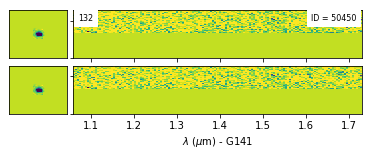

In [17]:
good = np.where((np.array(grp.catalog['MAG_AUTO']) > 22) & (np.array(grp.catalog['MAG_AUTO']) < 24))[0]
for g in good:
    id_fit = np.array(grp.catalog['NUMBER'])[g]
    mag_fit = grp.catalog['MAG_AUTO'][g]
    grizli_fit(grp, id_fit = id_fit, field = field,
               use_pz_prior = False, use_phot = True, scale_phot = True,
               templ0 = templ0, templ1 = templ1, ez = ez, ep = ep, pline = pline,)
        